# Sequencial NN

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from config.config import *
from config.constants import *
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.model_selection import train_test_split

In [228]:
def plot_model(hist):
    fig, axs = plt.subplots(nrows=1, figsize=(11, 9))
    plt.rcParams['font.size'] = '14'

    for label in (axs.get_xticklabels() + axs.get_yticklabels()):
        label.set_fontsize(14)    

    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])

    axs.set_title('Model Accuracy')
    axs.set_ylabel('Accuracy', fontsize=14)
    axs.set_xlabel('Epoch', fontsize=14)
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    print("Model has training accuracy of {:.2f}%".format(hist.history['accuracy'][-1]*100))

In [477]:
def pre_process_split(path):
    
    dataset = pd.read_csv(path)
    dataset.dropna(inplace = True)
    
    # assigning new column names to the dataframe
    dataset.columns = constants.cols + ['label']
    
    # creating training set ignoring labels
    train_data = dataset[dataset.columns[:-1]].values
    labels = dataset['label'].values
    n_class = len(set(labels))
    
    X_train, X_test, y_train, y_test =   train_test_split(train_data, labels, test_size=0.20)

    X_train = X_train.reshape(-1, 1, train_data.shape[1])
    X_test  = X_test.reshape(-1, 1, train_data.shape[1])
    y_train = y_train.reshape(-1, 1, 1)
    y_test = y_test.reshape(-1, 1, 1)
    
    return X_train, X_test, y_train, y_test, n_class

In [481]:
def model_config_train(name,eps,bs,actvn,datalink):
    
    print("processing dataset")
    X_train, X_test, y_train, y_test, n_class = pre_process_split(datalink)
    print(n_class)
    model = Sequential()
    model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(n_class, activation=actvn))
    print(model.summary())
       
    chk = ModelCheckpoint(name+'.pkl',save_best_only=True, mode='auto', verbose=1)
    print("saving as:",name+'.pkl')
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist = model.fit(X_train, y_train, epochs=eps, batch_size=bs, callbacks=[chk], validation_split=0.2)
    
    plot_model(hist)
    
    return model

## Loading dataset for binary classifier

In [515]:
def plotter(plot_data,unique_labels,n_plots):
    
    data = plot_data.copy()
    predicted_labels = data['label']
    #print(len(set(predicted_labels)),unique_labels)
    #print(Counter(predicted_labels).values(),[unique_labels[each] for each in Counter(predicted_labels).keys()])
    
    matrics = sorted(zip([unique_labels[each] for each in Counter(predicted_labels).keys()],Counter(predicted_labels).values() ), key=lambda x: x[1])
    
    score = [list(j) for j in matrics][::-1]
    
    
    
    total = sum([i[1] for i in score])

    c=0
    for i in score:

        score[c][1] = str(round(i[1]*100/total,2))+"%"
        #print("Fault type:", i[-1], "Percentage: {:.2f}%".format(i[1]*100/total))
        c+=1

    print(pd.DataFrame.from_records(score,columns=['Fault type','Percentage']))
    
    #print("changing numbers to labels again")
    data['label'] = [unique_labels[i] for i in predicted_labels]

    fig, ax = plt.subplots(n_plots,figsize=(15,4*n_plots))

    for j in range(n_plots):

        legend_list = []
        for i in range(len(set(predicted_labels))):

            extract = data[data.label==unique_labels[i]][cols[j]]    

            #print(len(extract))
            if unique_labels[i]==score[0][0] and score[0][0]!='NML' or unique_labels[i]== 'FAULT':
                temp = ax[j].scatter(extract.index,extract,marker='+',s=40)
            else:
                temp = ax[j].scatter(extract.index,extract,marker='.',s=10)


            legend_list.append(temp)

        ax[j].legend(legend_list,unique_labels,scatterpoints=3,ncol=1,fontsize=15)

    fig.tight_layout()
    plt.show()

    return score[0][0]

In [456]:
def tester(model,frame):
    
    data = frame
    
    cols = ['A'+str(each+1) for each in range(int(col_len/2))] + ['V'+str(each+1) for each in range(int(col_len/2))]
    
    if data.shape[1]==6:
        data.columns = cols
    elif data.shape[1]==7:
        data.columns = cols + ['label']
        data = data[cols]
    else:
        print("columns length is ",data.shape[1])
    
    
    test_preds = model.predict(data.values.reshape(-1,1,6).tolist())
    predicted_labels = np.argmax(test_preds,axis=1)
    
    data['label'] = predicted_labels
    
    return data
    

## Testing the models

processing dataset
Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100)               42800     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 202       
Total params: 43,002
Trainable params: 43,002
Non-trainable params: 0
_________________________________________________________________
None
saving as: binary_clf .pkl
Epoch 1/20
704/704 [==============================] - 11s 10ms/step - loss: 0.3791 - accuracy: 0.8400 - val_loss: 0.2390 - val_accuracy: 0.9161

Epoch 00001: val_loss improved from inf to 0.23901, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 2/20
704/704 [==============================] - 6s 8ms/step - loss: 0.2277 - accuracy: 0.9228 - val_loss: 0.1975 - val_accuracy: 0.9329

Epoch 00002: val_loss improved from 0.23901 to 0.19754, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 3/20
704/704 [==============================] - 7s 11ms/step - loss: 0.1958 - accuracy: 0.9346 - val_loss: 0.1862 - val_accuracy: 0.9369

Epoch 00003: val_loss improved from 0.19754 to 0.18618, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 4/20
704/704 [==============================] - 6s 8ms/step - loss: 0.1811 - accuracy: 0.9415 - val_loss: 0.1682 - val_accuracy: 0.9460

Epoch 00004: val_loss improved from 0.18618 to 0.16820, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 5/20
704/704 [==============================] - 6s 9ms/step - loss: 0.1702 - accuracy: 0.9461 - val_loss: 0.1671 - val_accuracy: 0.9522

Epoch 00005: val_loss improved from 0.16820 to 0.16710, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 6/20
704/704 [==============================] - 6s 9ms/step - loss: 0.1626 - accuracy: 0.9486 - val_loss: 0.1557 - val_accuracy: 0.9524

Epoch 00006: val_loss improved from 0.16710 to 0.15569, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 7/20
704/704 [==============================] - 6s 8ms/step - loss: 0.1590 - accuracy: 0.9499 - val_loss: 0.1675 - val_accuracy: 0.9537

Epoch 00007: val_loss did not improve from 0.15569
Epoch 8/20
704/704 [==============================] - 7s 9ms/step - loss: 0.1550 - accuracy: 0.9511 - val_loss: 0.1646 - val_accuracy: 0.9455

Epoch 00008: val_loss did not improve from 0.15569
Epoch 9/20
704/704 [==============================] - 6s 8ms/step - loss: 0.1509 - accuracy: 0.9514 - val_loss: 0.1445 - val_accuracy: 0.9536

Epoch 00009: val_loss improved from 0.15569 to 0.14451, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 10/20
704/704 [==============================] - 6s 8ms/step - loss: 0.1482 - accuracy: 0.9520 - val_loss: 0.1434 - val_accuracy: 0.9520

Epoch 00010: val_loss improved from 0.14451 to 0.14342, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 11/20
704/704 [==============================] - 6s 9ms/step - loss: 0.1479 - accuracy: 0.9520 - val_loss: 0.1454 - val_accuracy: 0.9542

Epoch 00011: val_loss did not improve from 0.14342
Epoch 12/20
704/704 [==============================] - 6s 8ms/step - loss: 0.1447 - accuracy: 0.9525 - val_loss: 0.1418 - val_accuracy: 0.9518

Epoch 00012: val_loss improved from 0.14342 to 0.14176, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 13/20
704/704 [==============================] - 6s 8ms/step - loss: 0.1436 - accuracy: 0.9525 - val_loss: 0.1428 - val_accuracy: 0.9541

Epoch 00013: val_loss did not improve from 0.14176
Epoch 14/20
704/704 [==============================] - 6s 9ms/step - loss: 0.1432 - accuracy: 0.9524 - val_loss: 0.1377 - val_accuracy: 0.9532

Epoch 00014: val_loss improved from 0.14176 to 0.13767, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 15/20
704/704 [==============================] - 6s 9ms/step - loss: 0.1423 - accuracy: 0.9519 - val_loss: 0.1375 - val_accuracy: 0.9514

Epoch 00015: val_loss improved from 0.13767 to 0.13747, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 16/20
704/704 [==============================] - 6s 8ms/step - loss: 0.1407 - accuracy: 0.9523 - val_loss: 0.1390 - val_accuracy: 0.9525

Epoch 00016: val_loss did not improve from 0.13747
Epoch 17/20
704/704 [==============================] - 6s 9ms/step - loss: 0.1386 - accuracy: 0.9525 - val_loss: 0.1367 - val_accuracy: 0.9534

Epoch 00017: val_loss improved from 0.13747 to 0.13673, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 18/20
704/704 [==============================] - 6s 8ms/step - loss: 0.1392 - accuracy: 0.9523 - val_loss: 0.1363 - val_accuracy: 0.9534

Epoch 00018: val_loss improved from 0.13673 to 0.13627, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


Epoch 19/20
704/704 [==============================] - 6s 9ms/step - loss: 0.1369 - accuracy: 0.9527 - val_loss: 0.2249 - val_accuracy: 0.9265

Epoch 00019: val_loss did not improve from 0.13627
Epoch 20/20
704/704 [==============================] - 6s 8ms/step - loss: 0.1424 - accuracy: 0.9511 - val_loss: 0.1348 - val_accuracy: 0.9533

Epoch 00020: val_loss improved from 0.13627 to 0.13484, saving model to binary_clf.pkl


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


INFO:tensorflow:Assets written to: binary_clf.pkl/assets


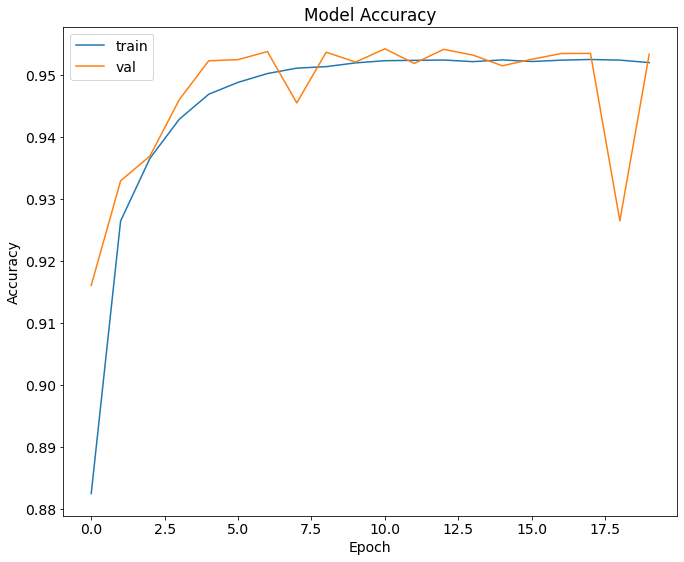

Model has training accuracy of 95.19%


In [478]:
model_config_train('binary_clf',20,2000,'softmax','./TrainingSet/binary/bin_dataset_simulink.csv')

processing dataset
11
Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_16 (LSTM)               (None, 100)               42800     
_________________________________________________________________
dense_16 (Dense)             (None, 11)                1111      
Total params: 43,911
Trainable params: 43,911
Non-trainable params: 0
_________________________________________________________________
None
saving as: multi_clf.pkl
Epoch 1/20
168/168 [==============================] - 9s 19ms/step - loss: 1.8787 - accuracy: 0.4424 - val_loss: 1.2653 - val_accuracy: 0.5835

Epoch 00001: val_loss improved from inf to 1.26529, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 2/20
168/168 [==============================] - 2s 12ms/step - loss: 1.2399 - accuracy: 0.5792 - val_loss: 1.1690 - val_accuracy: 0.5810

Epoch 00002: val_loss improved from 1.26529 to 1.16902, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 3/20
168/168 [==============================] - 2s 12ms/step - loss: 1.1649 - accuracy: 0.5798 - val_loss: 1.1392 - val_accuracy: 0.5826

Epoch 00003: val_loss improved from 1.16902 to 1.13922, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 4/20
168/168 [==============================] - 2s 12ms/step - loss: 1.1438 - accuracy: 0.5780 - val_loss: 1.1260 - val_accuracy: 0.5822

Epoch 00004: val_loss improved from 1.13922 to 1.12597, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 5/20
168/168 [==============================] - 2s 11ms/step - loss: 1.1338 - accuracy: 0.5787 - val_loss: 1.1174 - val_accuracy: 0.5830

Epoch 00005: val_loss improved from 1.12597 to 1.11738, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 6/20
168/168 [==============================] - 2s 11ms/step - loss: 1.1264 - accuracy: 0.5811 - val_loss: 1.1113 - val_accuracy: 0.5825

Epoch 00006: val_loss improved from 1.11738 to 1.11128, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 7/20
168/168 [==============================] - 2s 12ms/step - loss: 1.1182 - accuracy: 0.5801 - val_loss: 1.1070 - val_accuracy: 0.5829

Epoch 00007: val_loss improved from 1.11128 to 1.10705, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 8/20
168/168 [==============================] - 2s 11ms/step - loss: 1.1168 - accuracy: 0.5793 - val_loss: 1.1034 - val_accuracy: 0.5852

Epoch 00008: val_loss improved from 1.10705 to 1.10342, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 9/20
168/168 [==============================] - 2s 11ms/step - loss: 1.1142 - accuracy: 0.5795 - val_loss: 1.1019 - val_accuracy: 0.5799

Epoch 00009: val_loss improved from 1.10342 to 1.10193, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 10/20
168/168 [==============================] - 2s 12ms/step - loss: 1.1112 - accuracy: 0.5786 - val_loss: 1.1030 - val_accuracy: 0.5867

Epoch 00010: val_loss did not improve from 1.10193
Epoch 11/20
168/168 [==============================] - 2s 11ms/step - loss: 1.1072 - accuracy: 0.5812 - val_loss: 1.0999 - val_accuracy: 0.5823

Epoch 00011: val_loss improved from 1.10193 to 1.09994, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 12/20
168/168 [==============================] - 2s 12ms/step - loss: 1.1064 - accuracy: 0.5801 - val_loss: 1.0976 - val_accuracy: 0.5827

Epoch 00012: val_loss improved from 1.09994 to 1.09758, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 13/20
168/168 [==============================] - 2s 12ms/step - loss: 1.1024 - accuracy: 0.5816 - val_loss: 1.0936 - val_accuracy: 0.5829

Epoch 00013: val_loss improved from 1.09758 to 1.09358, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 14/20
168/168 [==============================] - 2s 11ms/step - loss: 1.1020 - accuracy: 0.5803 - val_loss: 1.0920 - val_accuracy: 0.5859

Epoch 00014: val_loss improved from 1.09358 to 1.09204, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 15/20
168/168 [==============================] - 2s 12ms/step - loss: 1.1002 - accuracy: 0.5812 - val_loss: 1.0922 - val_accuracy: 0.5838

Epoch 00015: val_loss did not improve from 1.09204
Epoch 16/20
168/168 [==============================] - 2s 11ms/step - loss: 1.0946 - accuracy: 0.5827 - val_loss: 1.0909 - val_accuracy: 0.5844

Epoch 00016: val_loss improved from 1.09204 to 1.09085, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 17/20
168/168 [==============================] - 2s 11ms/step - loss: 1.0971 - accuracy: 0.5815 - val_loss: 1.0878 - val_accuracy: 0.5858

Epoch 00017: val_loss improved from 1.09085 to 1.08777, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 18/20
168/168 [==============================] - 2s 12ms/step - loss: 1.0943 - accuracy: 0.5823 - val_loss: 1.0859 - val_accuracy: 0.5847

Epoch 00018: val_loss improved from 1.08777 to 1.08589, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 19/20
168/168 [==============================] - 2s 13ms/step - loss: 1.0943 - accuracy: 0.5821 - val_loss: 1.0834 - val_accuracy: 0.5876

Epoch 00019: val_loss improved from 1.08589 to 1.08335, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


Epoch 20/20
168/168 [==============================] - 2s 13ms/step - loss: 1.0944 - accuracy: 0.5821 - val_loss: 1.0829 - val_accuracy: 0.5864

Epoch 00020: val_loss improved from 1.08335 to 1.08286, saving model to multi_clf.pkl


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


INFO:tensorflow:Assets written to: multi_clf.pkl/assets


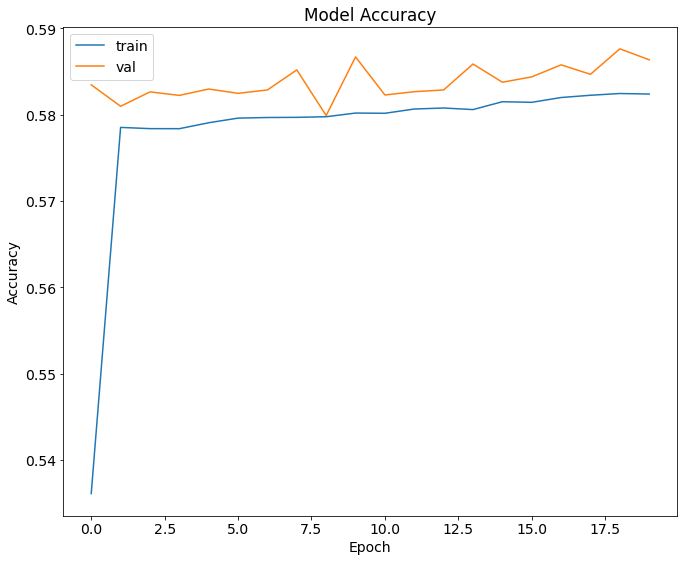

Model has training accuracy of 58.24%


In [486]:
model_config_train('multi_clf',20,2000,'softmax','./TrainingSet/multi/mul_dataset_simulink.csv')

In [510]:
binary_labels_list = ['NML','FAULT']
binary_model = load_model('binary_clf.pkl')

In [511]:
multi_labels_list = ['AB', 'AC', 'BC', 'ABC', 'AG', 'BG', 'ABG', 'CG', 'ACG', 'BCG', 'ABCG']
multi_model = load_model('multi_clf.pkl')

In [512]:
import os

In [523]:
# current directory
path = "./TrainingSet/"

# list of file of the given path is assigned to the variable 
file_list = [each for each in list(os.walk(path))[0][-1] if ".csv" in each]


.
.
 5ABCG.csv
  Fault type Percentage
0        NML     82.72%
1      FAULT     17.27%


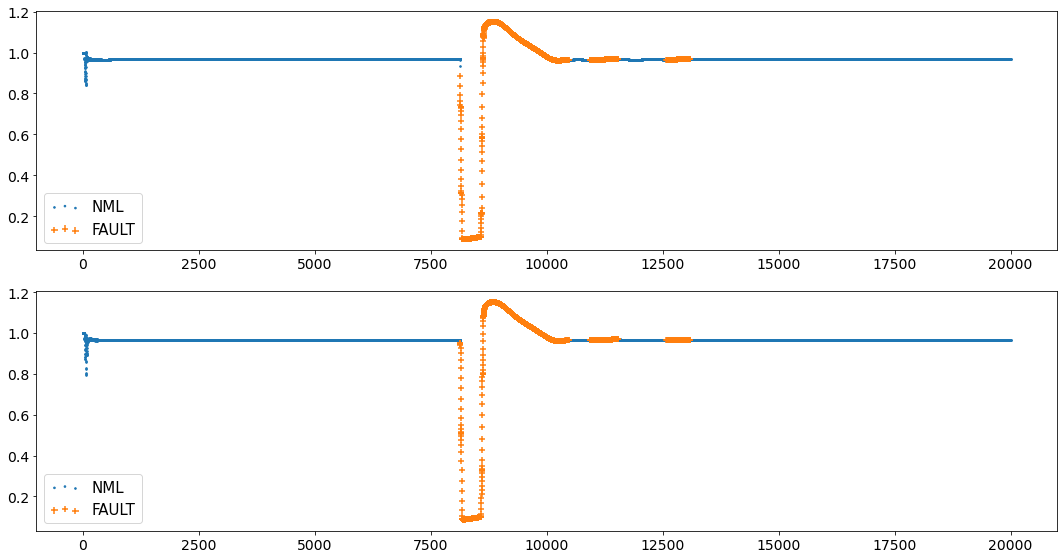

  Fault type Percentage
0        ABC     99.19%
1        ACG      0.29%
2        BCG      0.26%
3        ABG       0.2%
4       ABCG      0.06%


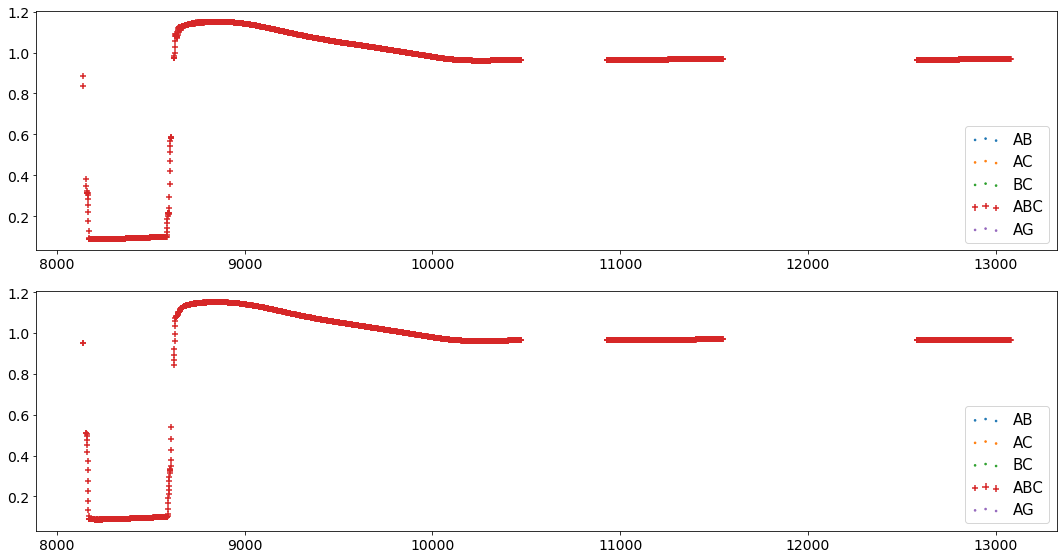


.
.
 10ABG.csv
  Fault type Percentage
0        NML     99.36%
1      FAULT      0.65%


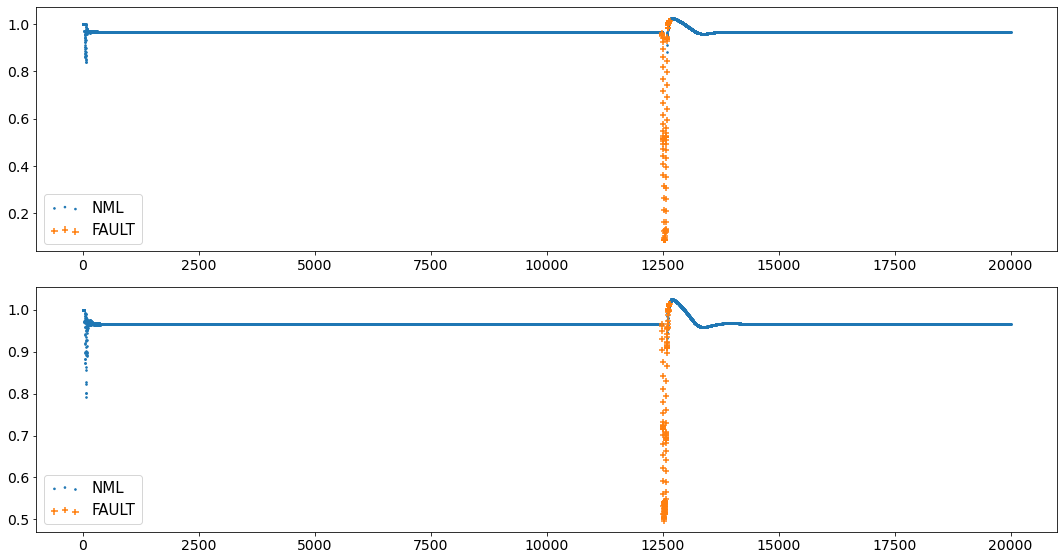

  Fault type Percentage
0        ABG     58.14%
1        ABC     37.21%
2         AG      2.33%
3        BCG      1.55%
4        ACG      0.78%


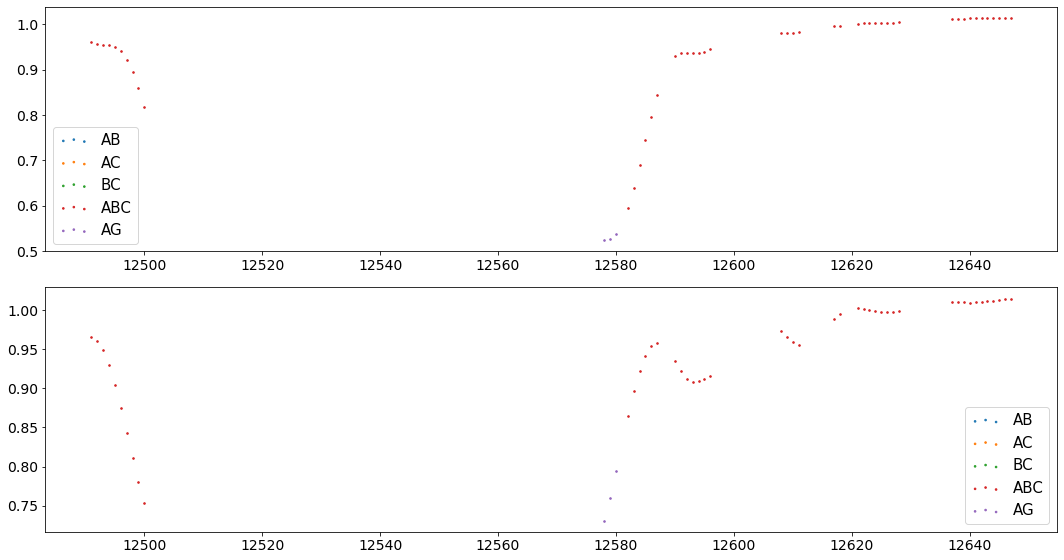


.
.
 3BC.csv
  Fault type Percentage
0        NML     99.69%
1      FAULT      0.32%


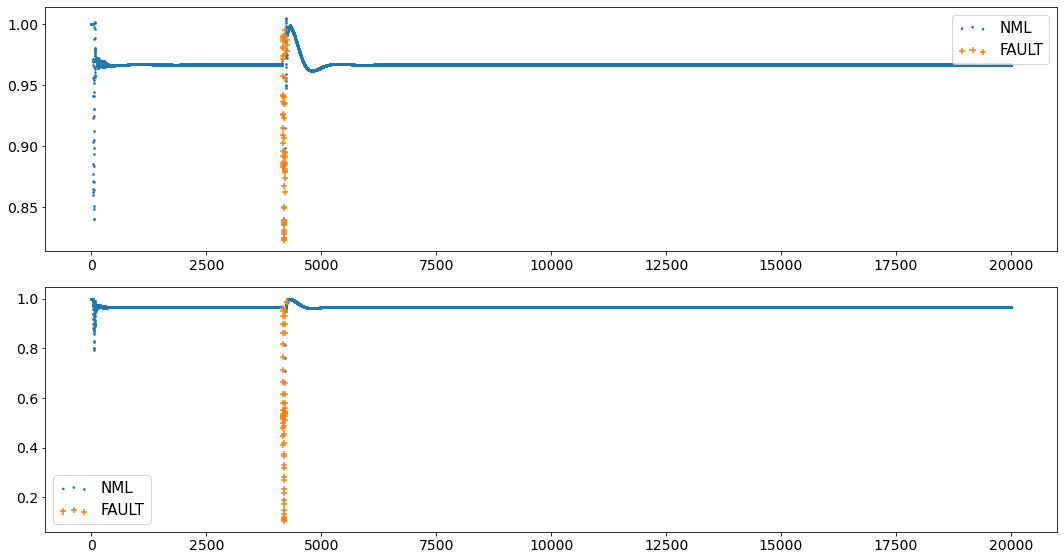

  Fault type Percentage
0         BC     63.49%
1        ABC     20.63%
2        BCG      12.7%
3        ACG      3.17%


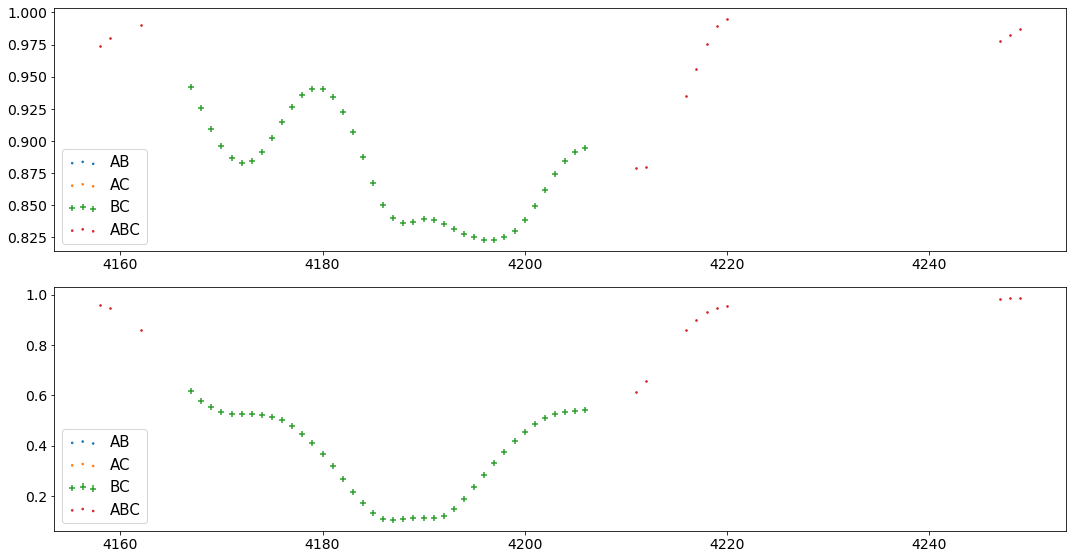


.
.
 3CG.csv
  Fault type Percentage
0        NML     80.94%
1      FAULT     19.07%


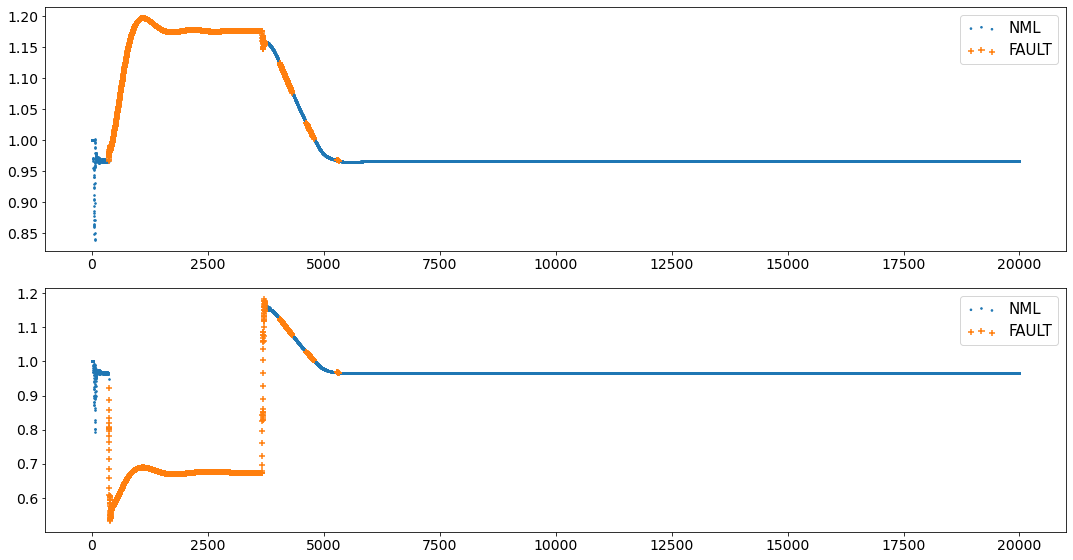

  Fault type Percentage
0         CG     87.44%
1        ABC     11.57%
2         BC      0.92%
3        ACG      0.08%


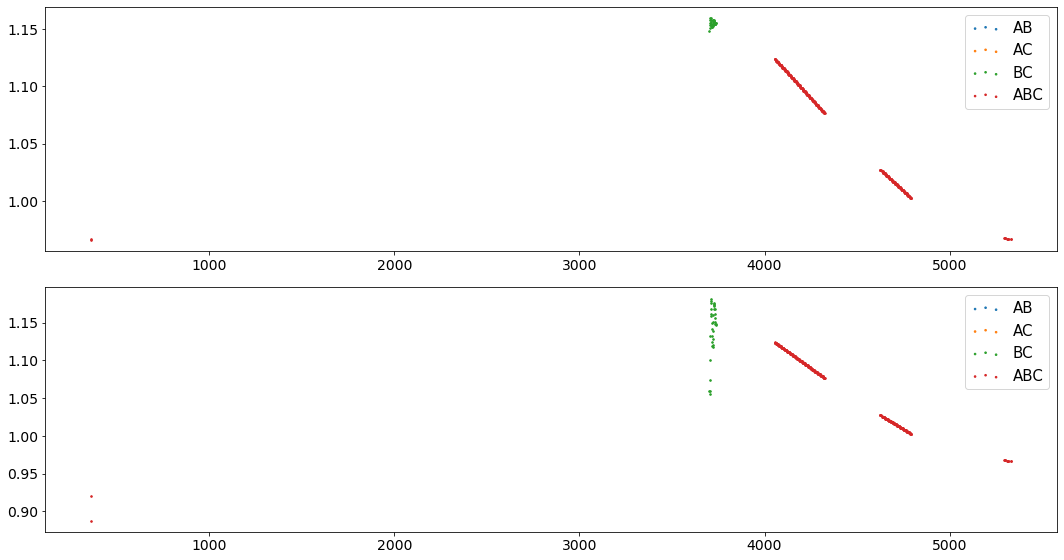


.
.
 1BCG.csv
  Fault type Percentage
0        NML     92.72%
1      FAULT      7.28%


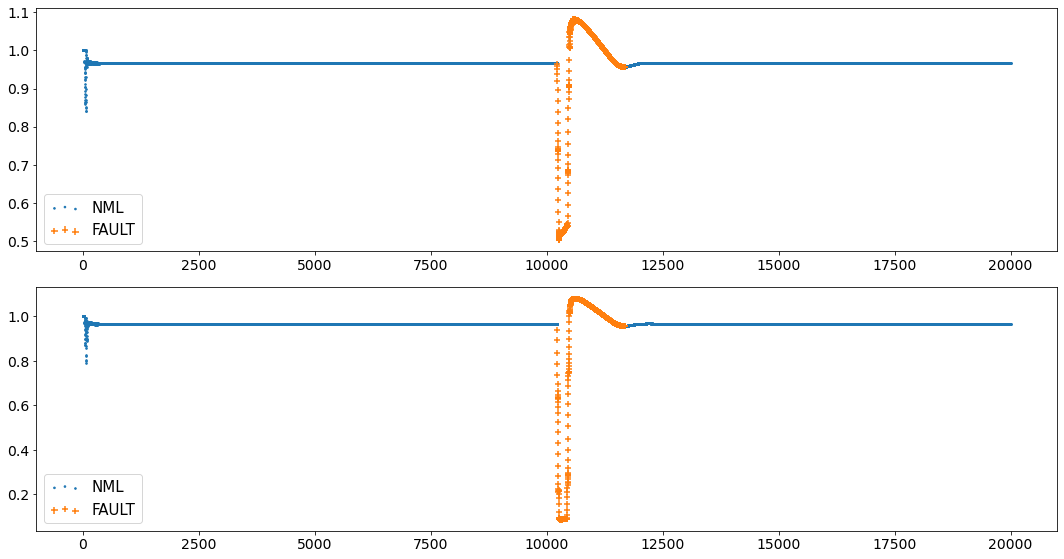

  Fault type Percentage
0        ABC     83.09%
1        BCG     16.15%
2         BG      0.55%
3        ABG      0.21%


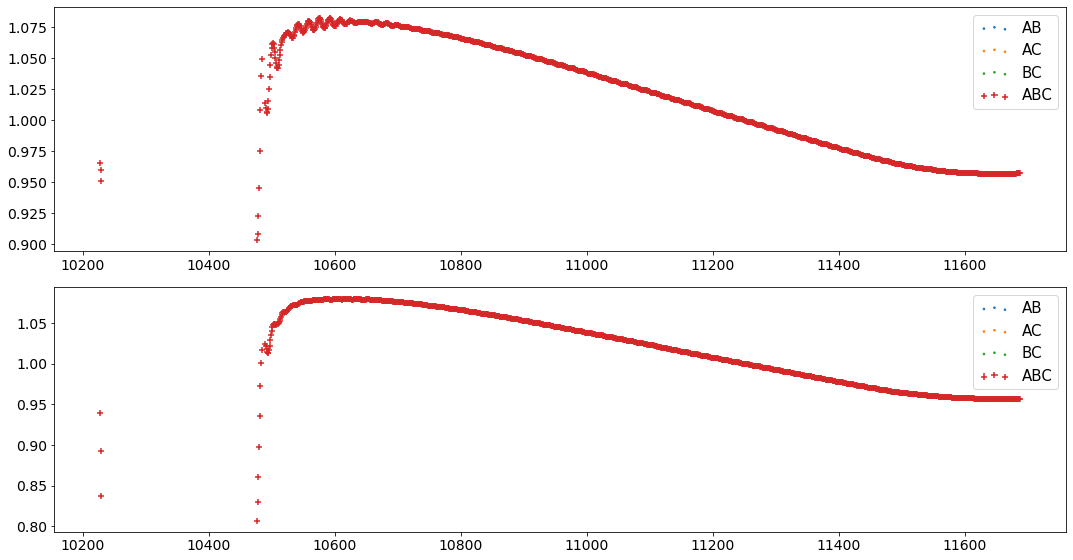


.
.
 7BG.csv
  Fault type Percentage
0        NML     83.53%
1      FAULT     16.46%


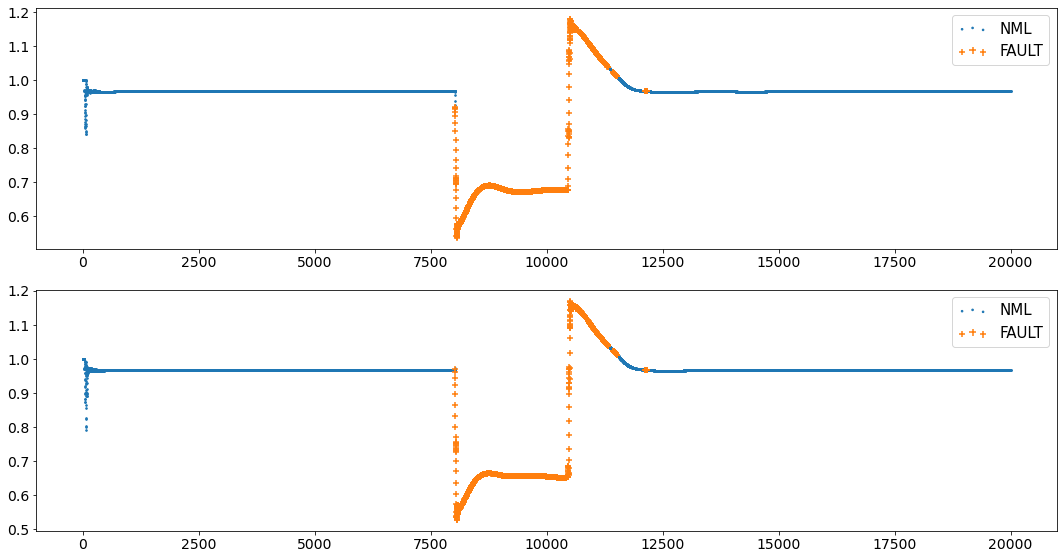

  Fault type Percentage
0         BG     74.61%
1        ABC      19.8%
2         BC      5.41%
3         AB      0.12%
4        BCG      0.06%


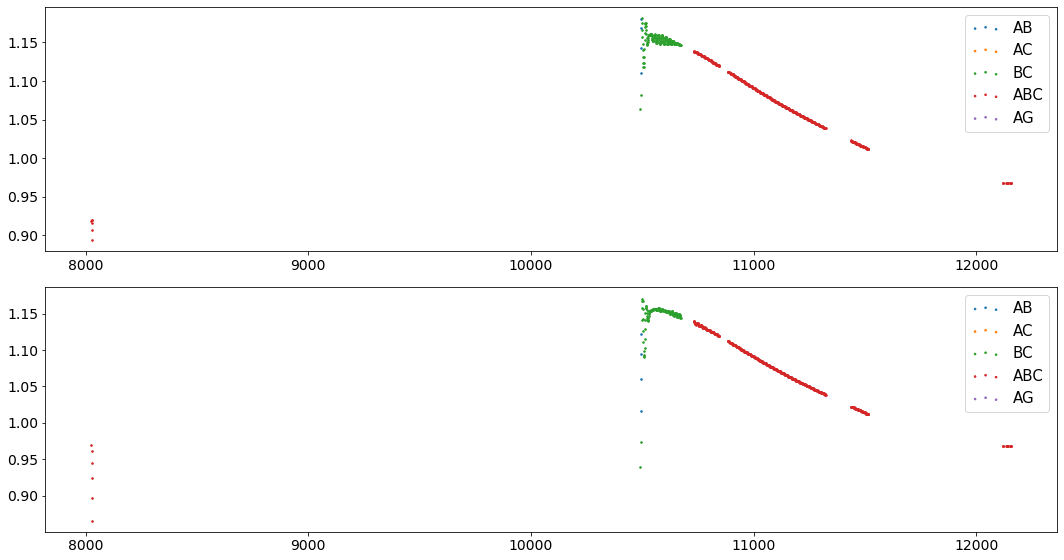


.
.
 5BG.csv
  Fault type Percentage
0        NML      57.6%
1      FAULT      42.4%


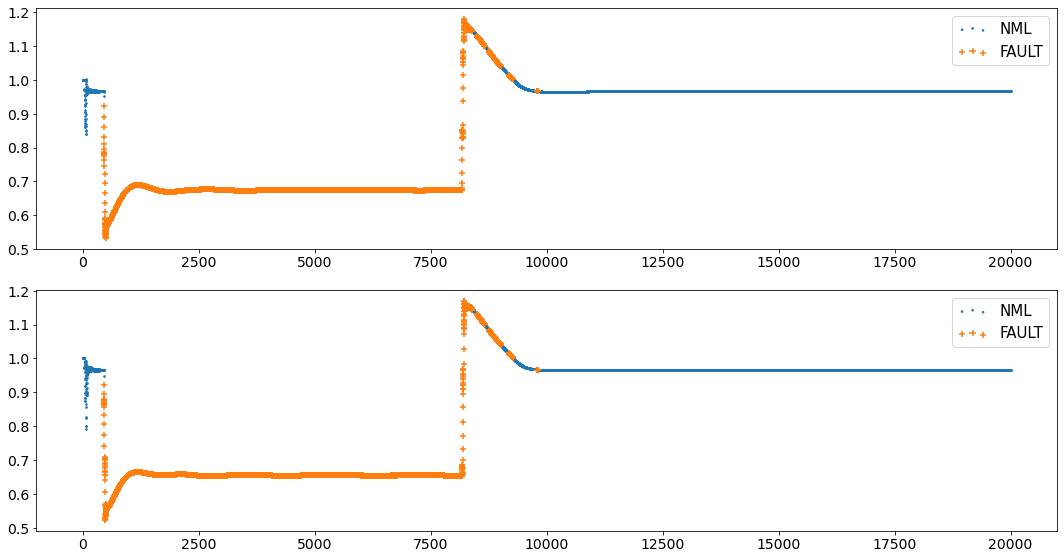

  Fault type Percentage
0         BG     91.39%
1        ABC      6.36%
2         BC      2.18%
3        ACG      0.05%
4        BCG      0.02%


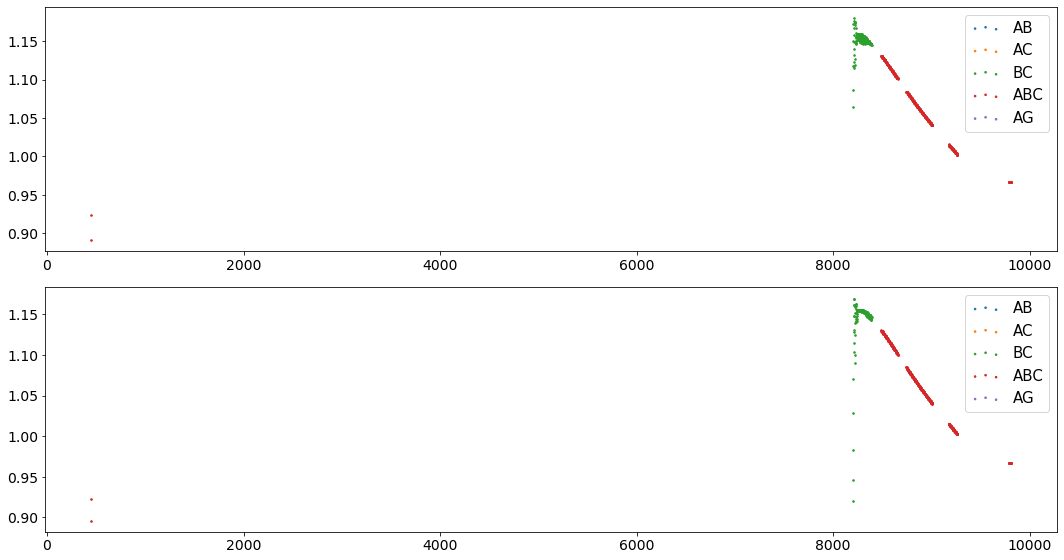


.
.
 9ABG.csv
  Fault type Percentage
0        NML     88.75%
1      FAULT     11.25%


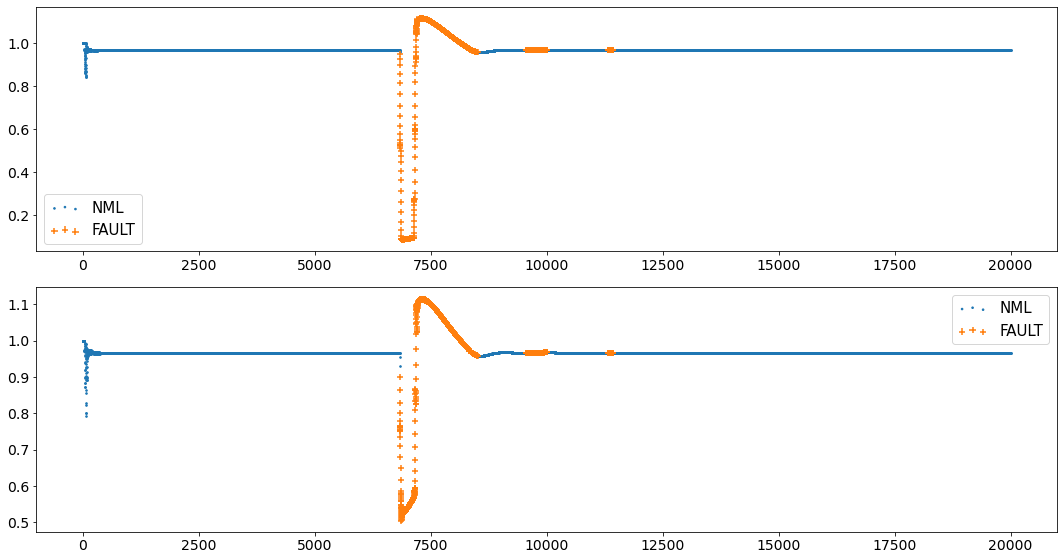

  Fault type Percentage
0        ABC     85.02%
1        ABG      14.4%
2         BG      0.49%
3        BCG      0.09%


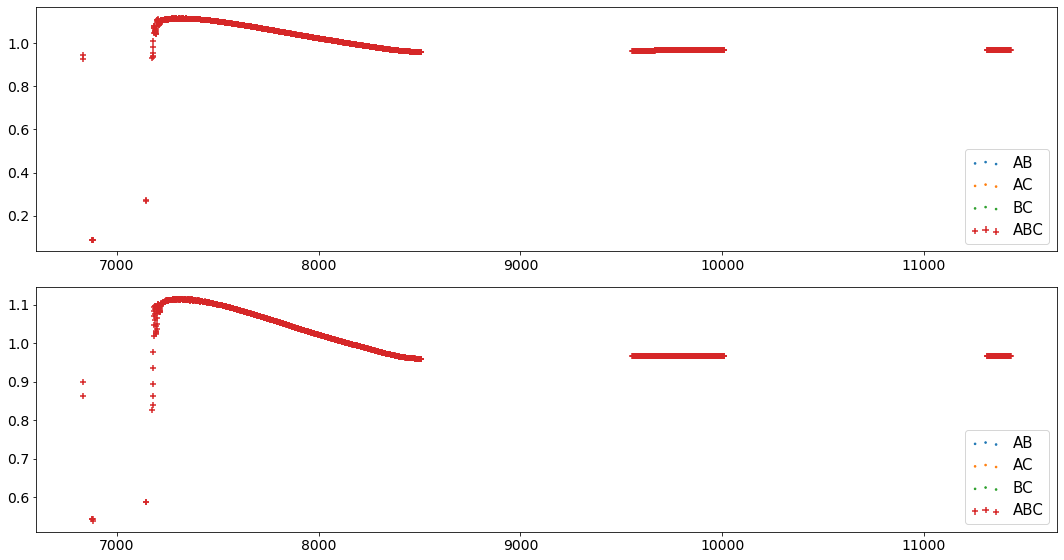


.
.
 1BC.csv
  Fault type Percentage
0        NML     69.56%
1      FAULT     30.44%


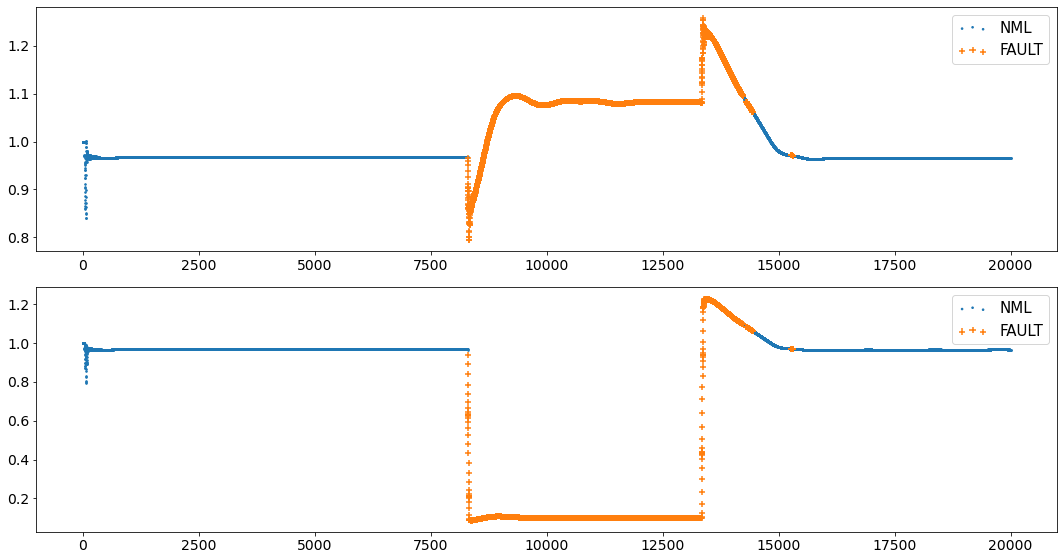

  Fault type Percentage
0         BC     86.24%
1        ABC     13.65%
2        BCG      0.08%
3         AB      0.02%
4        ABG      0.02%


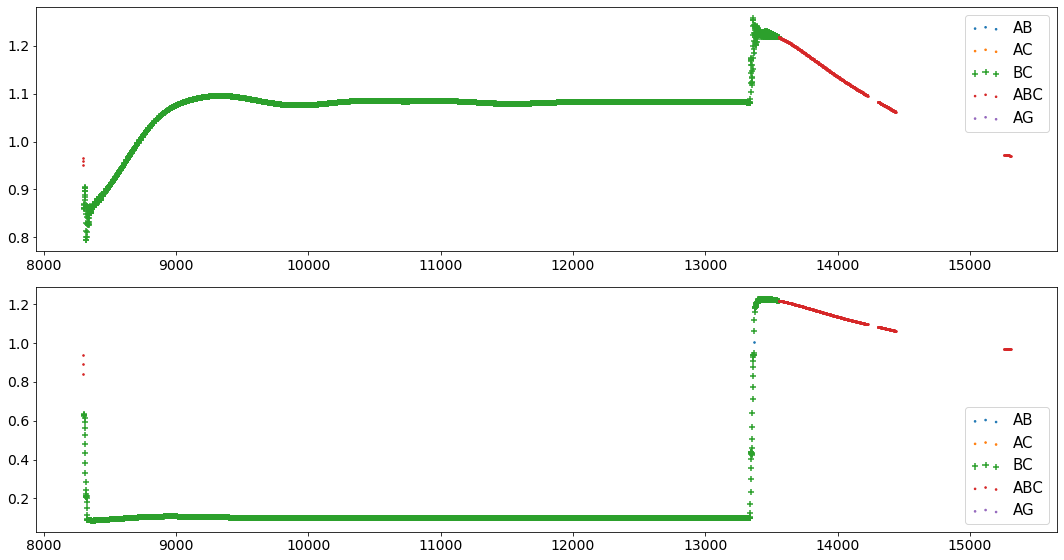


.
.
 1CG.csv
  Fault type Percentage
0        NML     98.83%
1      FAULT      1.17%


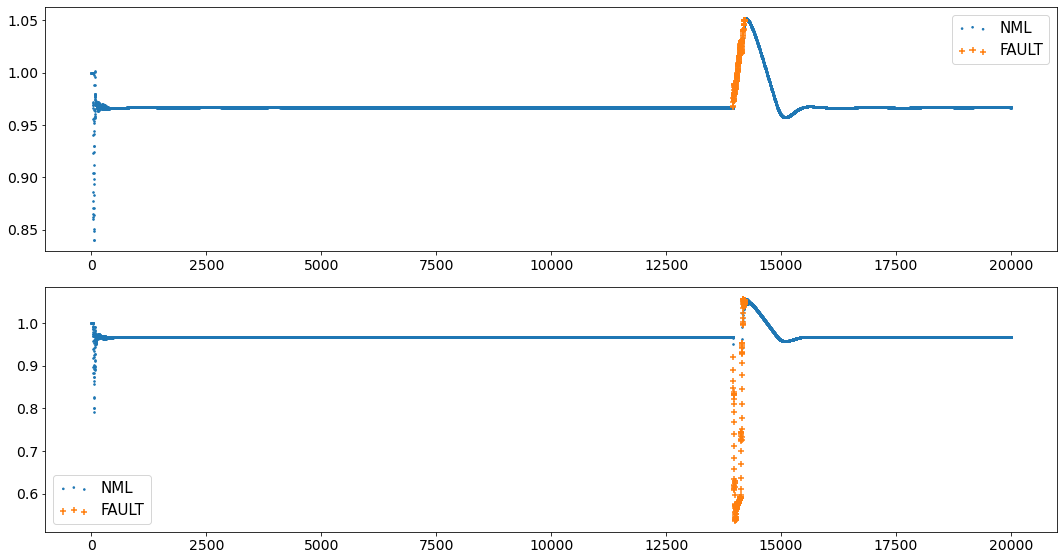

  Fault type Percentage
0         CG     78.97%
1        ABC     18.45%
2        BCG      1.29%
3        ACG      1.29%


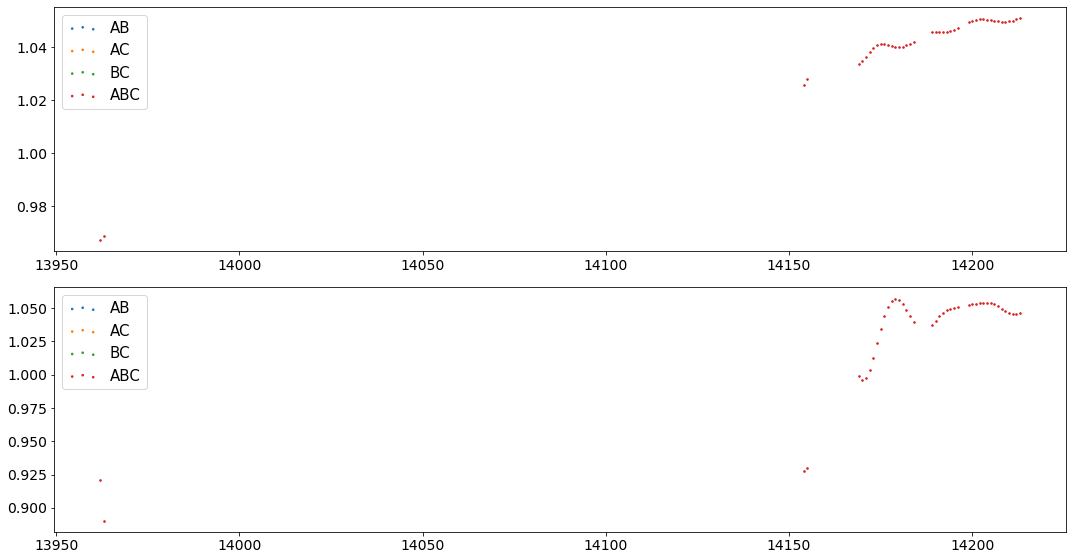


.
.
 5ABG.csv
  Fault type Percentage
0        NML     65.53%
1      FAULT     34.47%


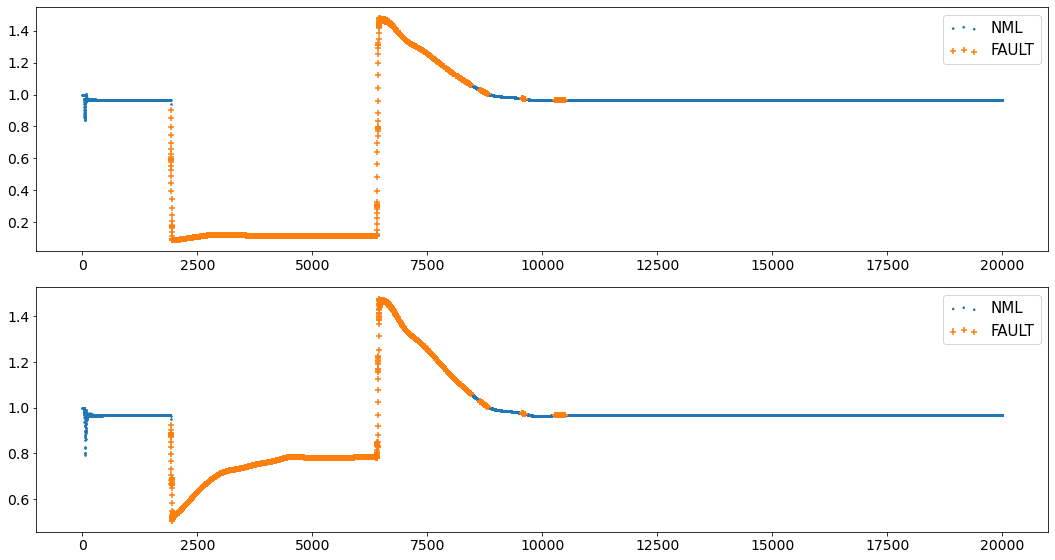

  Fault type Percentage
0        ABG     67.97%
1        ABC     21.49%
2        BCG      3.42%
3         BC      2.79%
4        ACG      2.39%
5         AB      1.42%
6         AC      0.41%
7         BG      0.09%
8       ABCG      0.03%


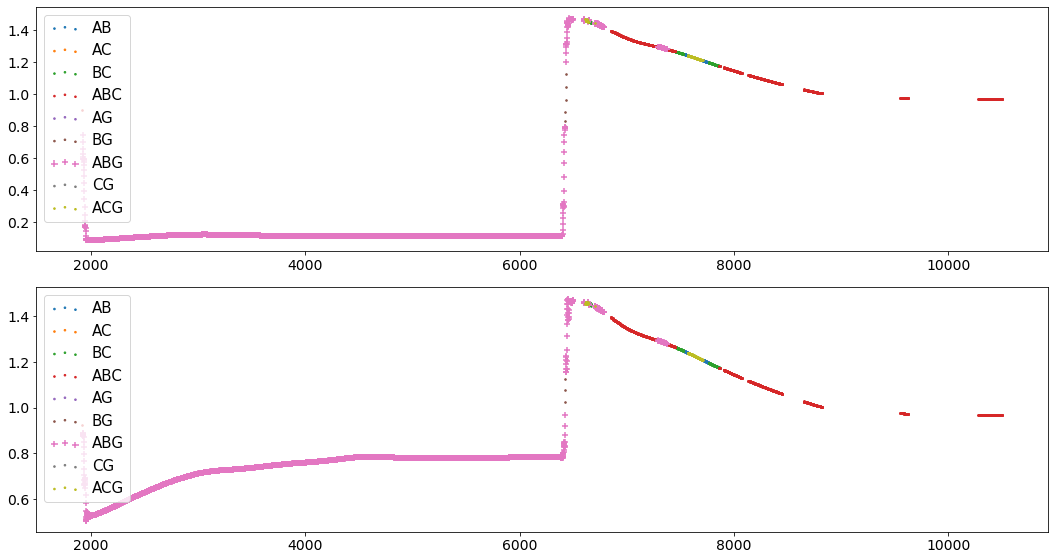


.
.
 9AG.csv
  Fault type Percentage
0        NML     64.03%
1      FAULT     35.97%


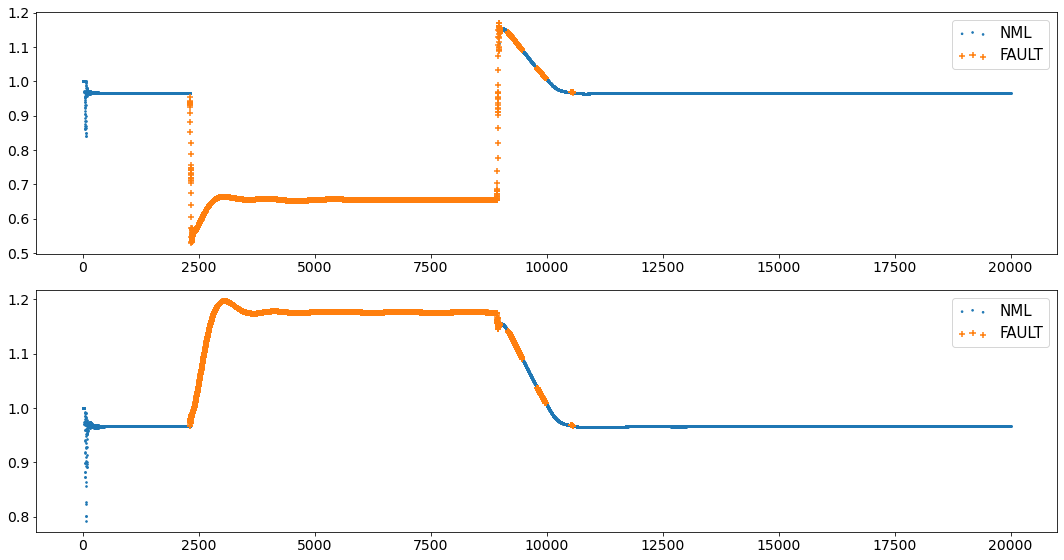

  Fault type Percentage
0         AG     92.27%
1        ABC      7.34%
2         BC      0.32%
3        ACG      0.07%


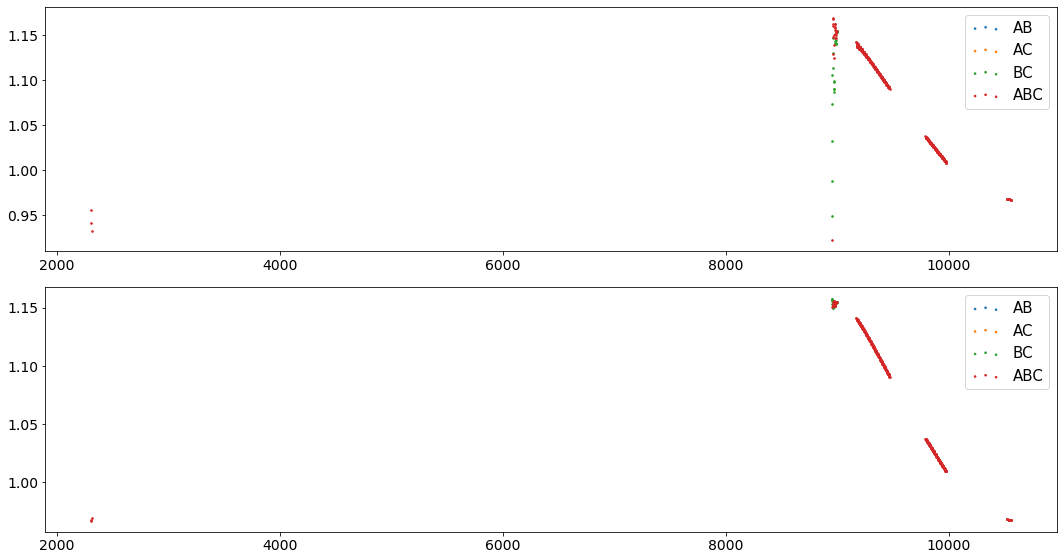


.
.
 7ABC.csv
  Fault type Percentage
0      FAULT     62.38%
1        NML     37.62%


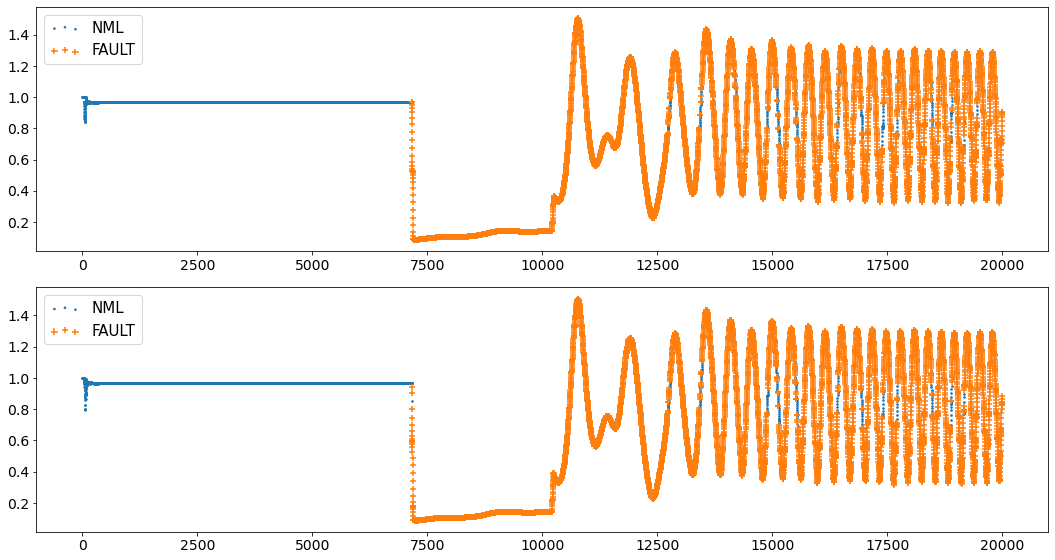

  Fault type Percentage
0        ABC      97.6%
1        BCG      0.73%
2         BC      0.62%
3        ABG      0.59%
4       ABCG       0.2%
5        ACG      0.14%
6         AB      0.13%


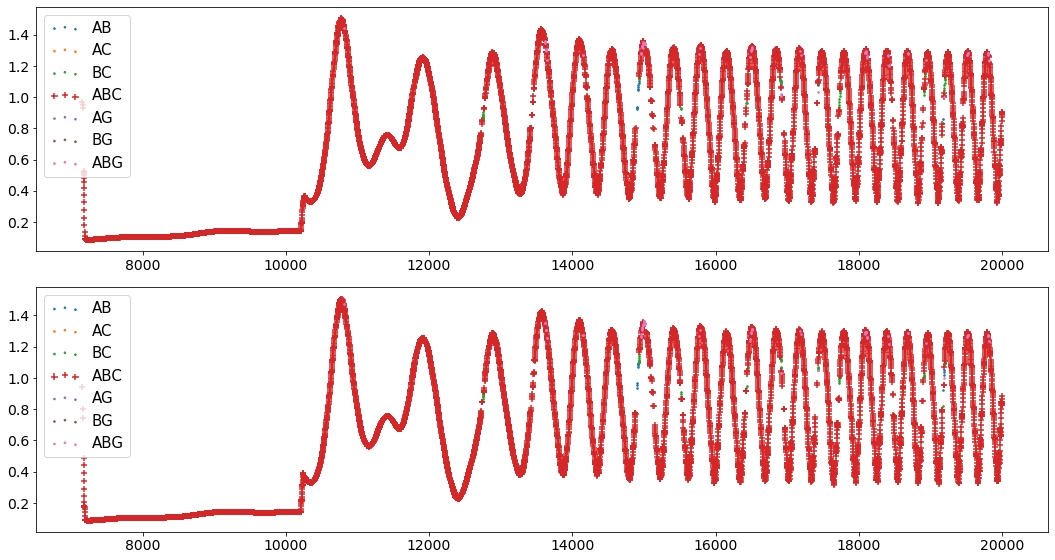


.
.
 7ACG.csv
  Fault type Percentage
0        NML     78.72%
1      FAULT     21.28%


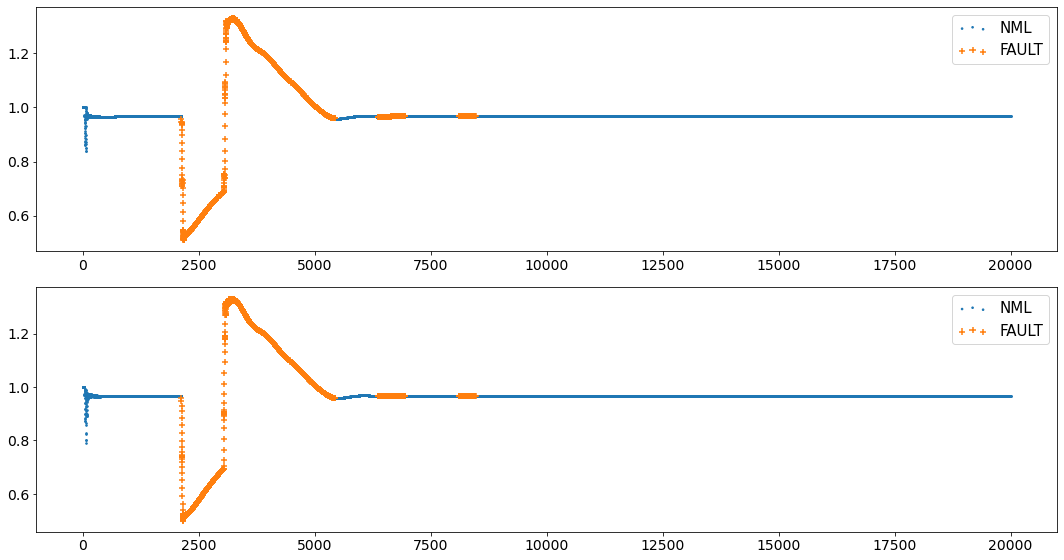

  Fault type Percentage
0        ABC     77.47%
1        ACG     22.11%
2        BCG      0.42%


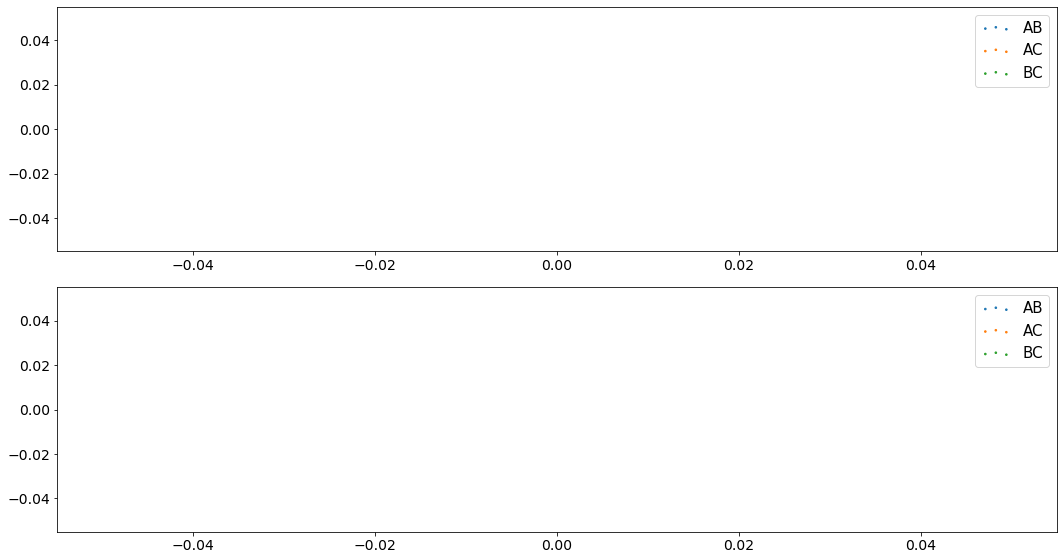


.
.
 7ABG.csv
  Fault type Percentage
0        NML     98.91%
1      FAULT      1.09%


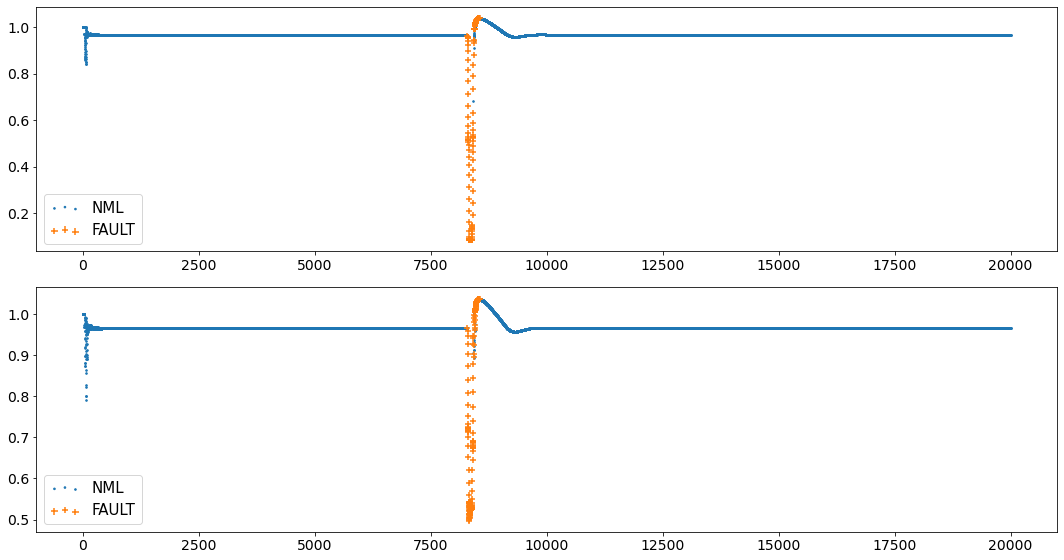

  Fault type Percentage
0        ABG     49.77%
1        ABC     47.95%
2        ACG      1.37%
3        BCG      0.91%


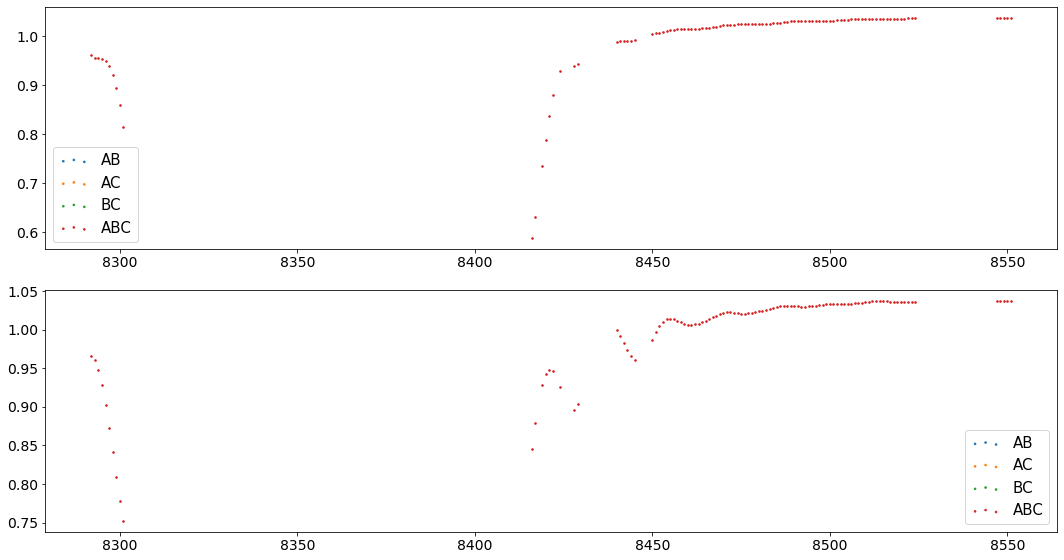


.
.
 9AC.csv
  Fault type Percentage
0        NML     88.06%
1      FAULT     11.94%


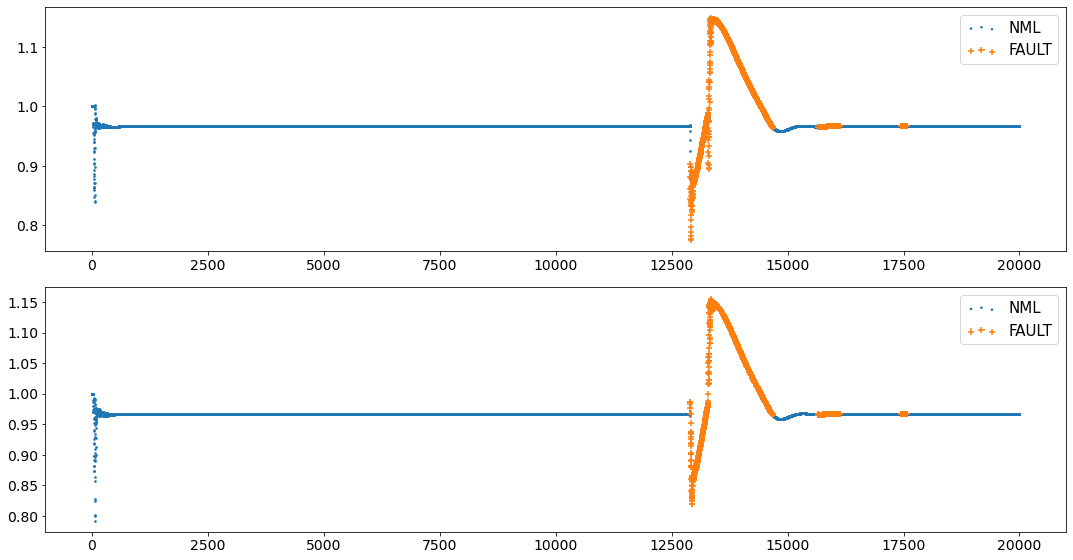

  Fault type Percentage
0        ABC     82.78%
1         AC     16.25%
2        ACG      0.96%


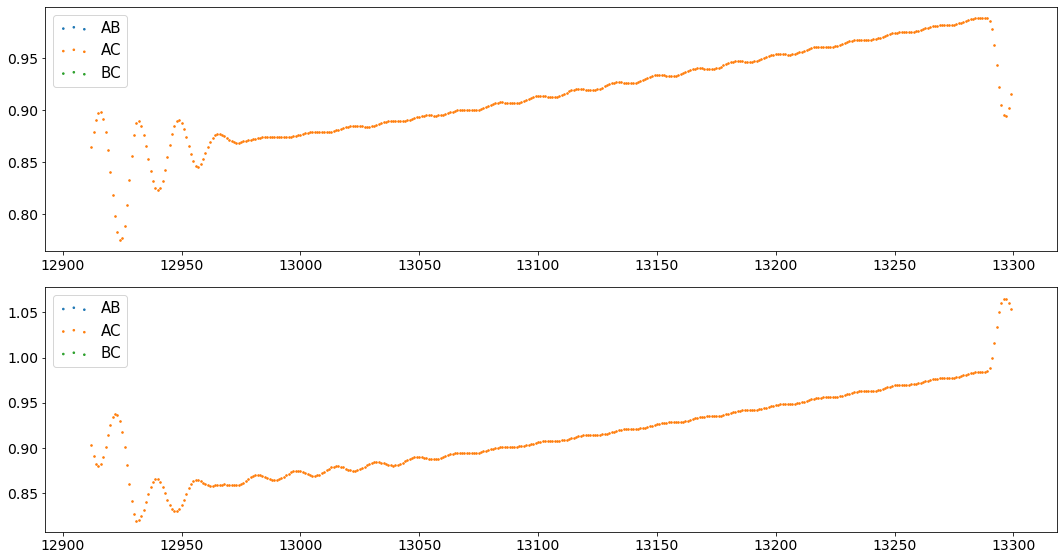


.
.
 1BG.csv
  Fault type Percentage
0        NML     83.02%
1      FAULT     16.98%


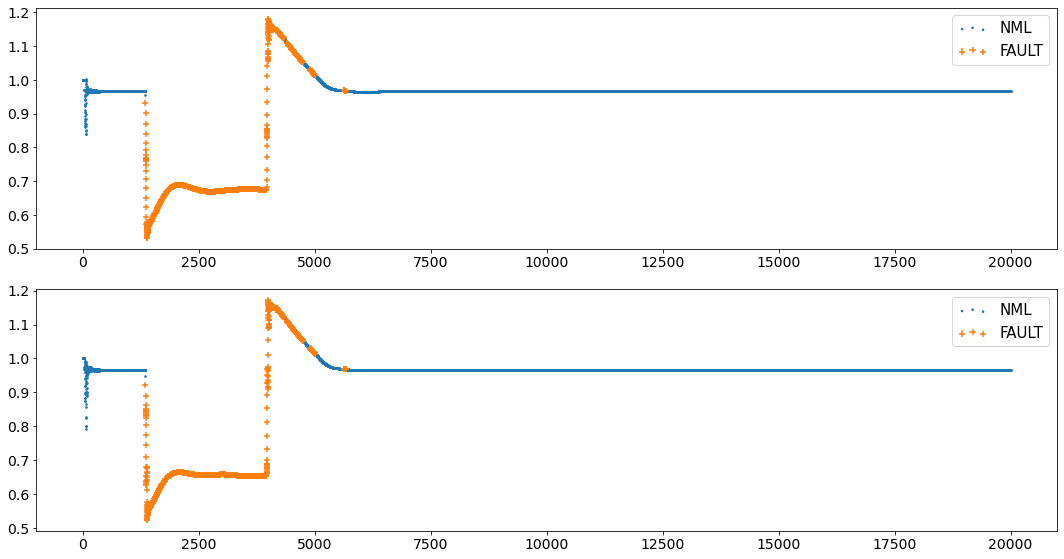

  Fault type Percentage
0         BG     77.56%
1        ABC      19.2%
2         BC      2.92%
3        ACG      0.15%
4         AB      0.12%
5        BCG      0.06%


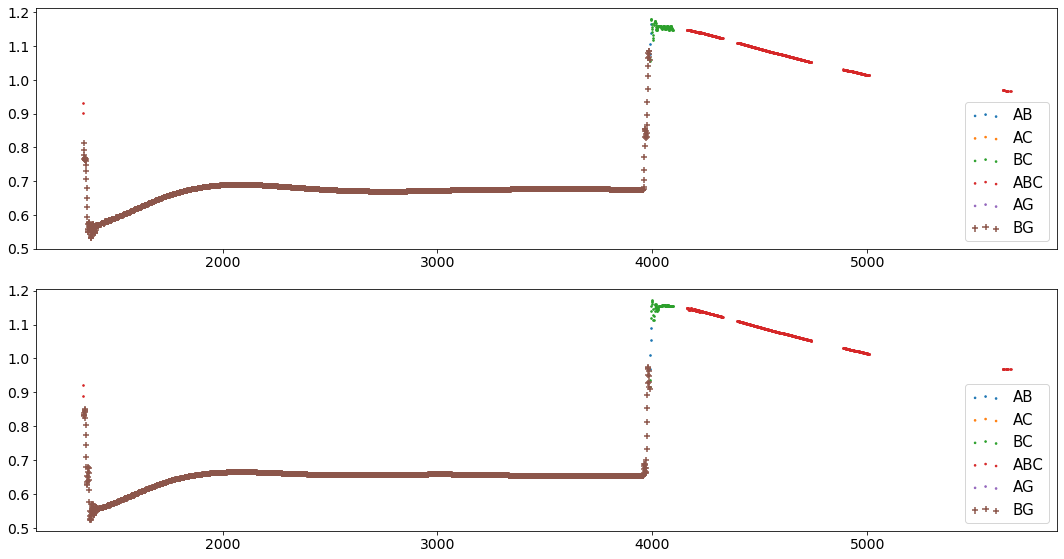


.
.
 5ABC.csv
  Fault type Percentage
0      FAULT      65.5%
1        NML     34.49%


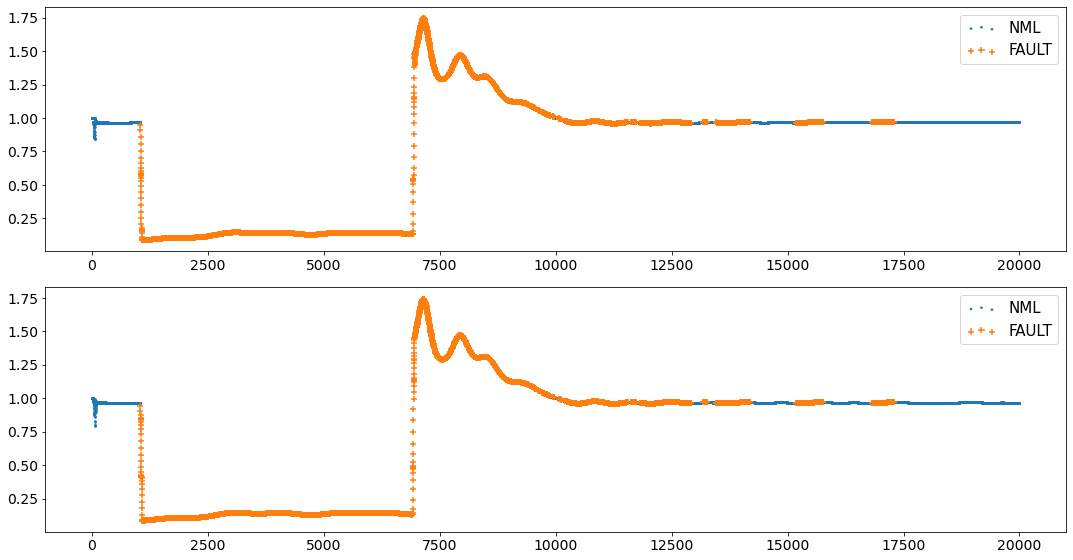

  Fault type Percentage
0        ABC     94.28%
1        ABG      1.63%
2        BCG      1.59%
3        ACG       1.0%
4         BC      0.77%
5         AC      0.37%
6         AB      0.34%
7       ABCG      0.03%


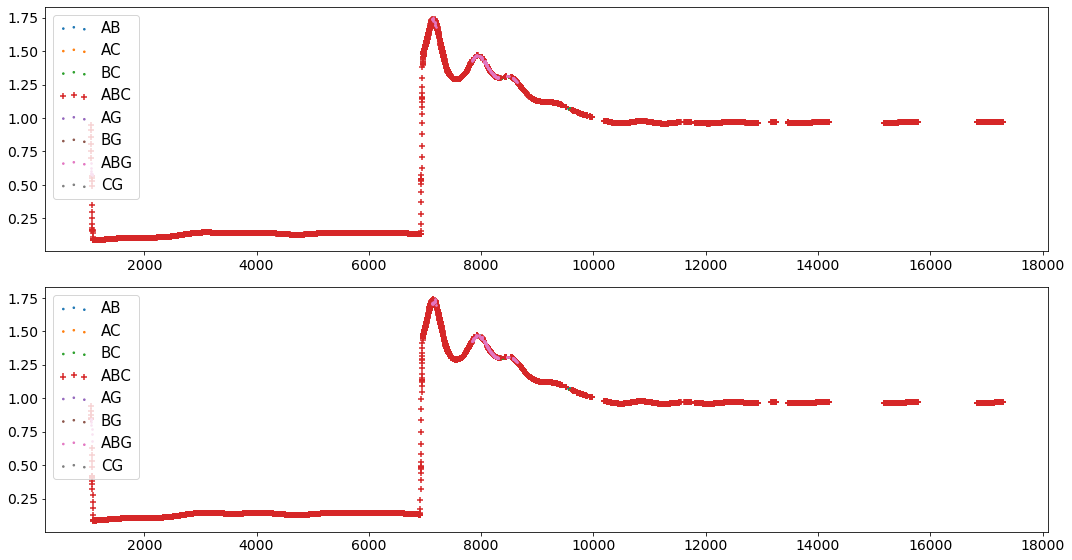


.
.
 5ACG.csv
  Fault type Percentage
0        NML     92.86%
1      FAULT      7.14%


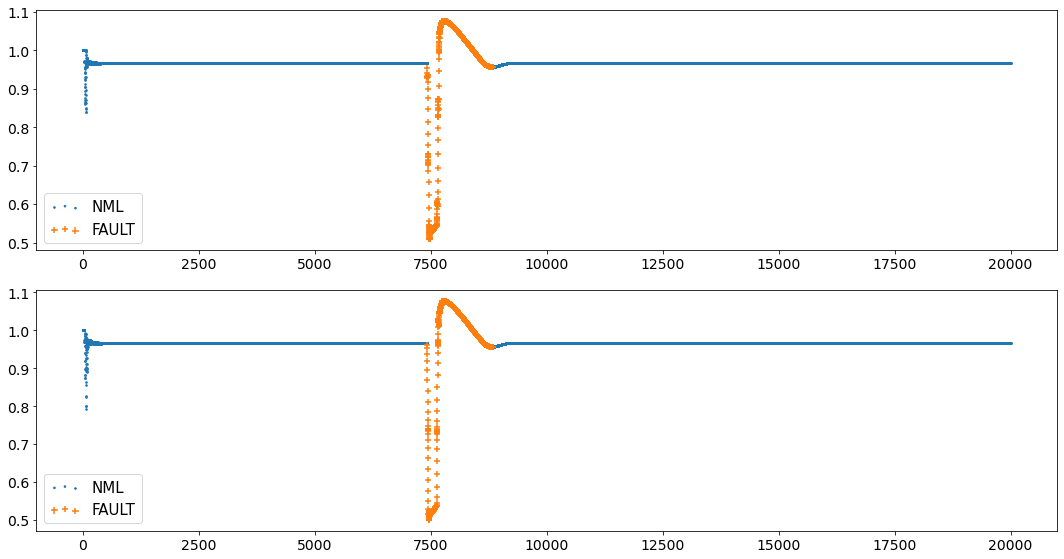

  Fault type Percentage
0        ABC      83.4%
1        ACG     16.04%
2         AG      0.56%


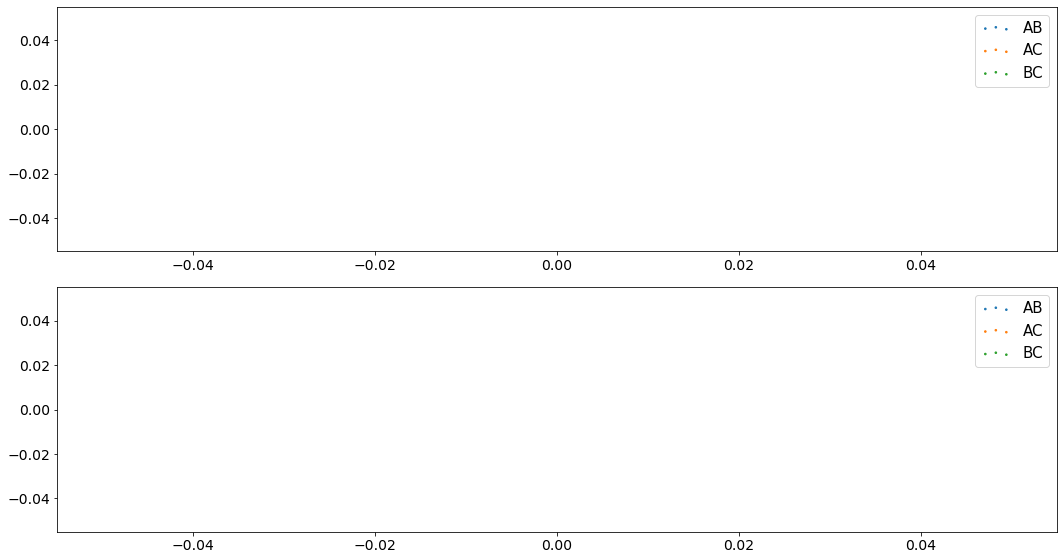


.
.
 9AB.csv
  Fault type Percentage
0        NML     74.27%
1      FAULT     25.73%


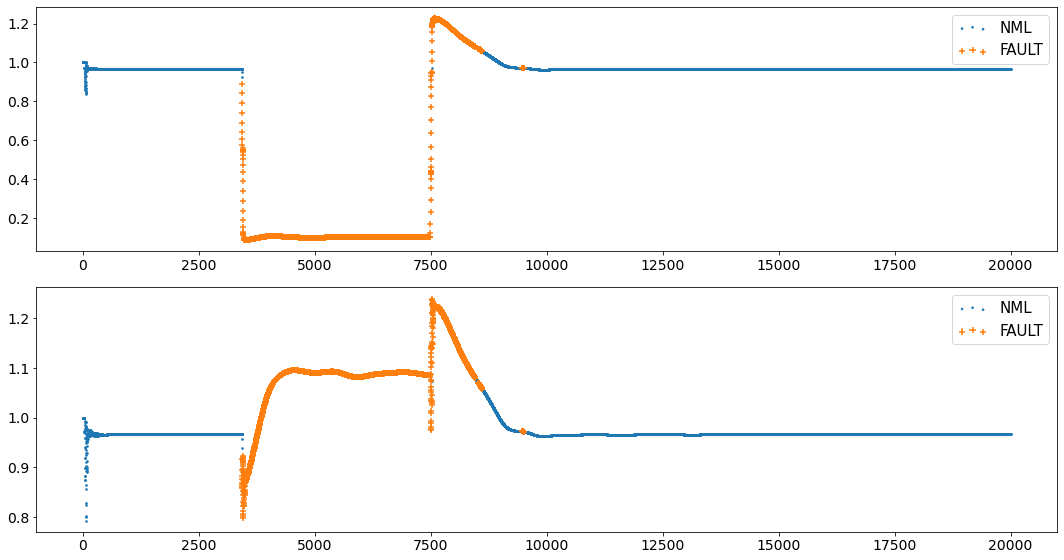

  Fault type Percentage
0         AB     81.25%
1        ABC     15.16%
2         BC       3.5%
3        ABG      0.08%
4       ABCG      0.02%


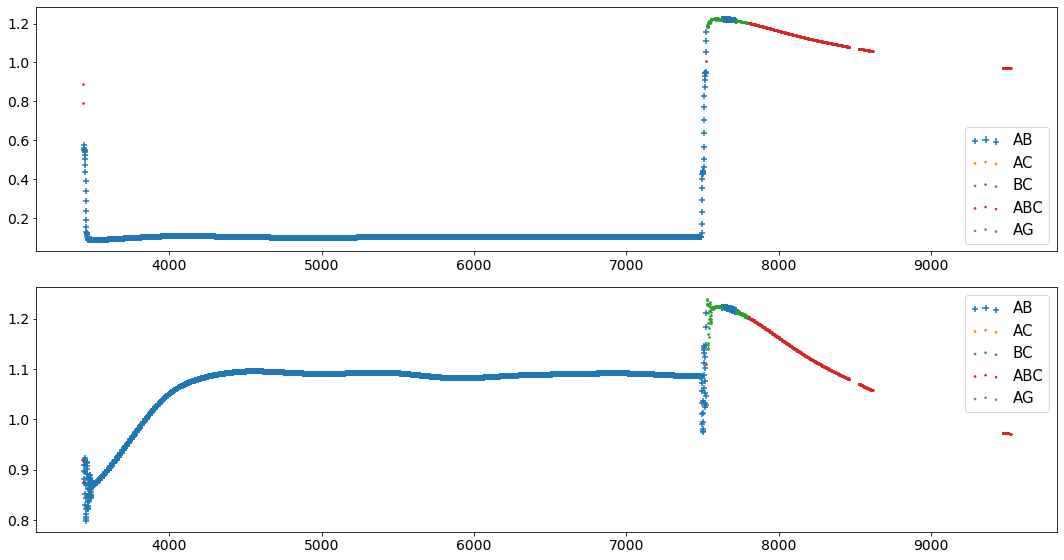


.
.
 9ACG.csv
  Fault type Percentage
0        NML     78.39%
1      FAULT     21.61%


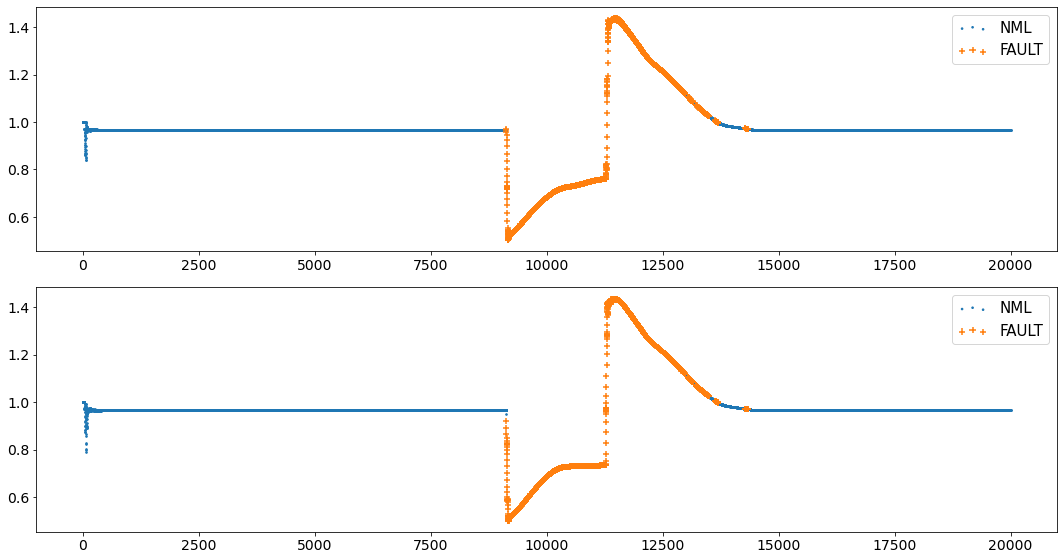

  Fault type Percentage
0        ACG     55.82%
1        ABC     24.61%
2        BCG      7.17%
3         BC      4.95%
4        ABG      4.33%
5         AB       2.2%
6         AC      0.72%
7         AG      0.14%
8         CG      0.07%


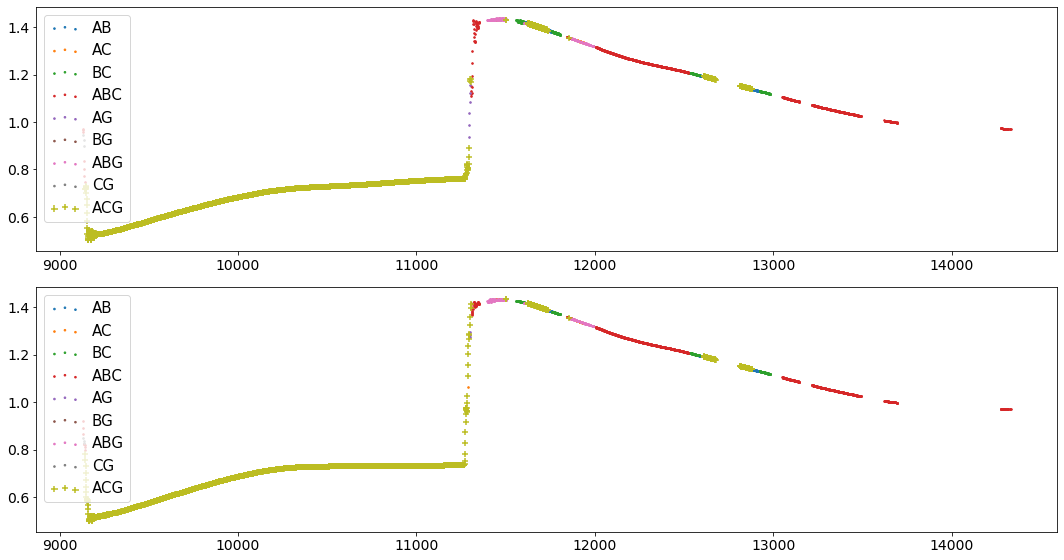


.
.
 9ABC.csv
  Fault type Percentage
0      FAULT     52.12%
1        NML     47.88%


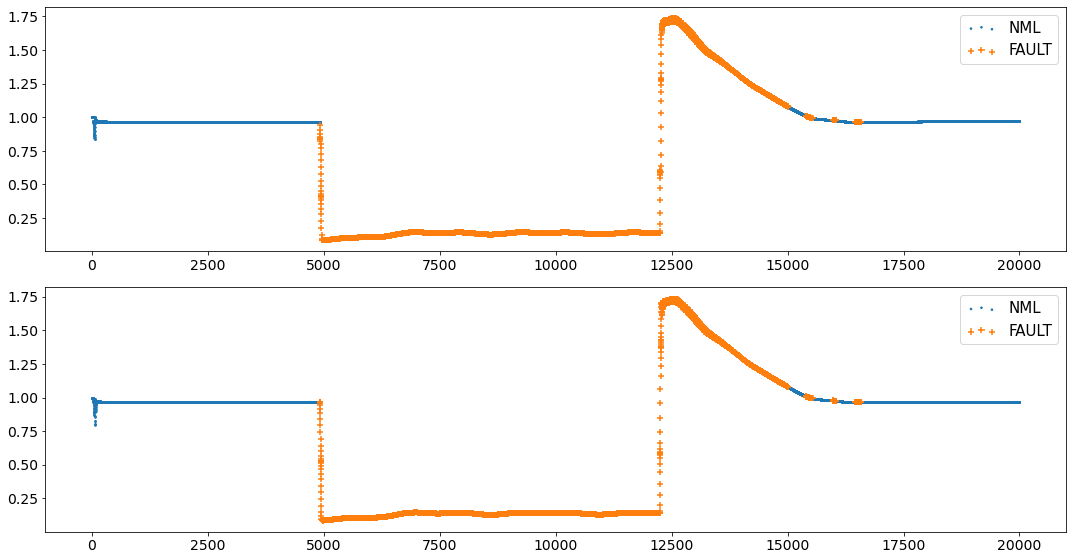

  Fault type Percentage
0        ABC     86.79%
1        BCG       7.0%
2        ABG      4.13%
3        ACG      0.84%
4         AC      0.77%
5         BC      0.47%


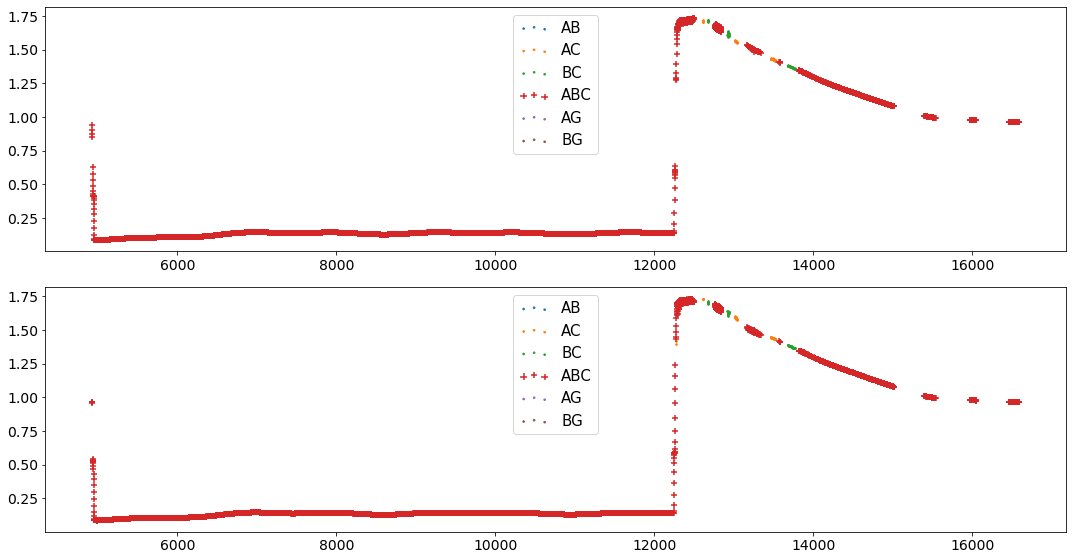


.
.
 5BC.csv
  Fault type Percentage
0        NML     99.55%
1      FAULT      0.45%


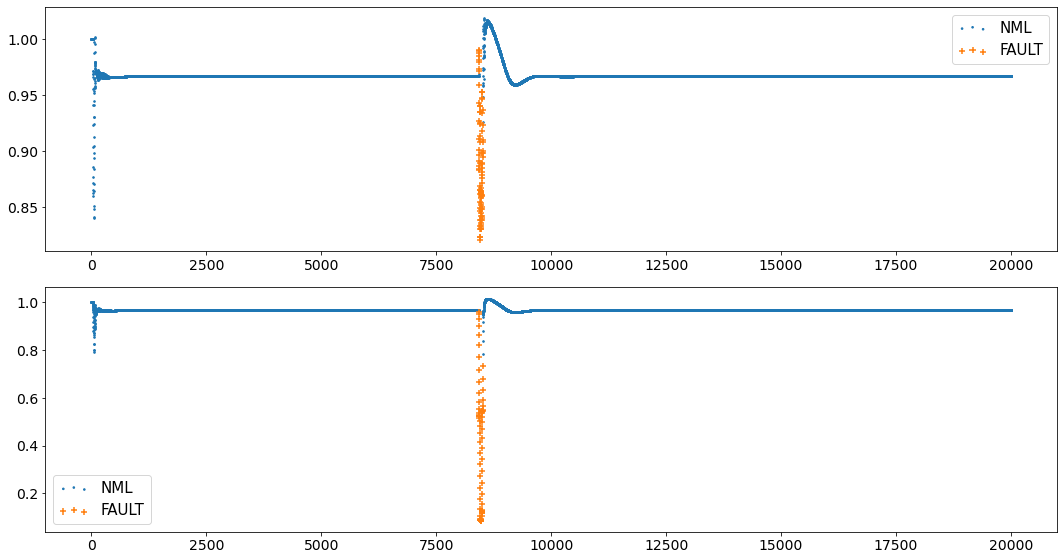

  Fault type Percentage
0         BC     81.11%
1        BCG      10.0%
2        ABC      3.33%
3         AB      2.22%
4        ACG      2.22%
5        ABG      1.11%


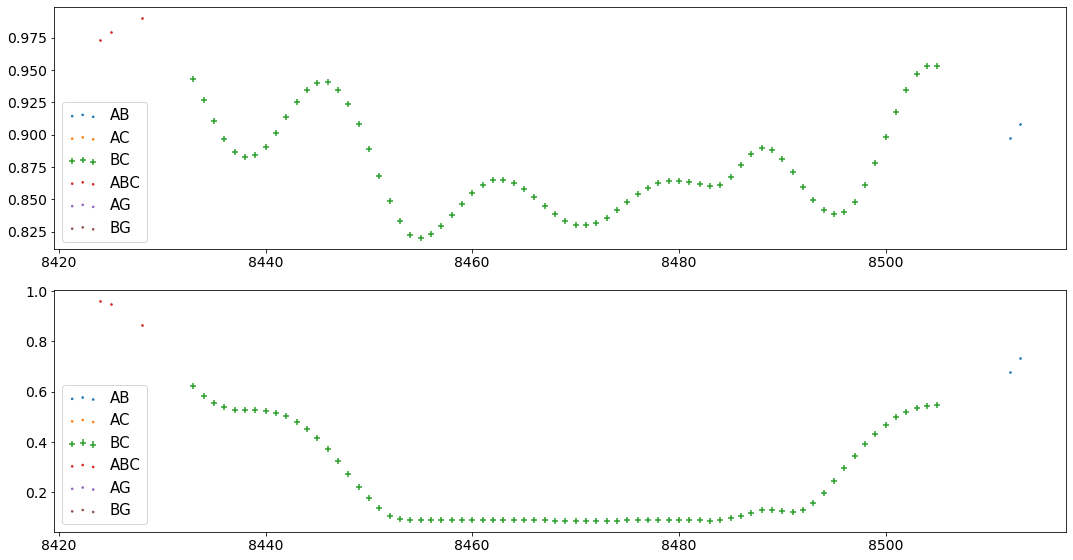


.
.
 5CG.csv
  Fault type Percentage
0        NML     75.19%
1      FAULT      24.8%


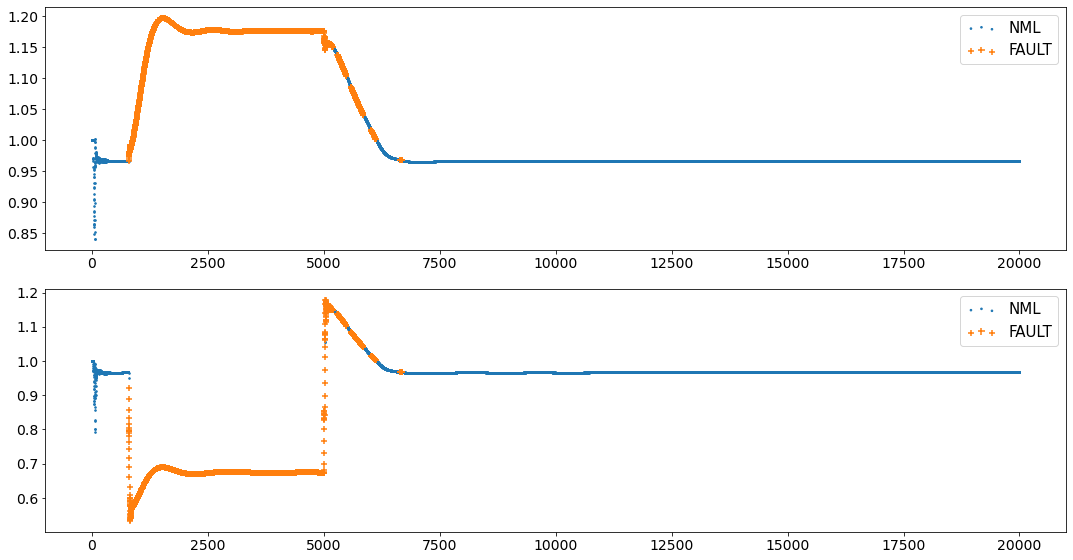

  Fault type Percentage
0         CG     85.31%
1        ABC     11.45%
2         BC       3.2%
3        ACG      0.04%


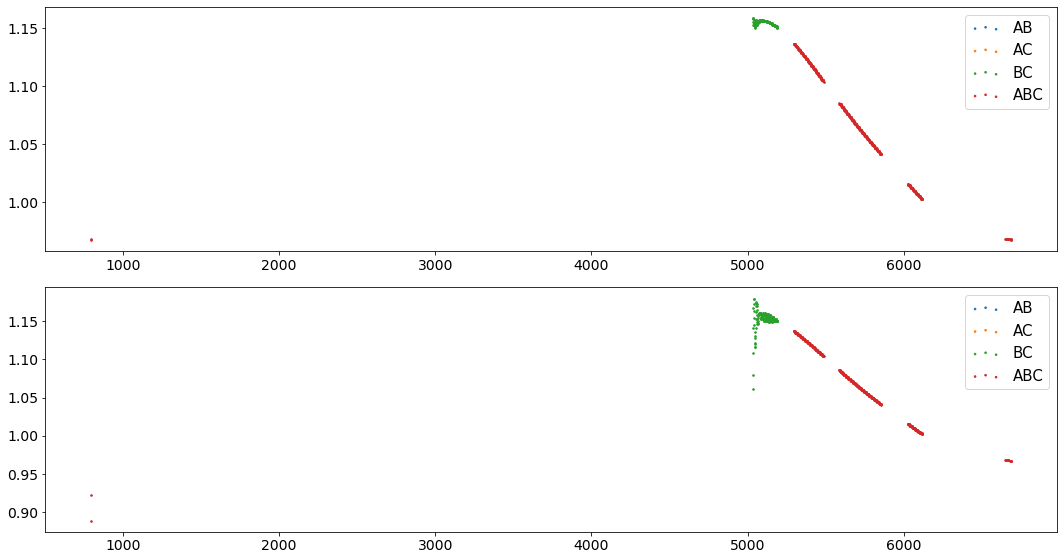


.
.
 4ABCG.csv
  Fault type Percentage
0        NML     66.64%
1      FAULT     33.37%


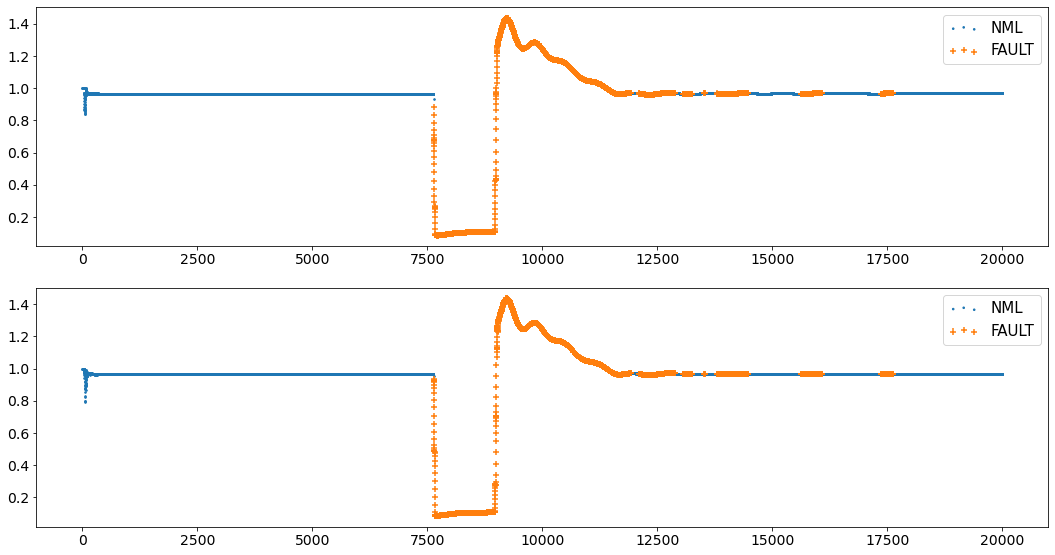

  Fault type Percentage
0        ABC     99.64%
1       ABCG      0.13%
2        ACG      0.13%
3        ABG      0.09%


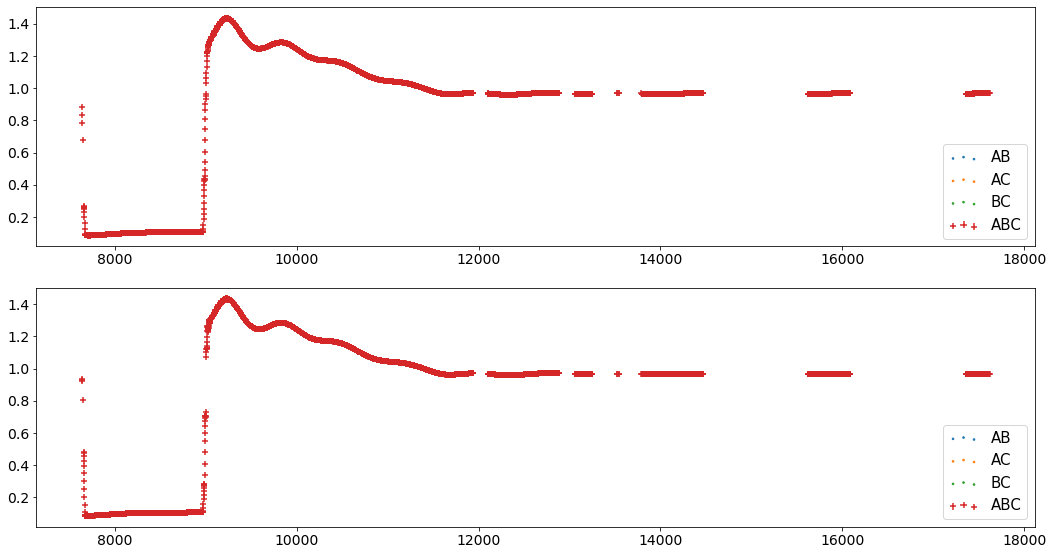


.
.
 7BC.csv
  Fault type Percentage
0        NML     99.14%
1      FAULT      0.86%


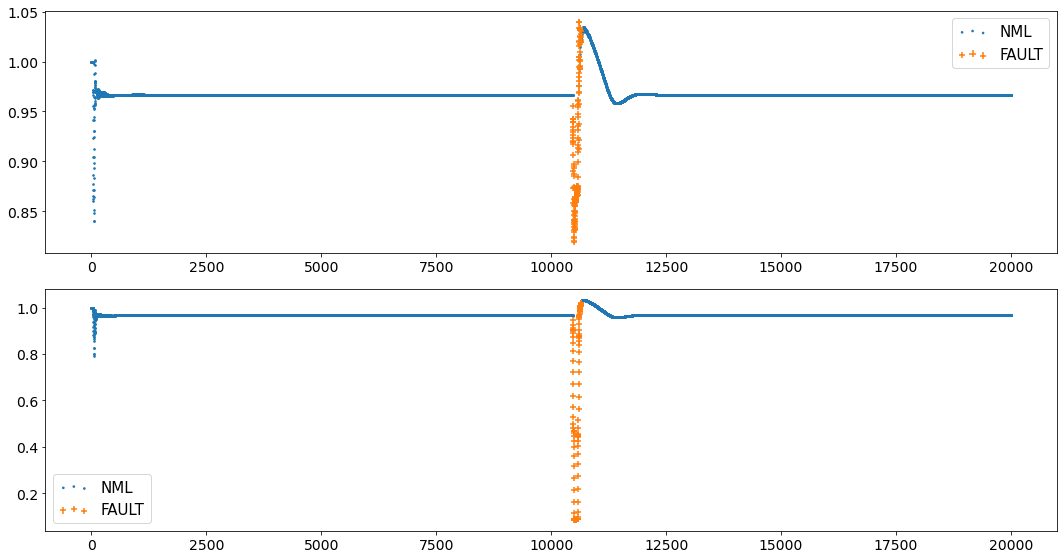

  Fault type Percentage
0         BC     60.69%
1        ABC     24.86%
2        BCG     14.45%


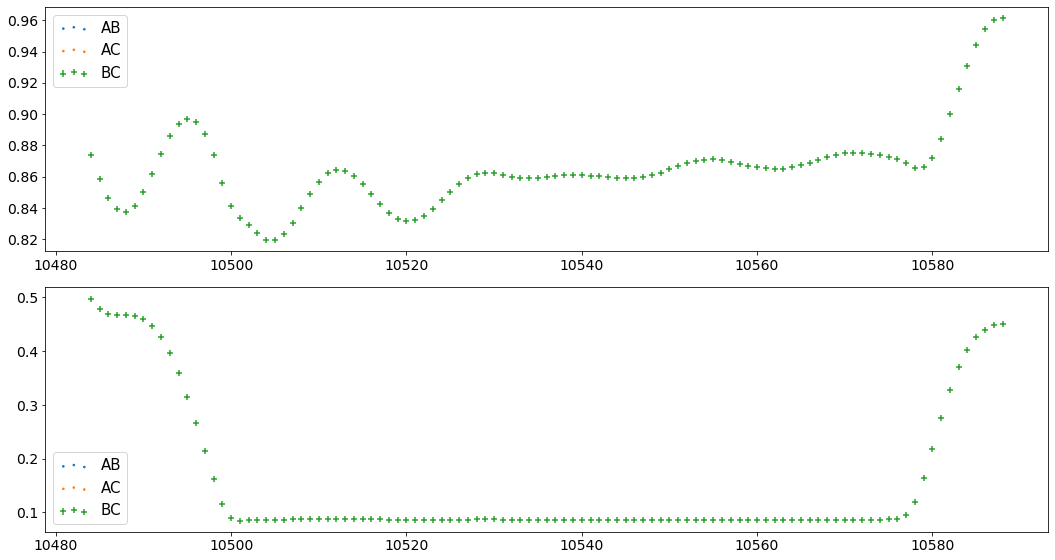


.
.
 7CG.csv
  Fault type Percentage
0        NML      75.3%
1      FAULT      24.7%


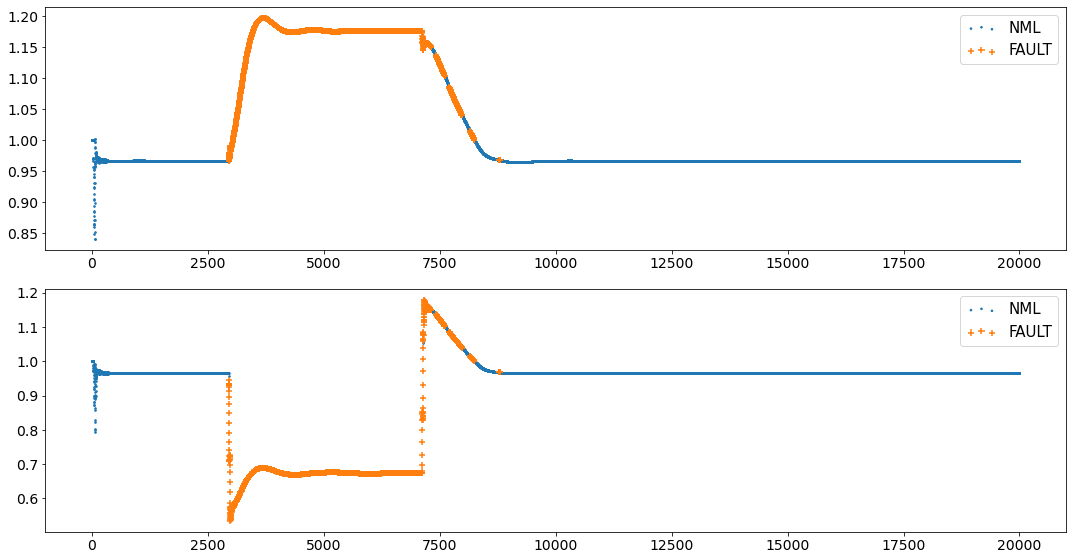

  Fault type Percentage
0         CG     84.74%
1        ABC     11.78%
2         BC      3.44%
3        ACG      0.04%


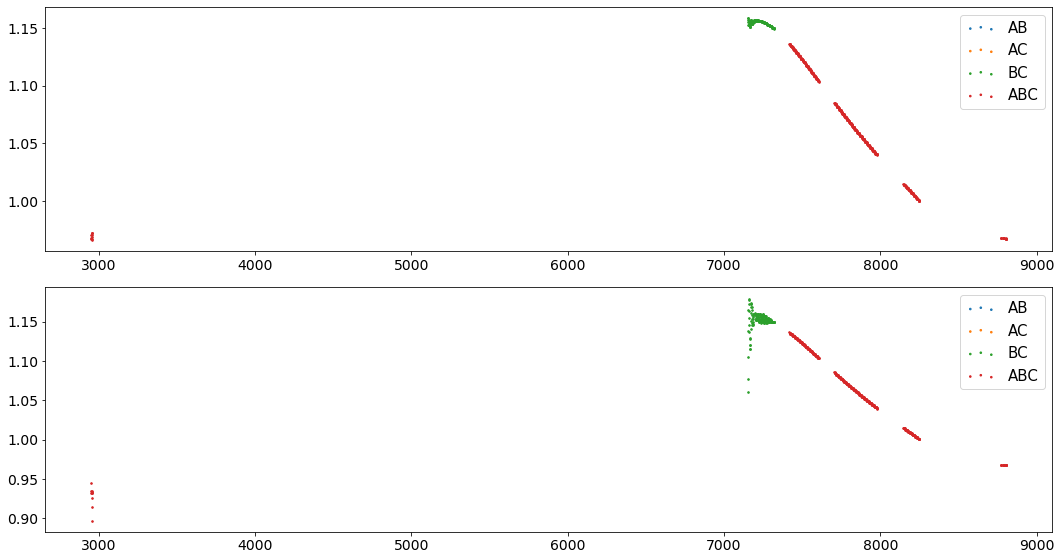


.
.
 10ACG.csv
  Fault type Percentage
0        NML     76.56%
1      FAULT     23.45%


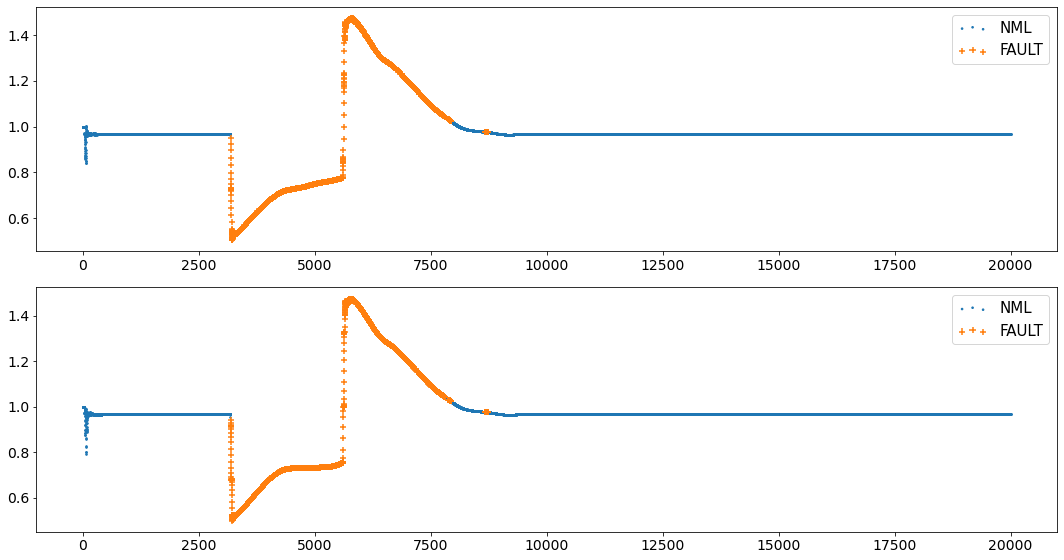

  Fault type Percentage
0        ACG     56.26%
1        ABC     27.79%
2        BCG      8.13%
3        ABG       3.2%
4         BC      2.99%
5         AB      0.77%
6         AC      0.58%
7         CG      0.13%
8       ABCG      0.11%
9         AG      0.06%


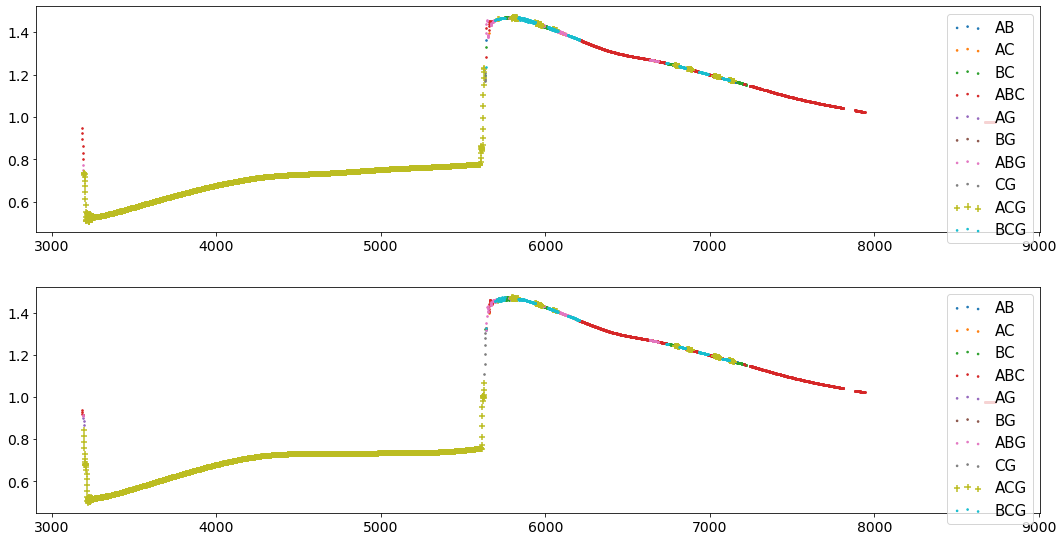


.
.
 3BG.csv
  Fault type Percentage
0        NML     90.34%
1      FAULT      9.65%


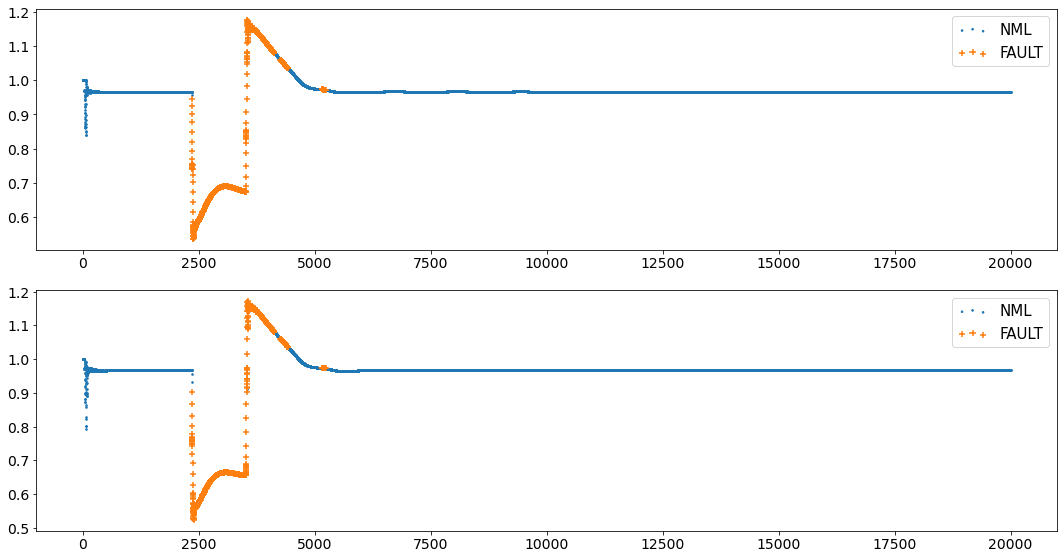

  Fault type Percentage
0         BG     61.42%
1        ABC      37.6%
2         BC      0.57%
3        ACG      0.31%
4        BCG       0.1%


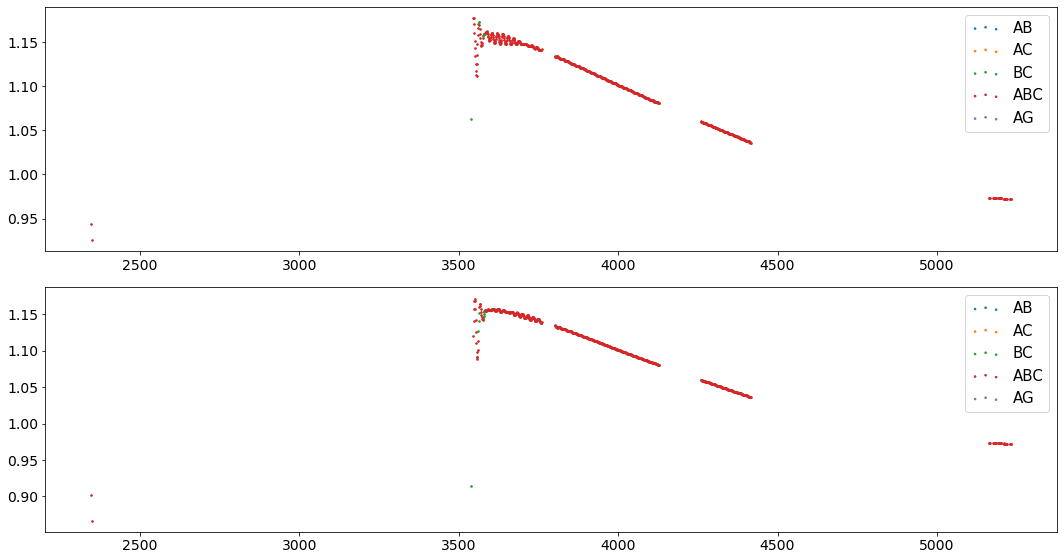


.
.
 10ABC.csv
  Fault type Percentage
0        NML     69.09%
1      FAULT     30.91%


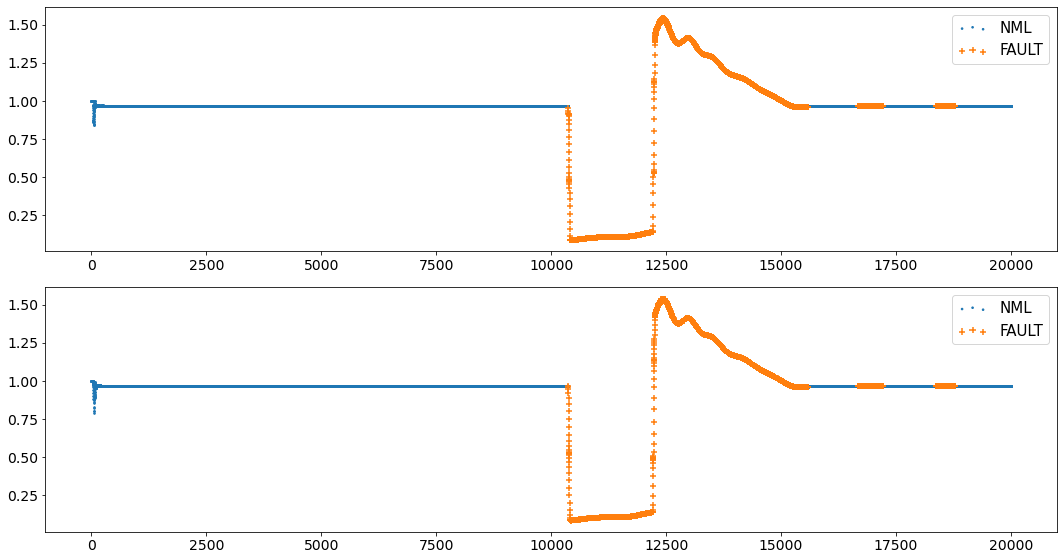

  Fault type Percentage
0        ABC     99.71%
1        BCG      0.13%
2        ACG      0.13%
3       ABCG      0.03%


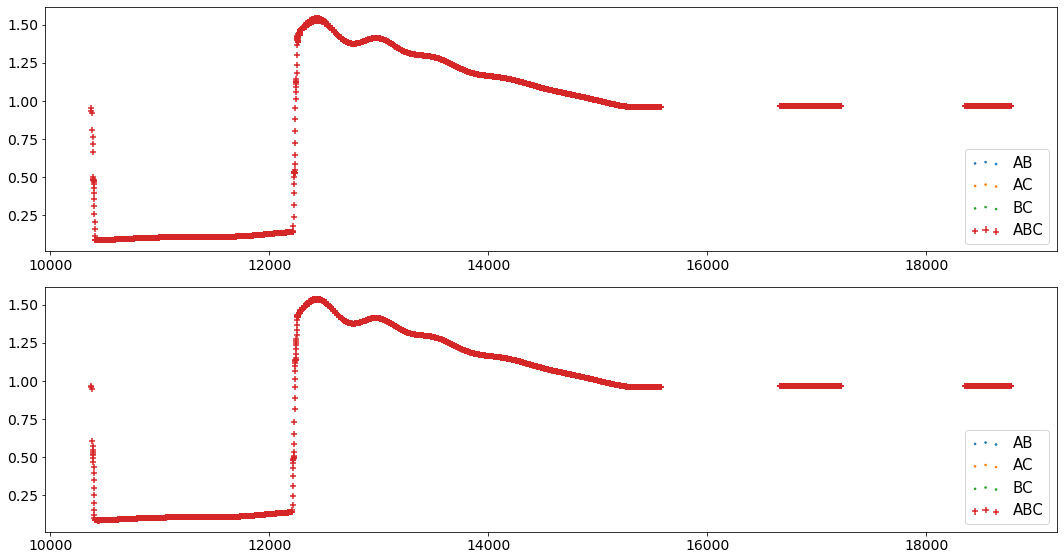


.
.
 3BCG.csv
  Fault type Percentage
0        NML     78.47%
1      FAULT     21.52%


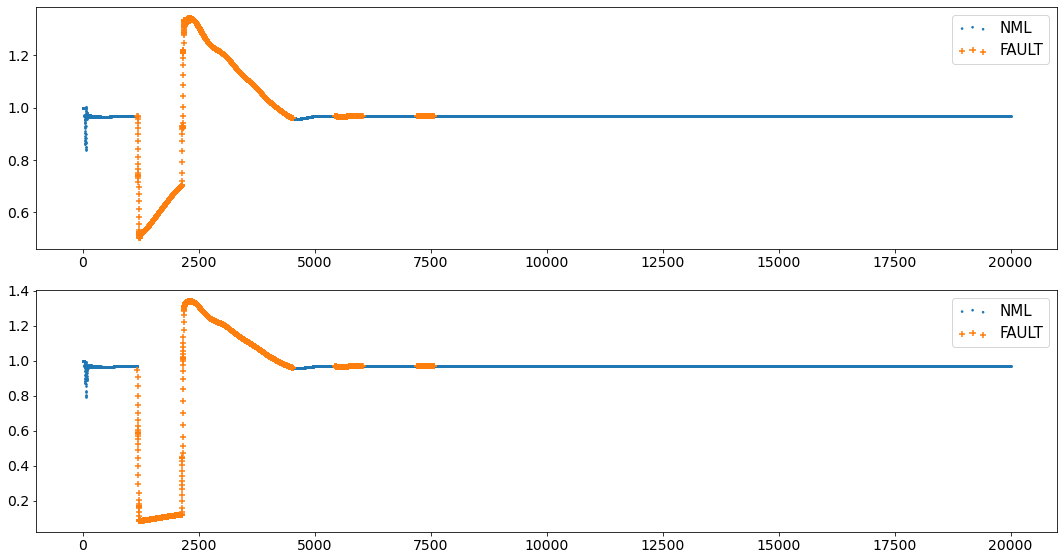

  Fault type Percentage
0        ABC     75.15%
1        BCG     24.81%
2         BC      0.05%


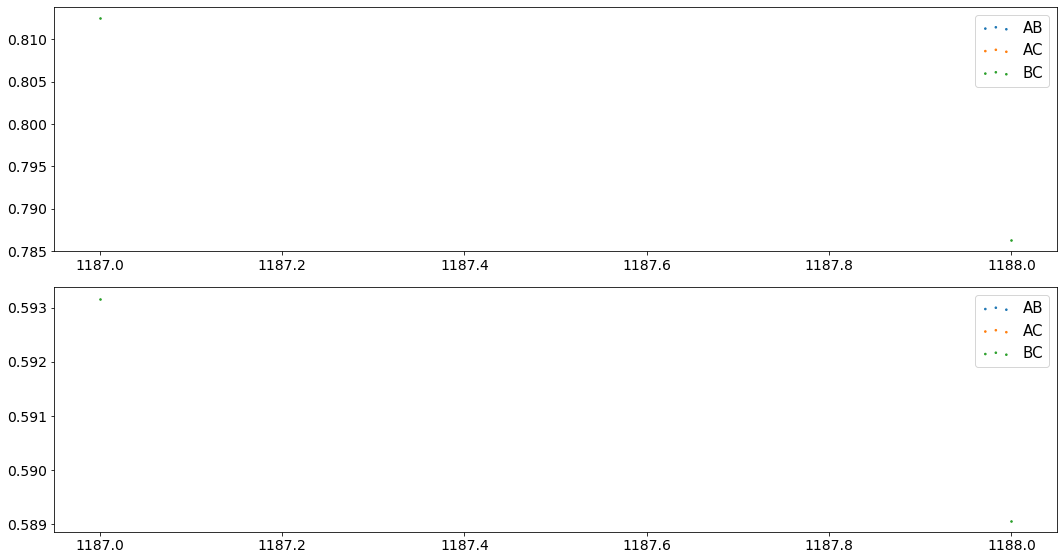


.
.
 4BG.csv
  Fault type Percentage
0        NML     70.42%
1      FAULT     29.58%


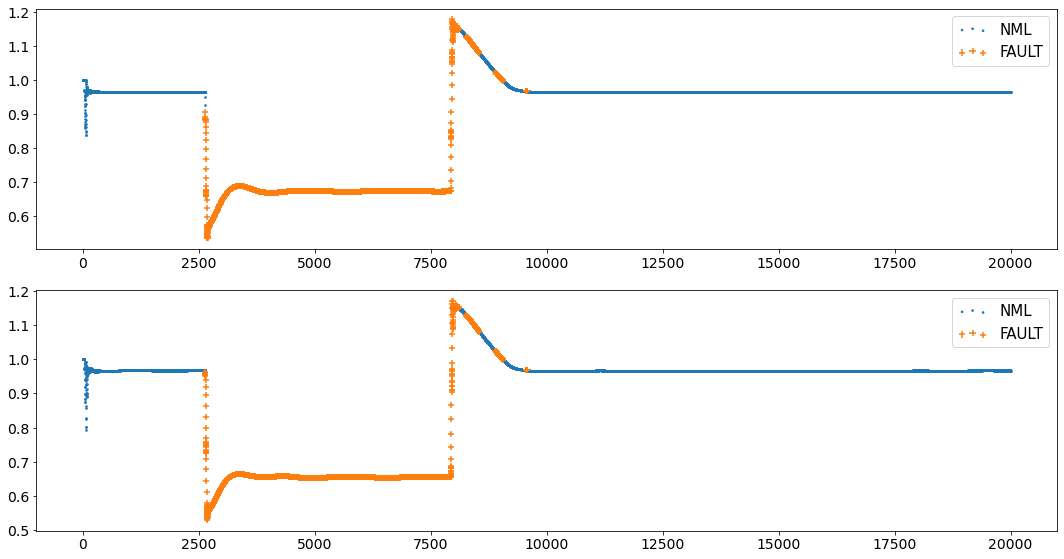

  Fault type Percentage
0         BG     89.71%
1        ABC      7.88%
2         BC       2.2%
3        ABG      0.12%
4        ACG      0.05%
5        BCG      0.05%


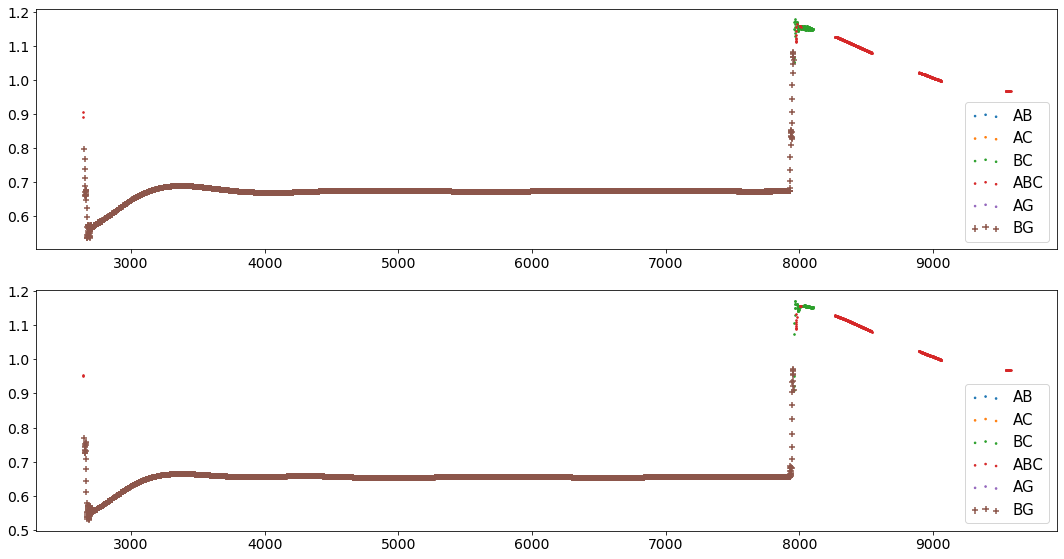


.
.
 1ABC.csv
  Fault type Percentage
0      FAULT     50.48%
1        NML     49.52%


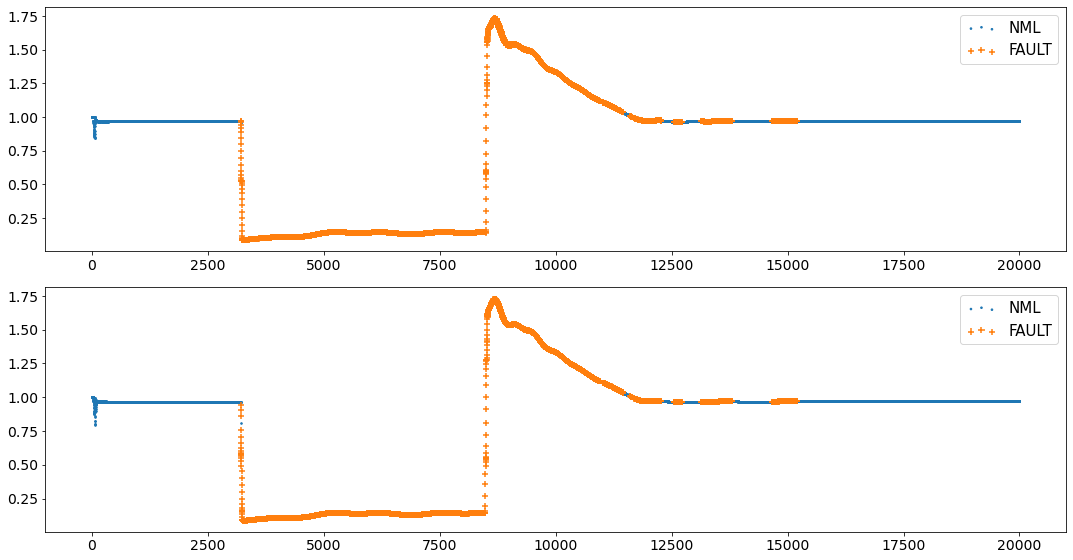

  Fault type Percentage
0        ABC     87.27%
1        ABG      3.22%
2        BCG      3.12%
3         AB      3.03%
4         BC      1.84%
5        ACG      0.91%
6         AC      0.55%
7       ABCG      0.05%


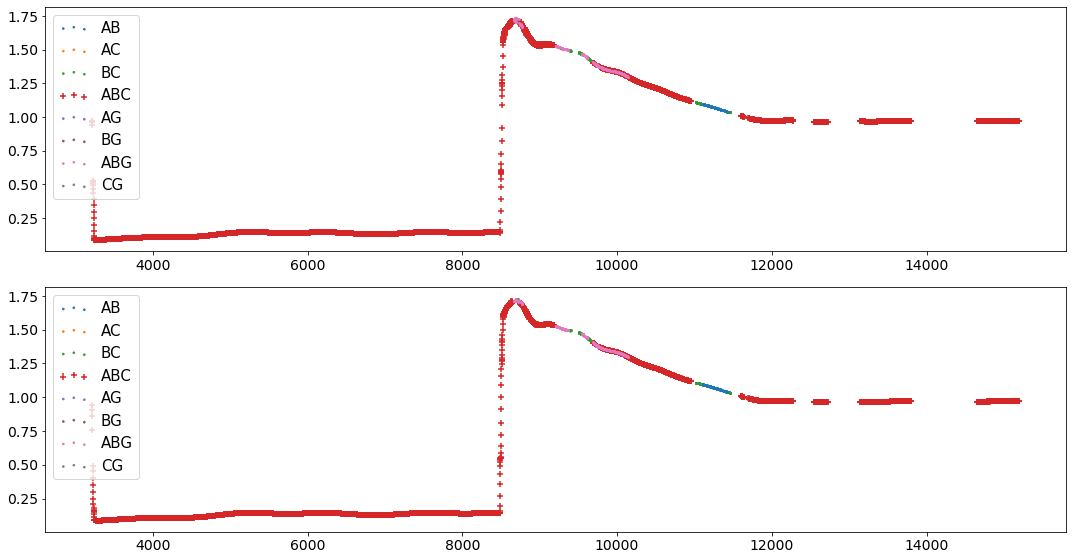


.
.
 1ACG.csv
  Fault type Percentage
0        NML     78.49%
1      FAULT     21.51%


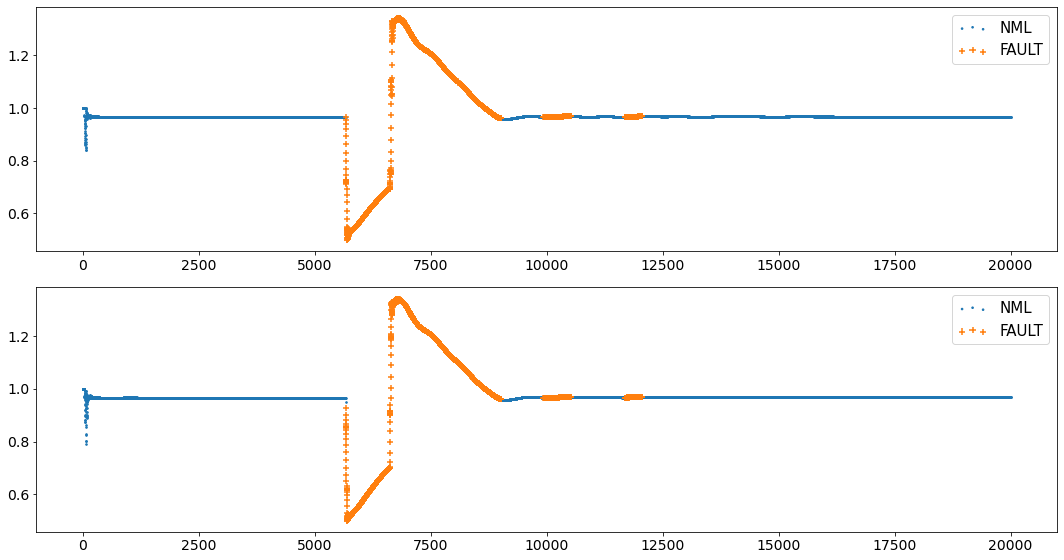

  Fault type Percentage
0        ABC     75.01%
1        ACG     22.69%
2        BCG      2.28%
3         BC      0.02%


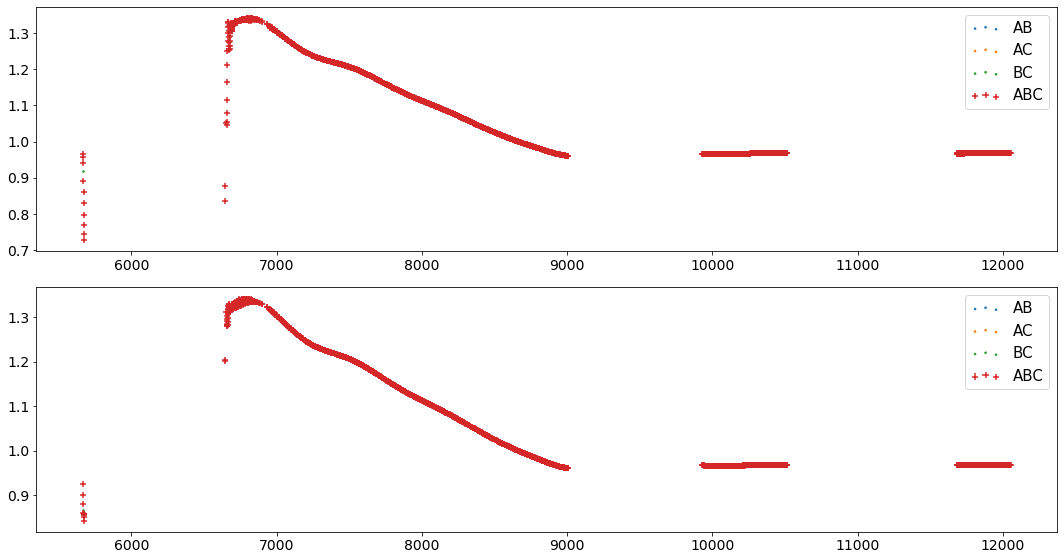


.
.
 8AG.csv
  Fault type Percentage
0        NML     91.27%
1      FAULT      8.73%


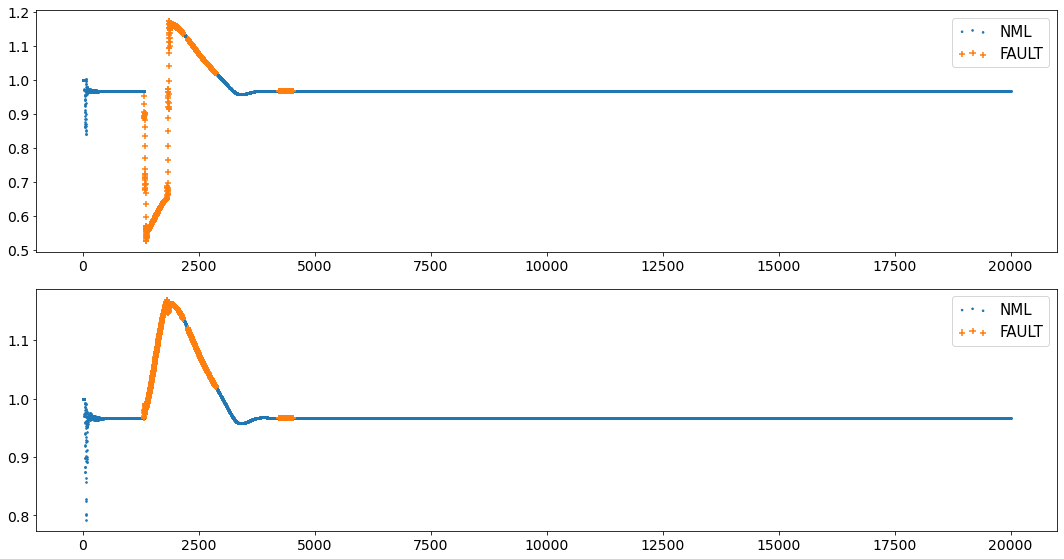

  Fault type Percentage
0        ABC     70.05%
1         AG     29.67%
2        ACG      0.23%
3        ABG      0.06%


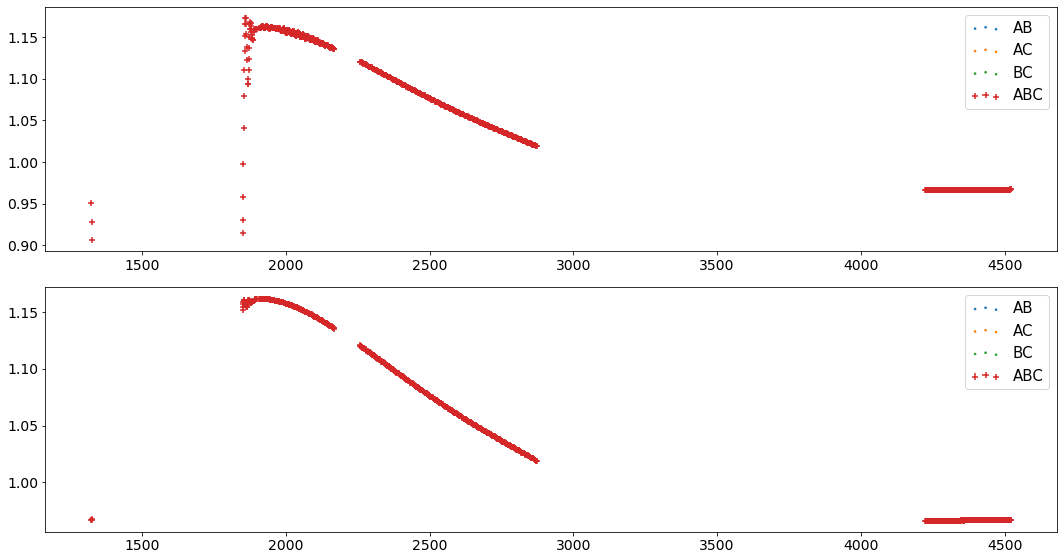


.
.
 3ABG.csv
  Fault type Percentage
0        NML     89.49%
1      FAULT     10.51%


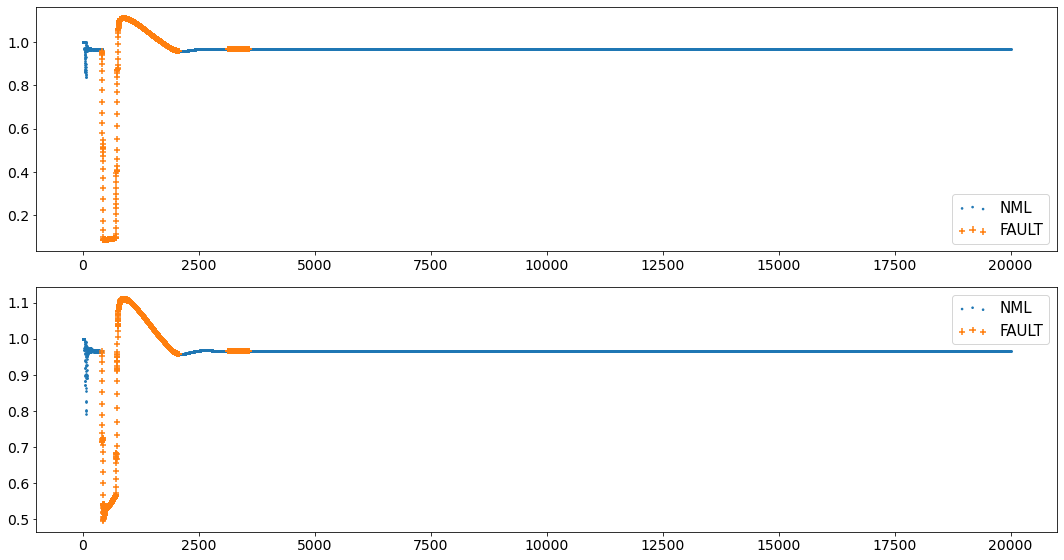

  Fault type Percentage
0        ABC     84.35%
1        ABG     15.13%
2        ACG      0.29%
3         AG      0.14%
4        BCG       0.1%


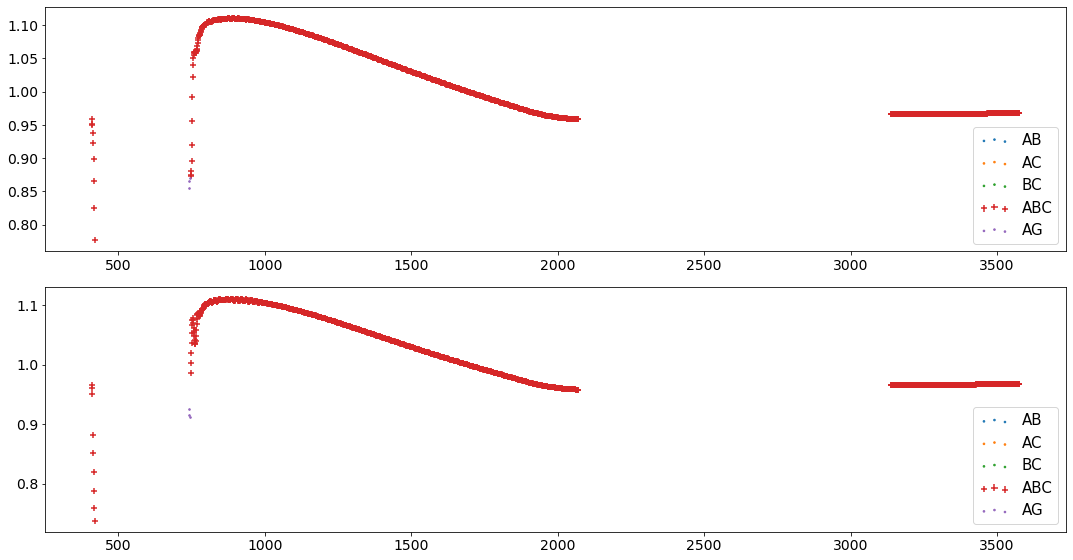


.
.
 10AC.csv
  Fault type Percentage
0        NML     88.28%
1      FAULT     11.72%


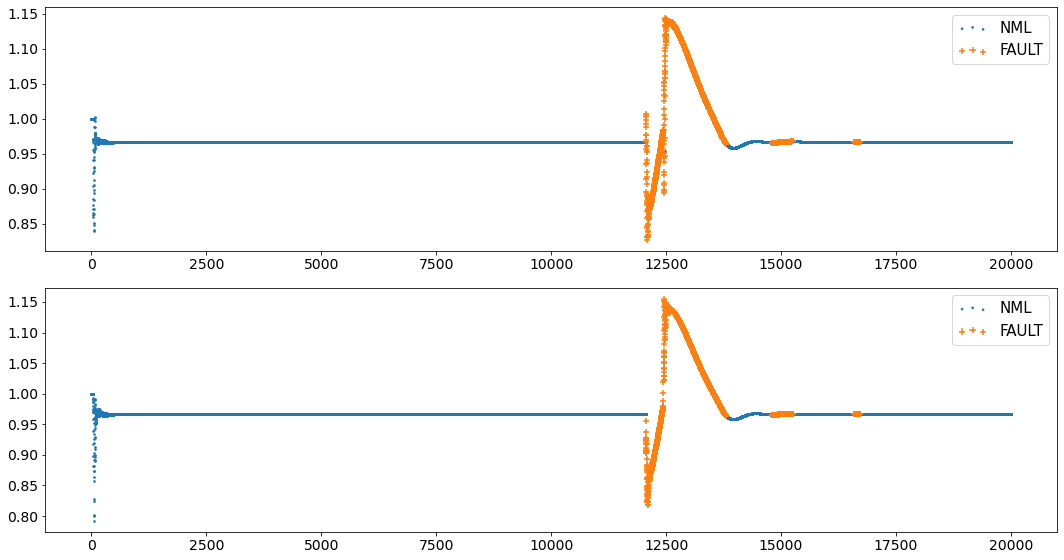

  Fault type Percentage
0        ABC     82.86%
1         AC     15.74%
2        ACG      1.41%


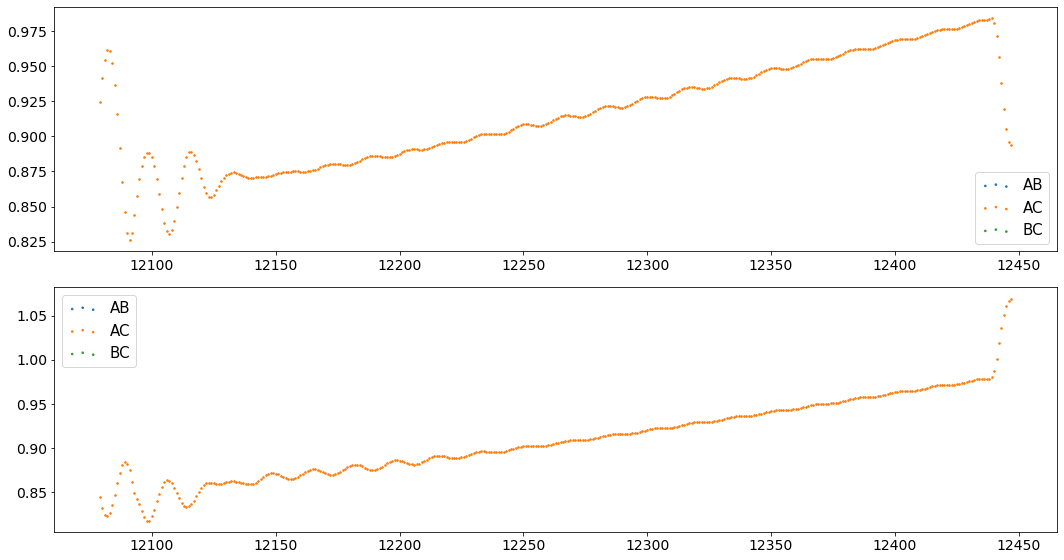


.
.
 7BCG.csv
  Fault type Percentage
0        NML     77.28%
1      FAULT     22.72%


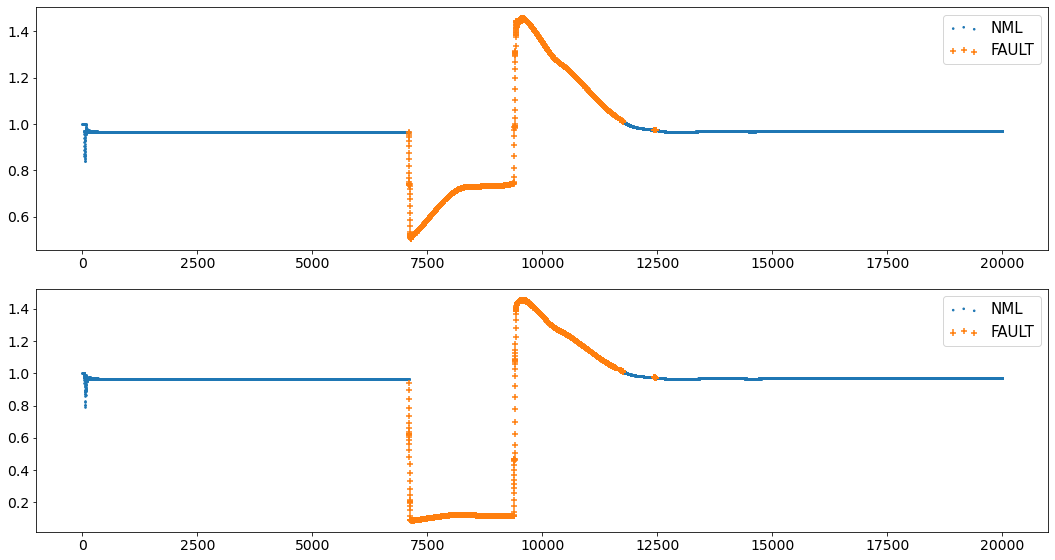

  Fault type Percentage
0        BCG     61.09%
1        ABC     25.81%
2        ABG      4.18%
3        ACG      3.72%
4         BC      3.46%
5         AB      1.06%
6         AC      0.64%
7         BG      0.04%


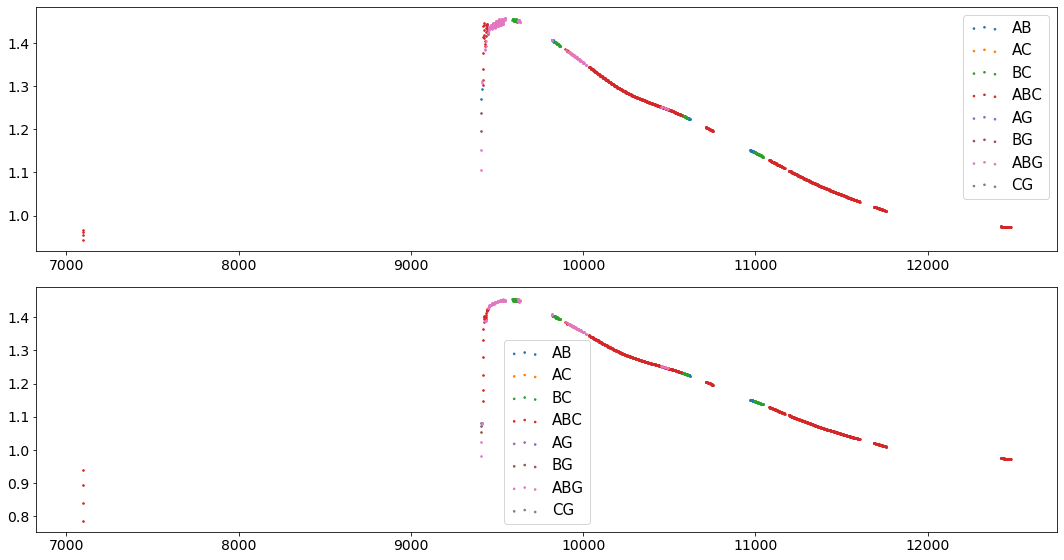


.
.
 6ABCG.csv
  Fault type Percentage
0        NML     70.19%
1      FAULT     29.82%


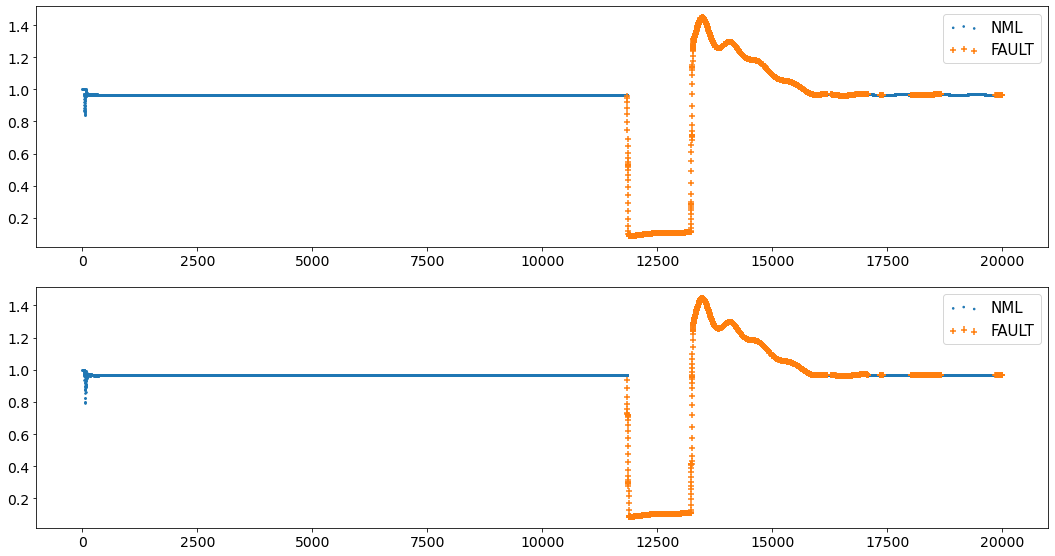

  Fault type Percentage
0        ABC     99.77%
1        BCG       0.2%
2        ABG      0.03%


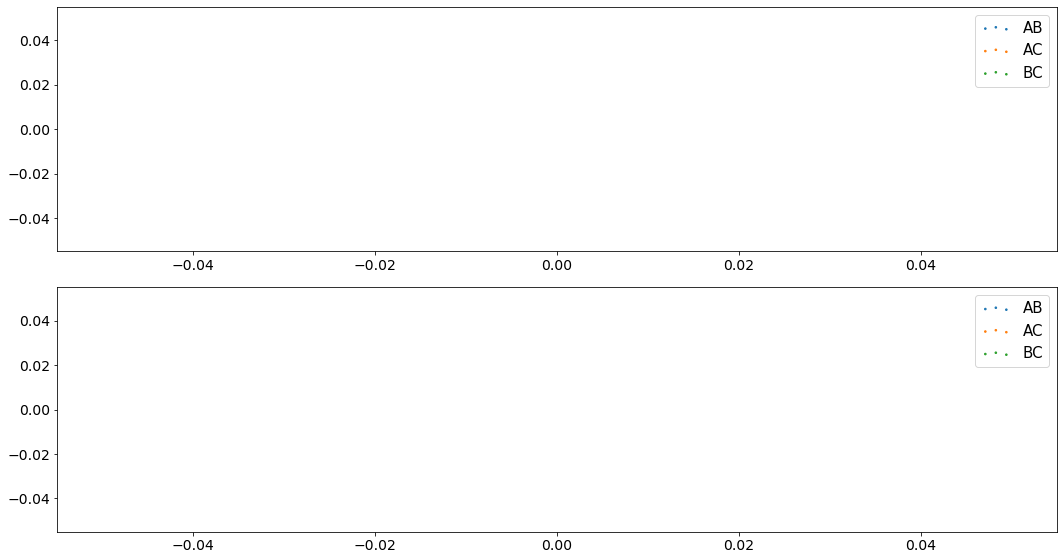


.
.
 6BG.csv
  Fault type Percentage
0        NML     77.97%
1      FAULT     22.02%


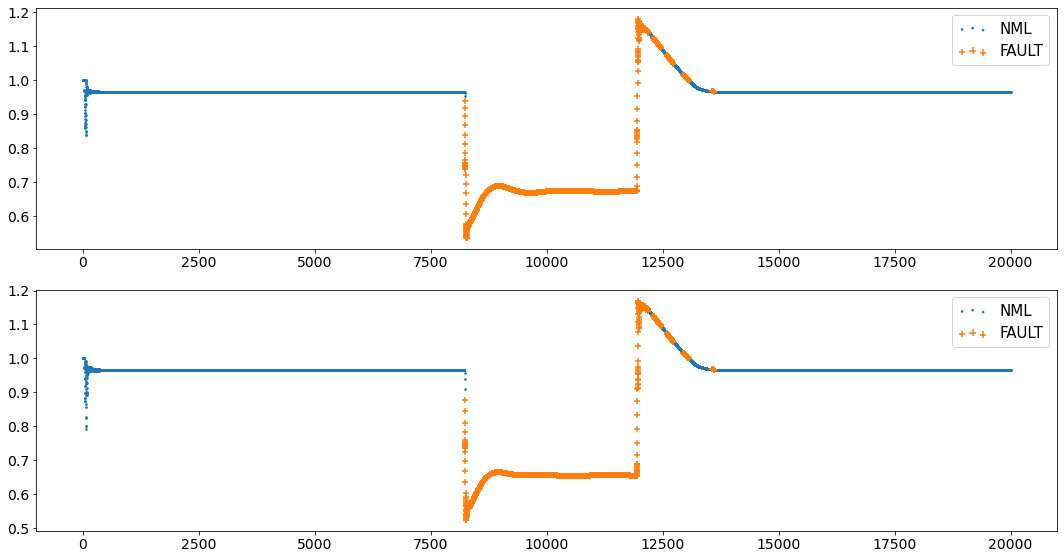

  Fault type Percentage
0         BG     84.74%
1        ABC     10.06%
2         BC      5.06%
3        ACG      0.09%
4        BCG      0.05%


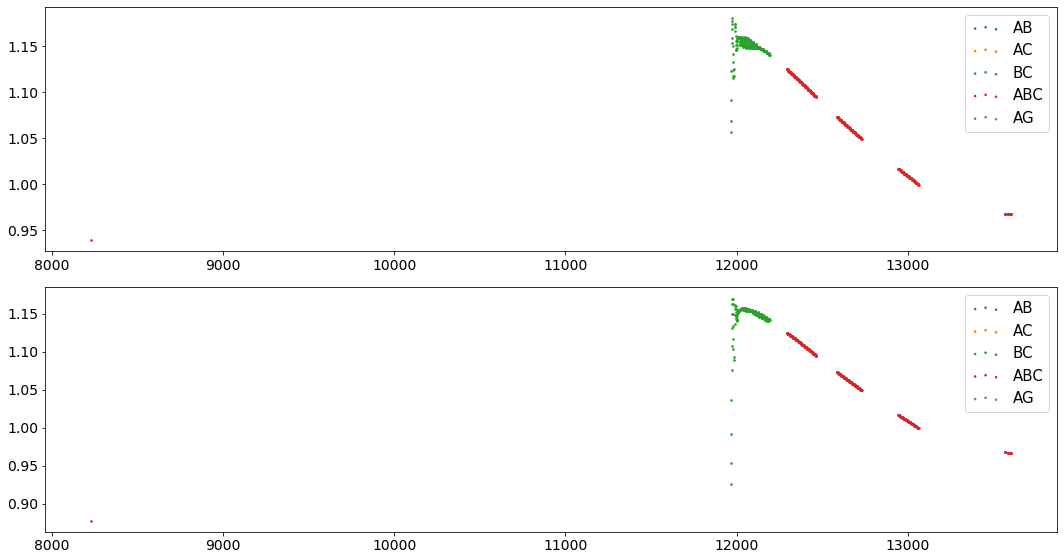


.
.
 10AB.csv
  Fault type Percentage
0        NML     91.56%
1      FAULT      8.44%


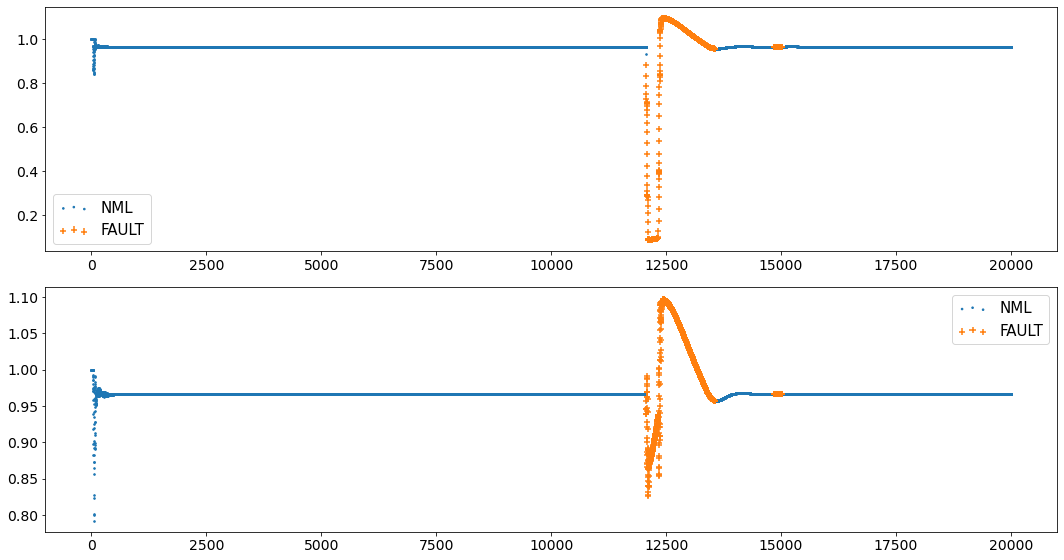

  Fault type Percentage
0        ABC     82.88%
1         AB     15.76%
2        ABG       1.3%
3       ABCG      0.06%


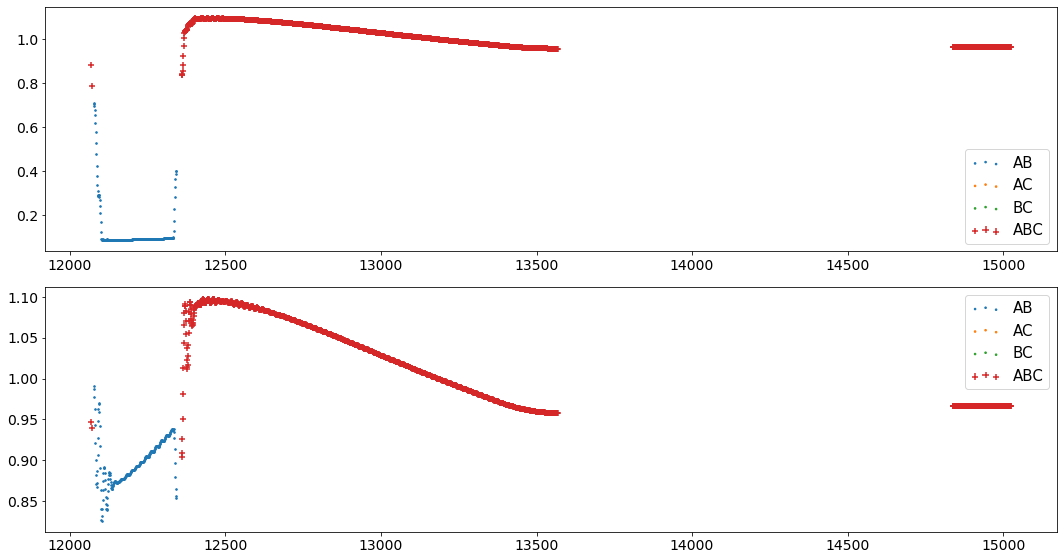


.
.
 2BC.csv
  Fault type Percentage
0        NML     89.39%
1      FAULT     10.62%


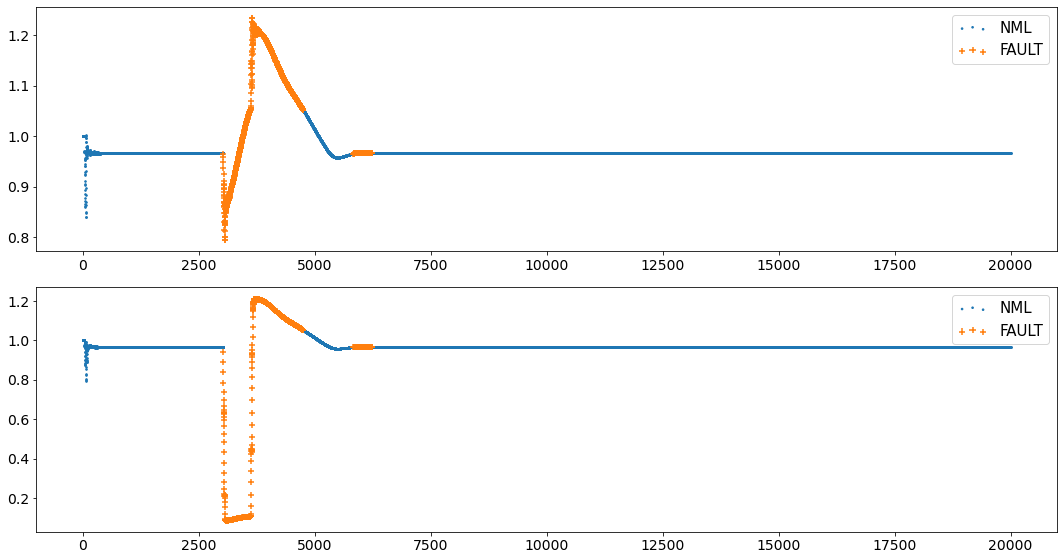

  Fault type Percentage
0        ABC      70.7%
1         BC     28.31%
2        BCG      0.99%


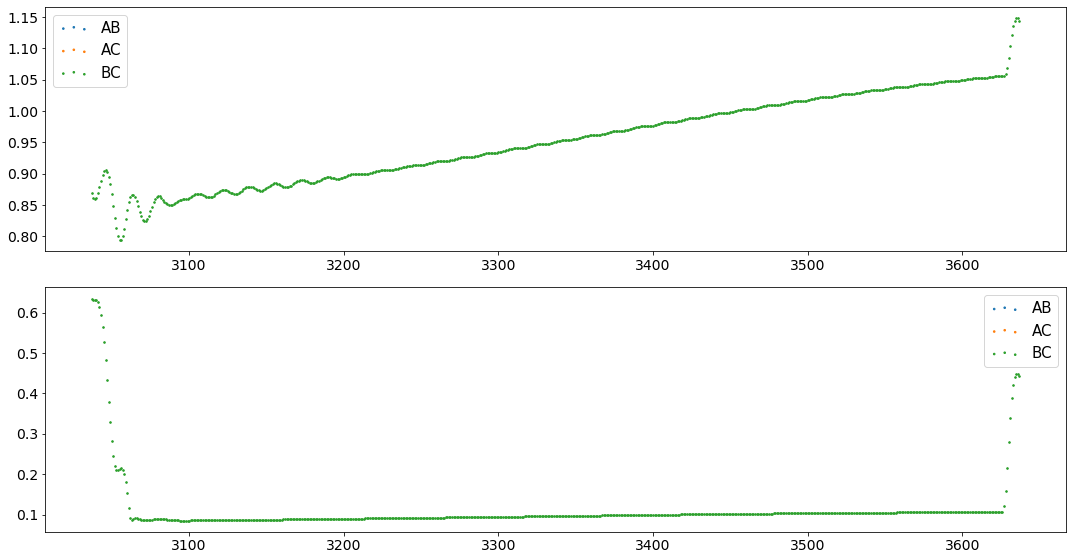


.
.
 2CG.csv
  Fault type Percentage
0        NML     70.95%
1      FAULT     29.05%


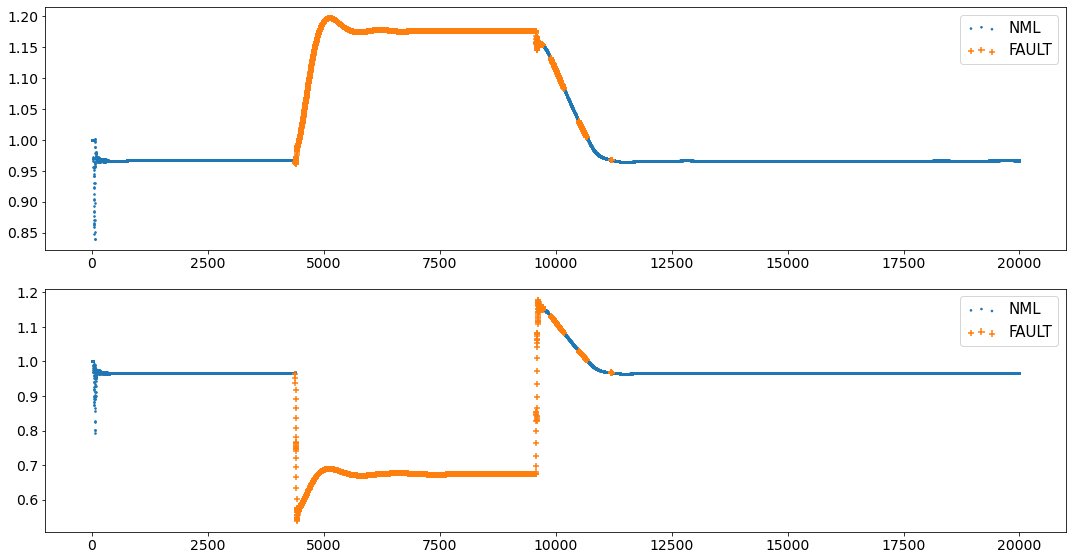

  Fault type Percentage
0         CG     89.69%
1        ABC      8.28%
2         BC      1.98%
3        ACG      0.03%
4       ABCG      0.02%


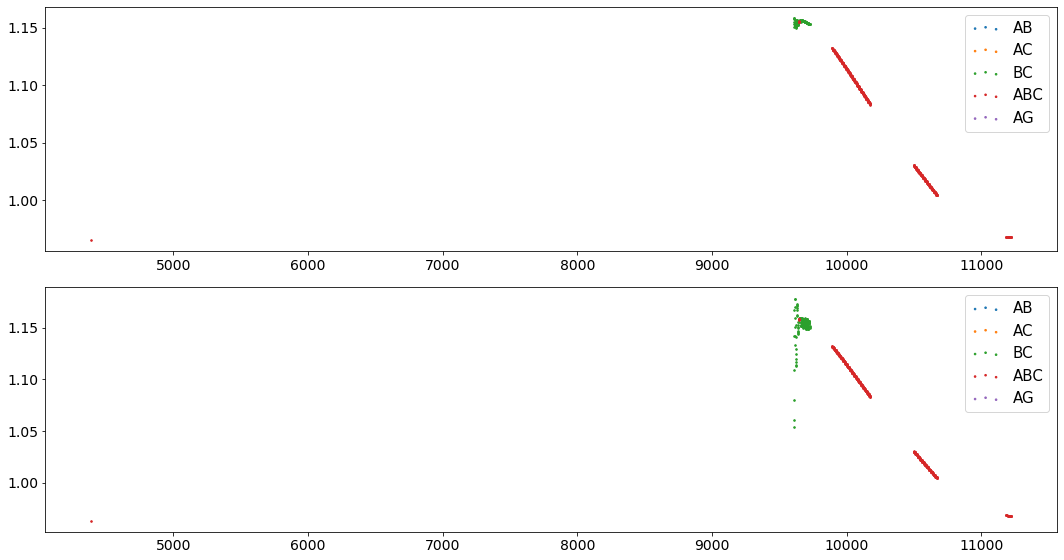


.
.
 5BCG.csv
  Fault type Percentage
0        NML     64.86%
1      FAULT     35.15%


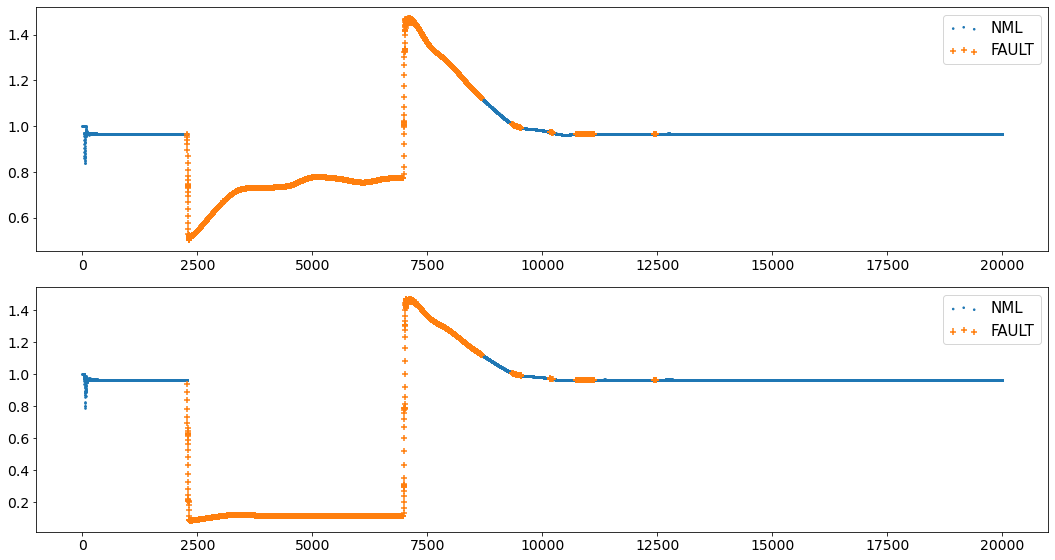

  Fault type Percentage
0        BCG     69.43%
1        ABC     21.23%
2         BC      5.24%
3        ABG      2.42%
4        ACG      0.94%
5         AC      0.44%
6         CG       0.2%
7         AB      0.11%


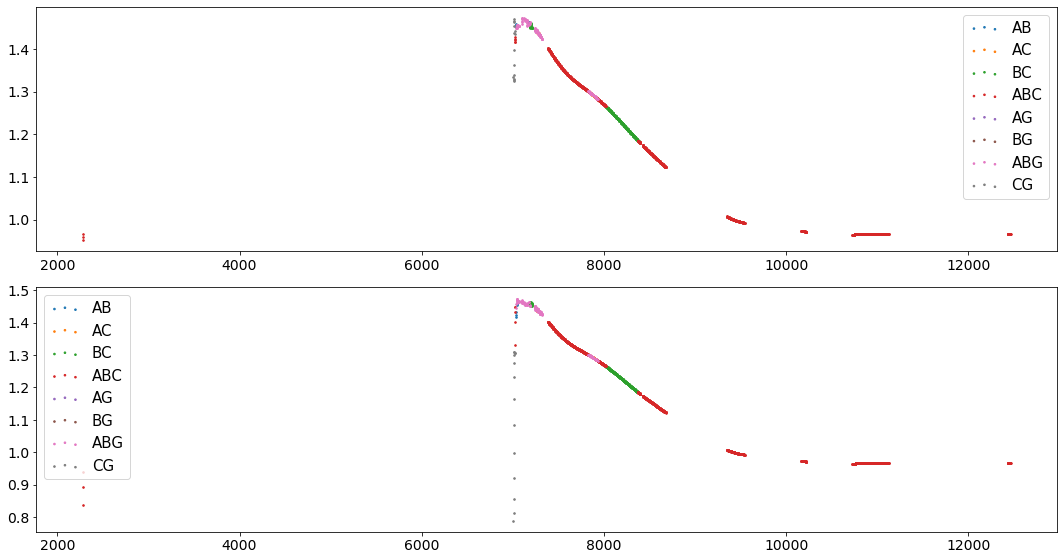


.
.
 2BG.csv
  Fault type Percentage
0        NML     98.76%
1      FAULT      1.24%


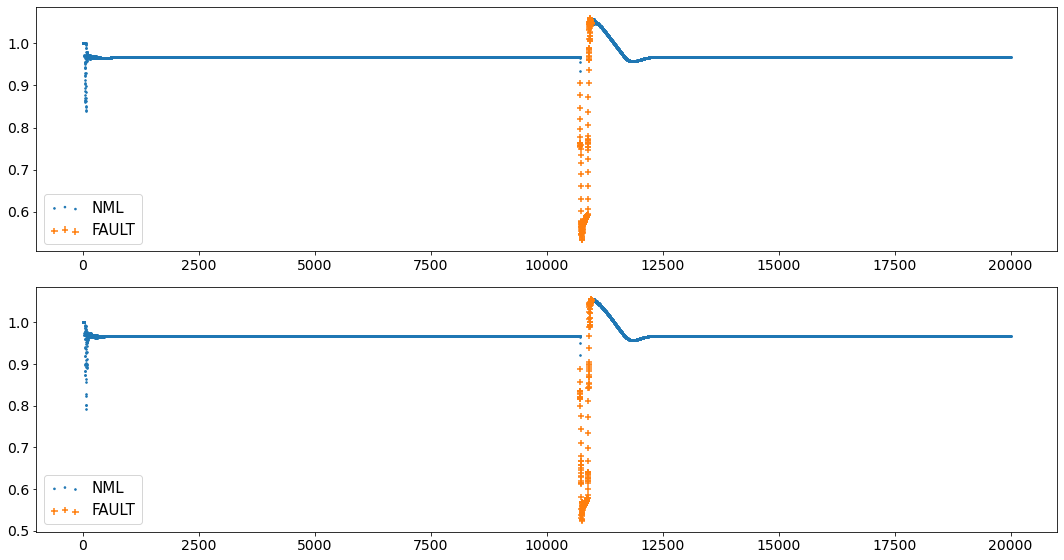

  Fault type Percentage
0         BG     73.39%
1        ABC     22.98%
2        ABG      2.42%
3        BCG      0.81%
4       ABCG       0.4%


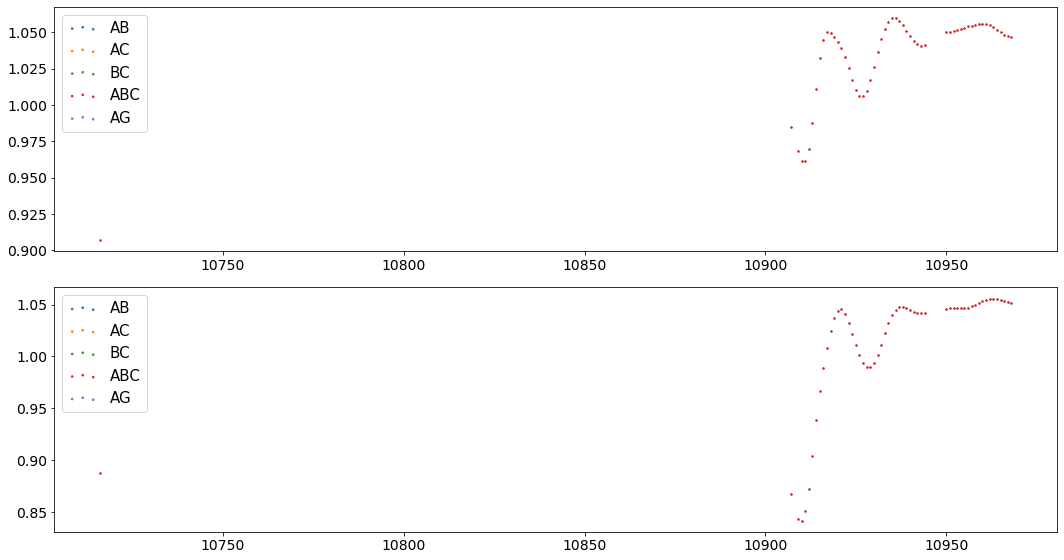


.
.
 6BC.csv
  Fault type Percentage
0        NML     78.61%
1      FAULT     21.39%


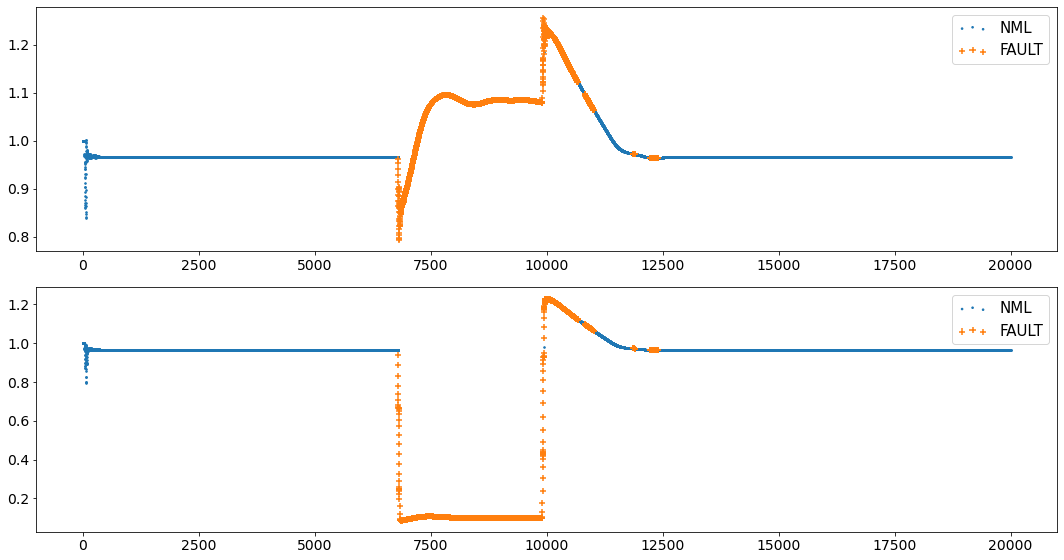

  Fault type Percentage
0         BC     73.32%
1        ABC     26.33%
2        BCG      0.19%
3        ABG      0.12%
4         AB      0.05%


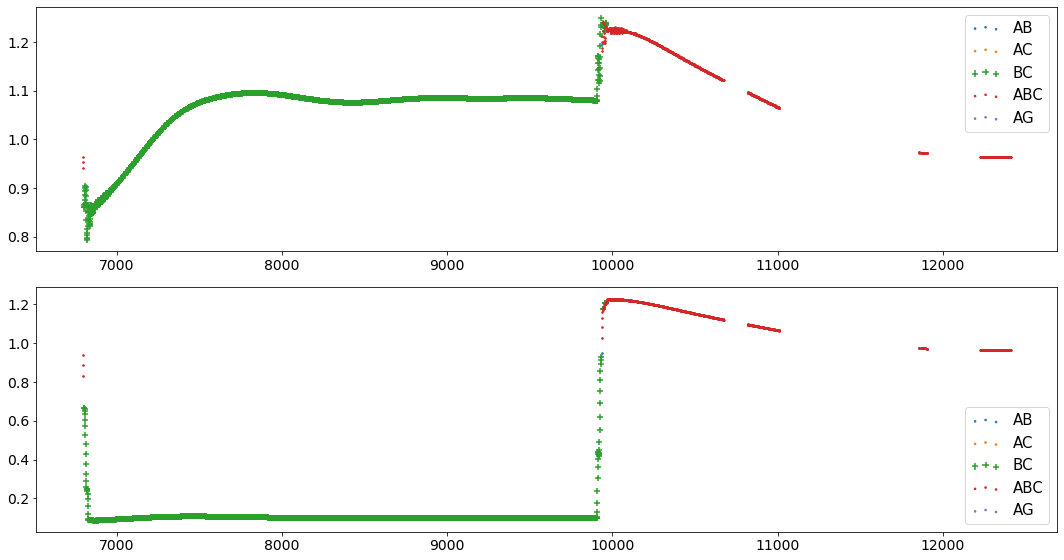


.
.
 6CG.csv
  Fault type Percentage
0        NML     74.53%
1      FAULT     25.47%


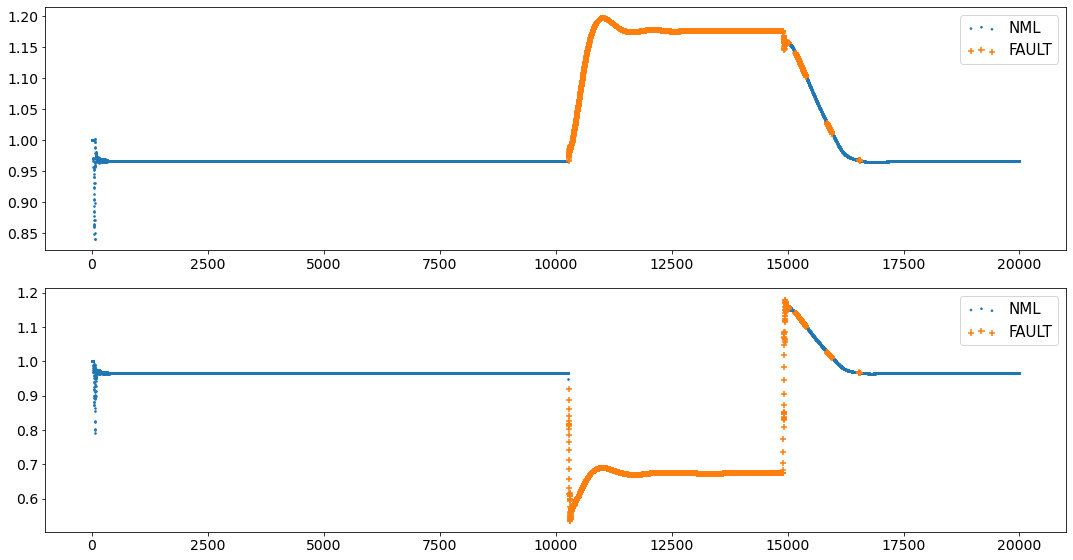

  Fault type Percentage
0         CG     91.34%
1        ABC      7.36%
2         BC      1.26%
3        ACG      0.04%


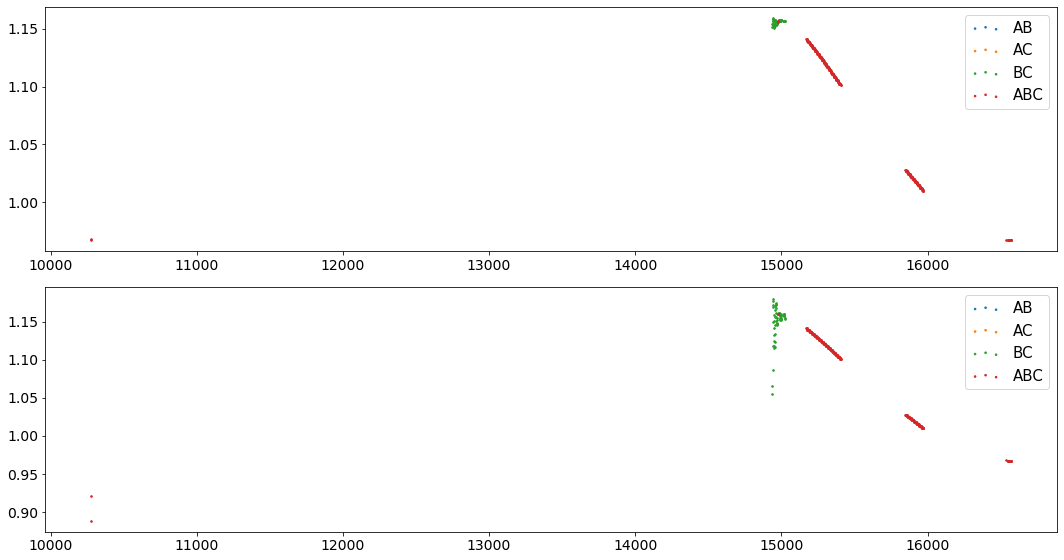


.
.
 7ABCG.csv
  Fault type Percentage
0        NML     77.85%
1      FAULT     22.15%


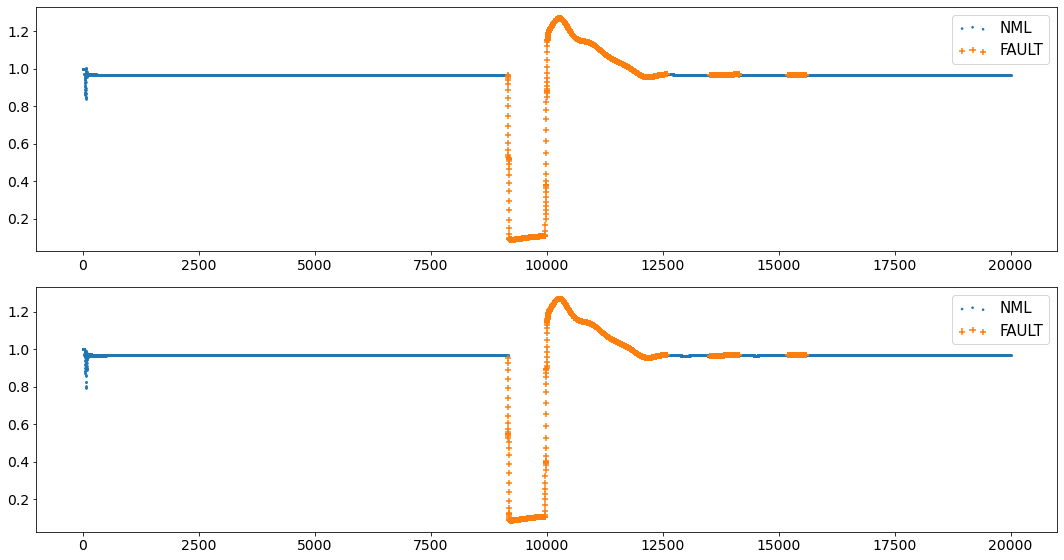

  Fault type Percentage
0        ABC     99.35%
1        BCG      0.25%
2        ACG      0.16%
3        ABG      0.14%
4       ABCG      0.11%


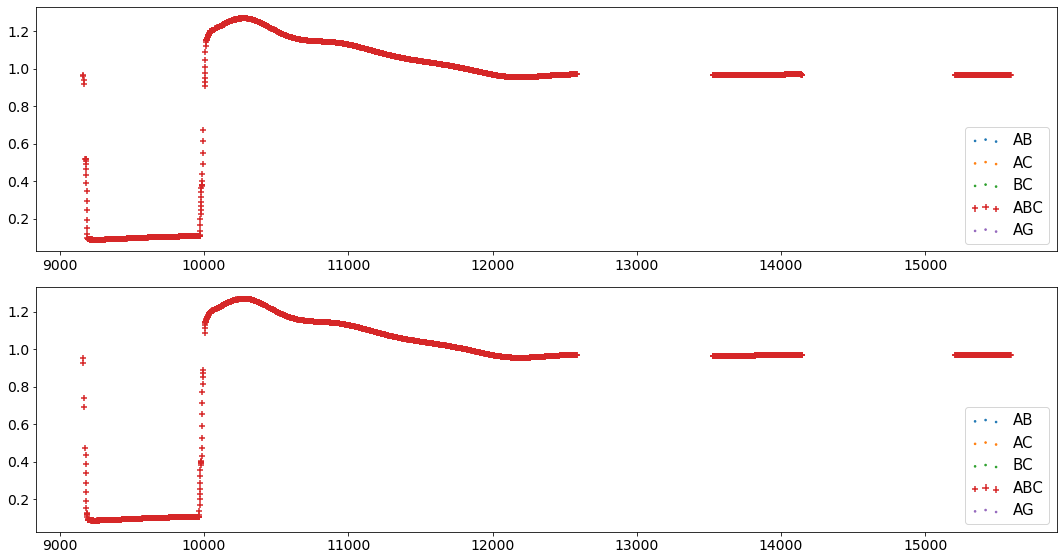


.
.
 9BCG.csv
  Fault type Percentage
0        NML      68.1%
1      FAULT      31.9%


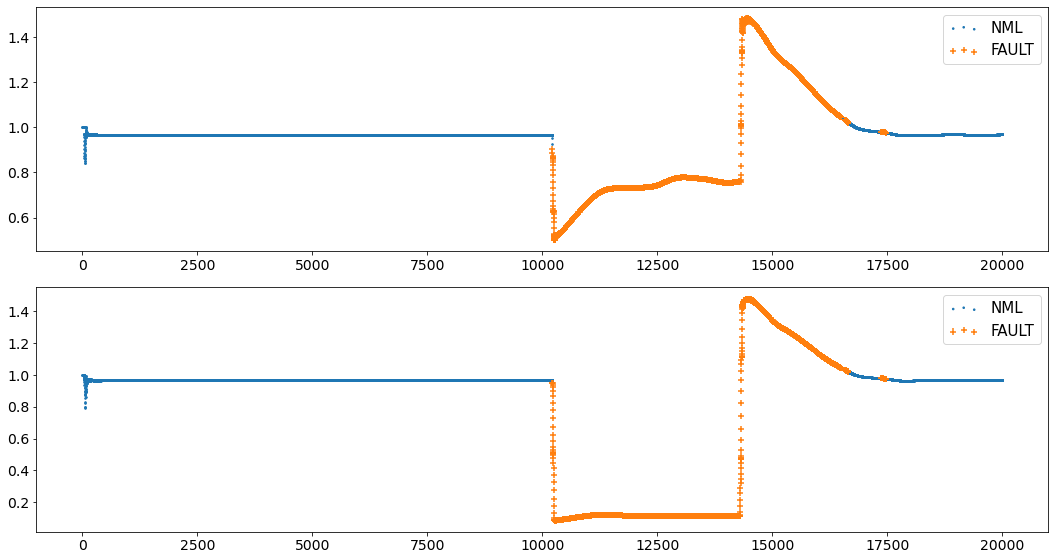

  Fault type Percentage
0        BCG     69.37%
1        ABC      19.5%
2         BC      3.86%
3        ABG      3.86%
4        ACG      1.93%
5         AB      0.83%
6         AC      0.55%
7         BG      0.08%
8         CG      0.02%
9       ABCG      0.02%


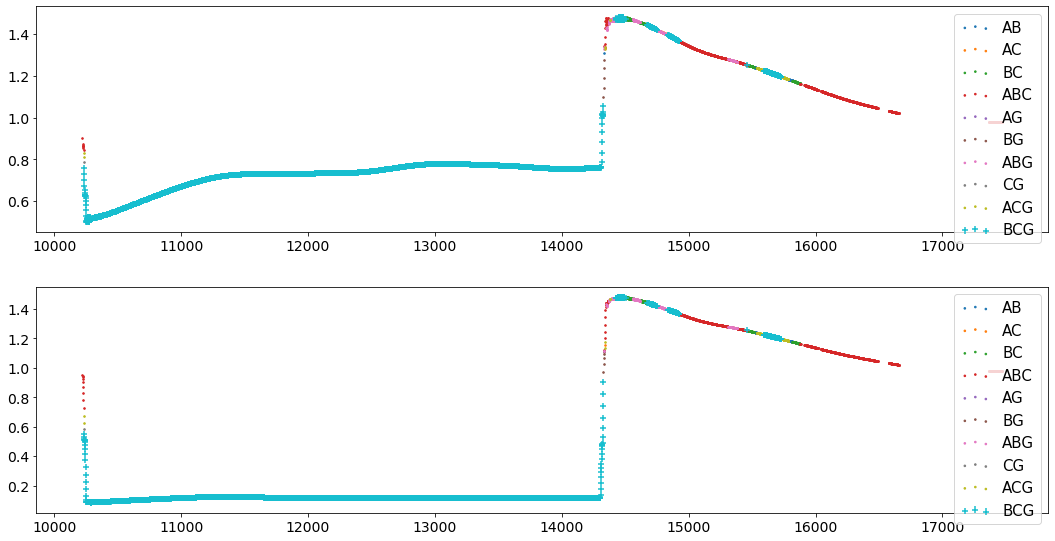


.
.
 10AG.csv
  Fault type Percentage
0        NML     88.56%
1      FAULT     11.44%


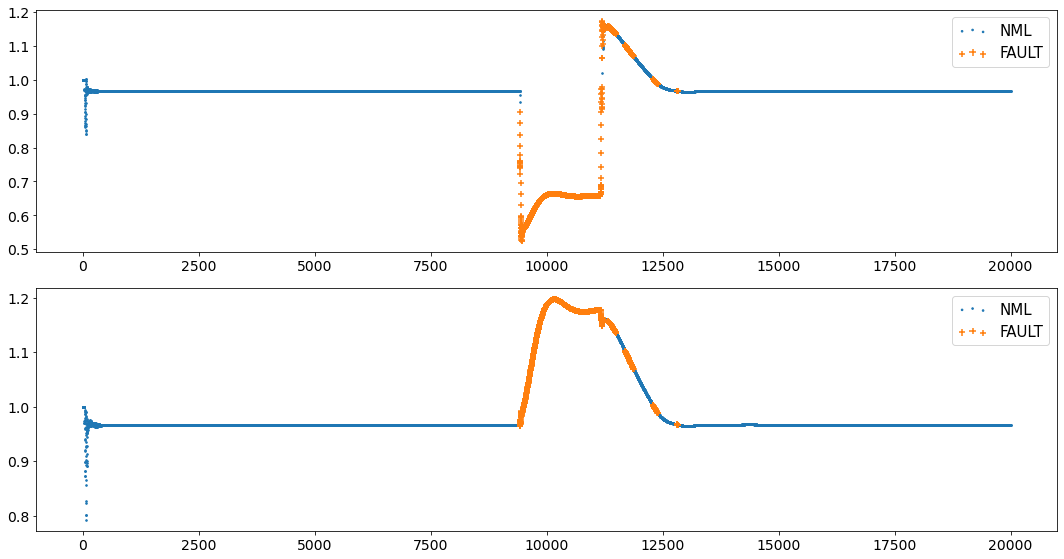

  Fault type Percentage
0         AG     77.13%
1        ABC      15.0%
2         BC       7.7%
3        ACG      0.09%
4        ABG      0.09%


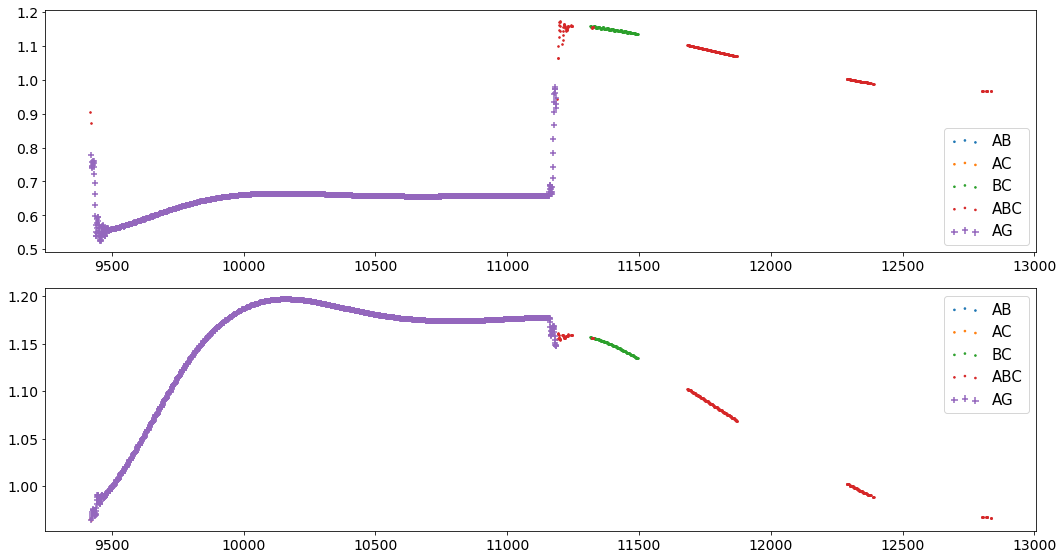


.
.
 3ABC.csv
  Fault type Percentage
0        NML     81.19%
1      FAULT     18.82%


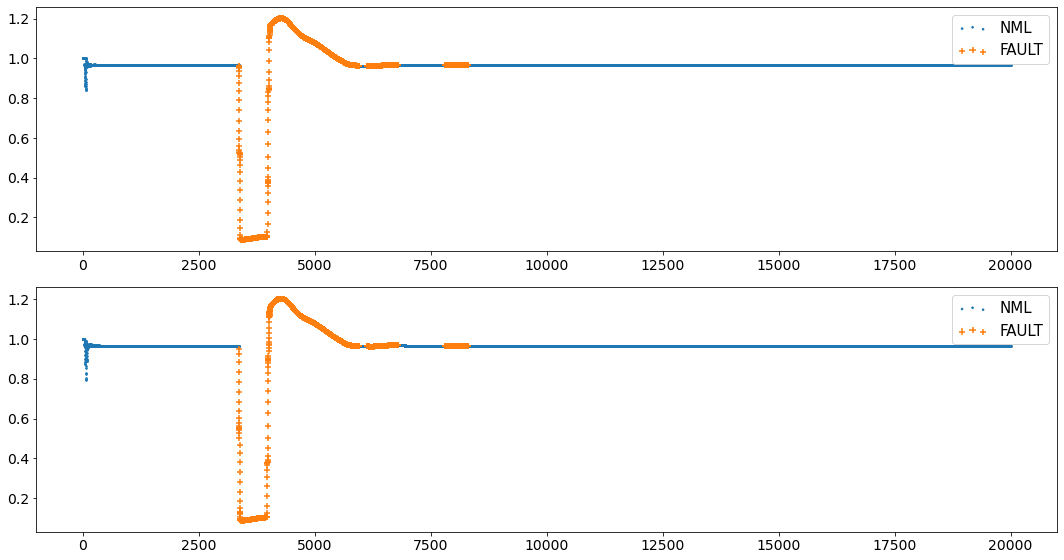

  Fault type Percentage
0        ABC     99.28%
1        BCG      0.29%
2        ABG      0.21%
3       ABCG      0.13%
4        ACG      0.08%


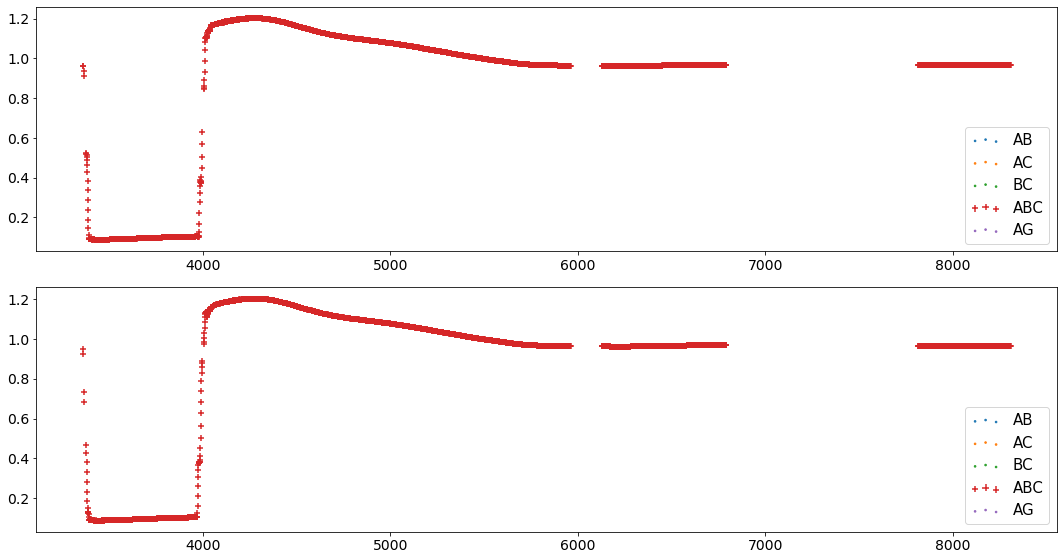


.
.
 3ACG.csv
  Fault type Percentage
0        NML     72.33%
1      FAULT     27.68%


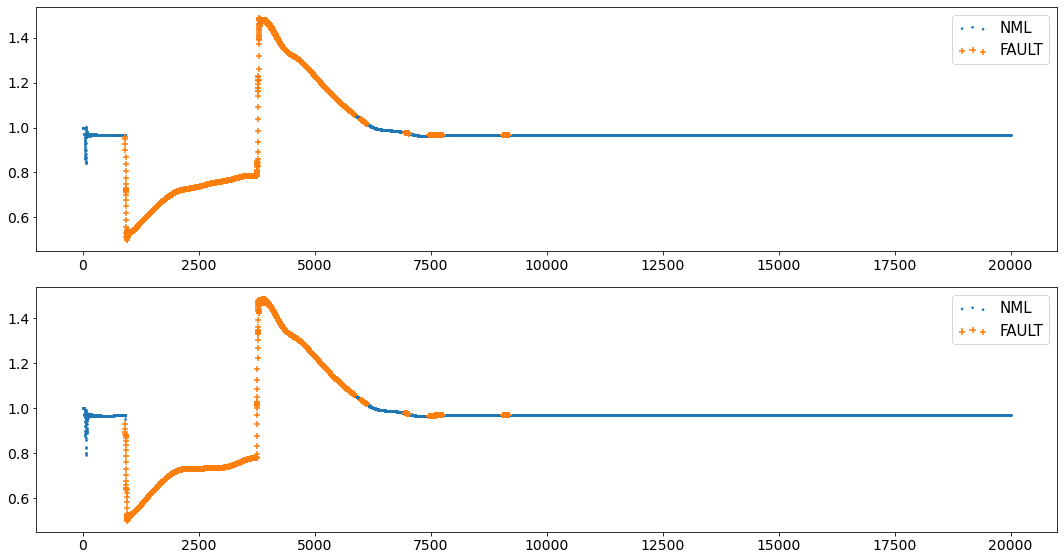

  Fault type Percentage
0        ACG     57.13%
1        ABC     33.13%
2         BC      3.16%
3        ABG      2.62%
4        BCG      2.13%
5         AB      1.17%
6         AC      0.49%
7         AG      0.16%


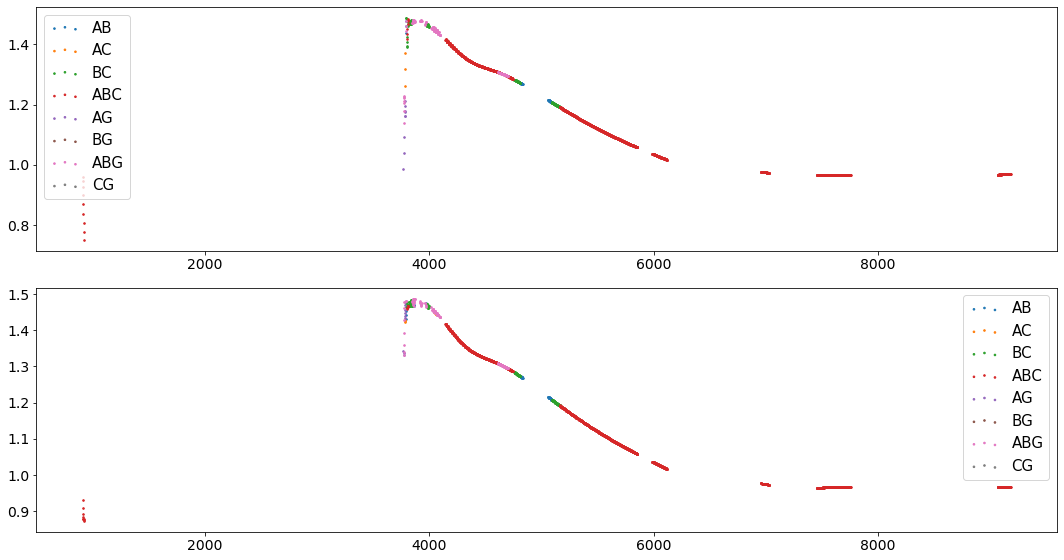


.
.
 8AC.csv
  Fault type Percentage
0        NML     88.39%
1      FAULT     11.62%


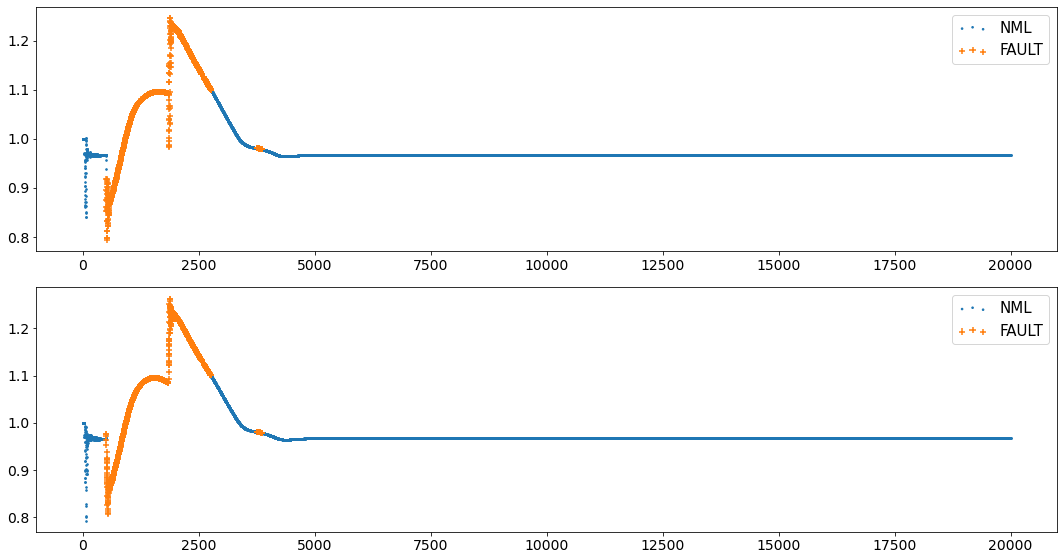

  Fault type Percentage
0         AC     58.37%
1        ABC     39.78%
2         BC      1.42%
3        ACG      0.43%


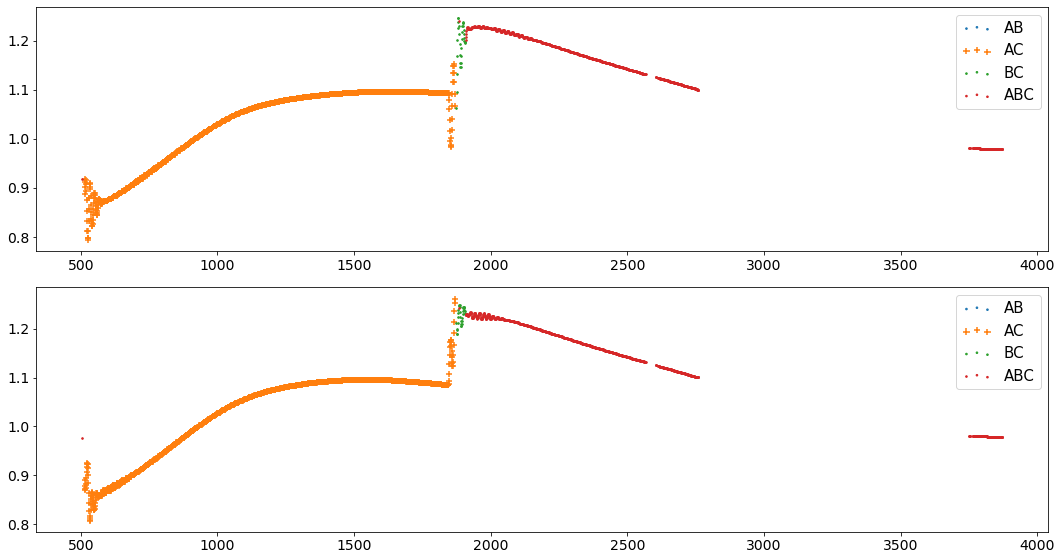


.
.
 4BC.csv
  Fault type Percentage
0        NML     78.59%
1      FAULT     21.41%


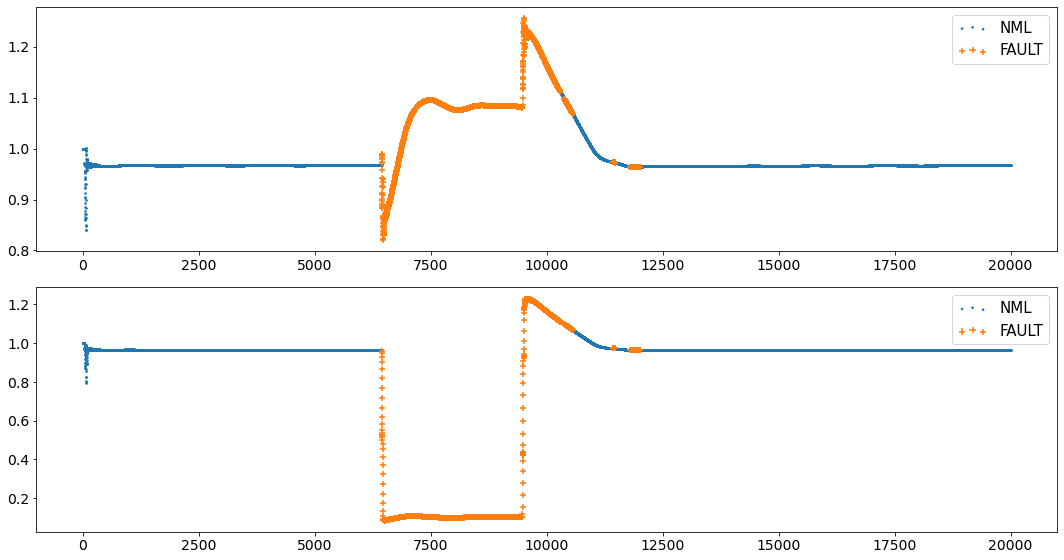

  Fault type Percentage
0         BC     72.23%
1        ABC     27.52%
2        BCG      0.09%
3        ACG      0.09%
4         AB      0.07%


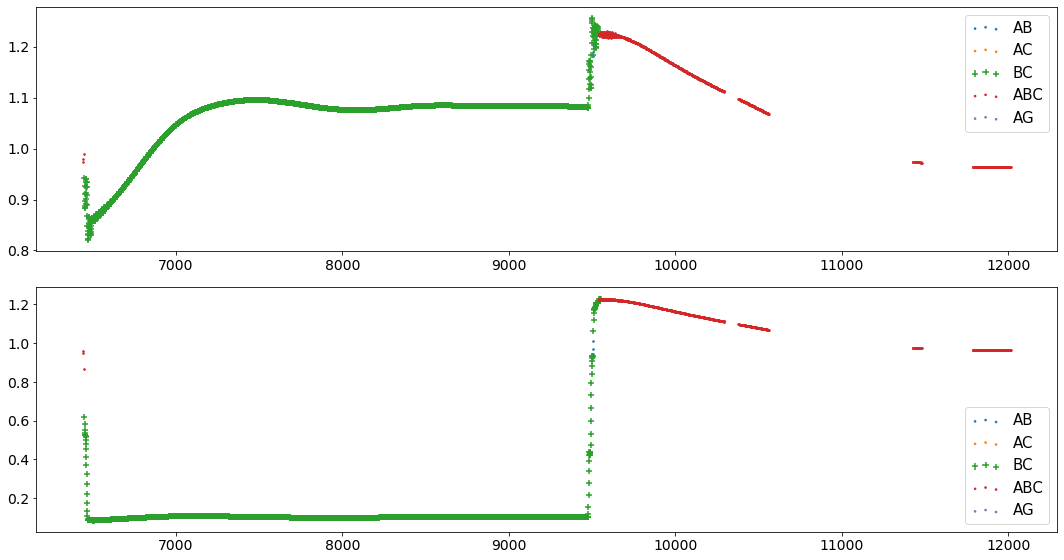


.
.
 4CG.csv
  Fault type Percentage
0        NML     89.03%
1      FAULT     10.96%


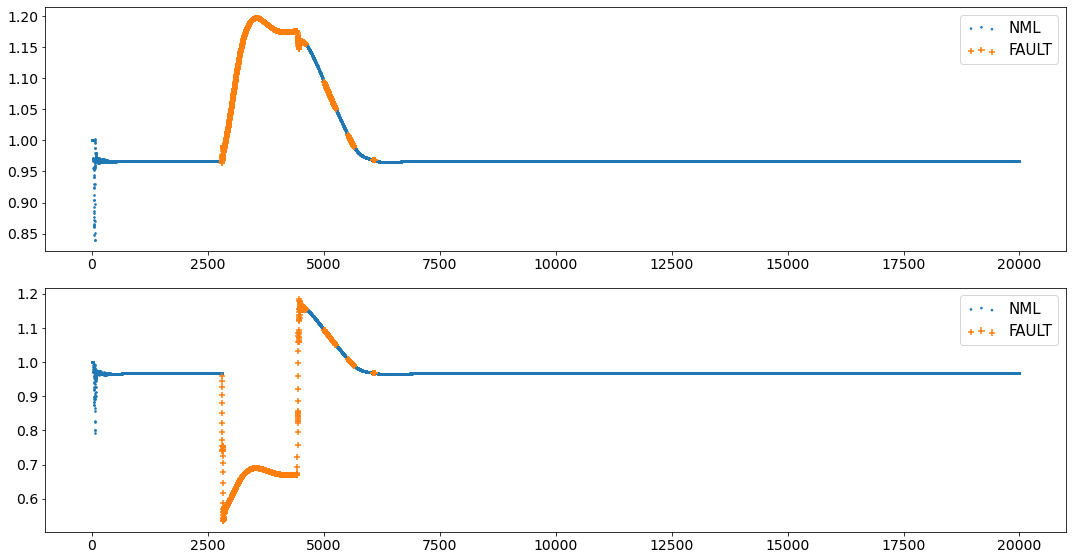

  Fault type Percentage
0         CG      75.1%
1        ABC     24.49%
2         BC      0.27%
3        ACG      0.14%


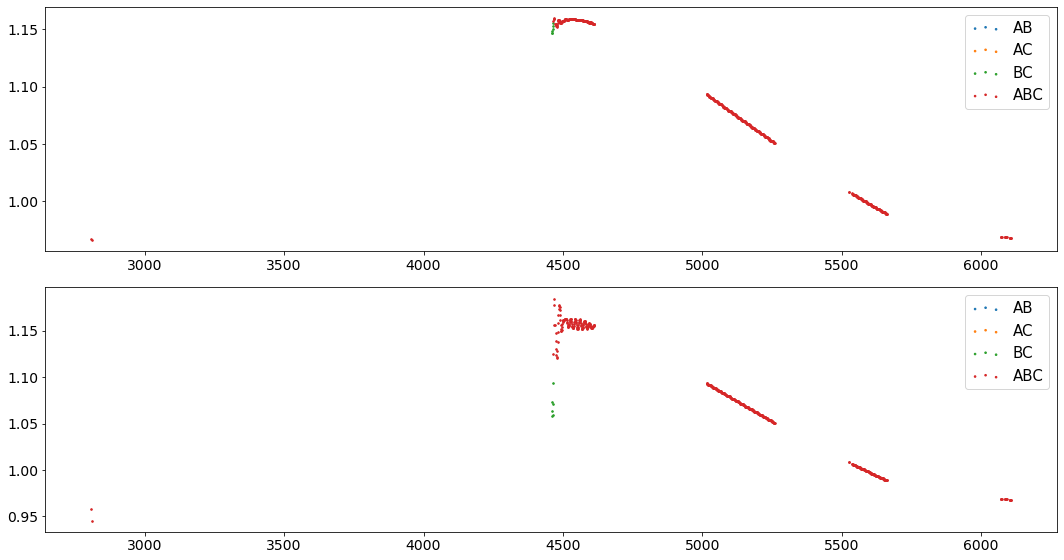


.
.
 1ABG.csv
  Fault type Percentage
0        NML     66.77%
1      FAULT     33.23%


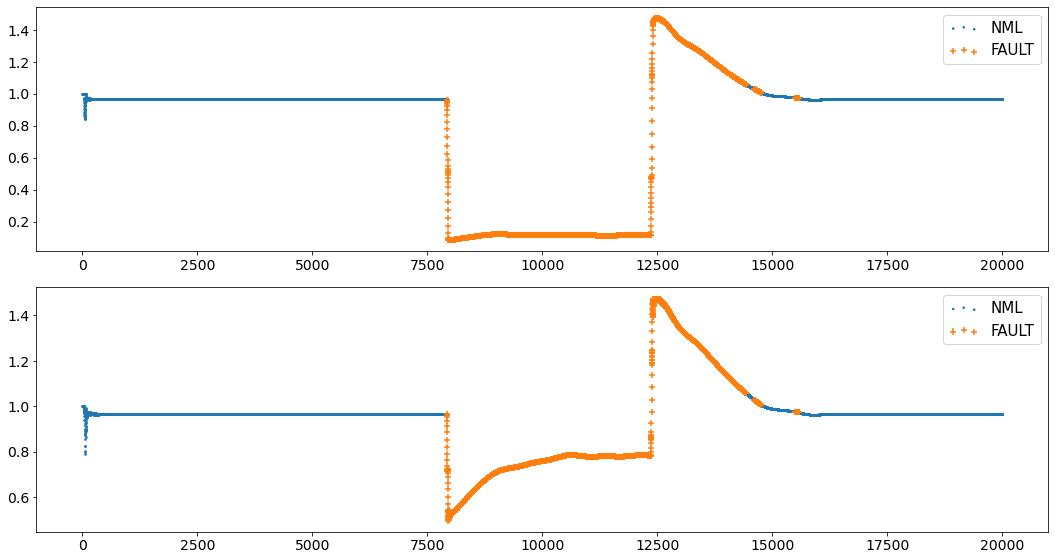

  Fault type Percentage
0        ABG     69.07%
1        ABC     19.05%
2        BCG      4.21%
3        ACG      3.04%
4         BC      2.81%
5         AB      1.46%
6         AC      0.36%


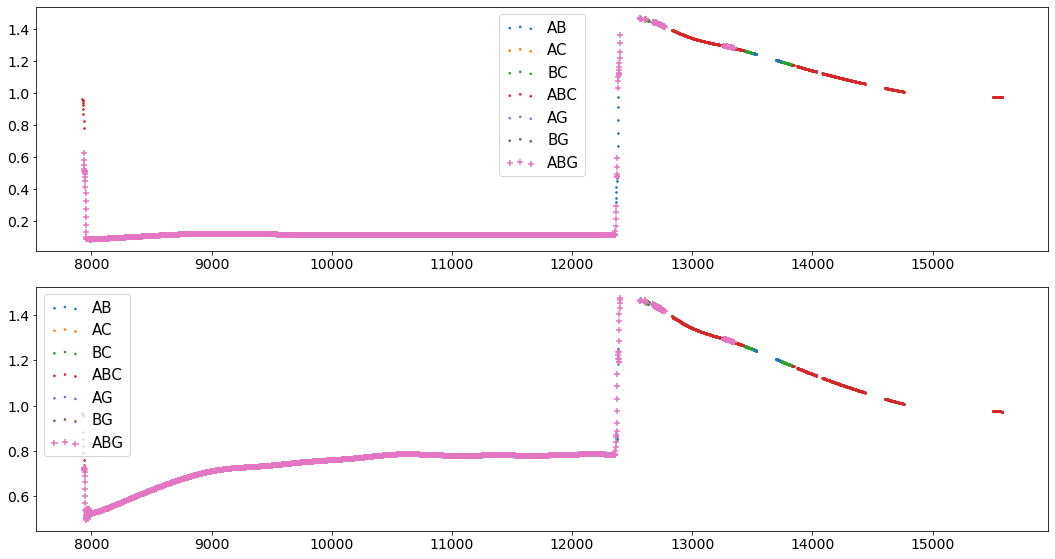


.
.
 8AB.csv
  Fault type Percentage
0        NML     88.17%
1      FAULT     11.84%


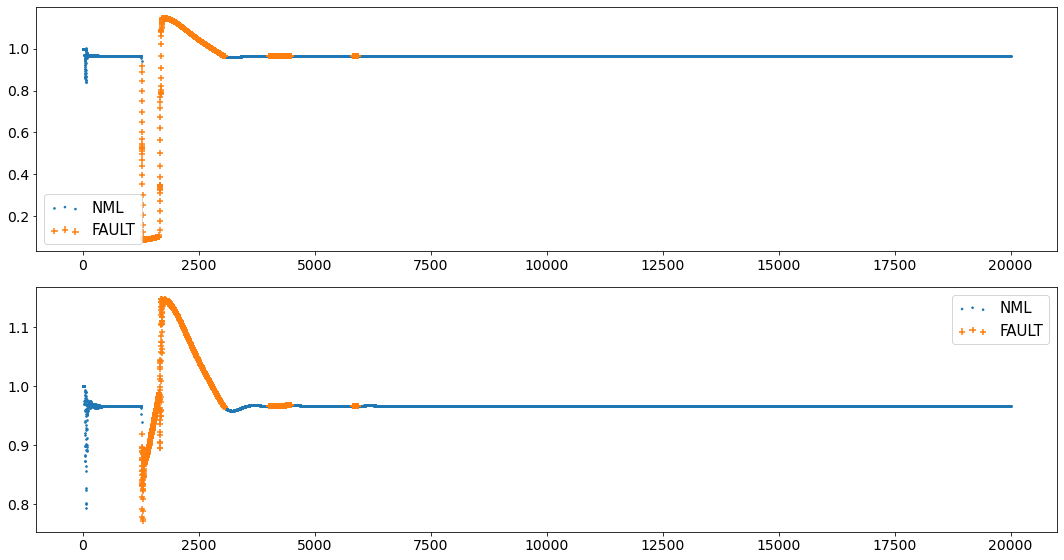

  Fault type Percentage
0        ABC     82.51%
1         AB     16.39%
2        ABG      0.97%
3         BC      0.08%
4        BCG      0.04%


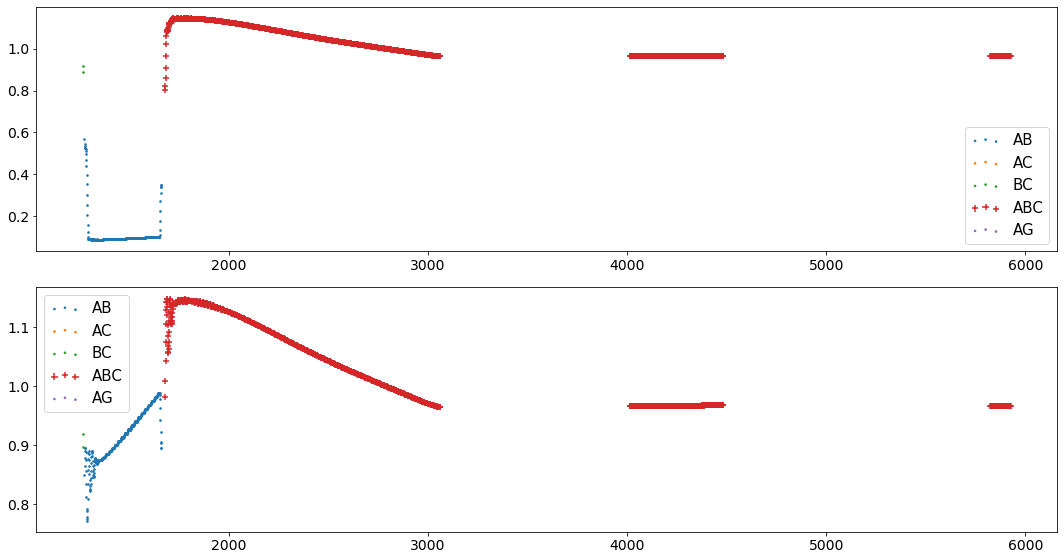


.
.
 10BCG.csv
  Fault type Percentage
0        NML     84.26%
1      FAULT     15.74%


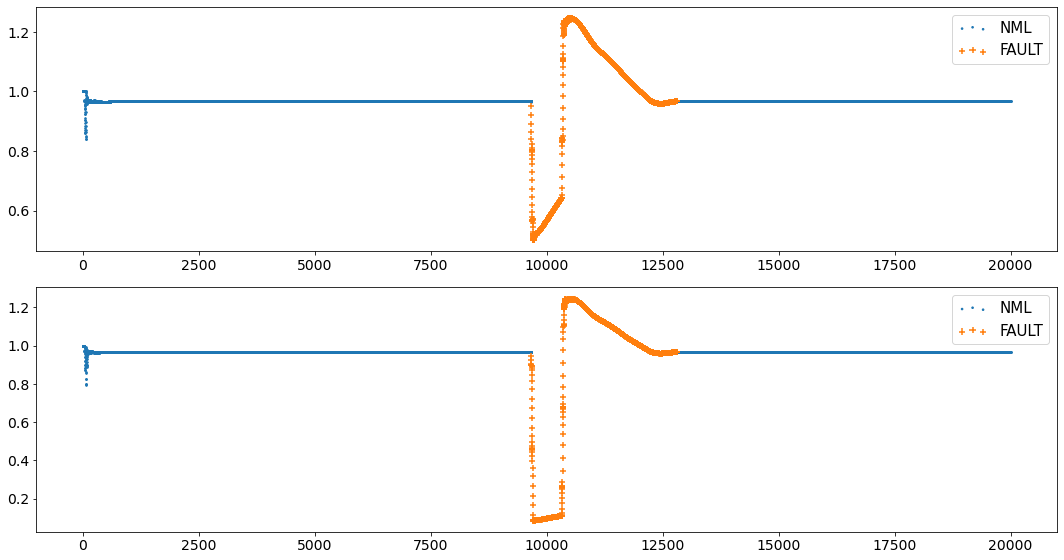

  Fault type Percentage
0        ABC     78.34%
1        BCG     21.28%
2        ABG      0.16%
3         CG      0.13%
4        ACG       0.1%


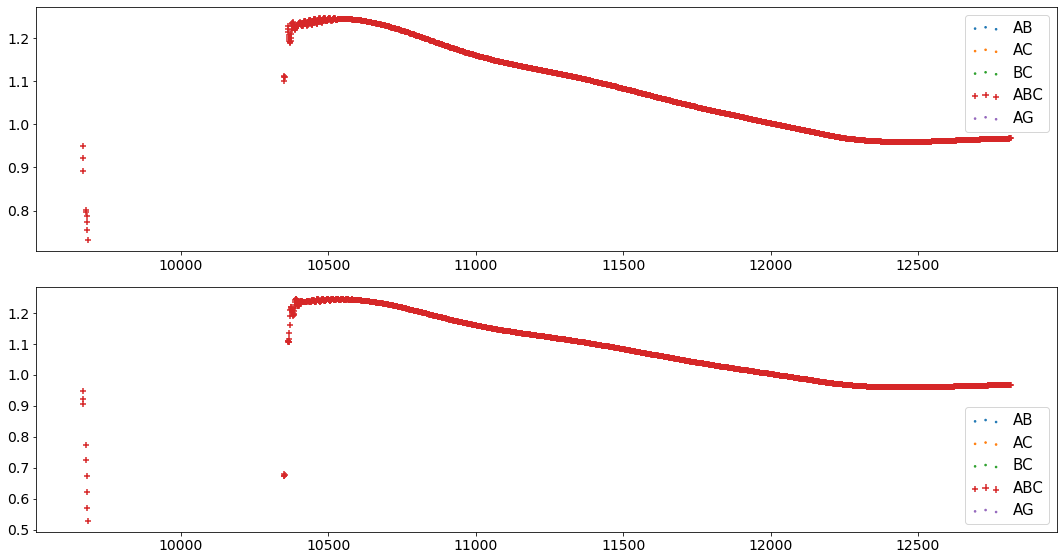


.
.
 8CG.csv
  Fault type Percentage
0        NML     99.11%
1      FAULT      0.89%


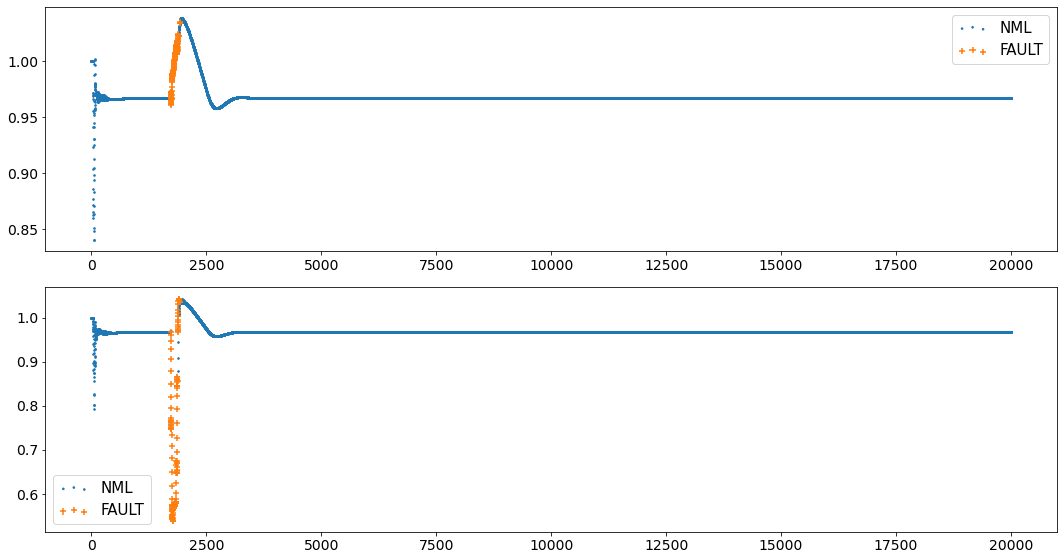

  Fault type Percentage
0         CG     81.46%
1        ABC     16.29%
2         BC      1.12%
3        ACG      1.12%


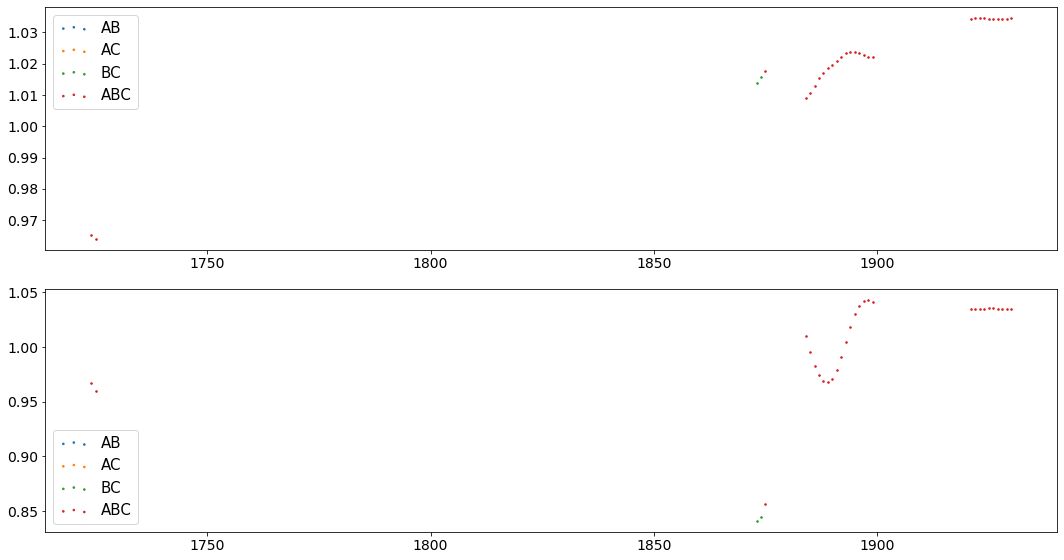


.
.
 8BC.csv
  Fault type Percentage
0        NML     99.69%
1      FAULT       0.3%


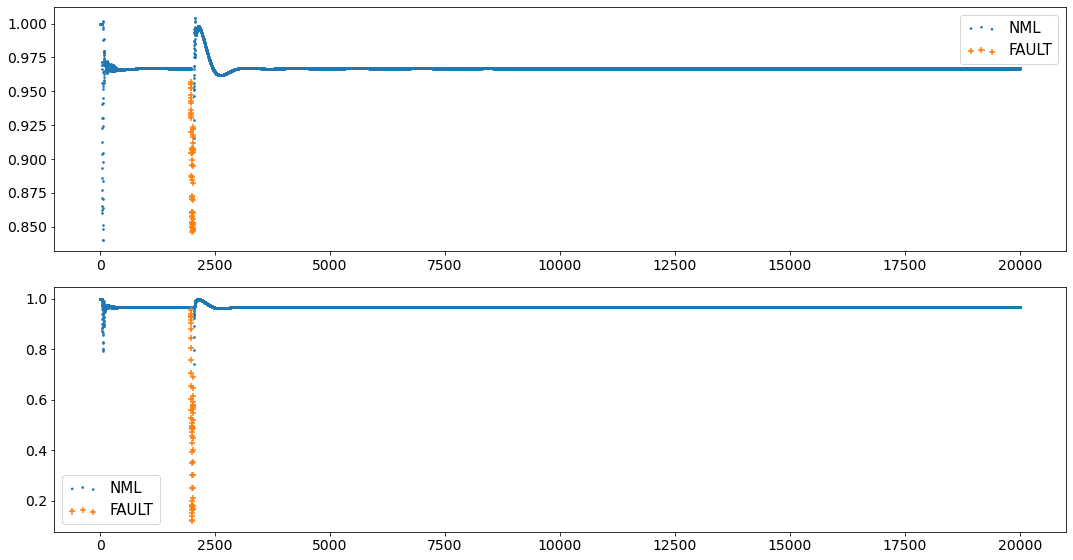

  Fault type Percentage
0         BC      62.3%
1        ABC     19.67%
2        BCG     13.11%
3         AB      3.28%
4         BG      1.64%


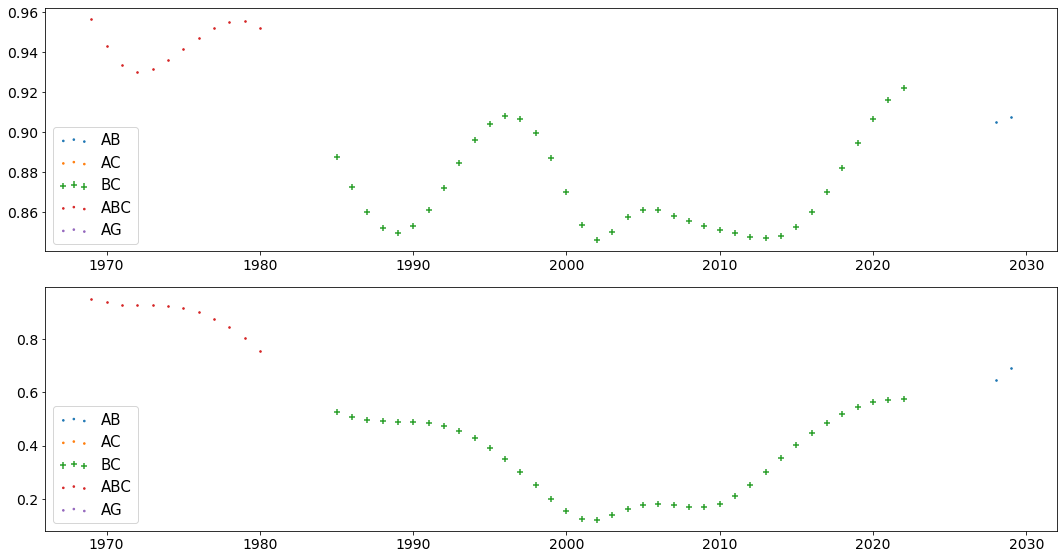


.
.
 4AB.csv
  Fault type Percentage
0        NML      87.0%
1      FAULT     12.99%


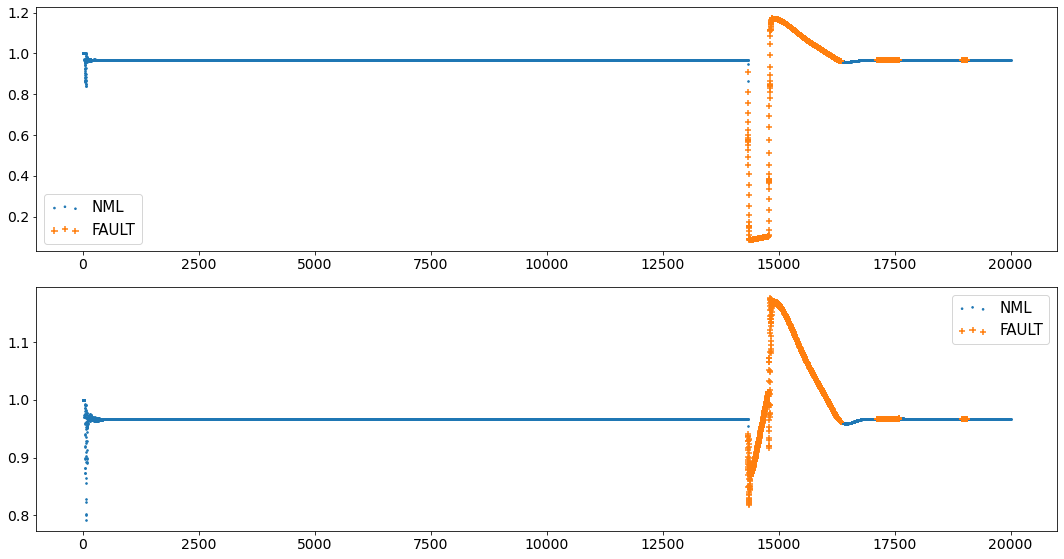

  Fault type Percentage
0        ABC     81.69%
1         AB     17.39%
2        ABG      0.88%
3       ABCG      0.04%


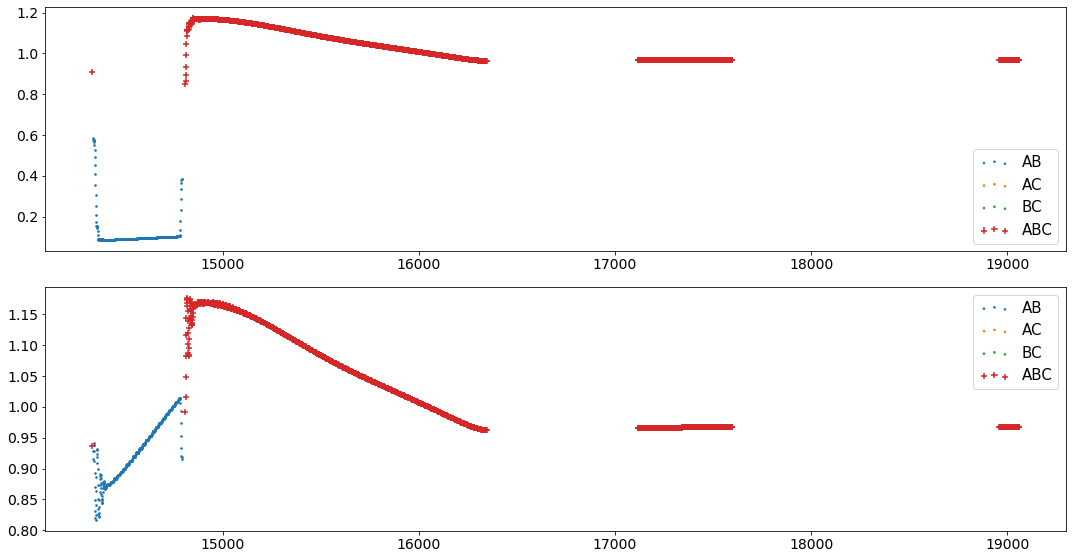


.
.
 6ACG.csv
  Fault type Percentage
0        NML     51.45%
1      FAULT     48.55%


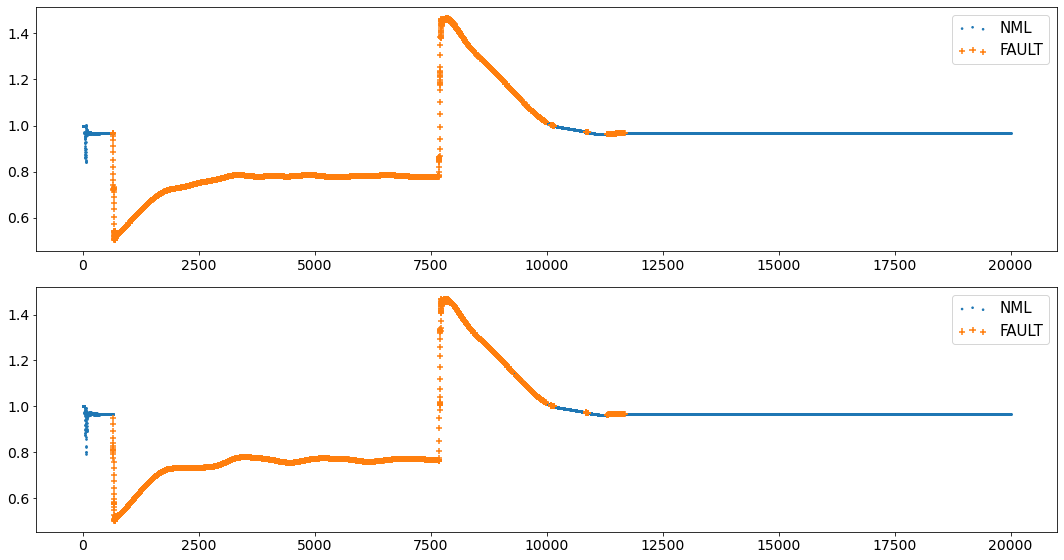

  Fault type Percentage
0        ACG      74.3%
1        ABC     16.81%
2        ABG      3.93%
3         BC      1.81%
4        BCG      1.81%
5         AB      0.99%
6         AC      0.24%
7         CG       0.1%


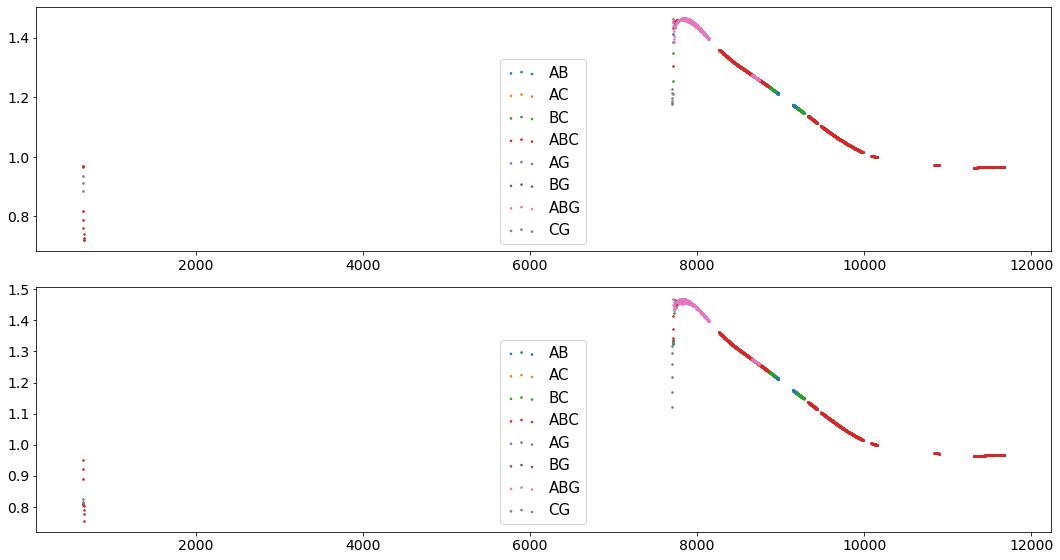


.
.
 6ABC.csv
  Fault type Percentage
0        NML     80.37%
1      FAULT     19.63%


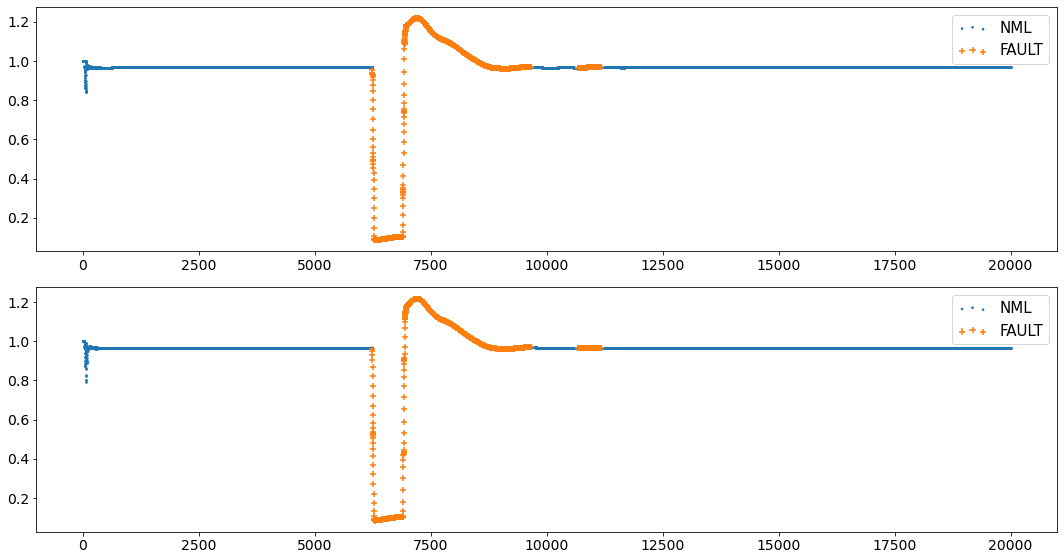

  Fault type Percentage
0        ABC     99.47%
1        BCG      0.28%
2        ACG       0.2%
3       ABCG      0.05%


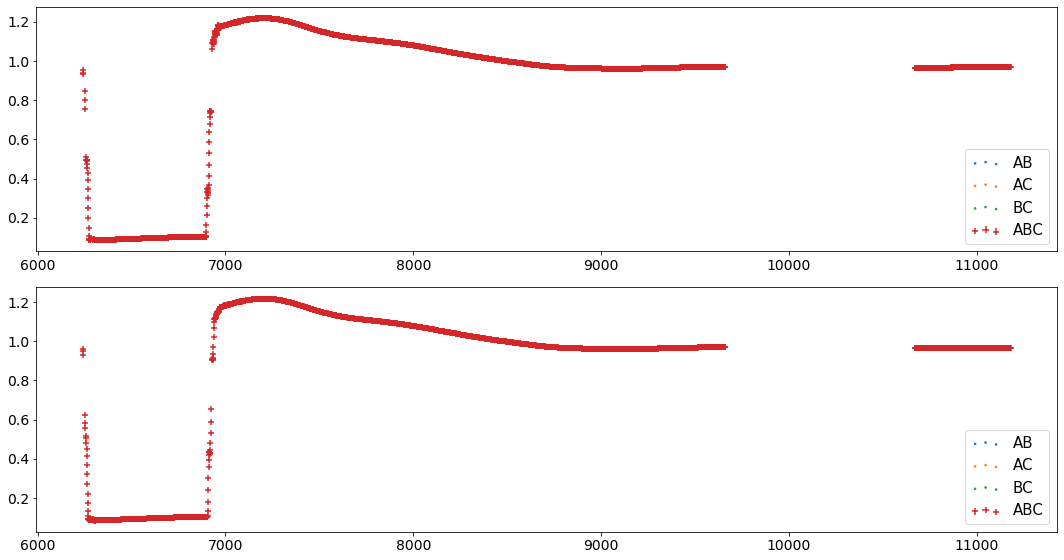


.
.
 8ABG.csv
  Fault type Percentage
0        NML     81.04%
1      FAULT     18.96%


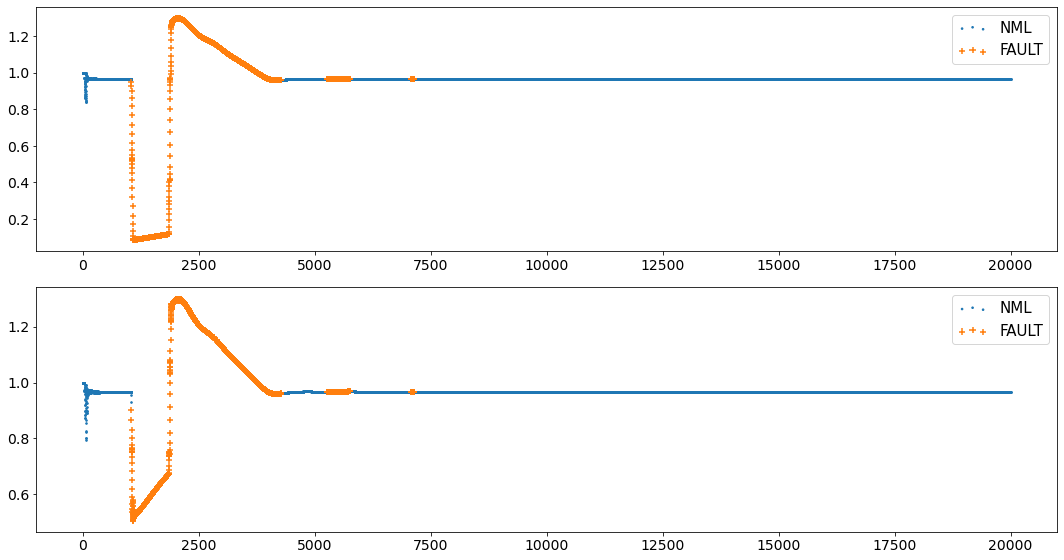

  Fault type Percentage
0        ABC     77.95%
1        ABG     21.84%
2        ACG      0.11%
3         BG      0.05%
4        BCG      0.05%


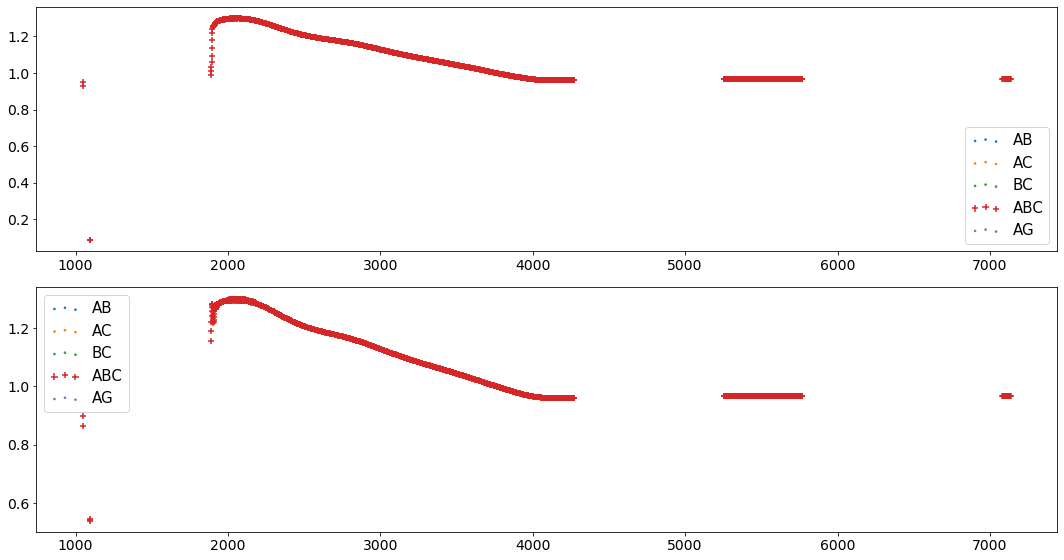


.
.
 4AC.csv
  Fault type Percentage
0        NML     89.38%
1      FAULT     10.62%


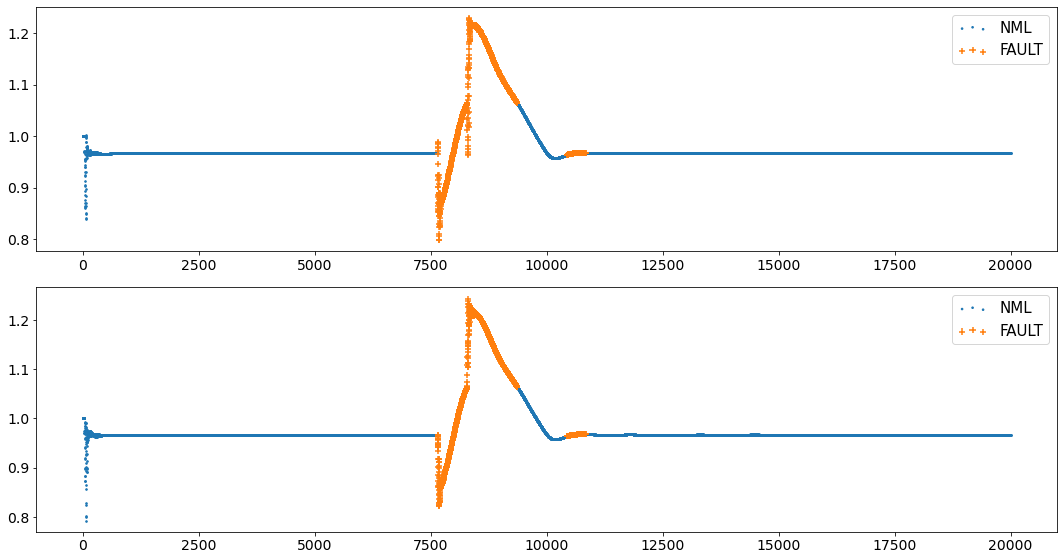

  Fault type Percentage
0        ABC     69.13%
1         AC     29.79%
2        ACG      1.08%


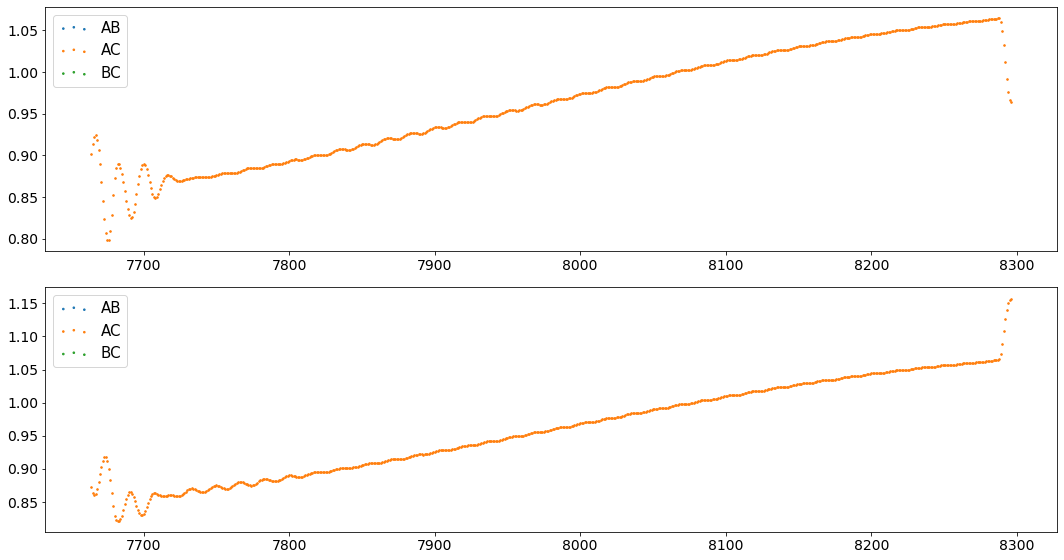


.
.
 4ABG.csv
  Fault type Percentage
0        NML     82.32%
1      FAULT     17.68%


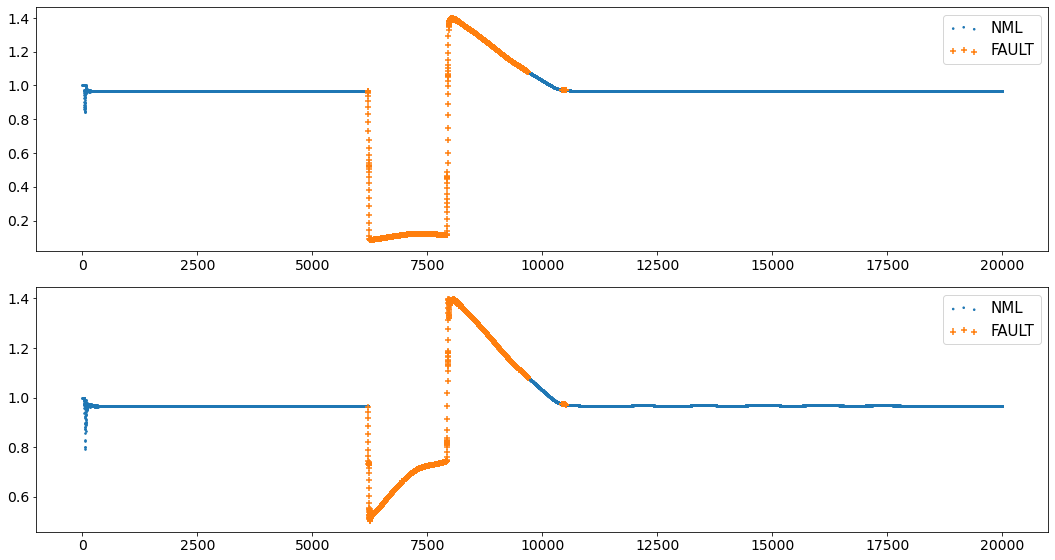

  Fault type Percentage
0        ABG     55.49%
1        ABC     30.01%
2        BCG     10.92%
3         BC      1.73%
4         AC      1.16%
5        ACG      0.37%
6         AG      0.23%
7         BG      0.06%
8         CG      0.03%
9         AB      0.03%


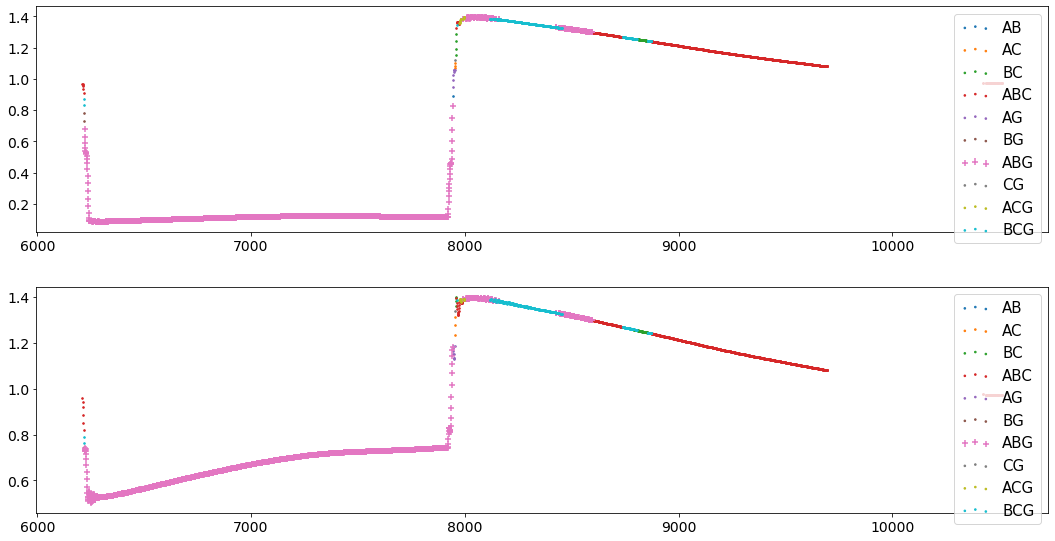


.
.
 2AG.csv
  Fault type Percentage
0        NML     90.83%
1      FAULT      9.18%


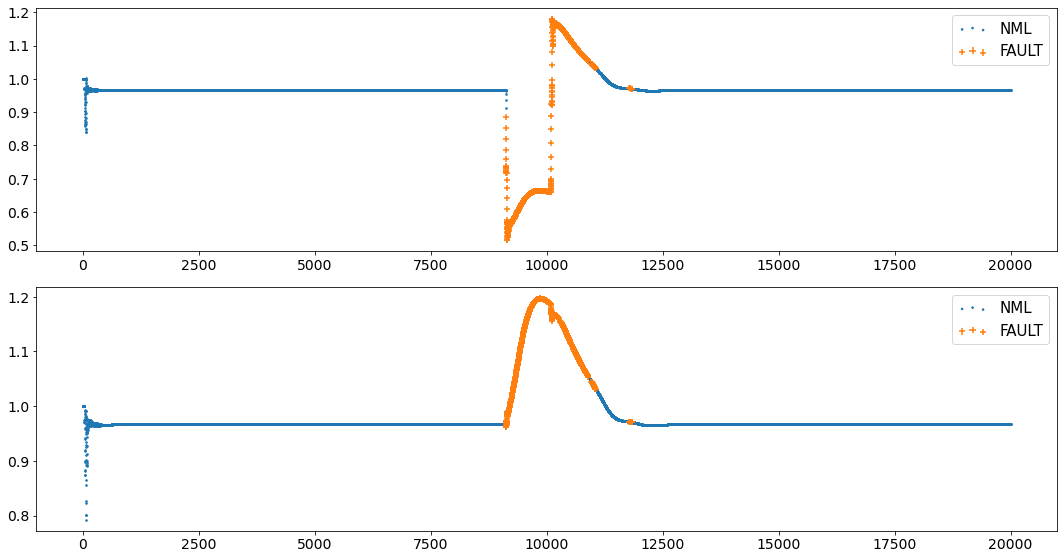

  Fault type Percentage
0         AG     54.01%
1        ABC     38.26%
2         BC      4.09%
3         AB      3.05%
4        ACG      0.49%
5        ABG      0.11%


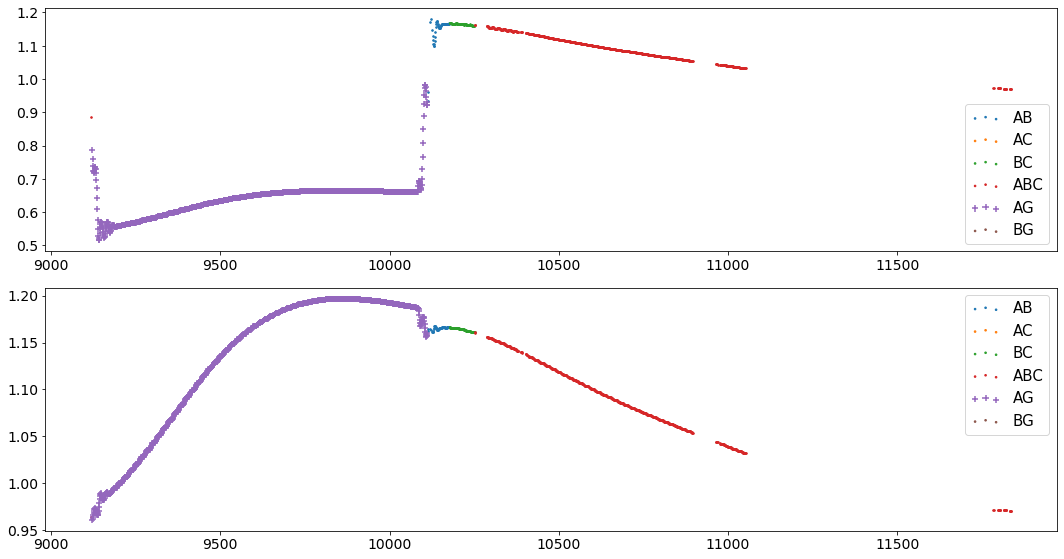


.
.
 6AC.csv
  Fault type Percentage
0        NML     89.39%
1      FAULT     10.62%


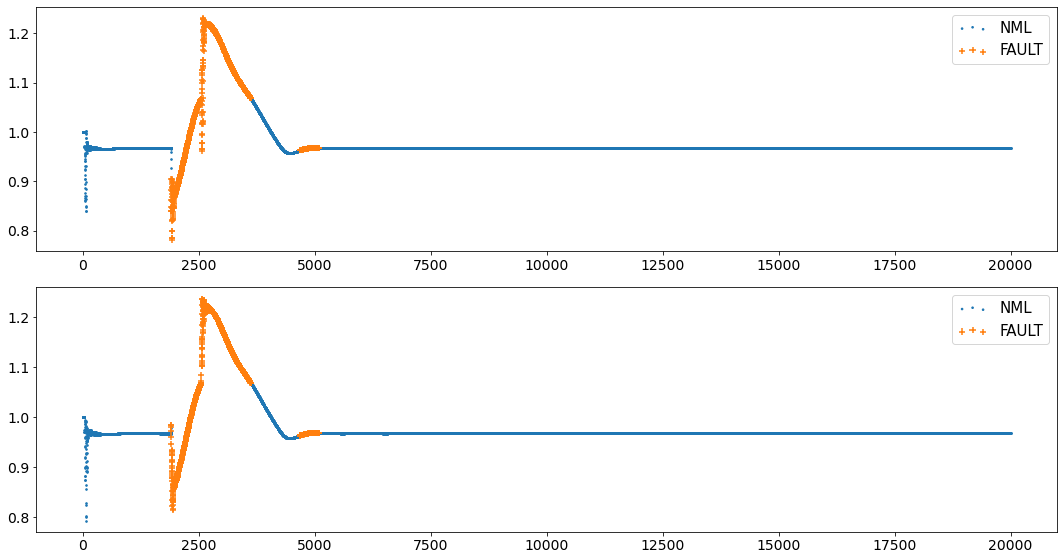

  Fault type Percentage
0        ABC     68.02%
1         AC     30.66%
2        ACG      1.13%
3       ABCG      0.19%


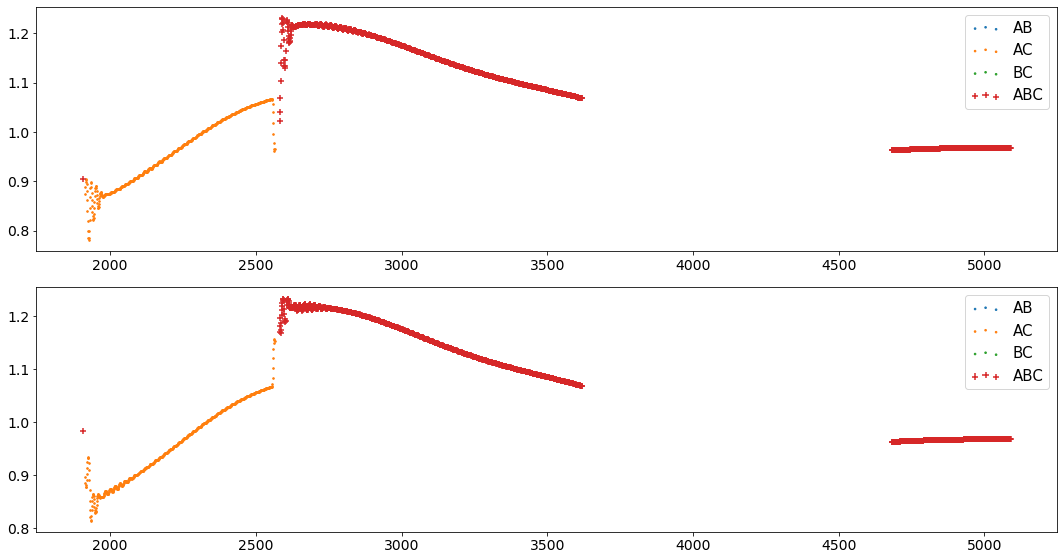


.
.
 6AB.csv
  Fault type Percentage
0        NML     88.48%
1      FAULT     11.52%


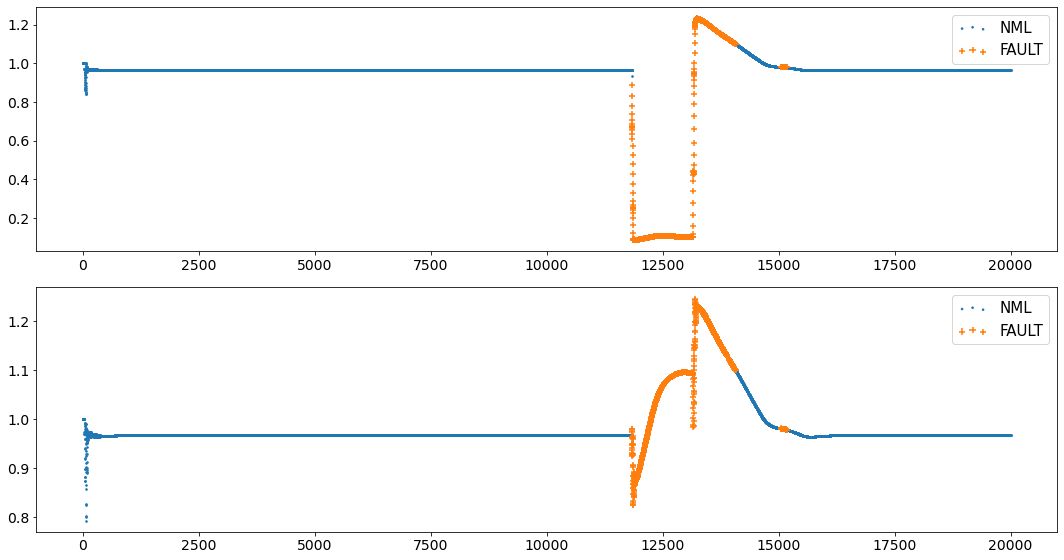

  Fault type Percentage
0         AB     58.01%
1        ABC     41.25%
2        ABG      0.35%
3        ACG      0.17%
4         BC      0.13%
5        BCG      0.04%
6       ABCG      0.04%


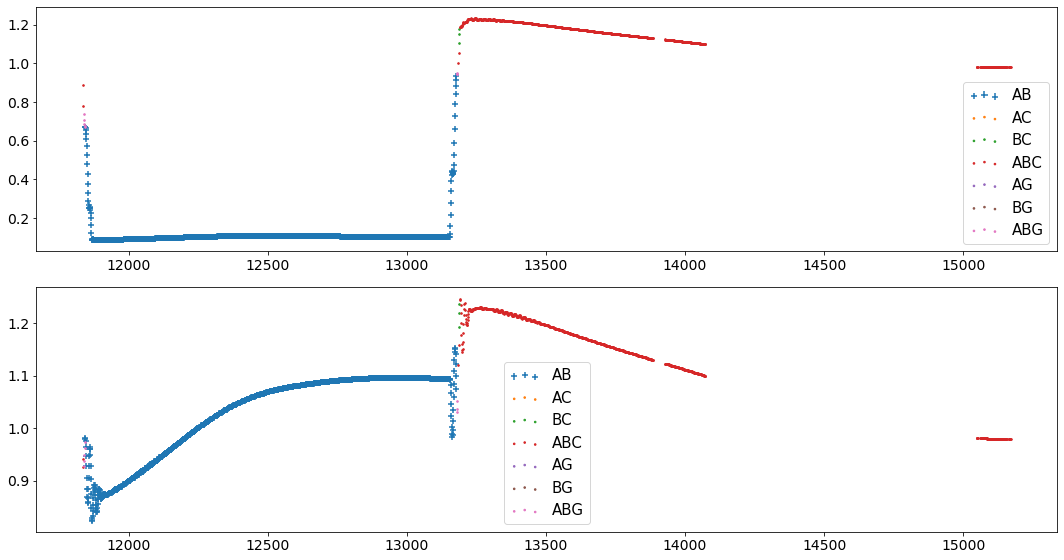


.
.
 2ABCG.csv
  Fault type Percentage
0      FAULT     51.48%
1        NML     48.52%


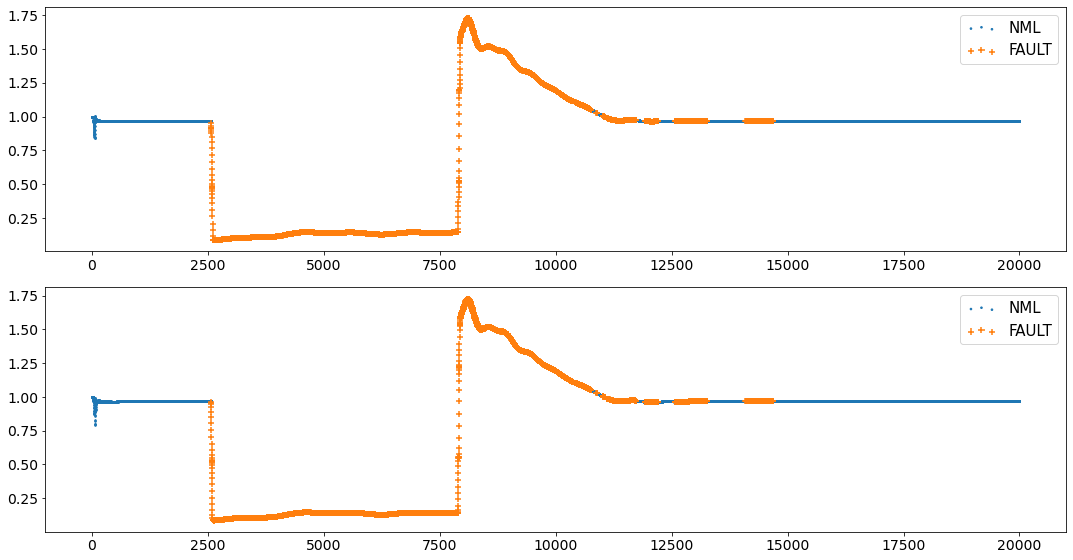

  Fault type Percentage
0        ABC     88.52%
1        ABG      3.16%
2        BCG      2.36%
3        ACG      2.21%
4         AB      1.89%
5         BC      1.33%
6         AC      0.51%
7       ABCG      0.01%


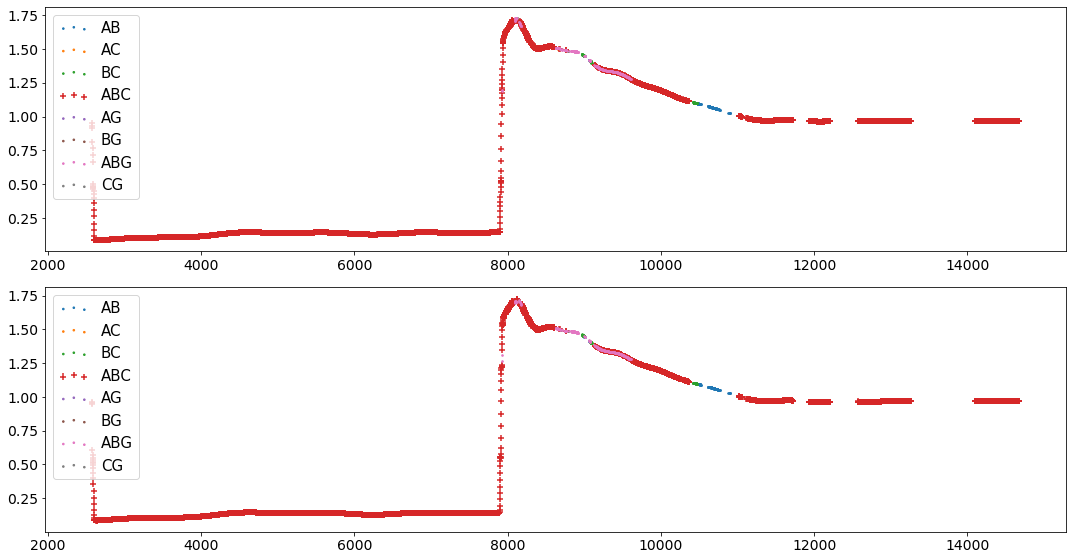


.
.
 10BG.csv
  Fault type Percentage
0        NML     91.97%
1      FAULT      8.04%


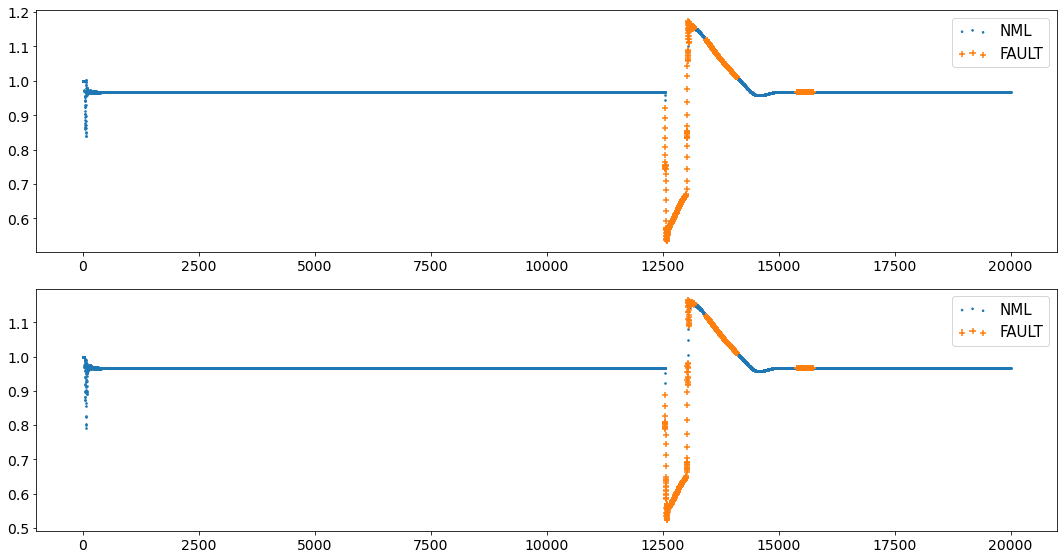

  Fault type Percentage
0        ABC     69.38%
1         BG     30.12%
2        ABG      0.31%
3        BCG      0.12%
4       ABCG      0.06%


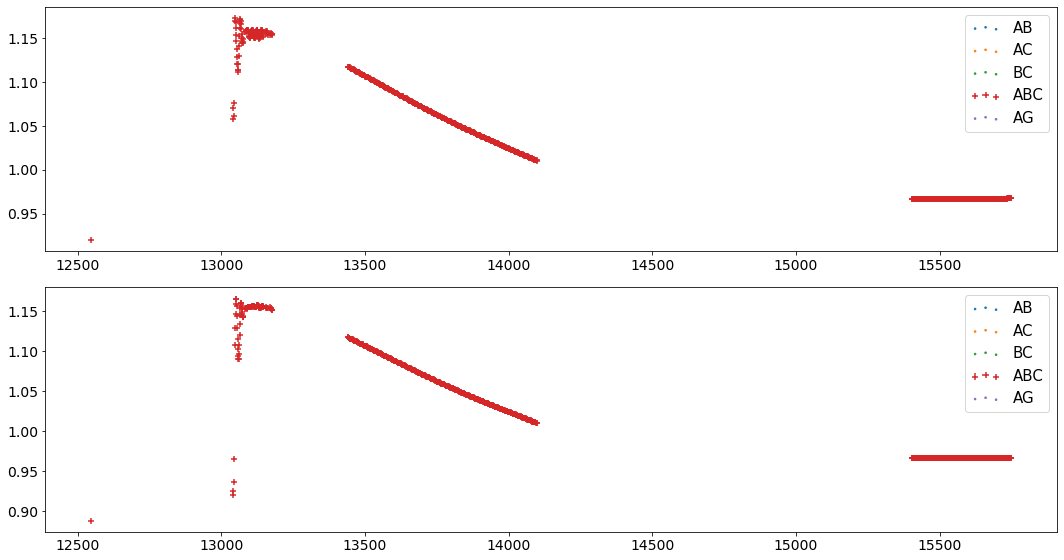


.
.
 2AB.csv
  Fault type Percentage
0        NML     79.33%
1      FAULT     20.67%


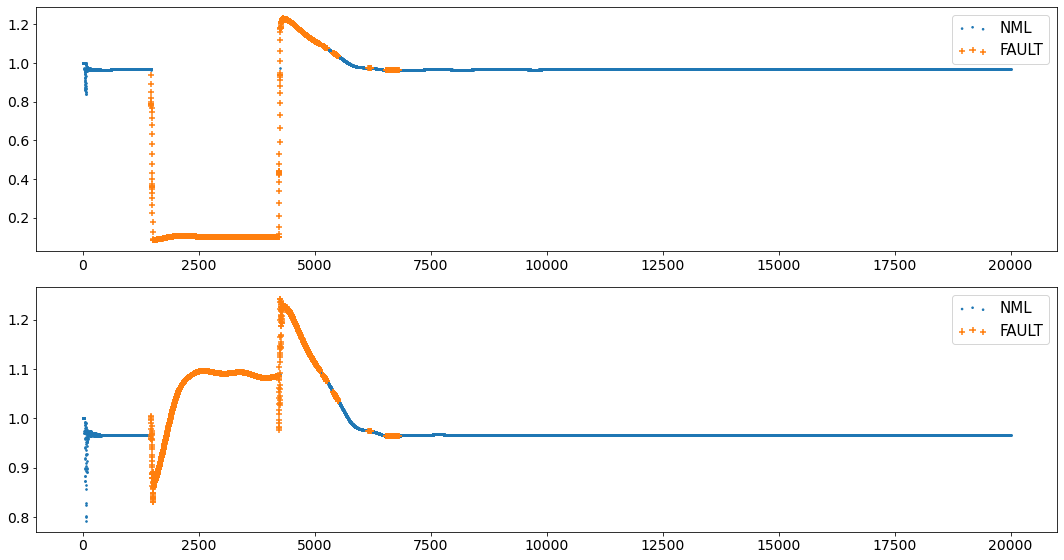

  Fault type Percentage
0         AB     69.13%
1        ABC     26.27%
2         BC      2.73%
3        ACG      1.48%
4        ABG      0.36%
5       ABCG      0.02%


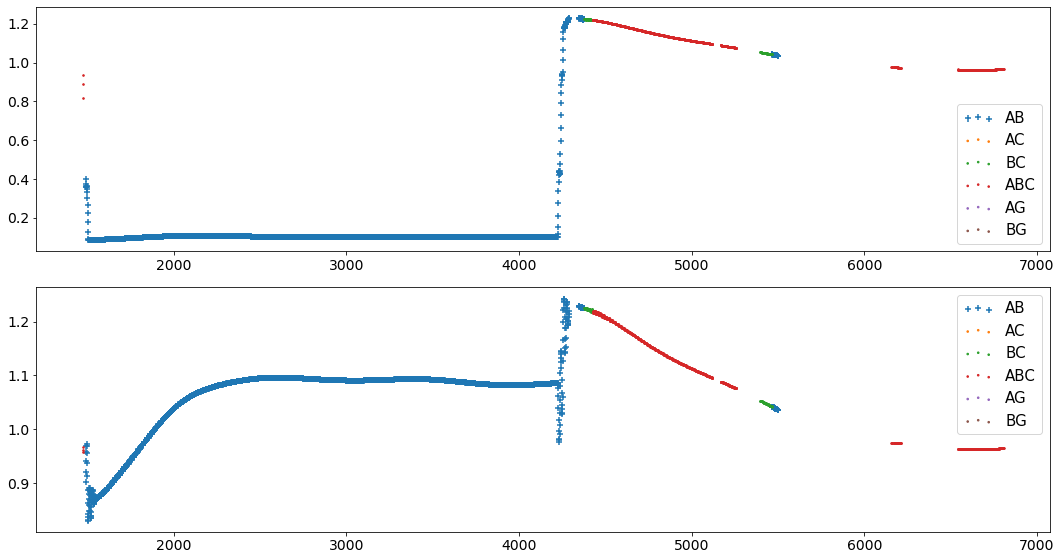


.
.
 2BCG.csv
  Fault type Percentage
0        NML     99.28%
1      FAULT      0.72%


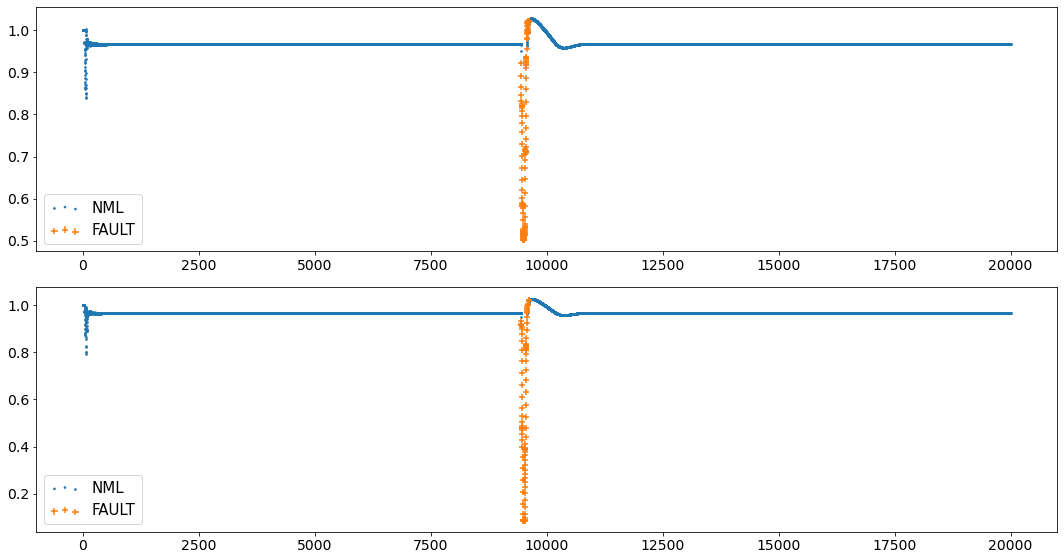

  Fault type Percentage
0        BCG     50.69%
1        ABC     31.94%
2        ABG      9.72%
3         BG      6.94%
4         AB      0.69%


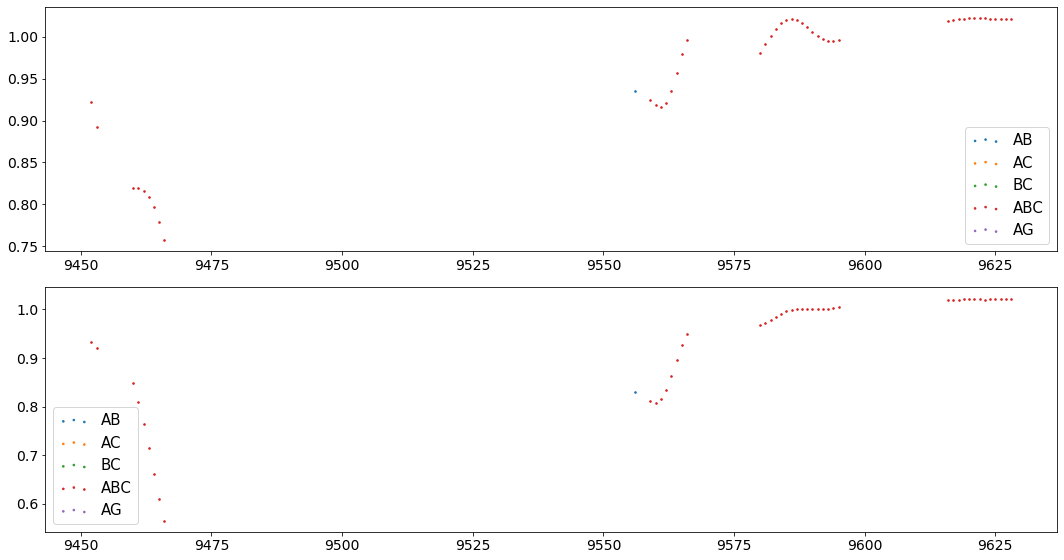


.
.
 10BC.csv
  Fault type Percentage
0        NML     83.53%
1      FAULT     16.48%


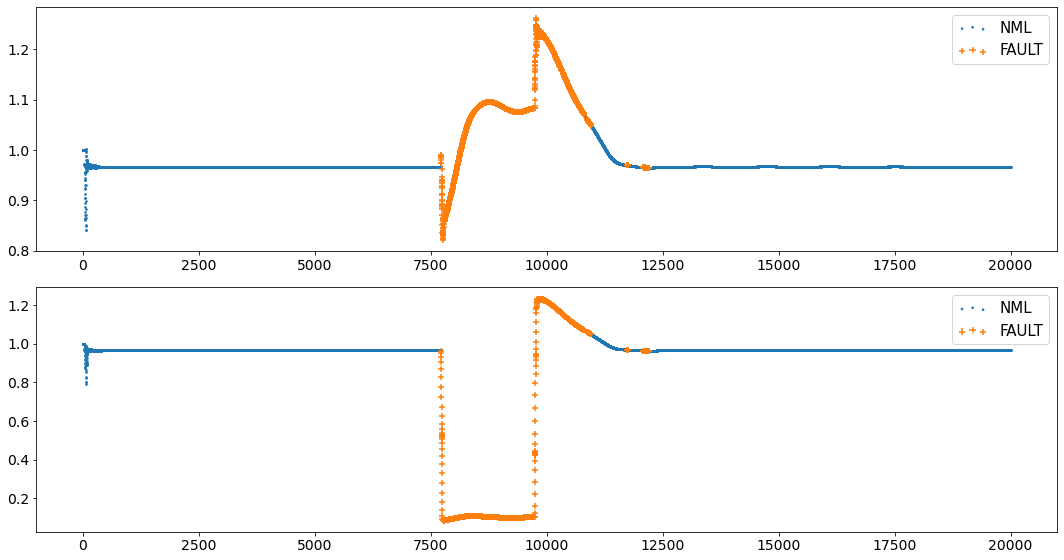

  Fault type Percentage
0         BC     68.98%
1        ABC     25.58%
2         AB      5.22%
3        BCG      0.09%
4        ACG      0.09%
5        ABG      0.03%


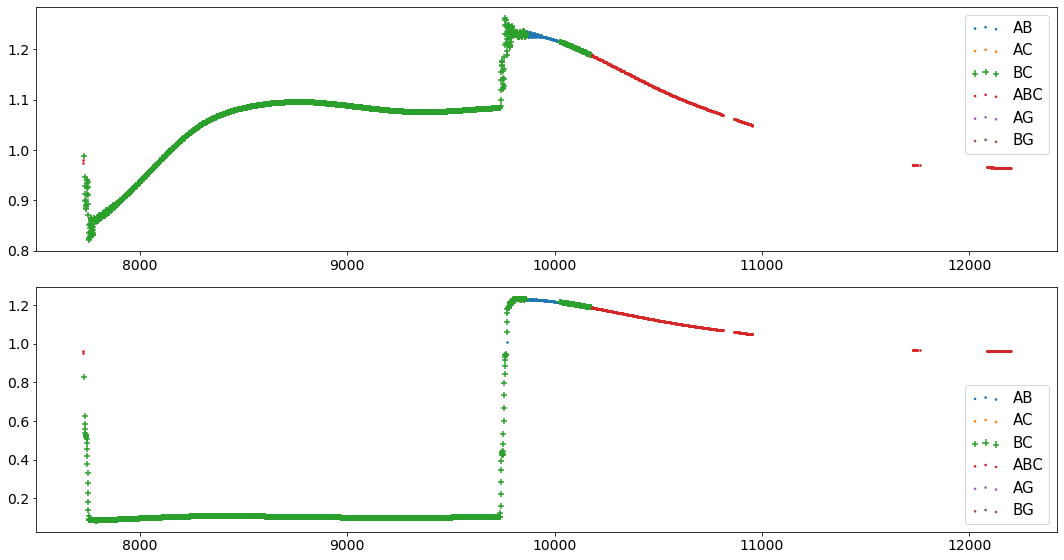


.
.
 10CG.csv
  Fault type Percentage
0        NML     89.79%
1      FAULT     10.21%


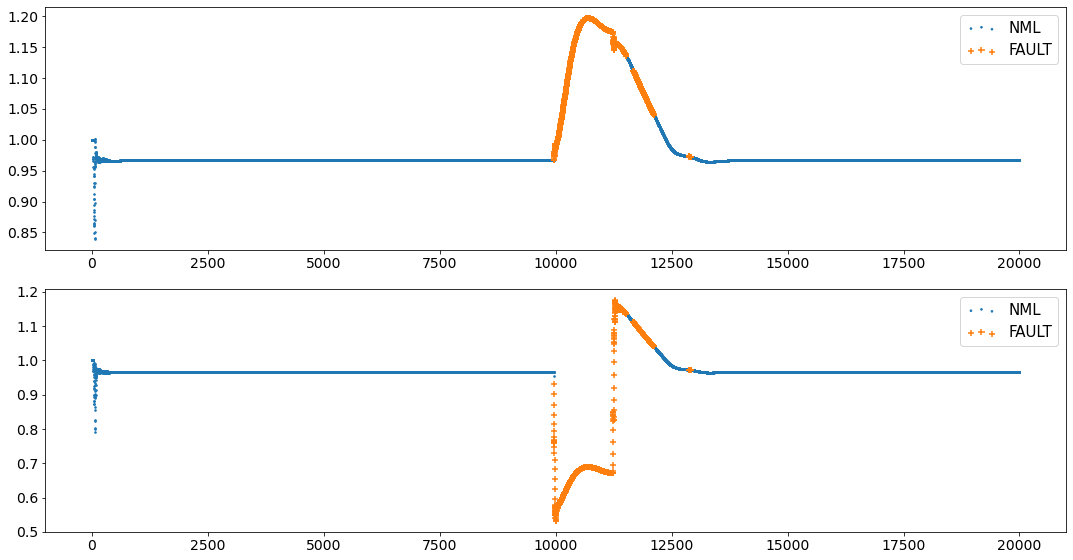

  Fault type Percentage
0         CG     63.52%
1        ABC     35.95%
2         BC      0.39%
3        ACG      0.15%


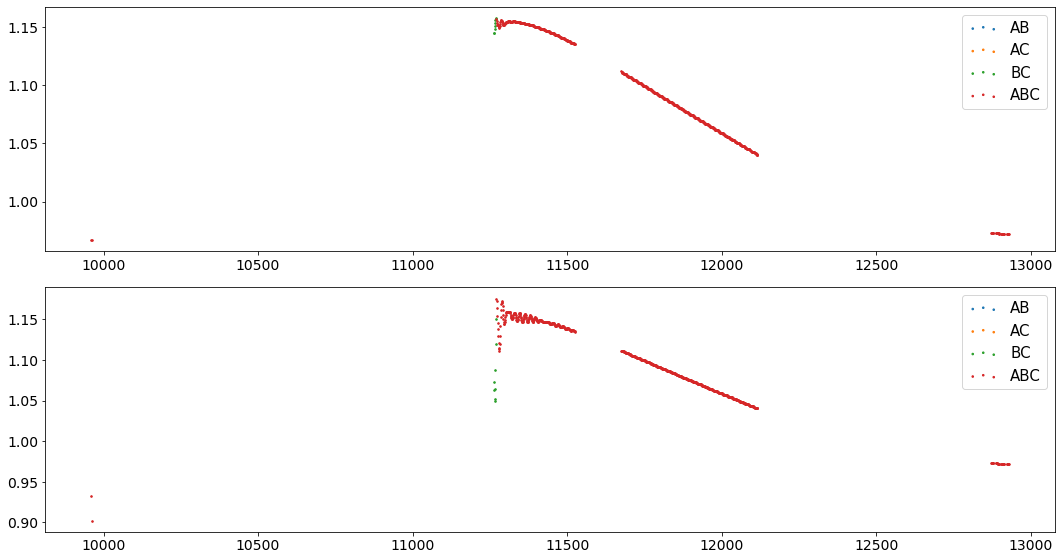


.
.
 10ABCG.csv
  Fault type Percentage
0        NML     67.44%
1      FAULT     32.56%


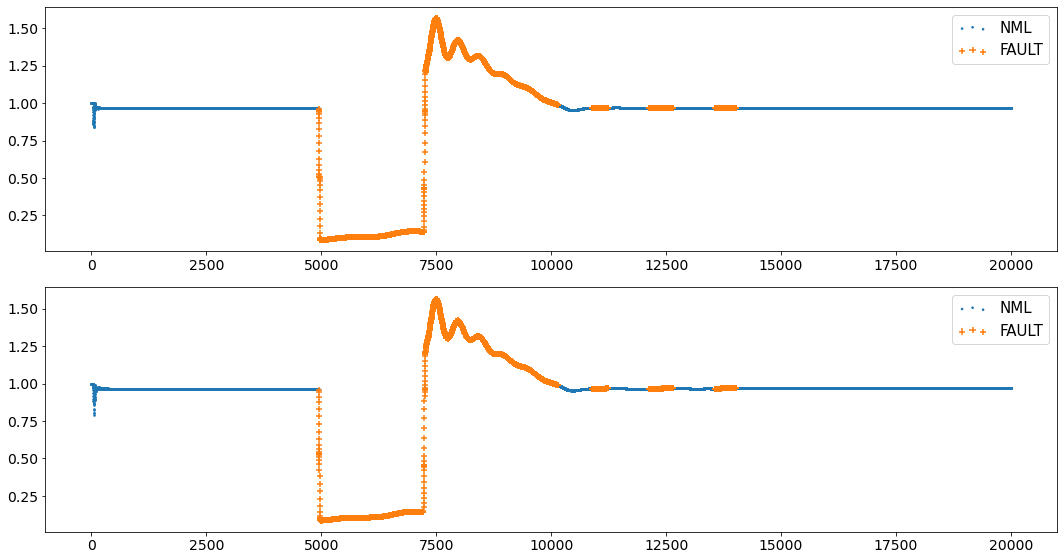

  Fault type Percentage
0        ABC     99.08%
1        ABG      0.57%
2       ABCG      0.12%
3        BCG      0.12%
4        ACG      0.11%


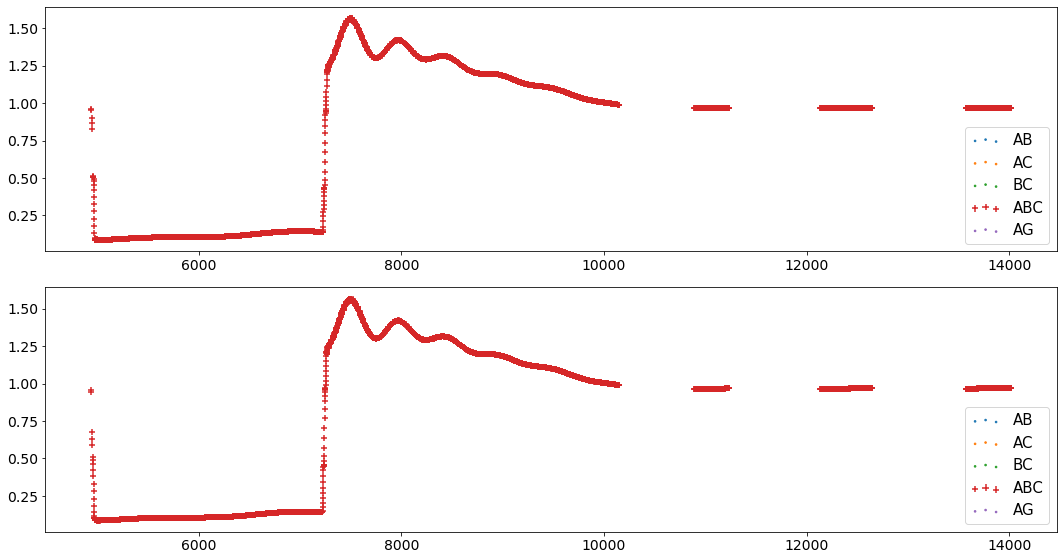


.
.
 6AG.csv
  Fault type Percentage
0        NML      74.3%
1      FAULT      25.7%


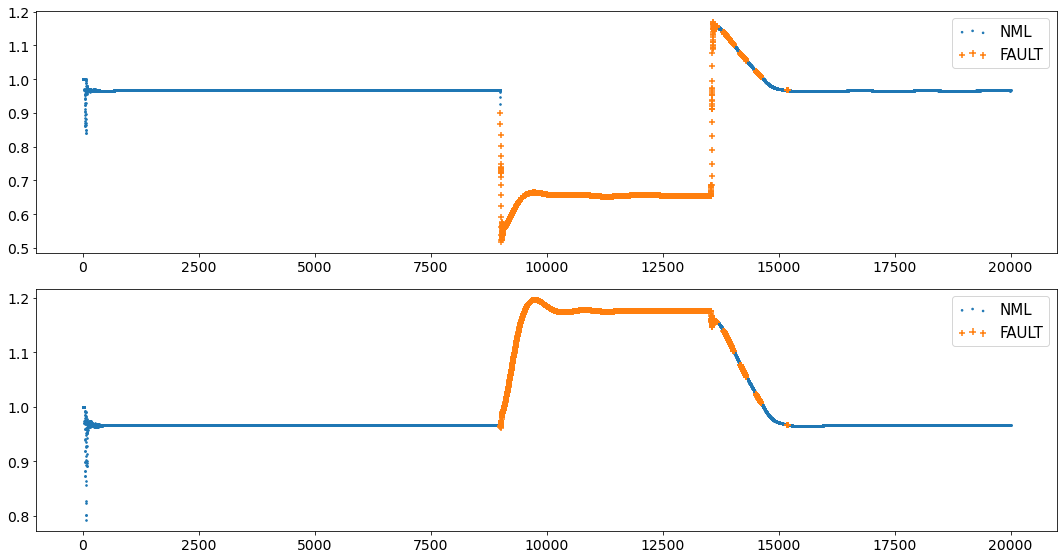

  Fault type Percentage
0         AG     88.76%
1        ABC      9.65%
2         BC      1.54%
3        ABG      0.04%
4        ACG      0.02%


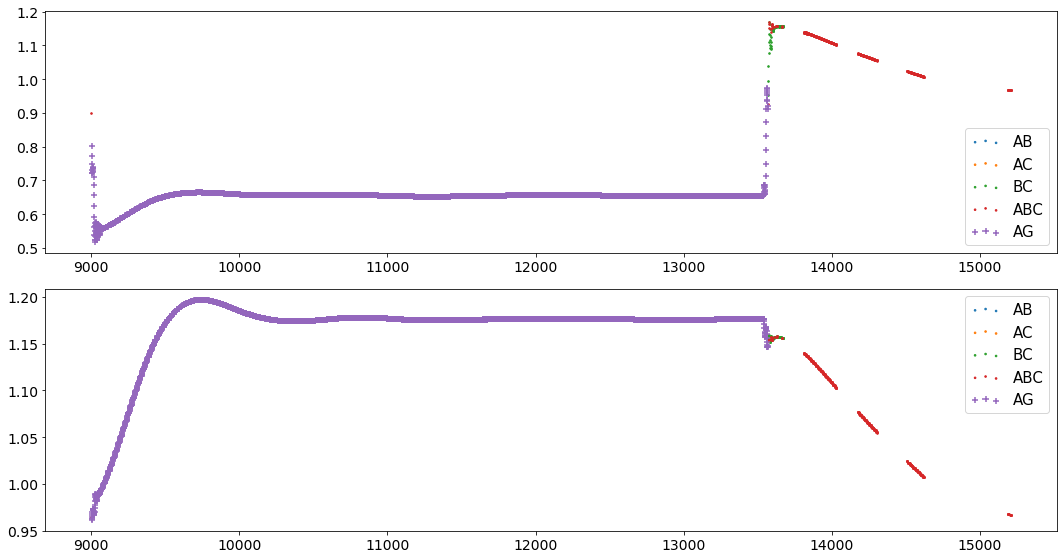


.
.
 3ABCG.csv
  Fault type Percentage
0        NML     93.36%
1      FAULT      6.63%


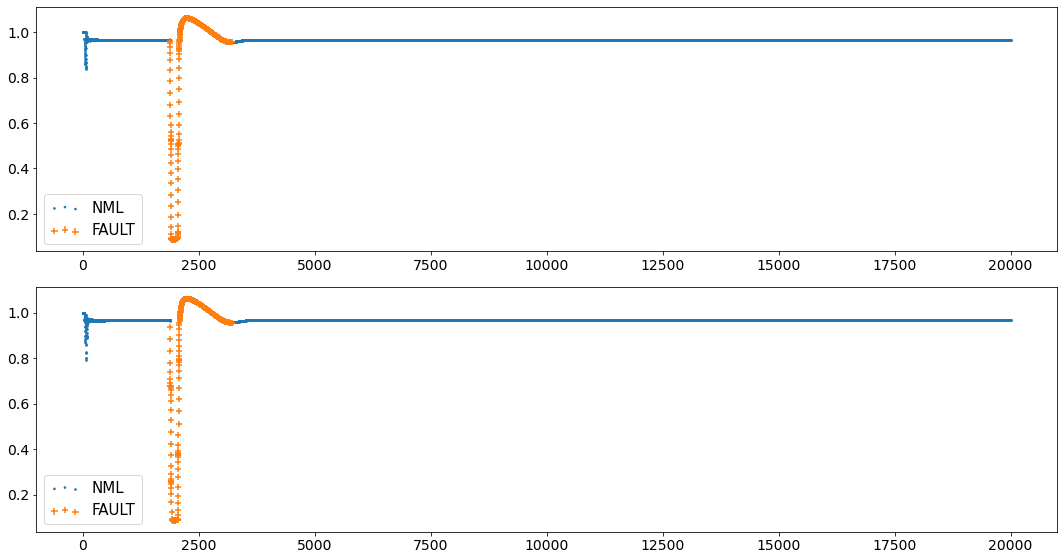

  Fault type Percentage
0        ABC     98.49%
1        BCG      1.36%
2       ABCG      0.15%


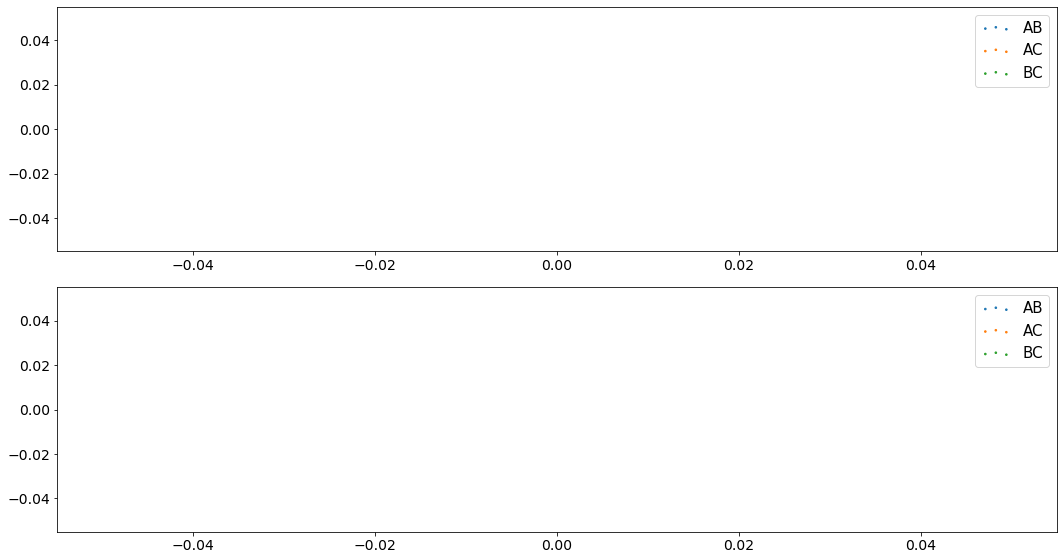


.
.
 2AC.csv
  Fault type Percentage
0        NML     99.76%
1      FAULT      0.24%


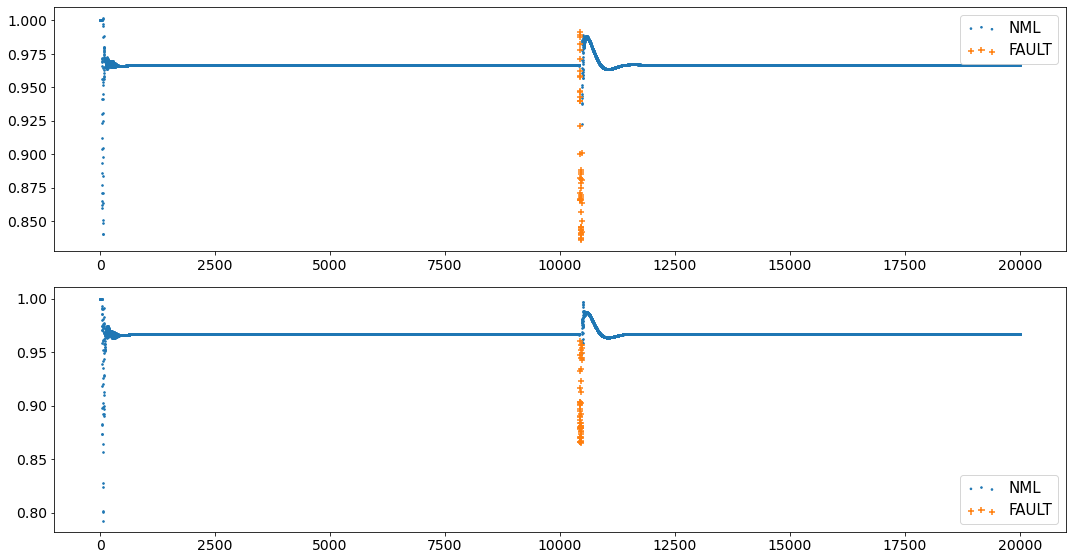

  Fault type Percentage
0         AC     56.25%
1        ACG     29.17%
2         BC      6.25%
3        ABC      6.25%
4         CG      2.08%


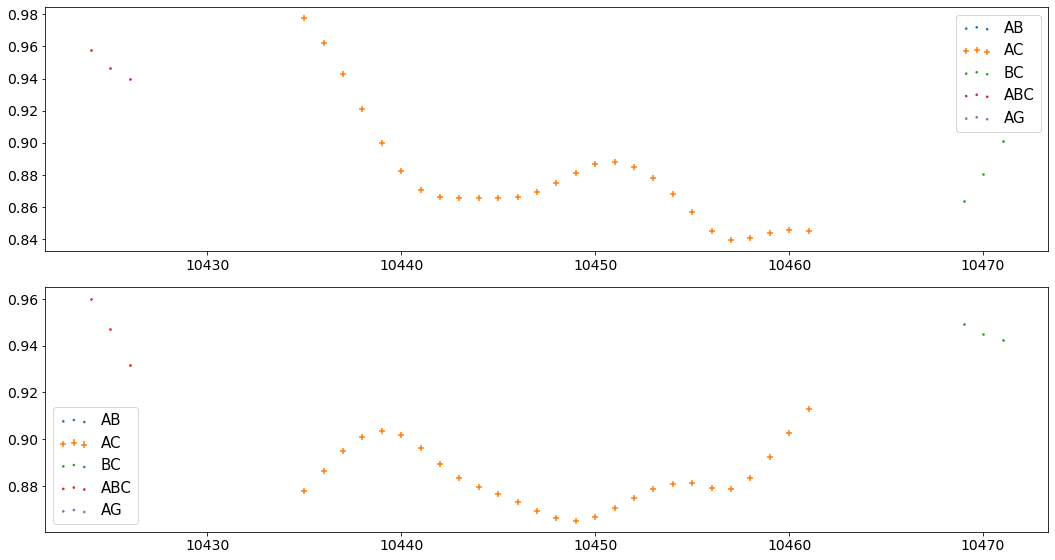


.
.
 4ACG.csv
  Fault type Percentage
0        NML     99.01%
1      FAULT      0.99%


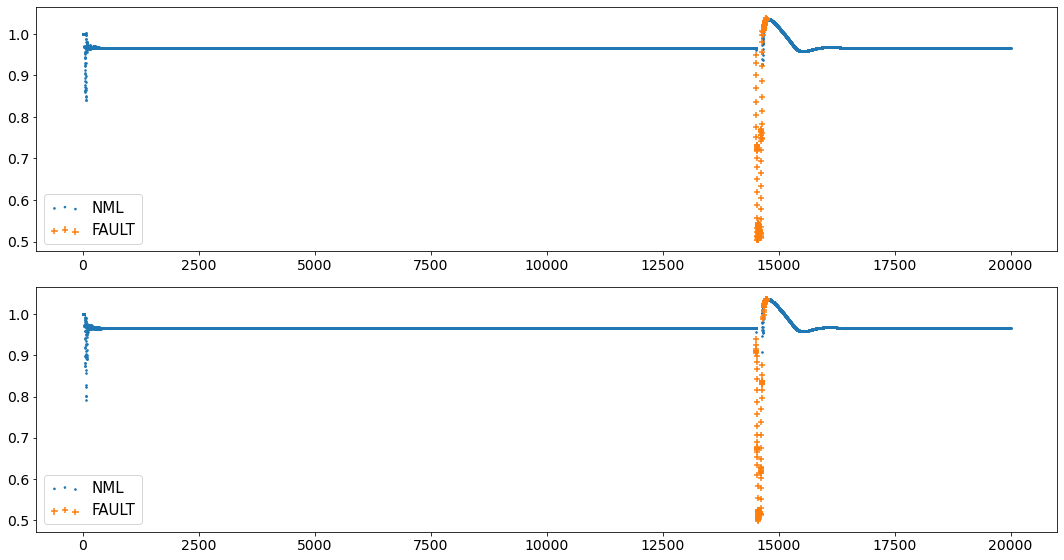

  Fault type Percentage
0        ACG     52.53%
1        ABC     38.89%
2         CG      3.54%
3         BC      2.53%
4         AG      1.52%
5        ABG      1.01%


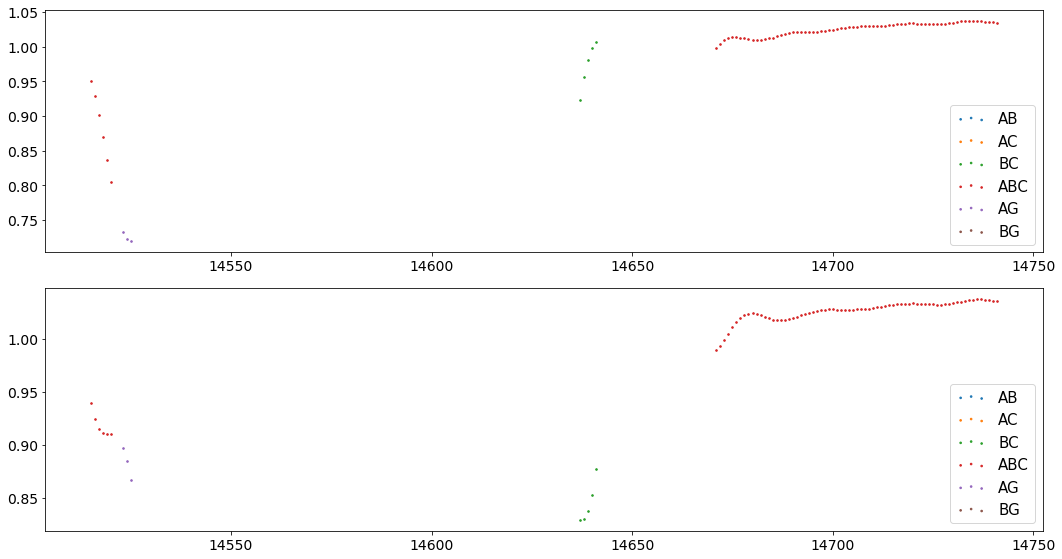


.
.
 4ABC.csv
  Fault type Percentage
0        NML     59.77%
1      FAULT     40.23%


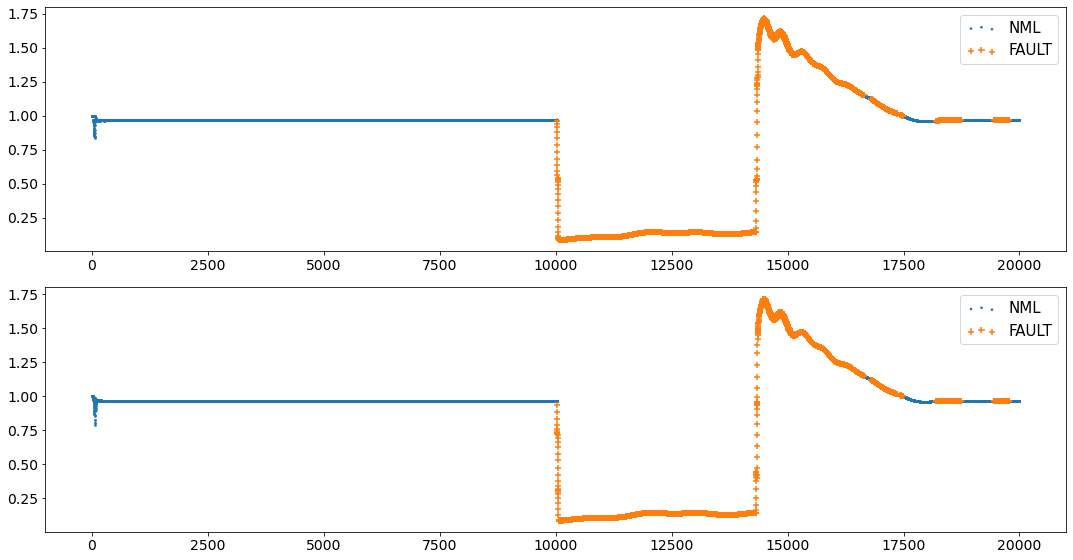

  Fault type Percentage
0        ABC     87.62%
1        ABG      4.62%
2        BCG      4.15%
3        ACG      1.55%
4         BC      1.06%
5         AC      0.91%
6       ABCG      0.09%


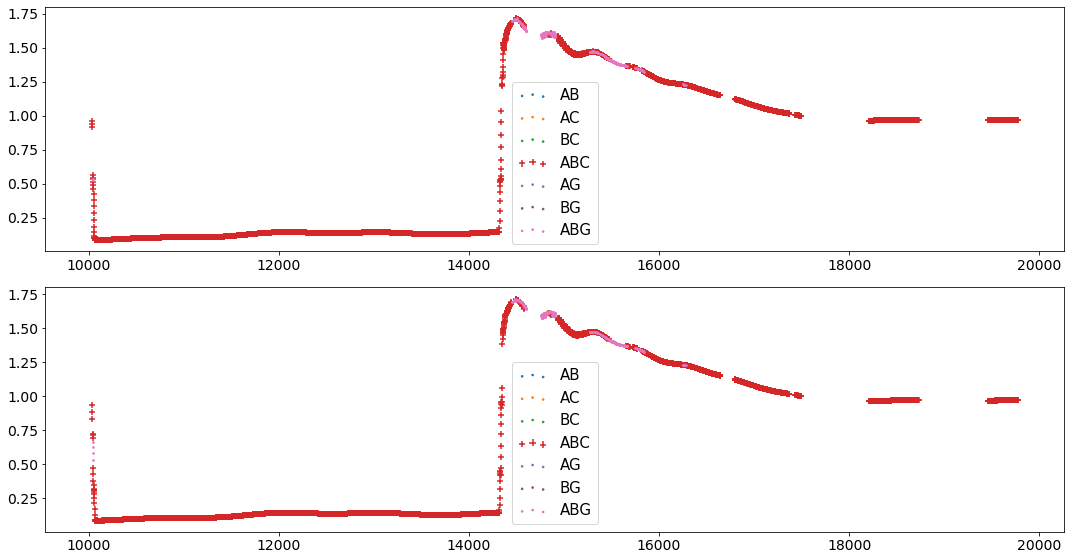


.
.
 8ABC.csv
  Fault type Percentage
0        NML     66.08%
1      FAULT     33.92%


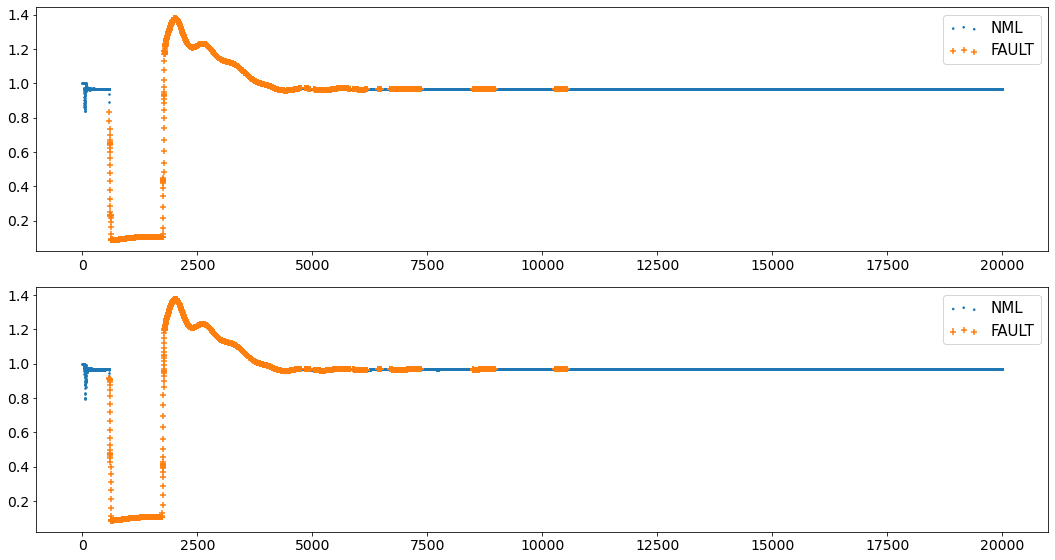

  Fault type Percentage
0        ABC     99.73%
1        ACG       0.1%
2        ABG       0.1%
3        BCG      0.03%
4       ABCG      0.03%


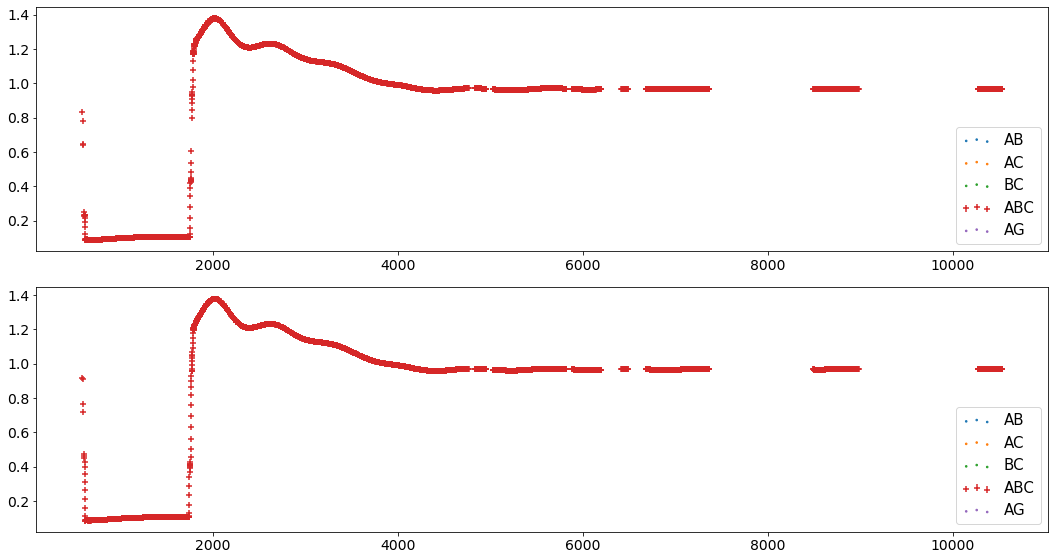


.
.
 8ACG.csv
  Fault type Percentage
0        NML     99.67%
1      FAULT      0.34%


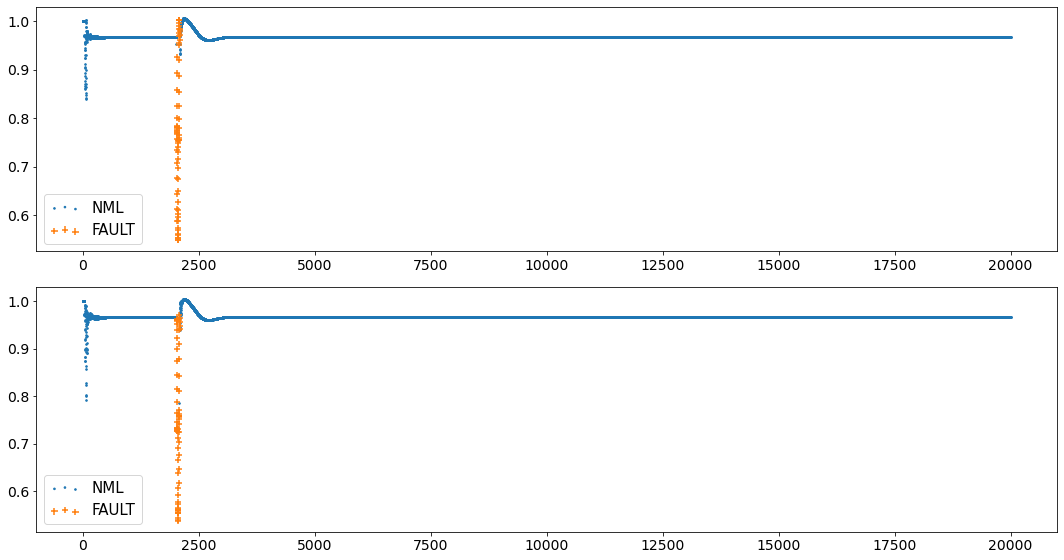

  Fault type Percentage
0        ACG     56.72%
1         CG     16.42%
2        ABC     13.43%
3         AB      5.97%
4         AG      2.99%
5        ABG      2.99%
6        BCG      1.49%


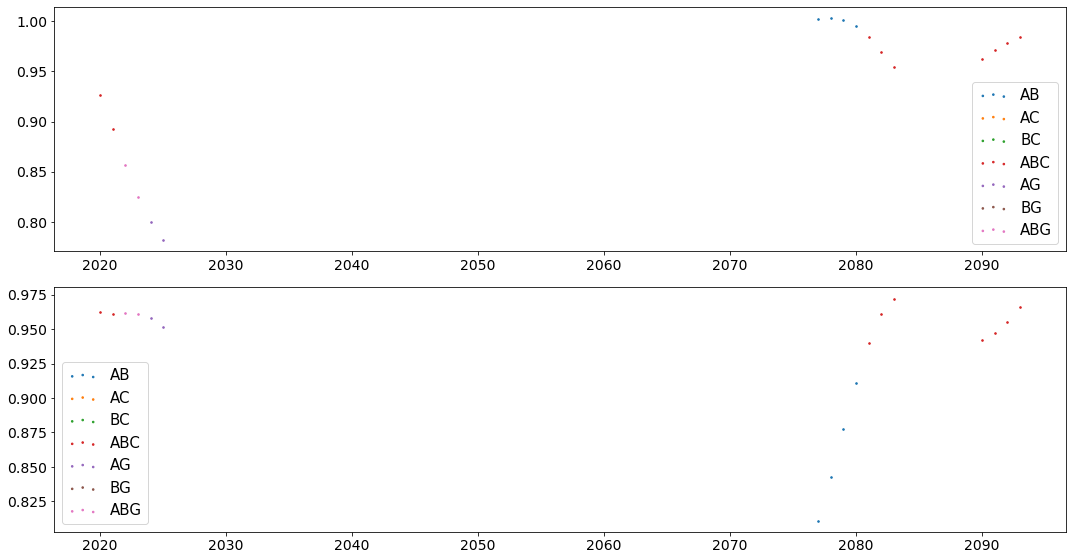


.
.
 4AG.csv
  Fault type Percentage
0        NML     71.19%
1      FAULT     28.82%


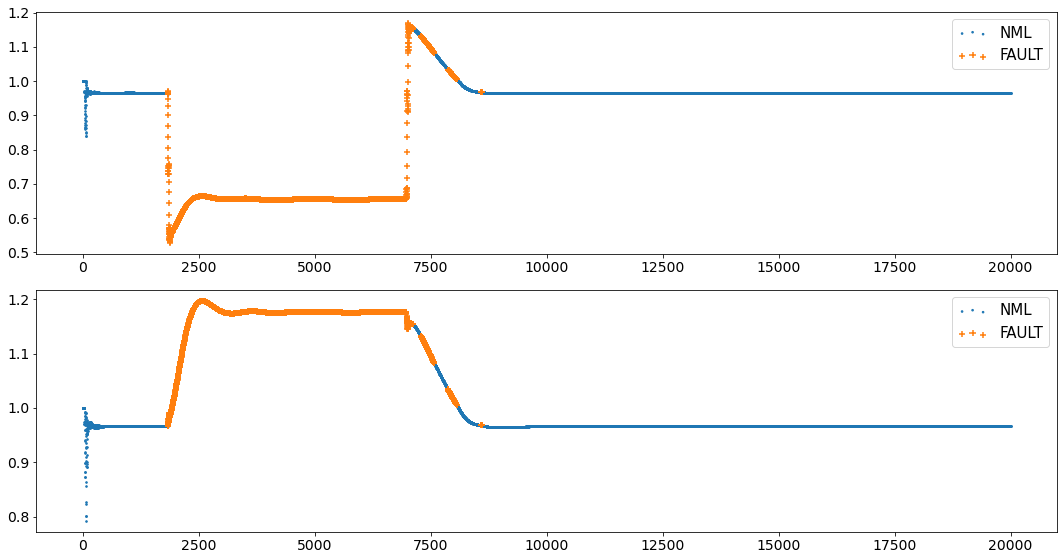

  Fault type Percentage
0         AG     89.57%
1        ABC      8.78%
2         BC      1.49%
3        ACG      0.16%


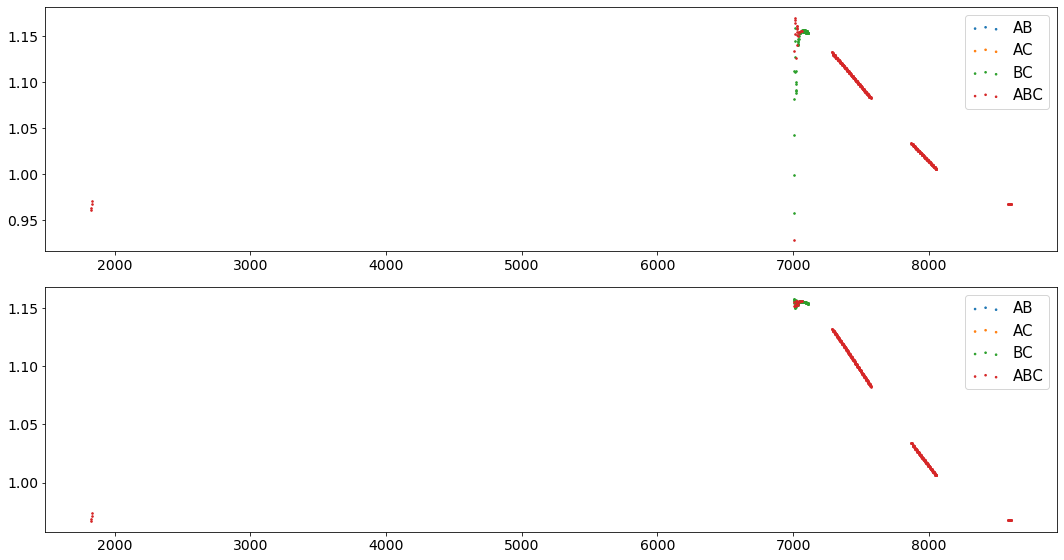


.
.
 6ABG.csv
  Fault type Percentage
0        NML     51.13%
1      FAULT     48.87%


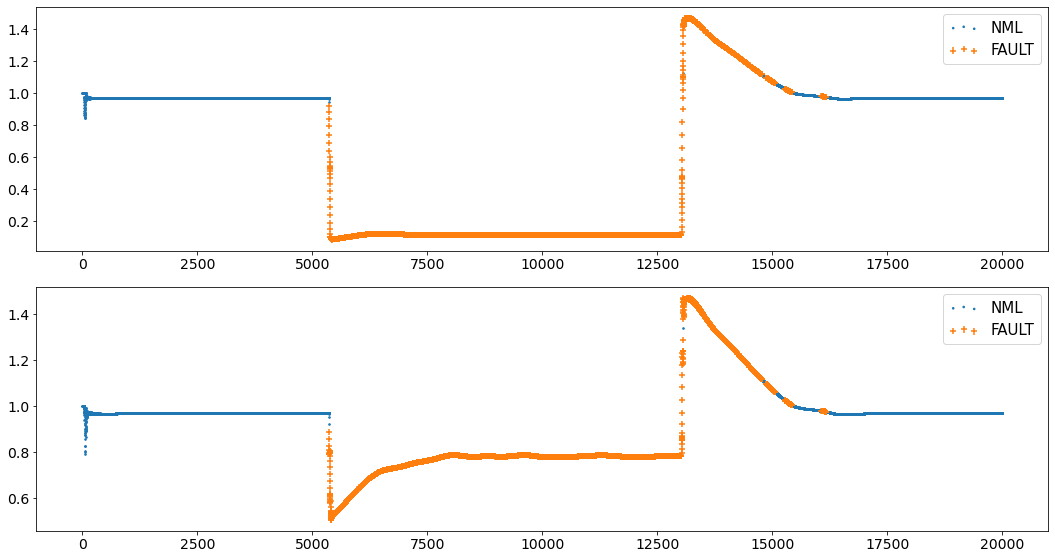

  Fault type Percentage
0        ABG      81.0%
1        ABC     11.56%
2        BCG      3.68%
3         BC      3.07%
4         AC      0.44%
5        ACG      0.12%
6         AG      0.07%
7         AB      0.05%


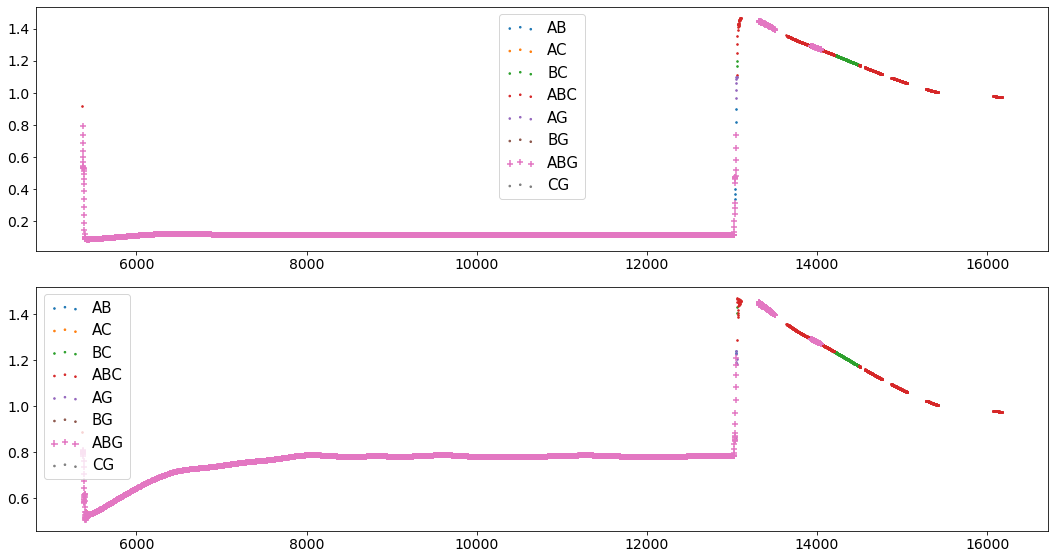


.
.
 8BG.csv
  Fault type Percentage
0        NML     90.97%
1      FAULT      9.03%


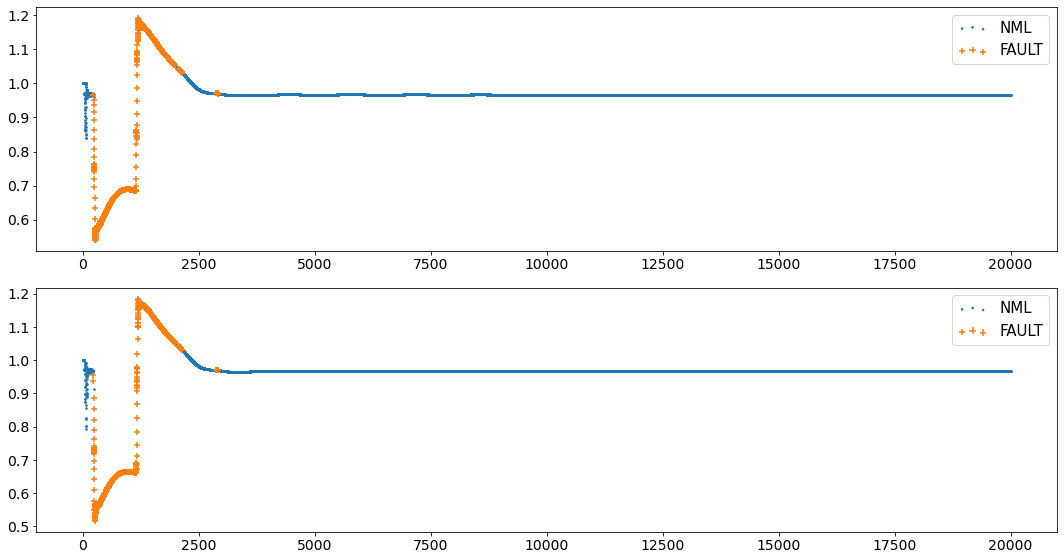

  Fault type Percentage
0         BG      52.1%
1        ABC     38.76%
2         BC      4.49%
3         AB      4.26%
4        ACG      0.22%
5        BCG      0.11%
6        ABG      0.06%


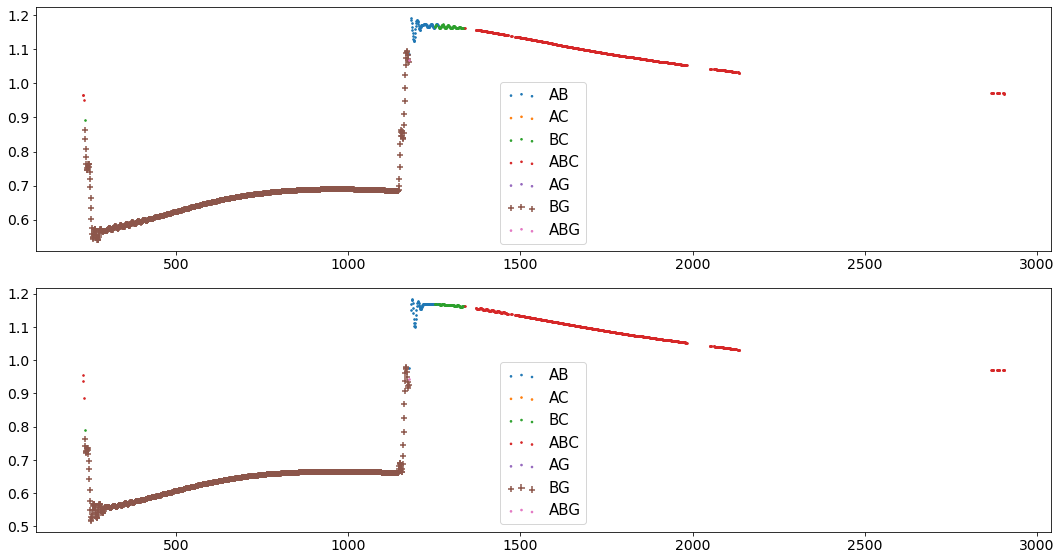


.
.
 7AC.csv
  Fault type Percentage
0        NML     86.91%
1      FAULT      13.1%


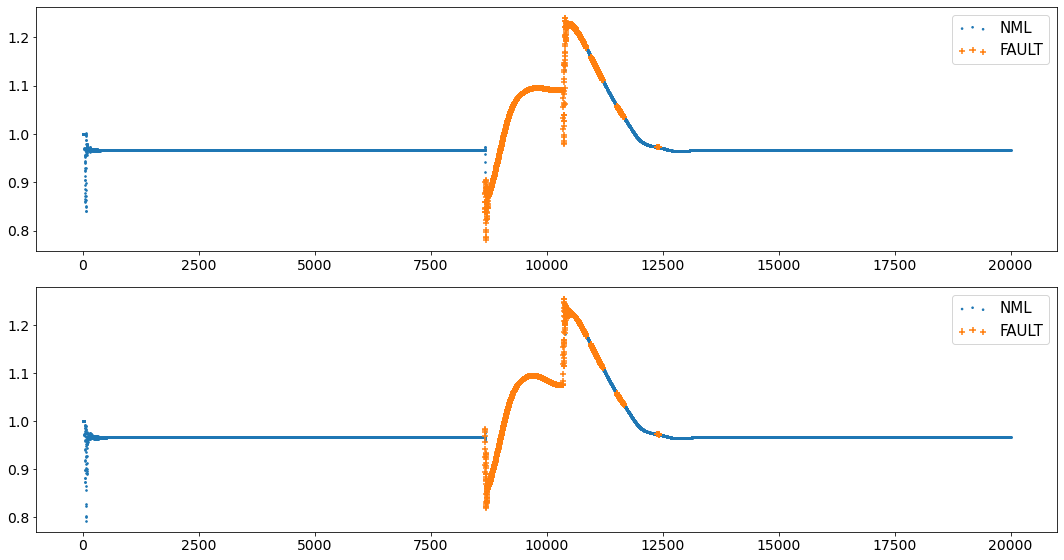

  Fault type Percentage
0         AC     64.26%
1        ABC     34.59%
2        ACG      0.92%
3         BC      0.19%
4       ABCG      0.04%


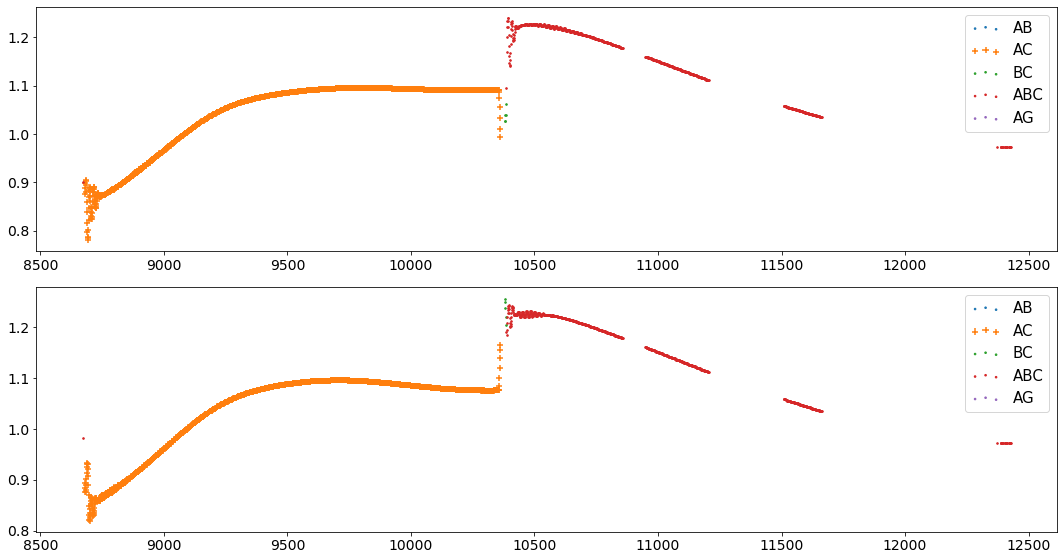


.
.
 3AG.csv
  Fault type Percentage
0        NML     85.81%
1      FAULT     14.19%


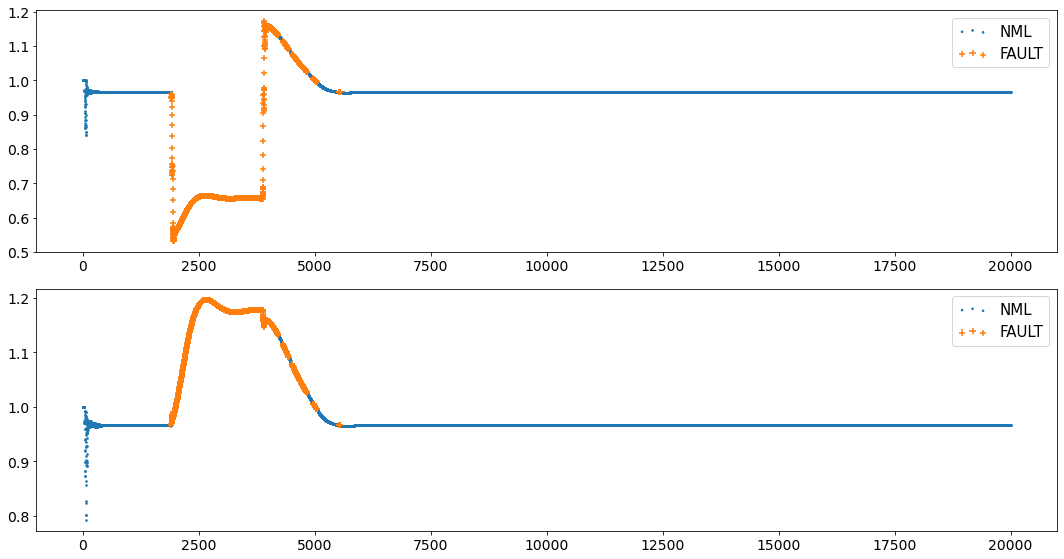

  Fault type Percentage
0         AG     69.76%
1        ABC     19.03%
2         BC     10.72%
3        ACG      0.49%


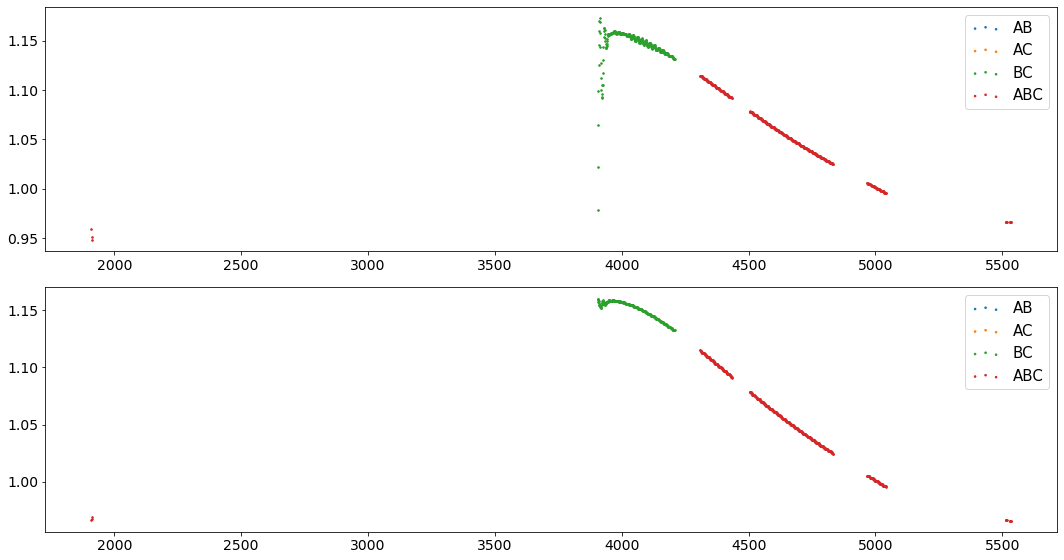


.
.
 1ABCG.csv
  Fault type Percentage
0        NML     98.19%
1      FAULT      1.81%


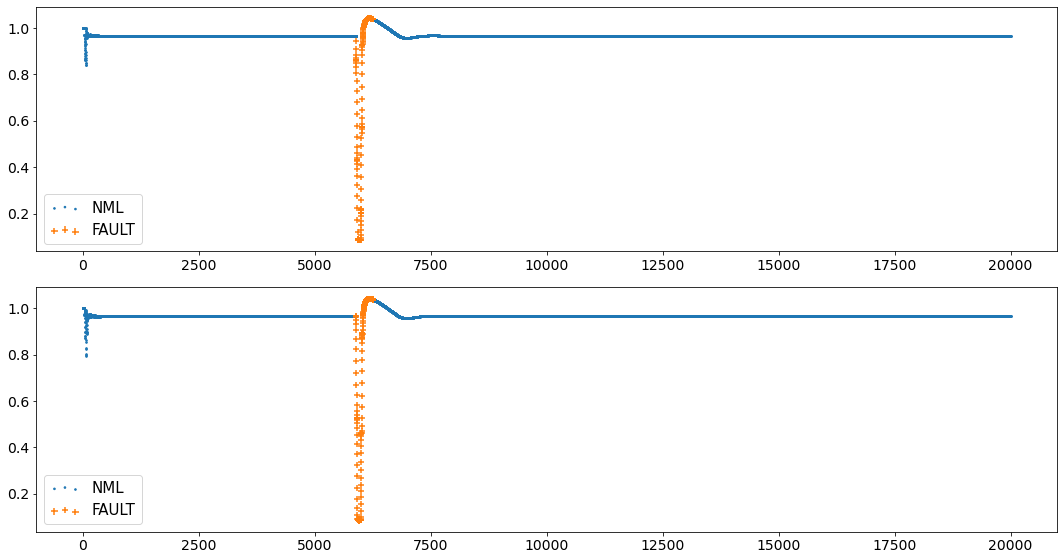

  Fault type Percentage
0        ABC     93.66%
1        ACG      2.75%
2        BCG       2.2%
3        ABG      0.83%
4       ABCG      0.55%


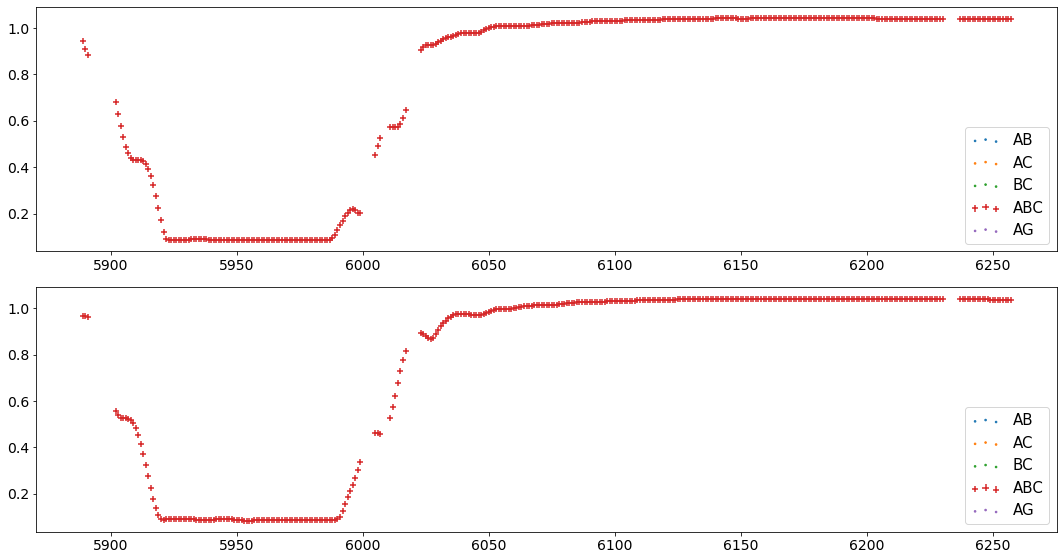


.
.
 7AB.csv
  Fault type Percentage
0        NML     62.22%
1      FAULT     37.78%


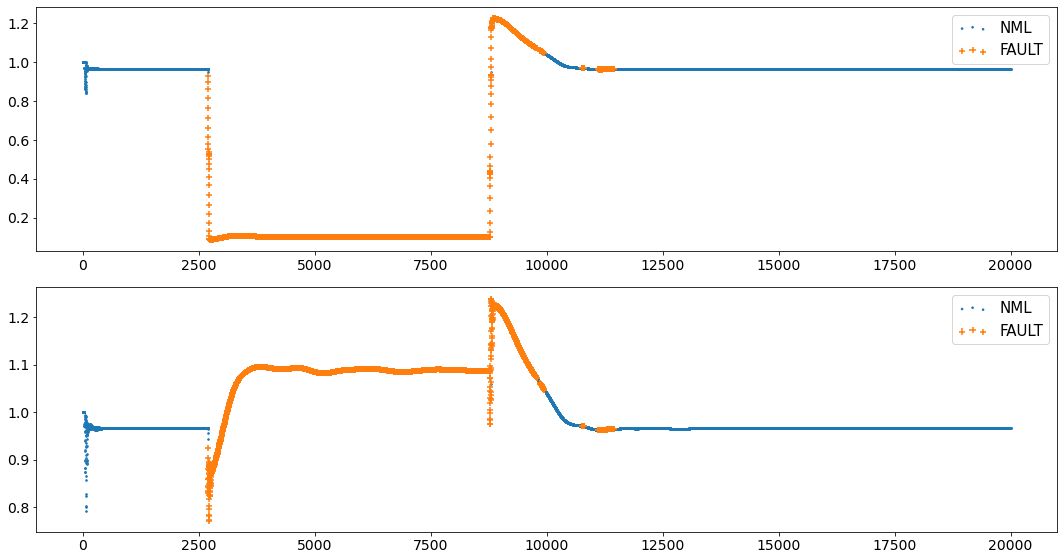

  Fault type Percentage
0         AB     82.56%
1        ABC     15.66%
2         BC      1.71%
3        ABG      0.07%
4        BCG      0.01%


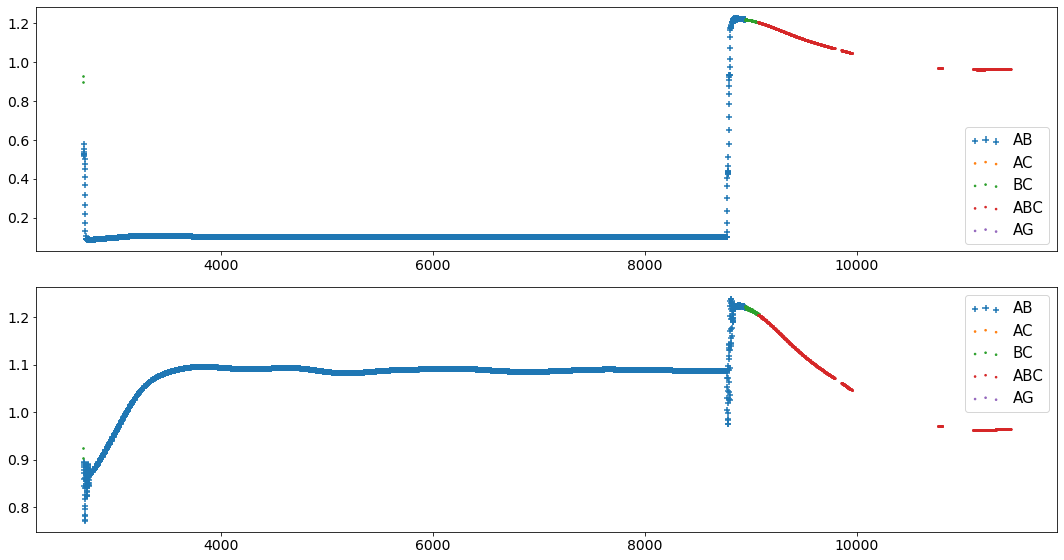


.
.
 6BCG.csv
  Fault type Percentage
0        NML     75.41%
1      FAULT     24.59%


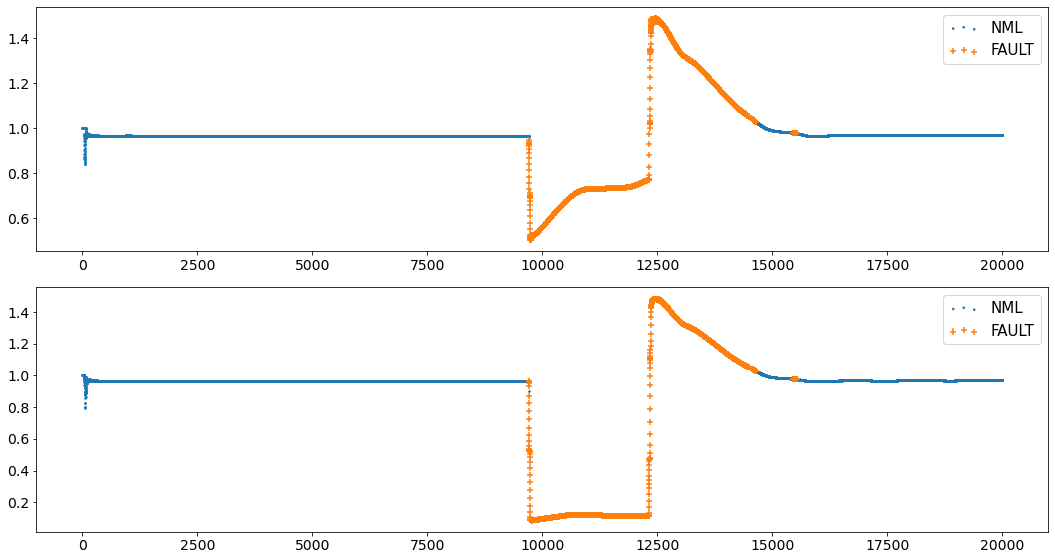

  Fault type Percentage
0        BCG     63.52%
1        ABC     26.72%
2        ACG      3.01%
3        ABG      2.68%
4         BC      2.62%
5         AB      0.77%
6         AC      0.47%
7         BG       0.1%
8         CG       0.1%


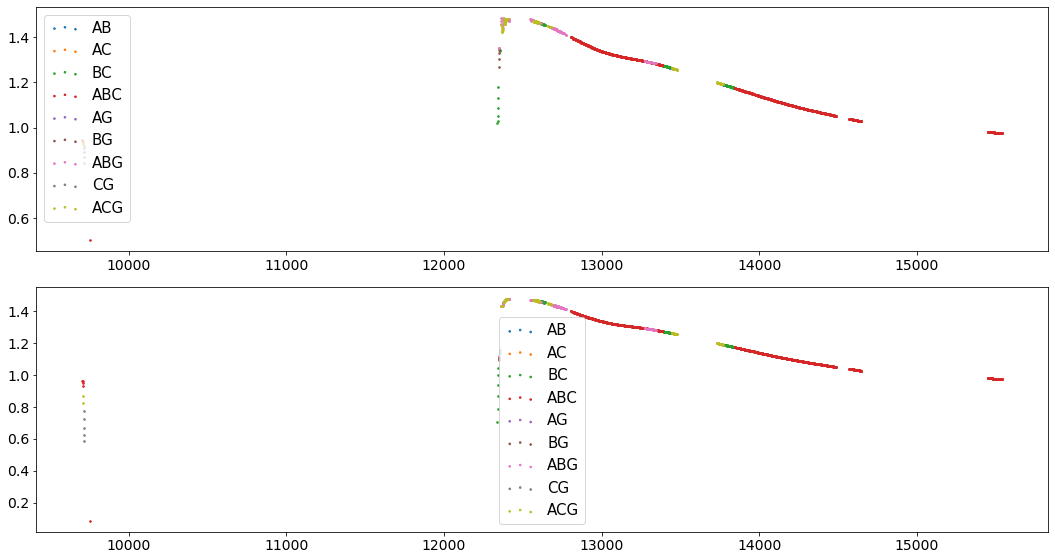


.
.
 5AB.csv
  Fault type Percentage
0        NML     85.39%
1      FAULT     14.61%


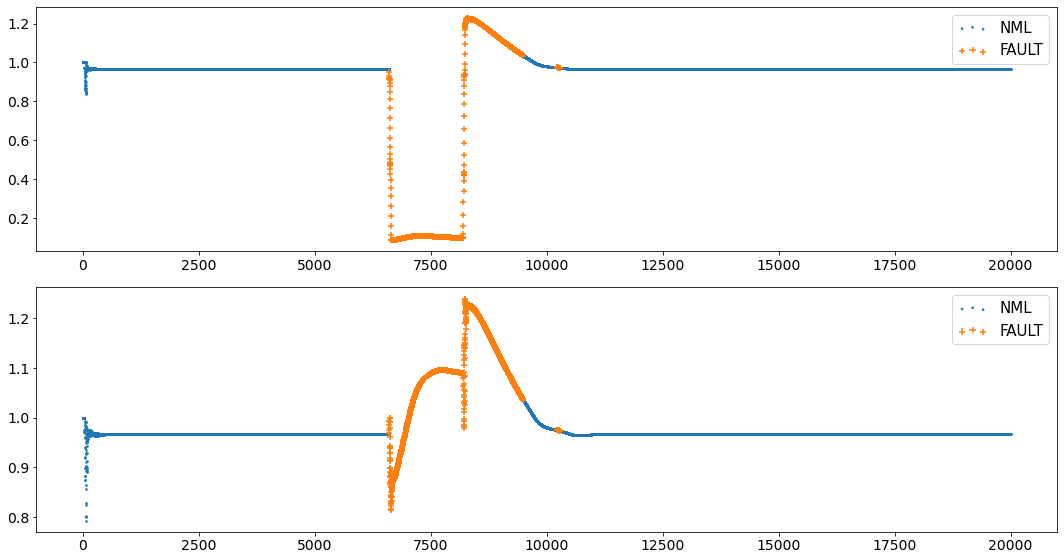

  Fault type Percentage
0         AB      54.3%
1        ABC     44.71%
2        ABG      0.82%
3        ACG       0.1%
4         AC      0.07%


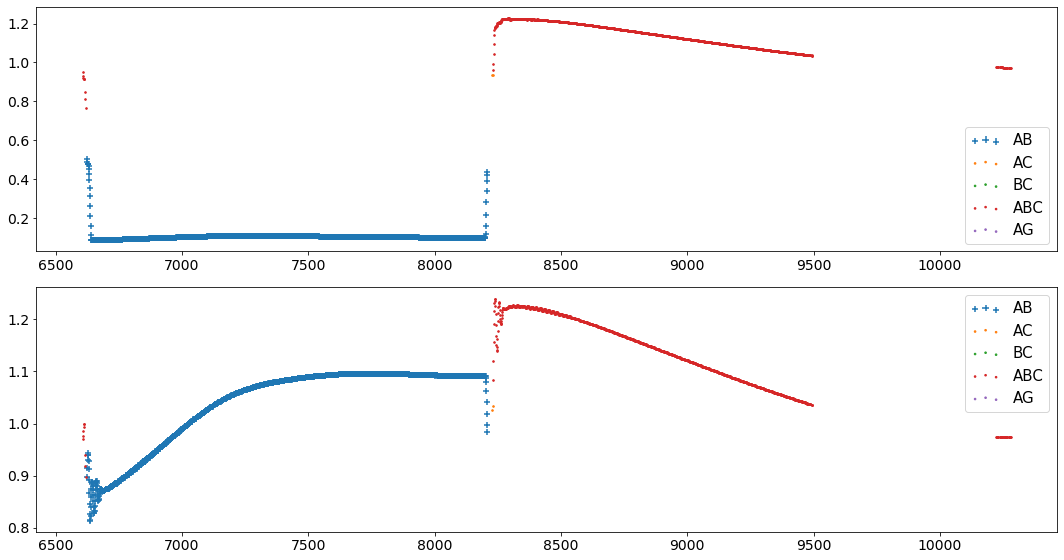


.
.
 9CG.csv
  Fault type Percentage
0        NML     66.78%
1      FAULT     33.23%


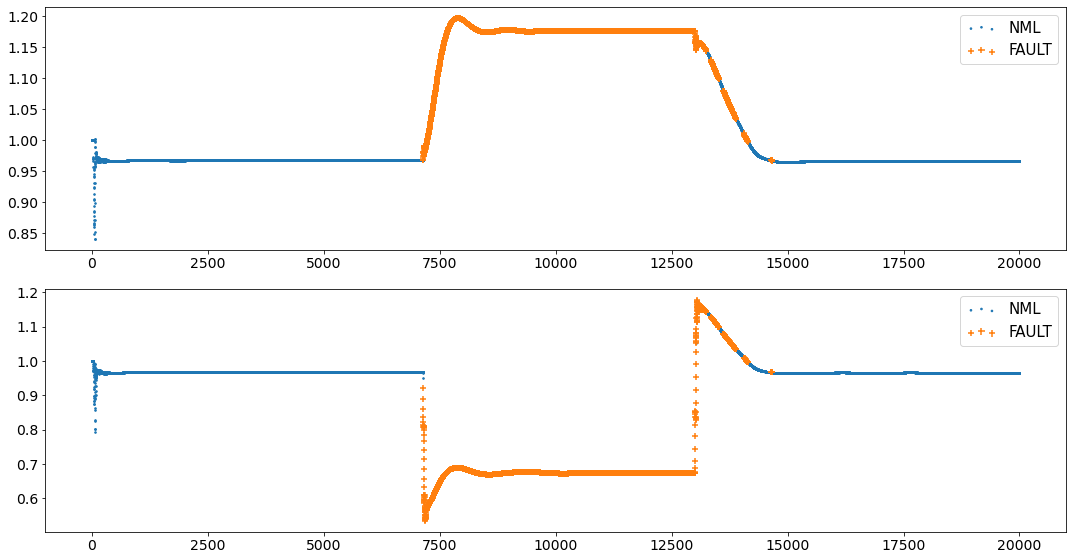

  Fault type Percentage
0         CG     88.53%
1        ABC      8.25%
2         BC      3.19%
3        ACG      0.03%


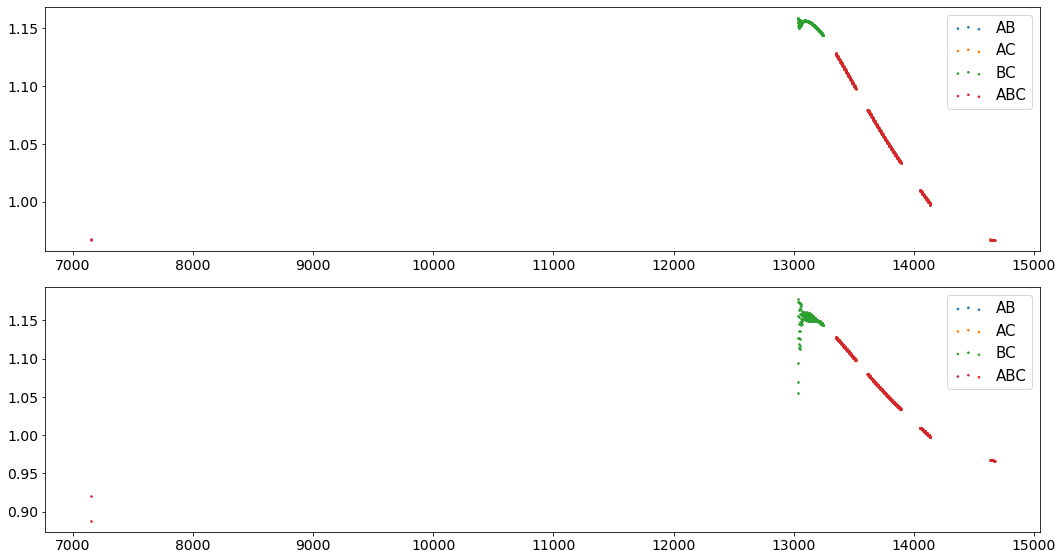


.
.
 9BC.csv
  Fault type Percentage
0        NML     79.21%
1      FAULT     20.79%


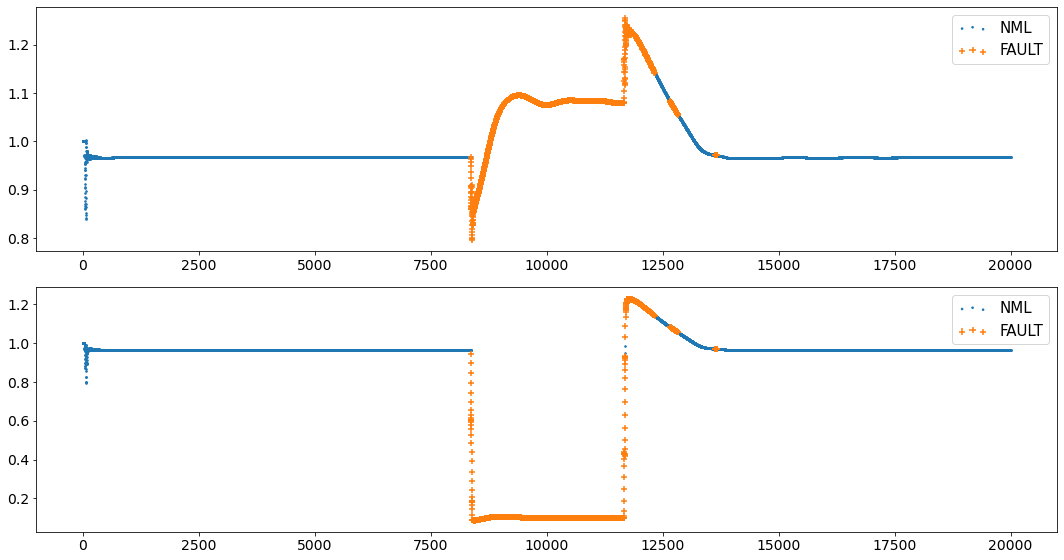

  Fault type Percentage
0         BC      79.8%
1        ABC     19.84%
2        BCG      0.22%
3        ABG      0.07%
4         AB      0.05%
5         BG      0.02%


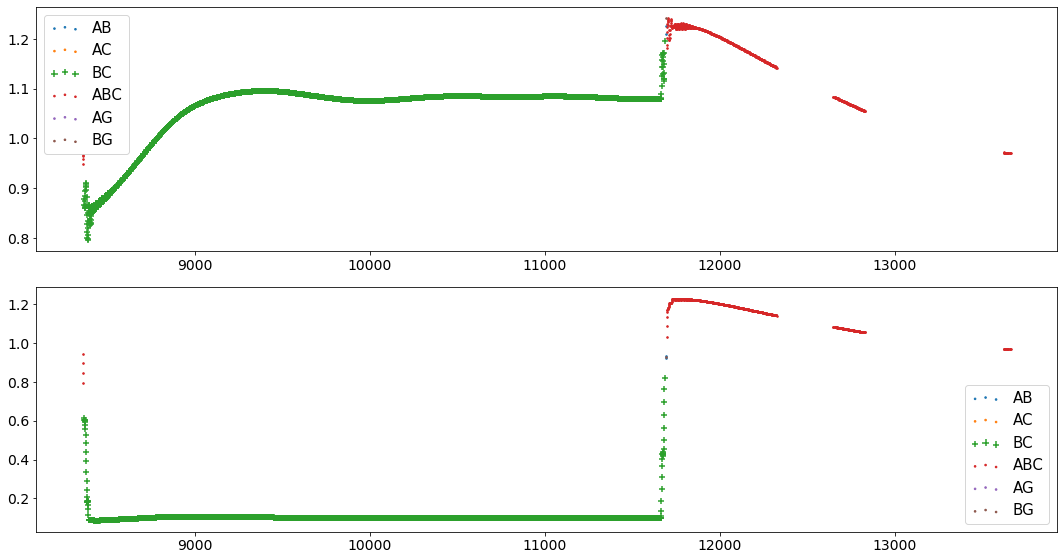


.
.
 2ABG.csv
  Fault type Percentage
0        NML     78.83%
1      FAULT     21.17%


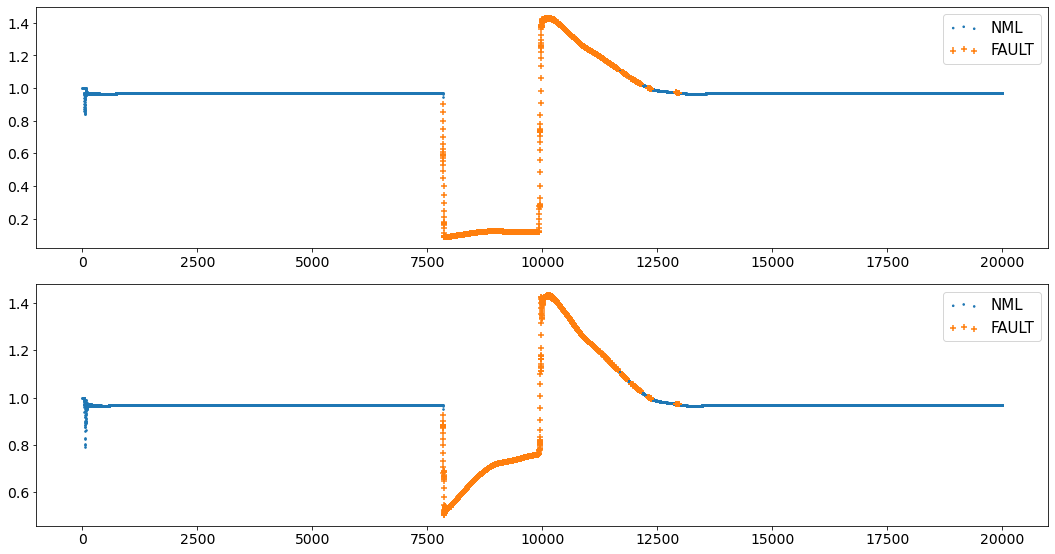

  Fault type Percentage
0        ABG     55.69%
1        ABC     23.85%
2         BC      5.98%
3        ACG       5.5%
4        BCG      4.53%
5         AB      3.57%
6         AC      0.71%
7         BG      0.12%
8       ABCG      0.05%


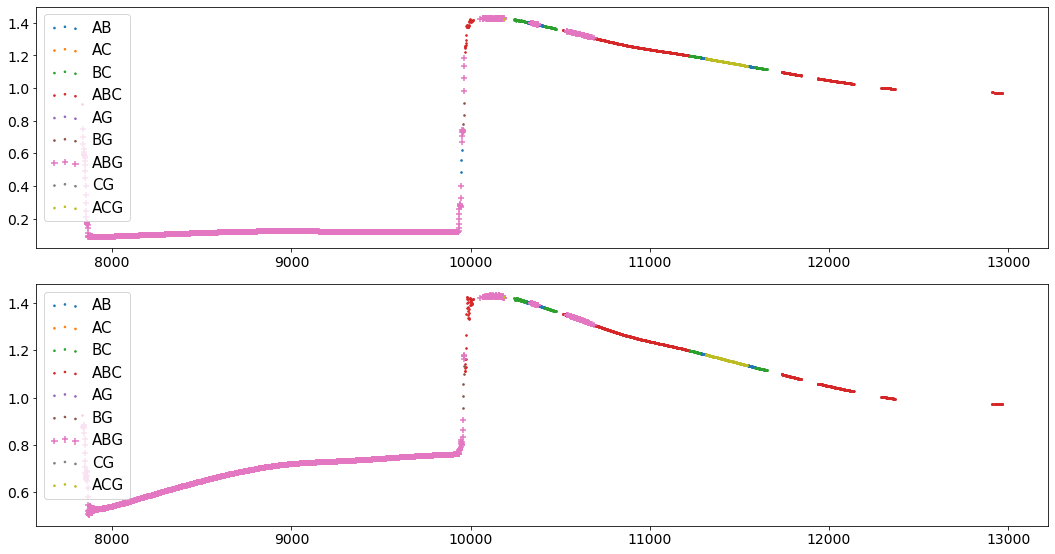


.
.
 1AG.csv
  Fault type Percentage
0      FAULT     50.53%
1        NML     49.47%


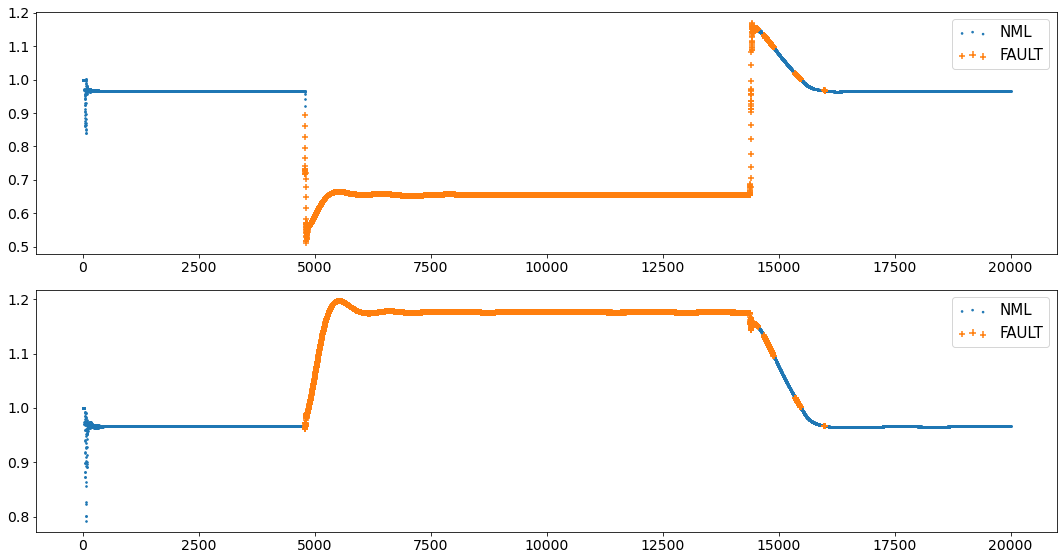

  Fault type Percentage
0         AG     95.18%
1        ABC       3.4%
2         BC      1.38%
3        ACG      0.02%
4        ABG      0.02%


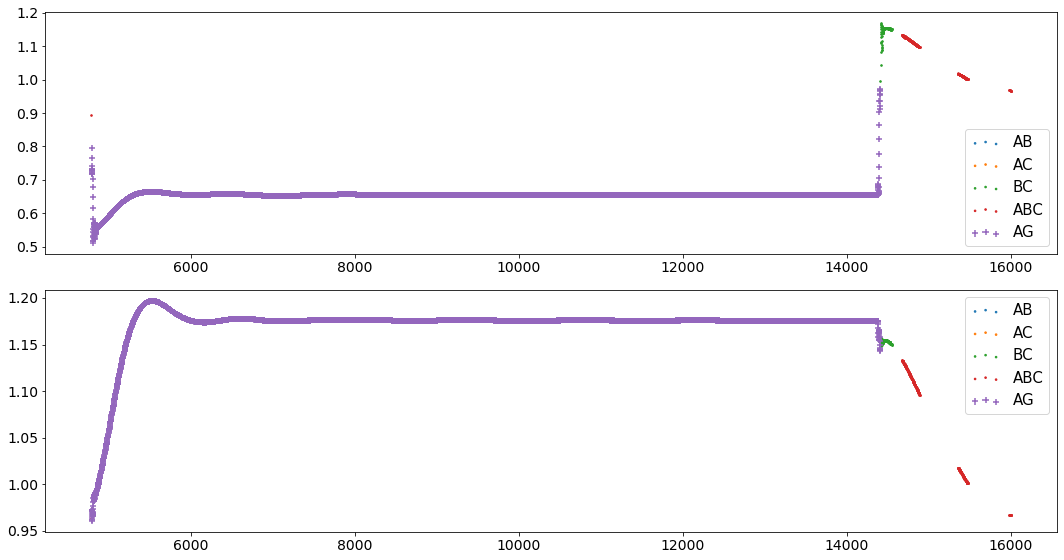


.
.
 8ABCG.csv
  Fault type Percentage
0        NML     82.39%
1      FAULT     17.61%


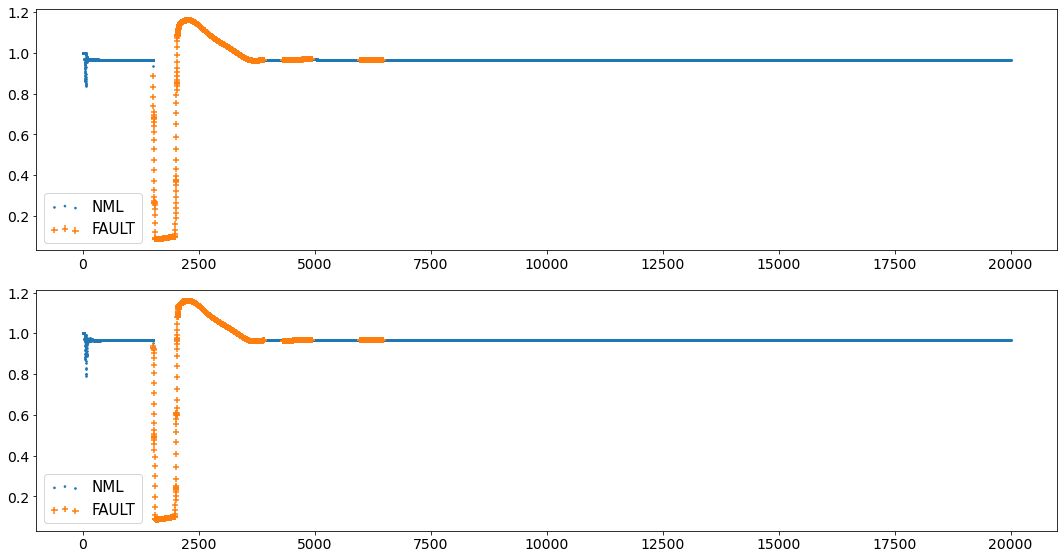

  Fault type Percentage
0        ABC     98.92%
1        ACG      0.43%
2       ABCG      0.28%
3        ABG       0.2%
4         CG      0.11%
5        BCG      0.06%


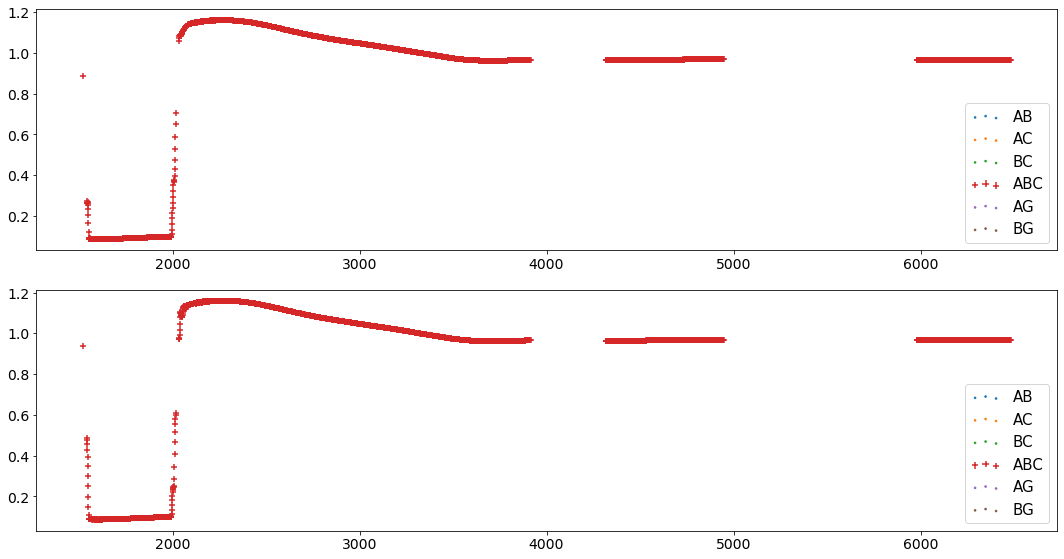


.
.
 5AC.csv
  Fault type Percentage
0        NML     67.81%
1      FAULT     32.19%


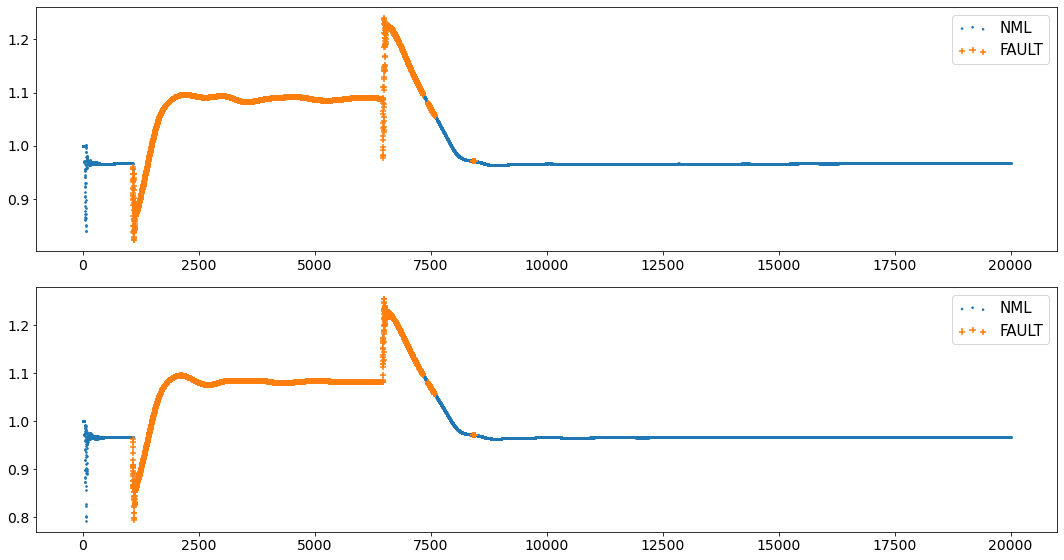

  Fault type Percentage
0         AC     84.02%
1        ABC     12.12%
2         BC      3.62%
3        ACG      0.14%
4         AB      0.08%
5        BCG      0.02%
6         CG      0.02%


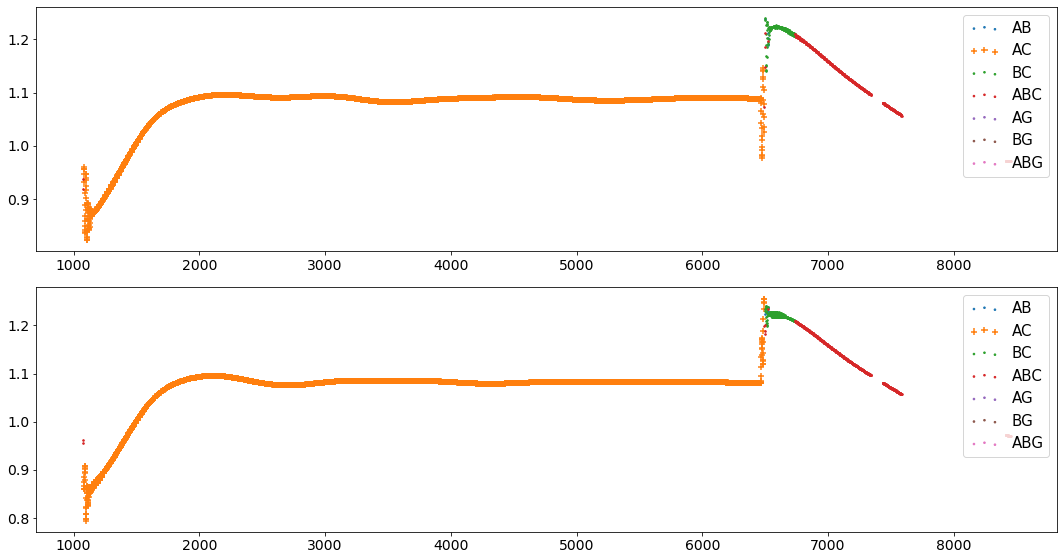


.
.
 5AG.csv
  Fault type Percentage
0        NML     88.59%
1      FAULT      11.4%


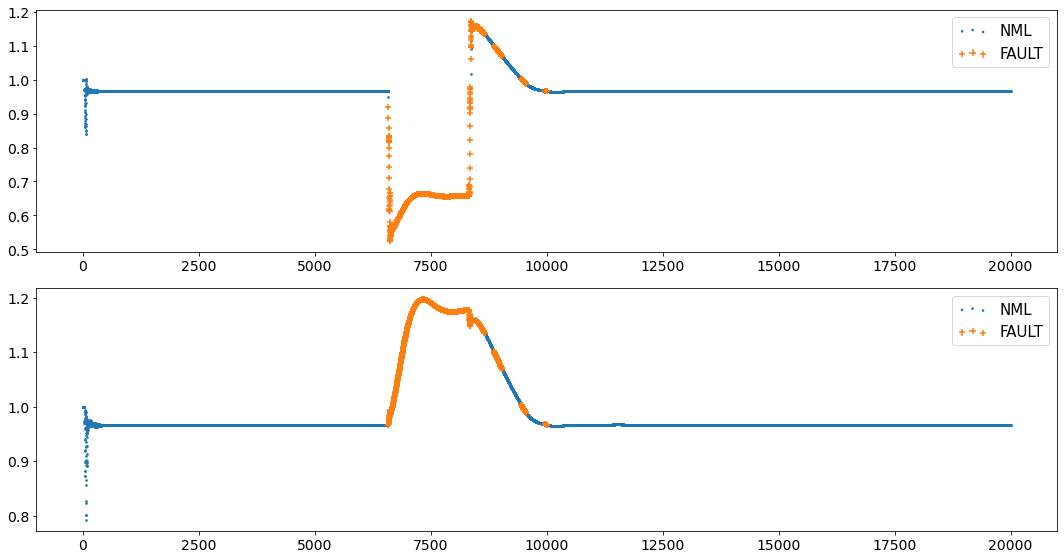

  Fault type Percentage
0         AG     77.25%
1        ABC     14.56%
2         BC      8.02%
3        ACG      0.09%
4        ABG      0.09%


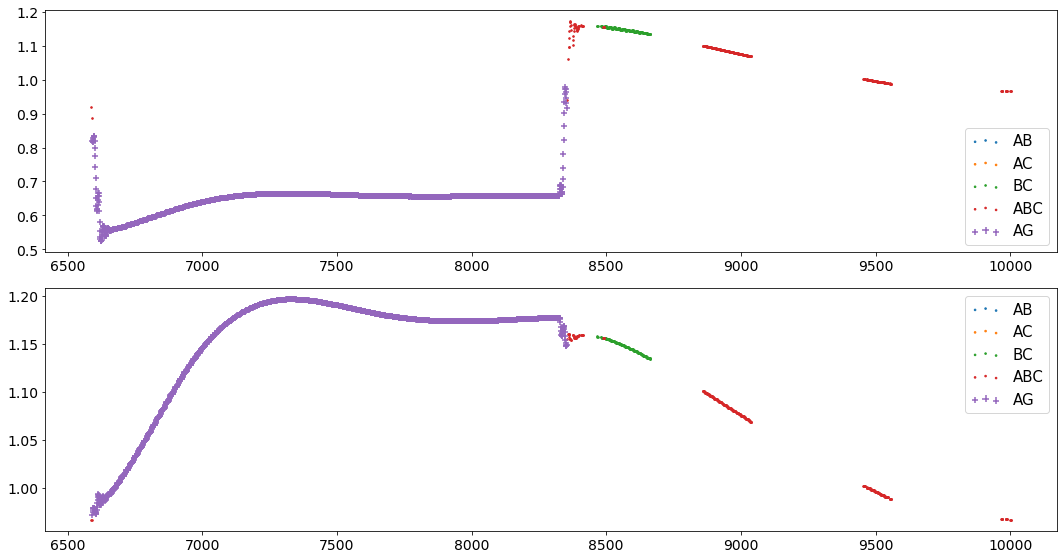


.
.
 1AC.csv
  Fault type Percentage
0        NML     86.92%
1      FAULT     13.07%


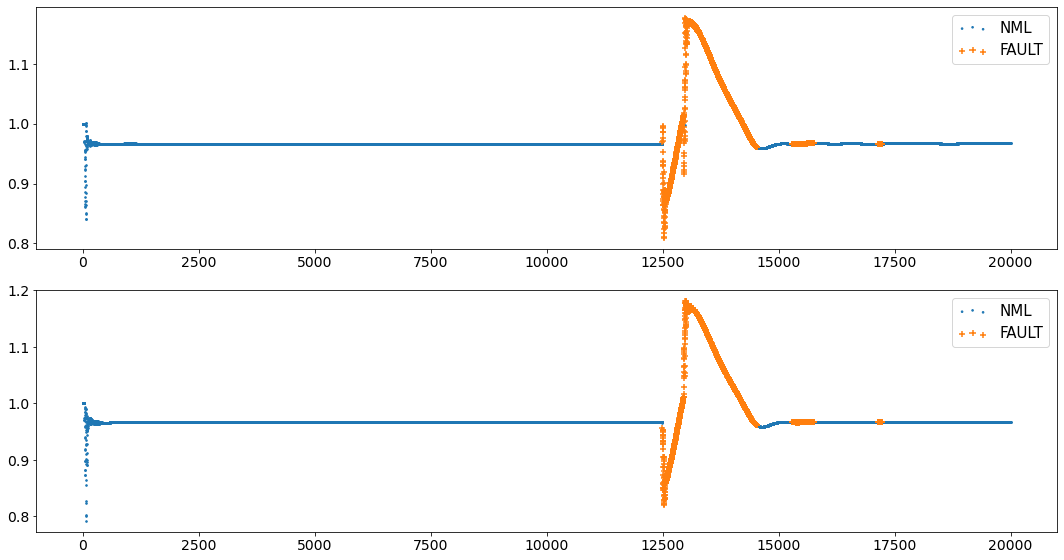

  Fault type Percentage
0        ABC     81.72%
1         AC     17.25%
2        ACG      1.03%


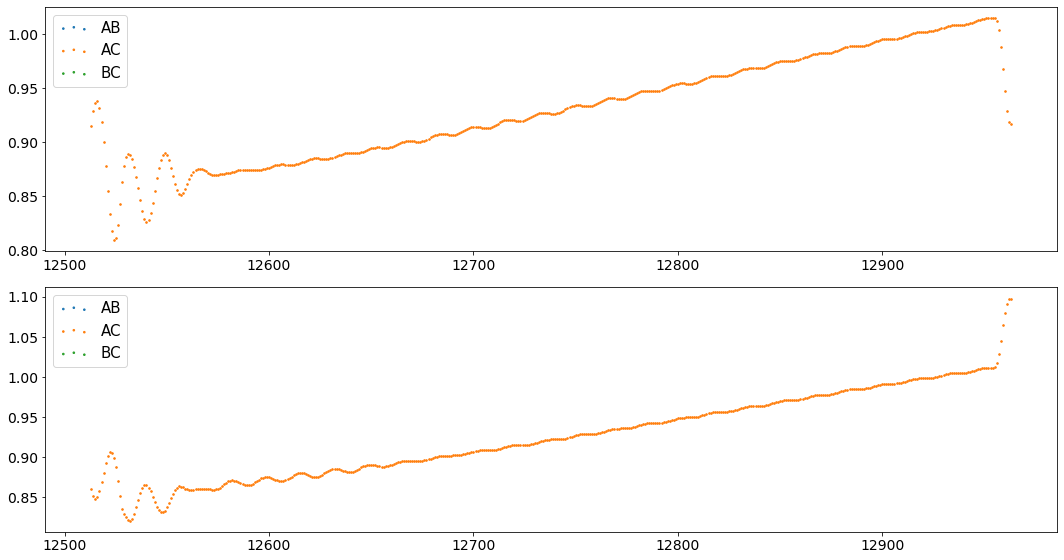


.
.
 2ACG.csv
  Fault type Percentage
0        NML     99.47%
1      FAULT      0.53%


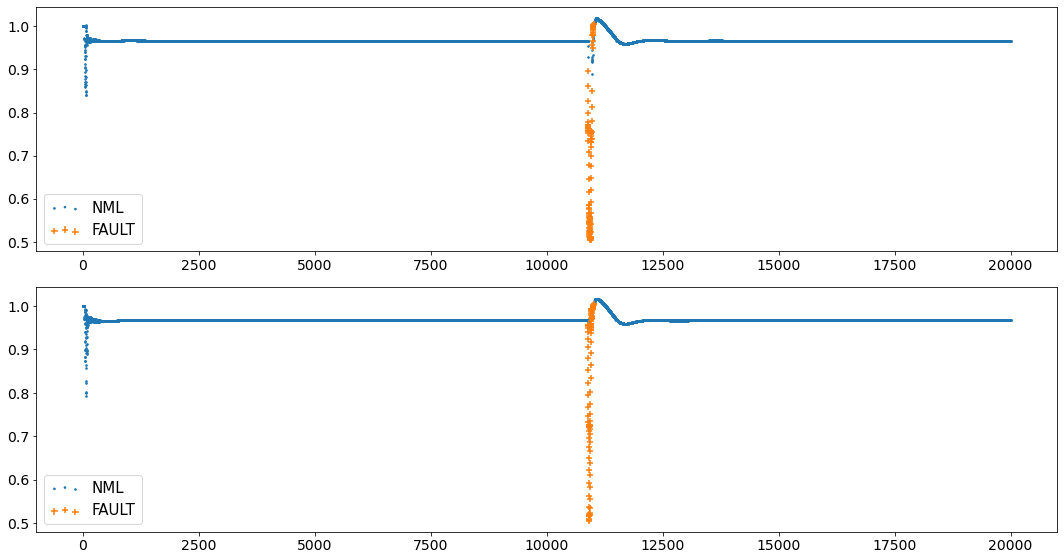

  Fault type Percentage
0        ACG      40.0%
1         AG     27.62%
2        ABC     23.81%
3       ABCG      4.76%
4         AC       1.9%
5        ABG       1.9%


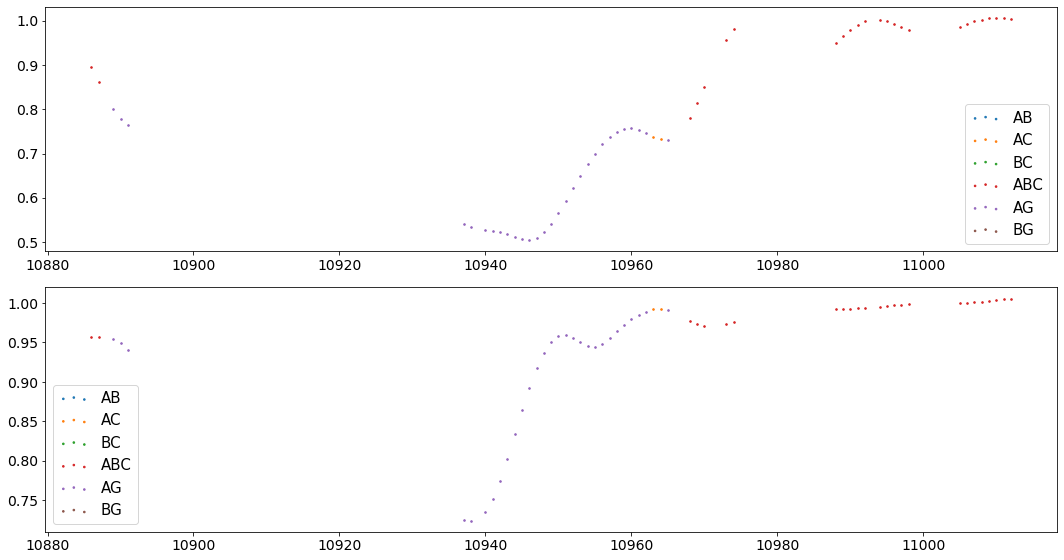


.
.
 1AB.csv
  Fault type Percentage
0        NML     89.17%
1      FAULT     10.84%


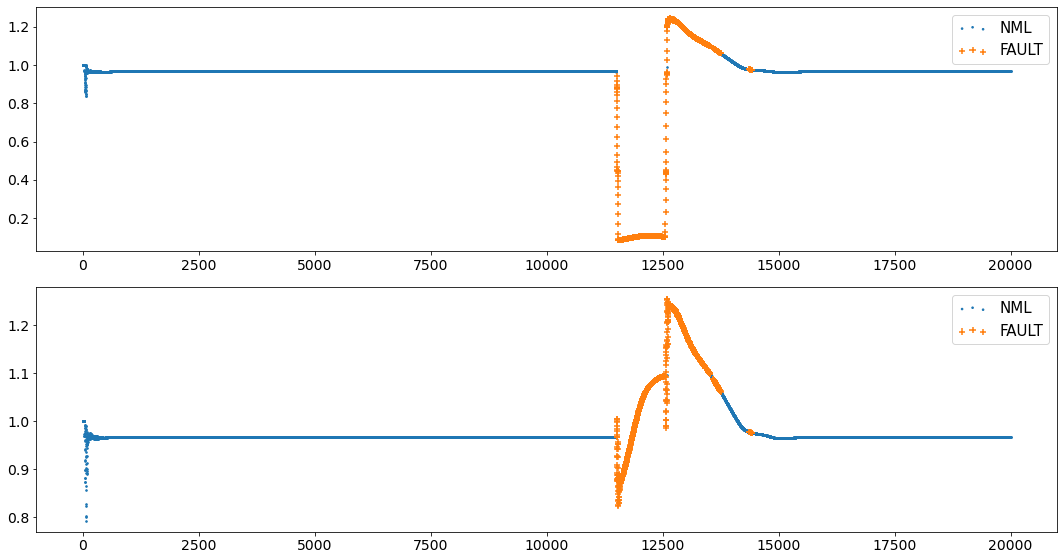

  Fault type Percentage
0         AB     56.35%
1        ABC     35.39%
2         BC      6.74%
3        ABG      0.83%
4        ACG      0.69%


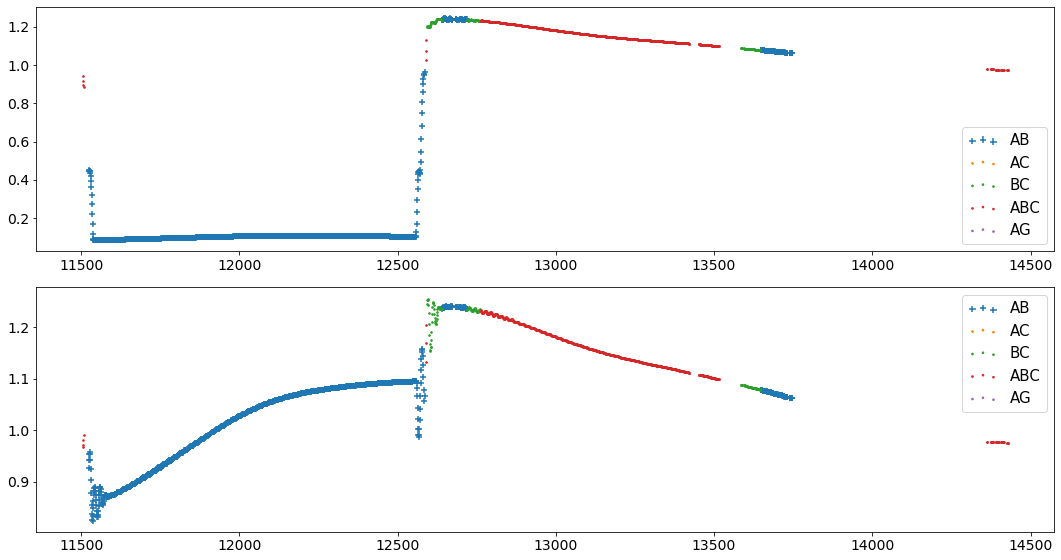


.
.
 2ABC.csv
  Fault type Percentage
0        NML     67.37%
1      FAULT     32.63%


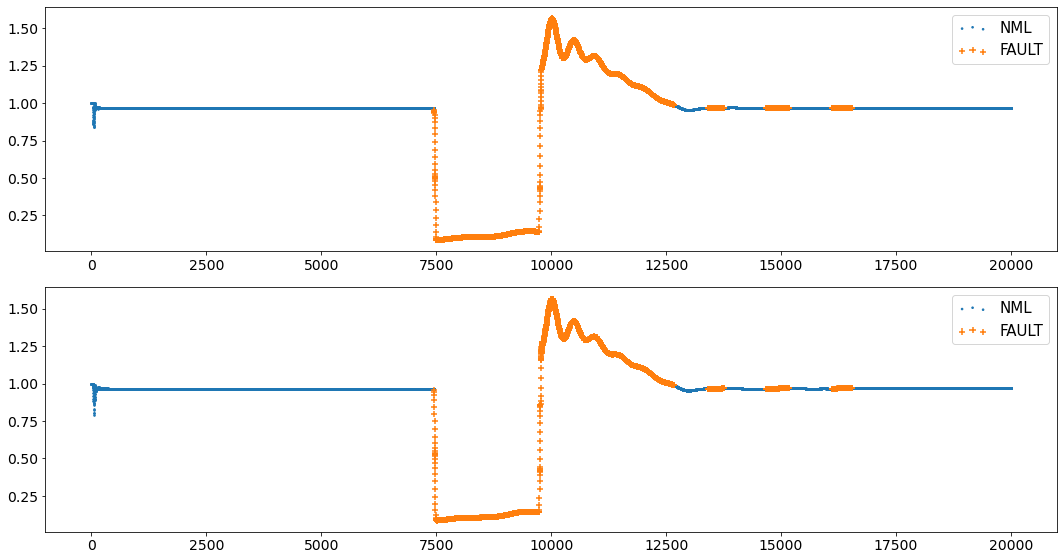

  Fault type Percentage
0        ABC     99.11%
1        ABG      0.55%
2       ABCG      0.12%
3        ACG      0.12%
4        BCG      0.09%


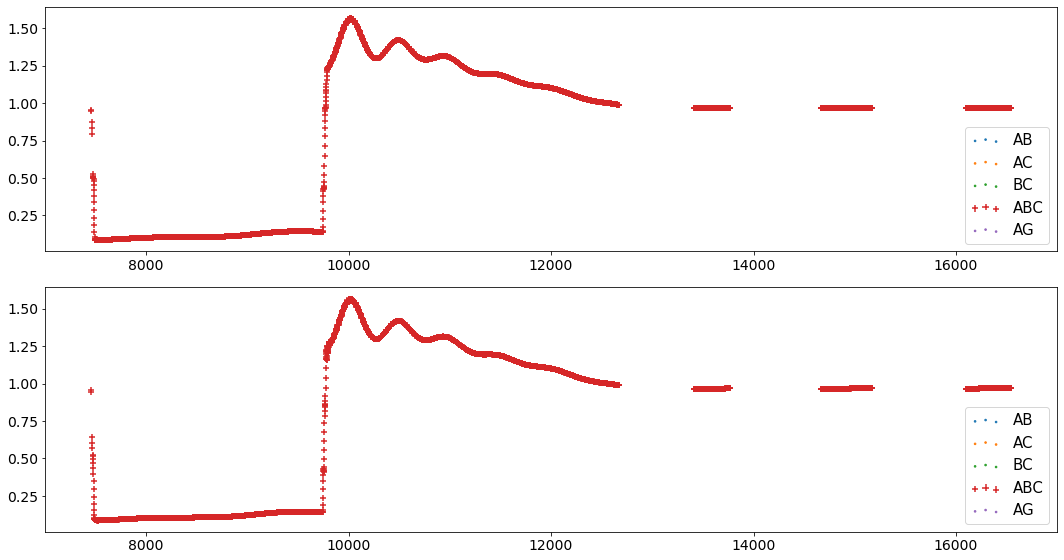


.
.
 9BG.csv
  Fault type Percentage
0        NML     88.69%
1      FAULT     11.31%


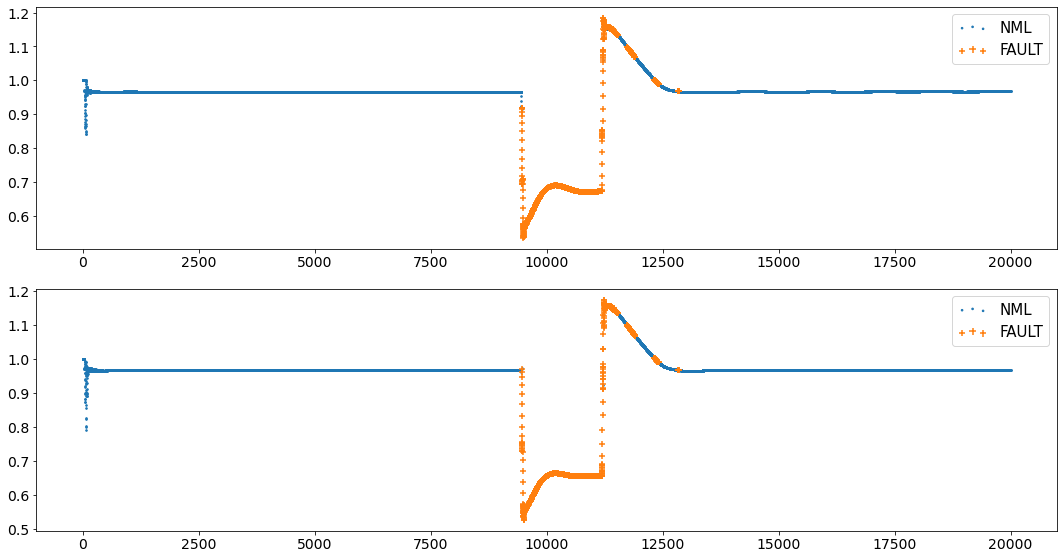

  Fault type Percentage
0         BG     77.28%
1        ABC      15.3%
2         BC      7.25%
3        BCG      0.09%
4         AB      0.04%
5       ABCG      0.04%


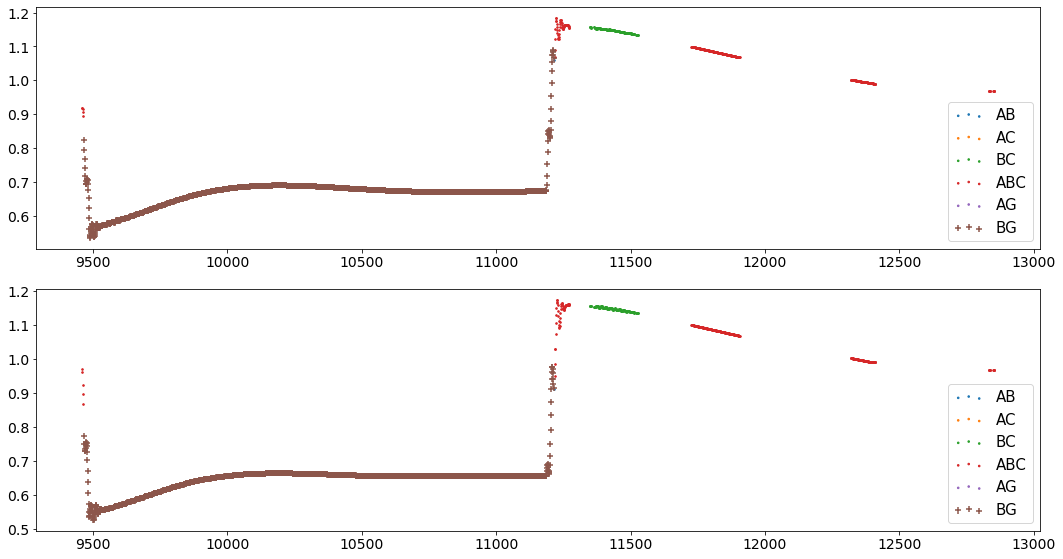


.
.
 9ABCG.csv
  Fault type Percentage
0        NML      58.1%
1      FAULT      41.9%


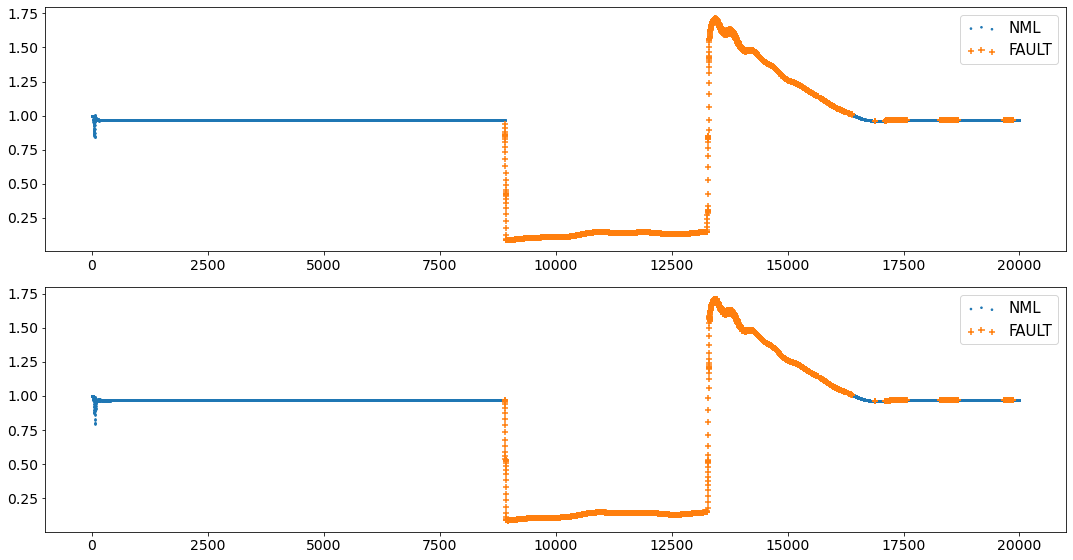

  Fault type Percentage
0        ABC     83.42%
1         BC      5.42%
2        ABG      4.58%
3        BCG      4.21%
4        ACG      1.75%
5         AC      0.57%
6       ABCG      0.04%


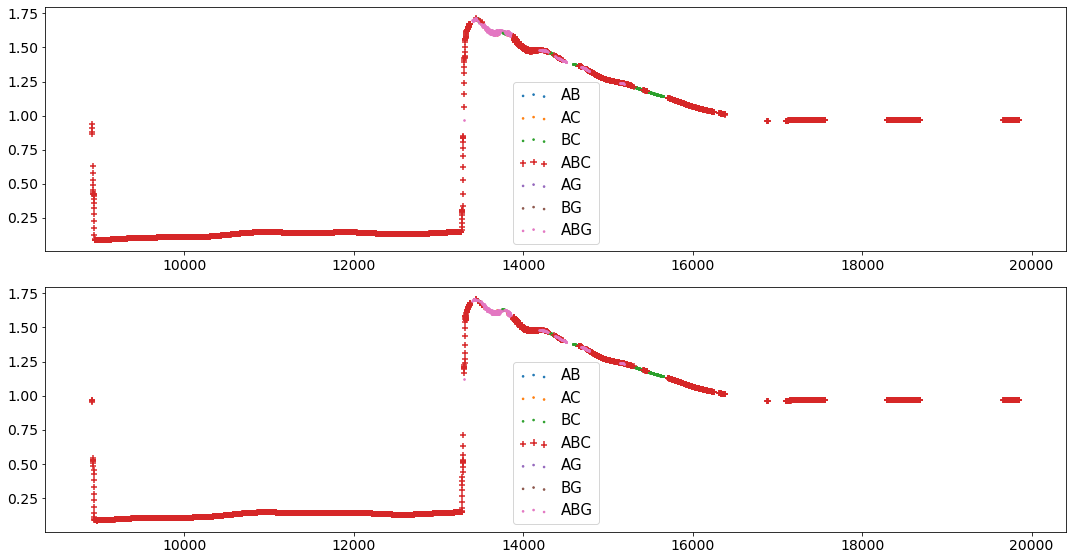


.
.
 3AB.csv
  Fault type Percentage
0        NML     88.78%
1      FAULT     11.22%


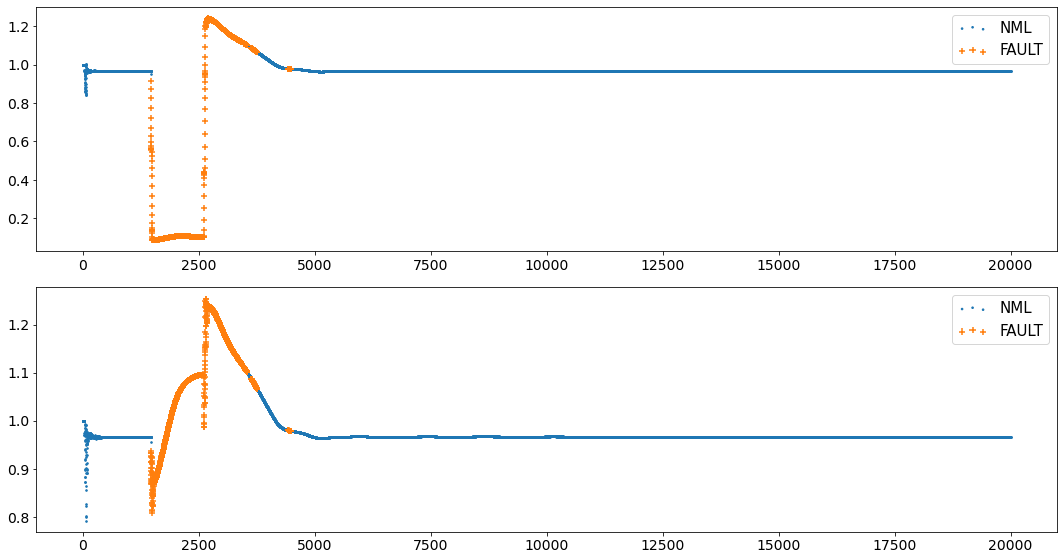

  Fault type Percentage
0         AB     55.81%
1        ABC     35.81%
2         BC      4.45%
3        ACG      2.27%
4        ABG      0.94%
5        BCG      0.67%
6       ABCG      0.04%


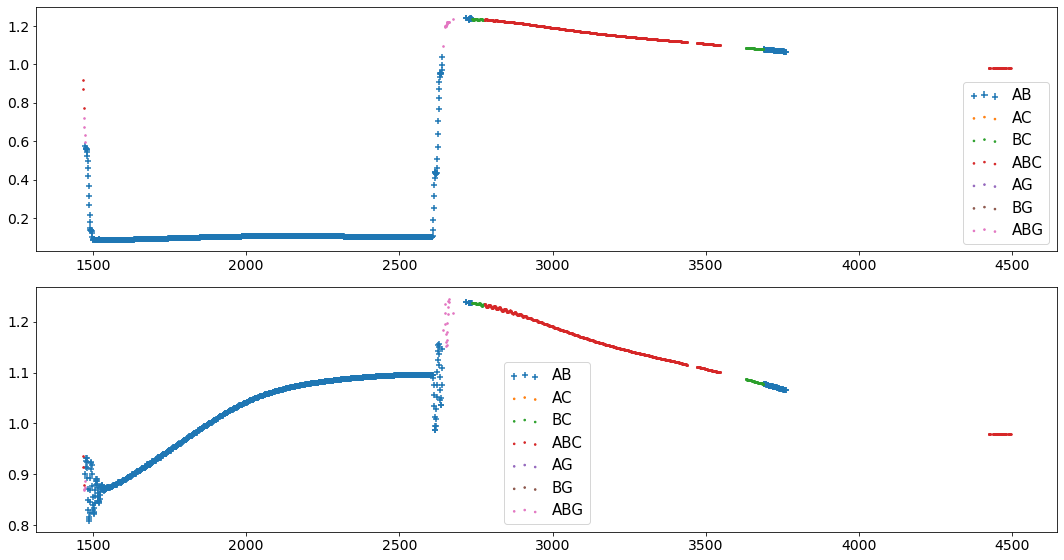


.
.
 3AC.csv
  Fault type Percentage
0        NML      78.7%
1      FAULT      21.3%


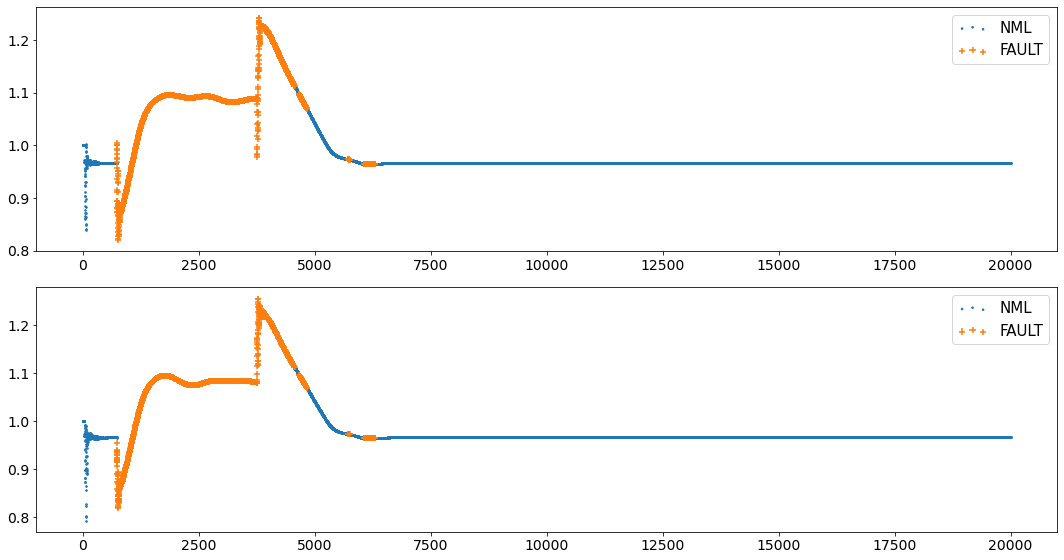

  Fault type Percentage
0         AC     71.21%
1        ABC     27.57%
2         BC       0.8%
3        ACG      0.38%
4        BCG      0.05%


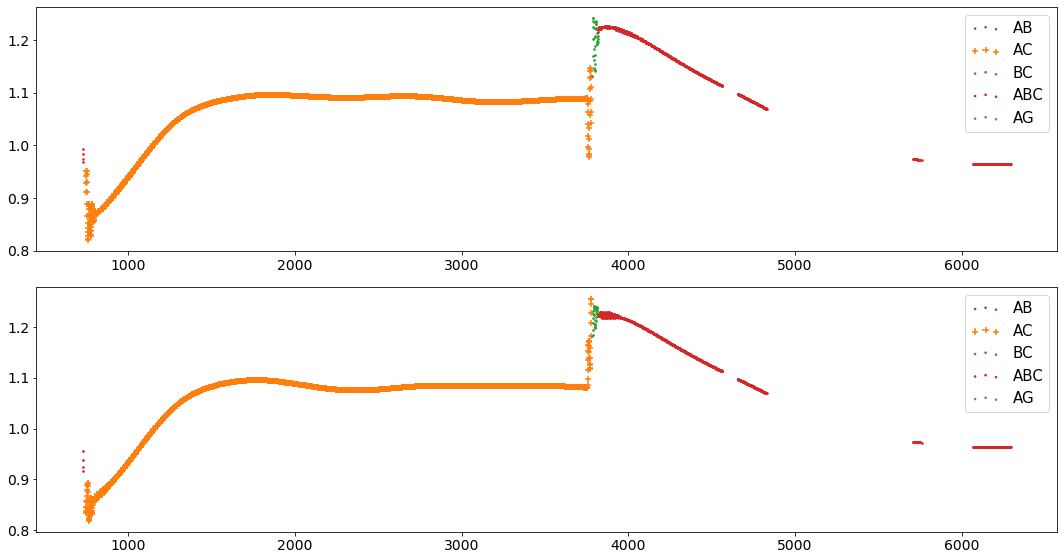


.
.
 4BCG.csv
  Fault type Percentage
0        NML      56.4%
1      FAULT      43.6%


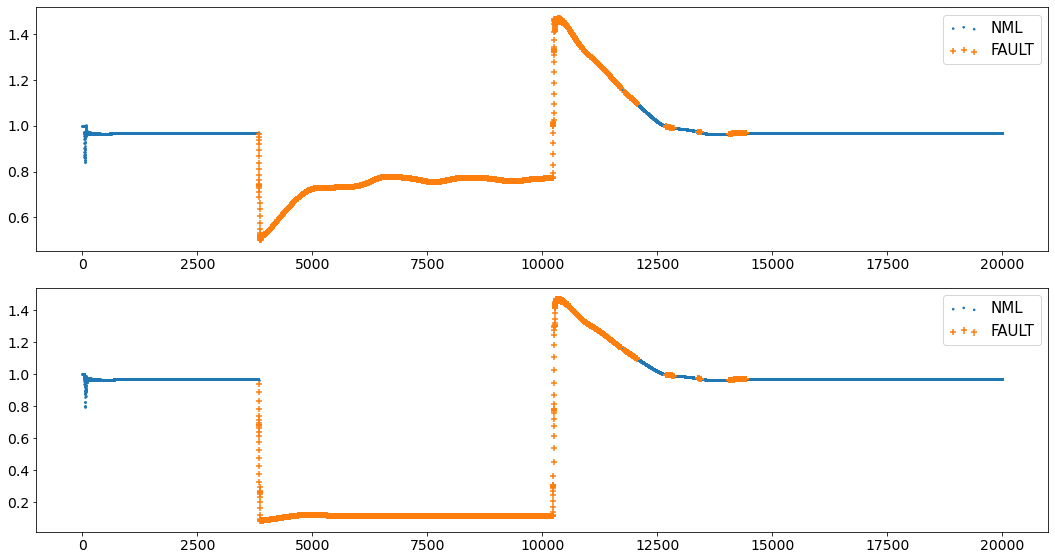

  Fault type Percentage
0        BCG     76.42%
1        ABC     16.64%
2         BC      3.91%
3        ABG      1.97%
4         AC      0.48%
5        ACG       0.4%
6         CG      0.14%
7         AB      0.03%


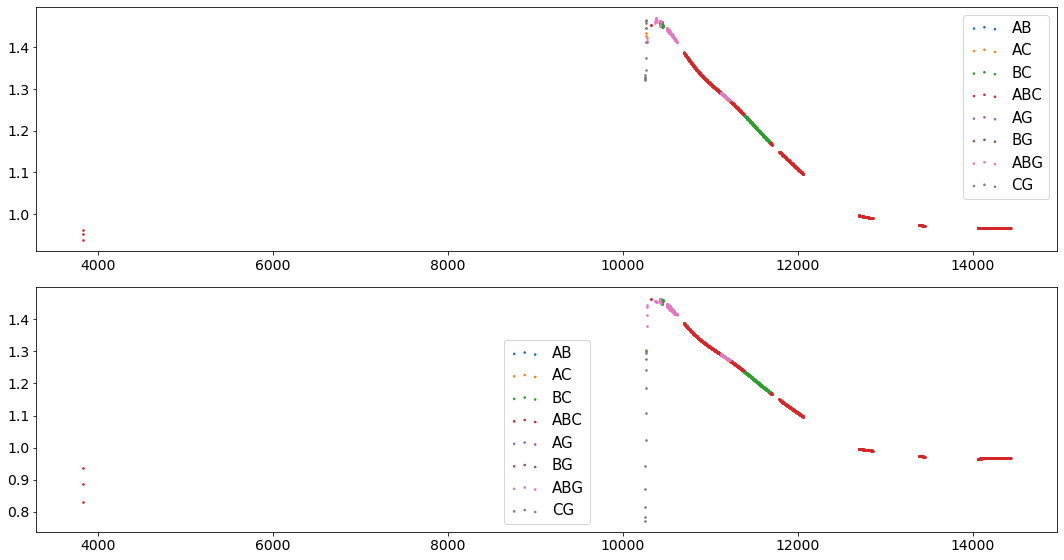


.
.
 7AG.csv
  Fault type Percentage
0        NML     85.64%
1      FAULT     14.36%


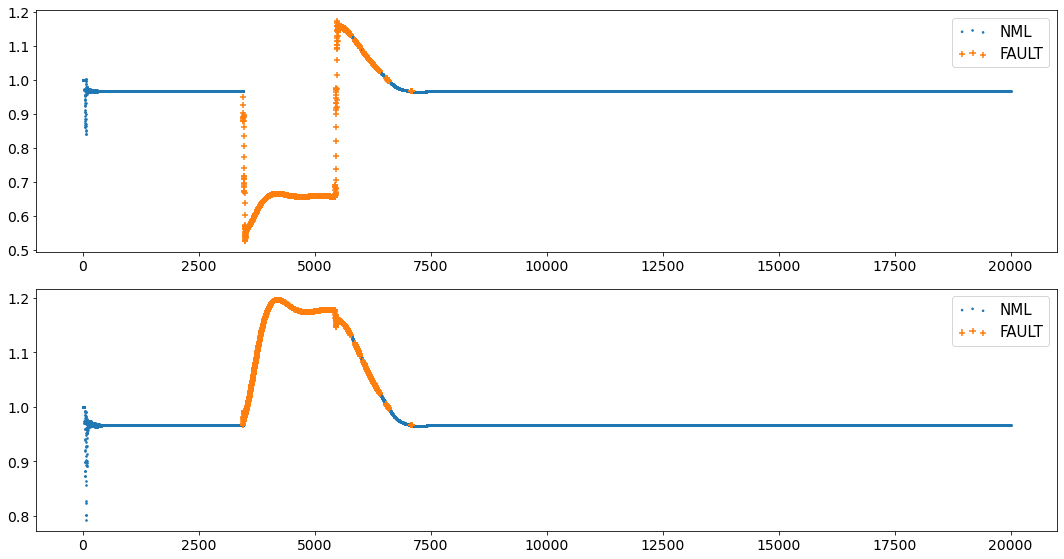

  Fault type Percentage
0         AG     69.94%
1        ABC     19.51%
2         BC     10.38%
3        ACG      0.14%
4        ABG      0.03%


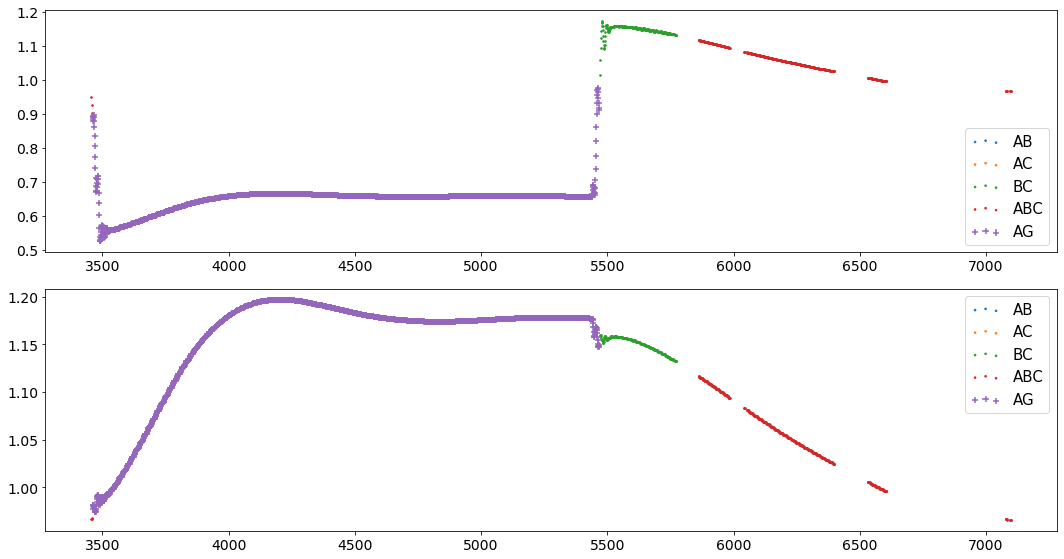


.
.
 8BCG.csv
  Fault type Percentage
0        NML     78.46%
1      FAULT     21.54%


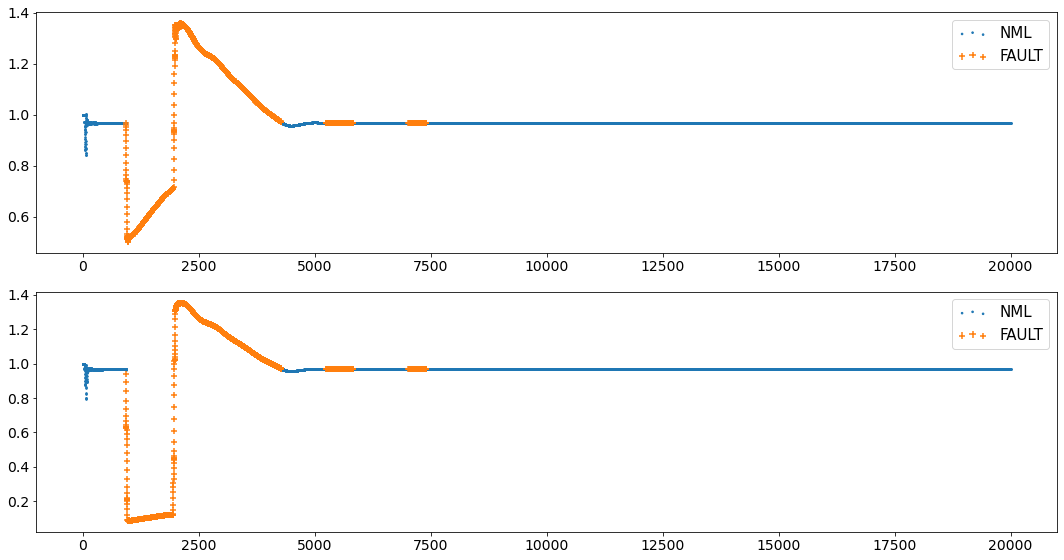

  Fault type Percentage
0        ABC     71.94%
1        BCG     27.65%
2        ABG      0.42%


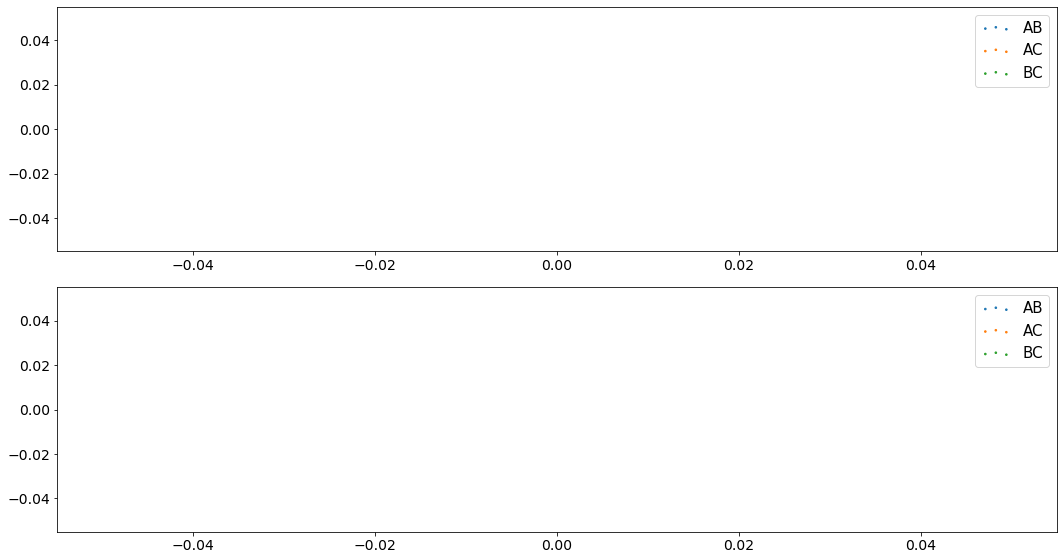

In [519]:
checker = []
for each in file_list:
    print("\n.\n.\n",each)  
    temp = tester(binary_model,pd.read_csv('./TrainingSet/'+each))
    plotter(temp,binary_labels_list,2)
    temp = tester(multi_model,temp[temp.label!=0])
    high = plotter(temp,multi_labels_list,2)
    if high == ''.join([i for i in each.split(".")[0] if not i.isdigit()]):
        checker.append(high)
    else:
        checker.append('incorrect')


In [531]:
files_failing_model = [file_list[i] for i in range(len(checker)) if checker[i]=='incorrect']

names = [''.join([i for i in each.split(".")[0] if not i.isdigit()]) for each in files_failing_model]

In [532]:
Counter(names)

Counter({'ABCG': 10,
         'BCG': 4,
         'ABG': 3,
         'ACG': 3,
         'AC': 5,
         'AG': 1,
         'AB': 3,
         'BC': 1,
         'BG': 1})

  Fault type Percentage
0        NML     89.17%
1      FAULT     10.84%


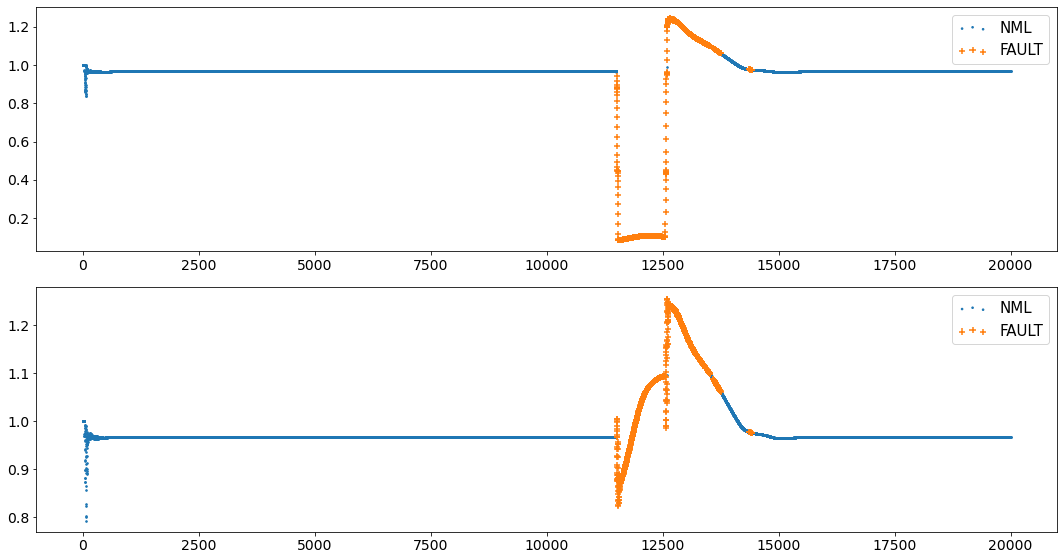

  Fault type Percentage
0         AB     56.35%
1        ABC     35.39%
2         BC      6.74%
3        ABG      0.83%
4        ACG      0.69%


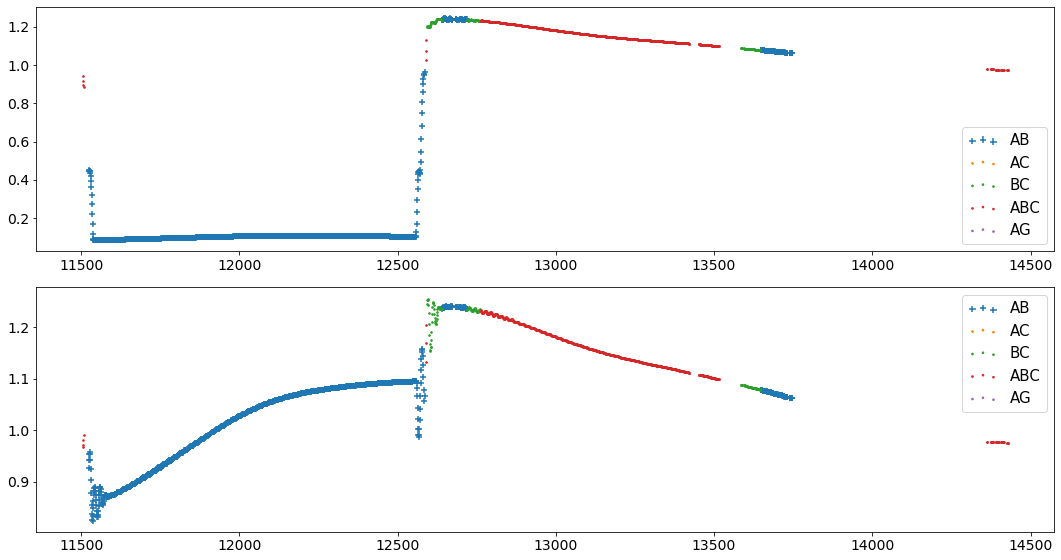

'AB'

In [533]:


temp = tester(binary_model,pd.read_csv('./TrainingSet/1AB.csv'))
plotter(temp,binary_labels_list,2)
temp = tester(multi_model,temp[temp.label!=0])
plotter(temp,multi_labels_list,2)

In [5]:
data = pd.read_csv('./TrainingSet/1AG.csv')

In [10]:
round(data['3V'])

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
19995    90.0
19996    90.0
19997    90.0
19998    90.0
19999    90.0
Name: 3V, Length: 20000, dtype: float64

In [26]:
dat = Counter((round(data['3V'])/10))
matrics = sorted(zip([each for each in Counter(dat).keys()],Counter(dat).values() ), key=lambda x: x[0])





In [27]:
matrics

[(0.1, 33),
 (4.8, 3),
 (4.9, 2),
 (5.0, 4),
 (5.1, 12),
 (5.2, 19),
 (5.3, 33),
 (5.4, 25),
 (5.5, 22),
 (5.6, 20),
 (5.7, 118),
 (5.8, 74),
 (5.9, 44),
 (6.0, 52),
 (6.1, 44),
 (6.2, 29),
 (6.3, 36),
 (6.4, 39),
 (6.5, 26),
 (6.6, 41),
 (6.7, 26),
 (6.8, 37),
 (6.9, 23),
 (7.0, 34),
 (7.1, 32),
 (7.2, 33),
 (7.3, 22),
 (7.4, 33),
 (7.5, 29),
 (7.6, 33),
 (7.7, 24),
 (7.8, 32),
 (7.9, 32),
 (8.0, 34),
 (8.1, 34),
 (8.2, 34),
 (8.3, 29),
 (8.4, 42),
 (8.5, 176),
 (8.6, 450),
 (8.7, 407),
 (8.8, 328),
 (8.9, 4763),
 (9.0, 359),
 (9.1, 511),
 (9.2, 444),
 (9.3, 182),
 (9.4, 171),
 (9.5, 195),
 (9.6, 194),
 (9.7, 254),
 (9.8, 290),
 (9.9, 204),
 (10.0, 44),
 (10.1, 39),
 (10.2, 91),
 (10.3, 47),
 (11.0, 1),
 (11.6, 1),
 (11.9, 1),
 (12.6, 1),
 (13.2, 1),
 (13.5, 1),
 (13.6, 2),
 (13.7, 3),
 (13.9, 1),
 (14.3, 1),
 (15.0, 1),
 (15.5, 1),
 (16.0, 1),
 (17.1, 1),
 (17.4, 1),
 (18.4, 1),
 (19.0, 1),
 (19.7, 1),
 (20.5, 1),
 (20.9, 1),
 (21.3, 2),
 (21.5, 2),
 (21.8, 2),
 (21.9, 2),
 (22.0, 12

In [4]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [6]:
import pandas as pd
data = pd.read_csv('ml_test.csv')

In [8]:
features = data[data.columns[:-1]].values.tolist()
#true_labels = data['label'].values.tolist()

In [9]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)


In [10]:
scaled_features[:5]

array([[ 0.44395328,  0.74417823,  0.74338087, -1.16439072, -1.2394718 ],
       [ 0.44395328,  0.74417823,  0.74338087, -1.16439072, -1.2394718 ],
       [ 0.44395328,  0.74417823,  0.74338087, -1.16439072, -1.2394718 ],
       [ 0.44395328,  0.74417823,  0.74338087, -1.16439072, -1.2394718 ],
       [ 0.44395328,  0.74417823,  0.74338087, -1.16439072, -1.2394718 ]])

In [26]:
from sklearn.cluster import DBSCAN

In [32]:
clustering = DBSCAN(eps=5, min_samples=10).fit(scaled_features)

In [33]:
set(clustering.labels_)

{0}

In [11]:
kmeans = KMeans(
    init="random",
    n_clusters=2,
    n_init=10,
    max_iter=500,
    random_state=42
)

In [12]:
kmeans.fit(scaled_features)

KMeans(init='random', max_iter=500, n_clusters=2, random_state=42)

In [13]:
kmeans.cluster_centers_

array([[-9.31504923, -8.81658808, -8.74807359,  9.45363051,  9.42157876],
       [ 0.10027318,  0.09490743,  0.09416989, -0.10176496, -0.10141994]])

In [21]:
data2 = pd.read_csv("./TrainingSet/2ABCG.csv")
labels = kmeans.fit_predict(data2.values.tolist())


In [22]:
data2['label'] = labels

In [23]:
data2

1A       2A       3A      1V      2V      3V  label
0      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
1      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
2      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
3      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
4      1.00000  1.00000  1.00000   1.000   1.000   1.000      0
...        ...      ...      ...     ...     ...     ...    ...
19995  0.96873  0.96872  0.96870  86.578  86.593  86.584      0
19996  0.96874  0.96871  0.96870  86.578  86.591  86.579      0
19997  0.96874  0.96871  0.96870  86.579  86.589  86.575      0
19998  0.96874  0.96870  0.96871  86.580  86.585  86.572      0
19999  0.96873  0.96869  0.96872  86.581  86.581  86.569      0

[20000 rows x 7 columns]

In [24]:
list(set(data2.label))

[0, 1]

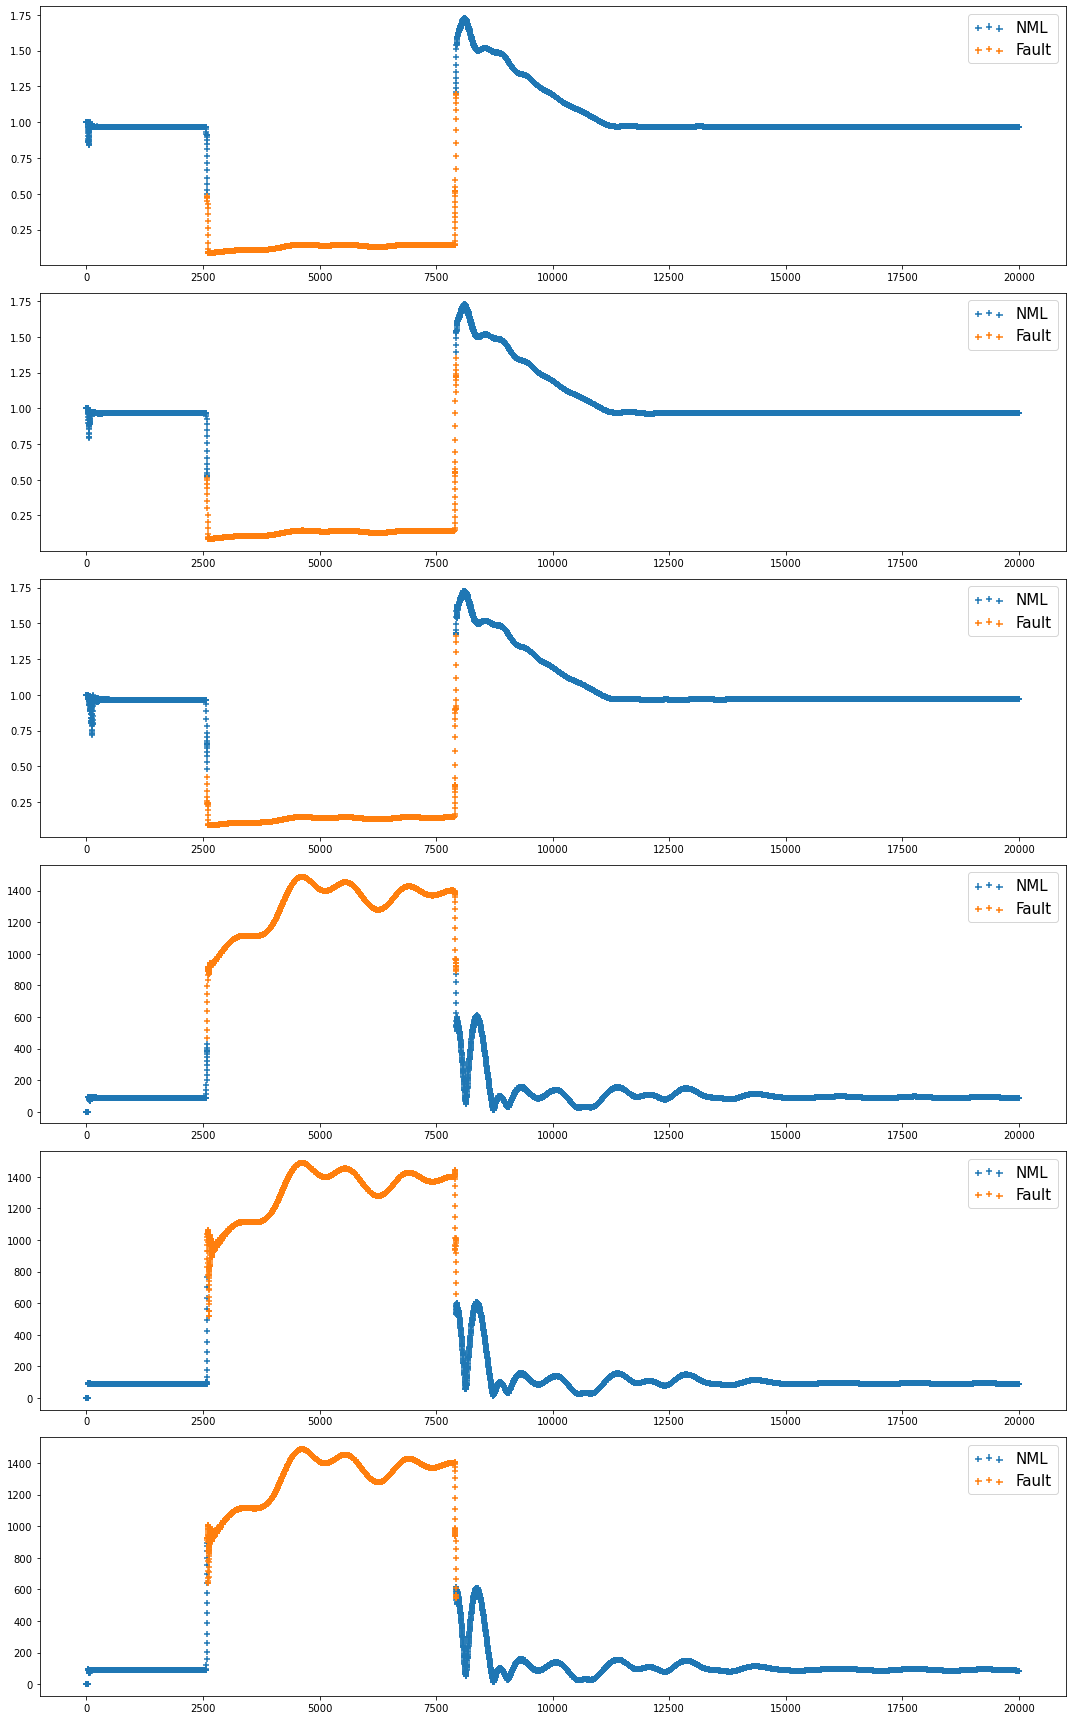

In [25]:
n_plots = 6
fig, ax = plt.subplots(n_plots,figsize=(15,4*n_plots))
unique_labels = ['NML','Fault','Out']
cols = data2.columns[:-1]

for j in range(6):

    
    legend_list = []
    for i in list(set(data2.label)):
        
        plo = data2[data2.label == i]
        temp = ax[j].scatter(plo.index,plo[cols[j]],marker='+',s=40)  


        legend_list.append(temp)

    ax[j].legend(legend_list,unique_labels,scatterpoints=3,ncol=1,fontsize=15)

fig.tight_layout()
plt.show()